In [1]:
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.types import IntegerType, StringType, DoubleType, FloatType
from pyspark.sql.window import Window
from pyspark.sql.functions import broadcast
import pandas as pd

## Loading the dataset from CSV

In [2]:
hbo = spark.read.csv('test.csv',inferSchema=True,header=True)
hbo.createOrReplaceTempView("hbo_titles")
hbo.show(5,truncate=True)
hbo.printSchema()

+------------------+-----+--------------------+
|             title| type|         description|
+------------------+-----+--------------------+
|  The Wizard of Oz|MOVIE|Young Dorothy fin...|
|      Citizen Kane|MOVIE|Newspaper magnate...|
|        Casablanca|MOVIE|In Casablanca, Mo...|
|     The Big Sleep|MOVIE|Private Investiga...|
|The Maltese Falcon|MOVIE|A private detecti...|
+------------------+-----+--------------------+
only showing top 5 rows

root
 |-- title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- description: string (nullable = true)



## Reformat and cleanup through SQL

This new format being
```
+--------------------+-----+
|               entry|class|
+--------------------+-----+
|title | description |    0|
|title | description |    1|
+--------------------------+
```
With `MOVIES` being class `0`
and `SHOWS` being class `1`.

In [3]:
query_1 = """
SELECT
  CONCAT(title,' | ',description) AS entry,
  CASE
    WHEN type = 'MOVIE' THEN 0
    ELSE 1
  END AS class
FROM hbo_titles
  WHERE description != 'null'
"""

In [4]:
filtered_df = spark.sql(query_1)

filtered_df.show(5)

filtered_df.printSchema()

+--------------------+-----+
|               entry|class|
+--------------------+-----+
|The Wizard of Oz ...|    0|
|Citizen Kane | Ne...|    0|
|Casablanca | In C...|    0|
|The Big Sleep | P...|    0|
|The Maltese Falco...|    0|
+--------------------+-----+
only showing top 5 rows

root
 |-- entry: string (nullable = true)
 |-- class: integer (nullable = false)



In [5]:
number_of_titles = filtered_df.count()
number_of_movies = filtered_df.filter("class=0").count()
number_of_shows = filtered_df.filter("class=1").count()

print("Number of titles: {}\n\t Number of movies: {}\n\t Number of shows: {}".format(number_of_titles,number_of_movies,number_of_shows))

Number of titles: 3312
	 Number of movies: 2528
	 Number of shows: 784


## Converting to Pandas

In [6]:
processing_df = filtered_df.toPandas()

In [7]:
processing_df

entry  class
0     The Wizard of Oz | Young Dorothy finds herself...      0
1     Citizen Kane | Newspaper magnate, Charles Fost...      0
2     Casablanca | In Casablanca, Morocco in Decembe...      0
3     The Big Sleep | Private Investigator Philip Ma...      0
4     The Maltese Falcon | A private detective takes...      0
...                                                 ...    ...
3307  Romeo Santos: Utopia Live from MetLife Stadium...      0
3308         Algo Azul | Romantic comedy...coming soon.      0
3309  Entre Nos: What She Said | A stand-up comedy s...      0
3310  Entre Nos: The Winners 2 | Comedy special star...      0
3311  The Infamous Future | The untold story of New ...      0

[3312 rows x 2 columns]

## Clean-up and Training

In [8]:
from Cleanupper import Processor

In [9]:
with open('./stopwords.txt') as f:
        sw = f.read().split('\n')
processor = Processor(processing_df,sw)

0.01 | 10000


In [10]:
processor.clean_text('entry')

In [11]:
processor.data.head()

entry  class  \
0  The Wizard of Oz | Young Dorothy finds herself...      0   
1  Citizen Kane | Newspaper magnate, Charles Fost...      0   
2  Casablanca | In Casablanca, Morocco in Decembe...      0   
3  The Big Sleep | Private Investigator Philip Ma...      0   
4  The Maltese Falcon | A private detective takes...      0   

                                               words  
0  [wizard, oz, young, dorothy, finds, magical, w...  
1  [citizen, kane, newspaper, magnate, charles, f...  
2  [casablanca, casablanca, morocco, december, cy...  
3  [big, sleep, private, investigator, philip, ma...  
4  [maltese, falcon, private, detective, takes, c...

In [12]:
processor.get_feature_voc()

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams


In [13]:
processor.data.head()

entry  class  \
0  The Wizard of Oz | Young Dorothy finds herself...      0   
1  Citizen Kane | Newspaper magnate, Charles Fost...      0   
2  Casablanca | In Casablanca, Morocco in Decembe...      0   
3  The Big Sleep | Private Investigator Philip Ma...      0   
4  The Maltese Falcon | A private detective takes...      0   

                                               words  \
0  [wizard, oz, young, dorothy, finds, magical, w...   
1  [citizen, kane, newspaper, magnate, charles, f...   
2  [casablanca, casablanca, morocco, december, cy...   
3  [big, sleep, private, investigator, philip, ma...   
4  [maltese, falcon, private, detective, takes, c...   

                                             bigrams  \
0  0    [wizard, oz, young, dorothy, finds, magic...   
1  1    [citizen, kane, newspaper, magnate, charl...   
2  2    [casablanca, casablanca, morocco, decembe...   
3  3    [big, sleep, private, investigator, phili...   
4  4    [maltese, falcon, private, detective, tak...   

                                           neg_words  \
0  [wizard, oz, young, dorothy, finds, magical, w...   
1  [citizen, kane, newspaper, magnate, charles, f...   
2  [casablanca, casablanca, morocco, december, cy...   
3  [big, sleep, private, investigator, philip, ma...   
4  [maltese, falcon, private, detective, takes, c...   

                                         neg_bigrams  
0  0    [wizard, oz, young, dorothy, finds, magic...  
1  1    [citizen, kane, newspaper, magnate, charl...  
2  2    [casablanca, casablanca, morocco, decembe...  
3  3    [big, sleep, private, investigator, phili...  
4  4    [maltese, falcon, private, detective, tak...

Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.1004450165712556
Training
iter: 0, loss: 1.1004450165712556, err: 0.01
iter: 1000, loss: 0.48968675534046646, err: 0.01
iter: 2000, loss: 0.40866895741573106, err: 0.01
iter: 3000, loss: 0.3905906815359239, err: 0.01
iter: 4000, loss: 0.38399632853064847, err: 0.01
iter: 5000, loss: 0.3808554373741573, err: 0.01
iter: 6000, loss: 0.37913353150083506, err: 0.01
iter: 7000, loss: 0.37811449298814087, err: 0.01
iter: 8000, loss: 0.3774840239417802, err: 0.01
iter: 9000, loss: 0.3770829253086203, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot


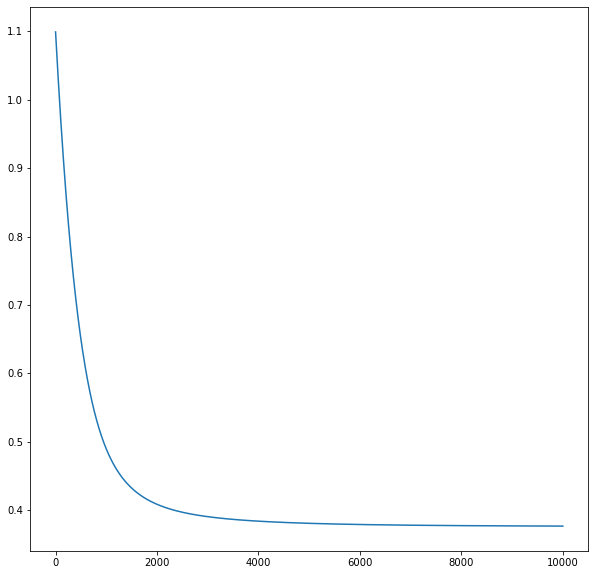

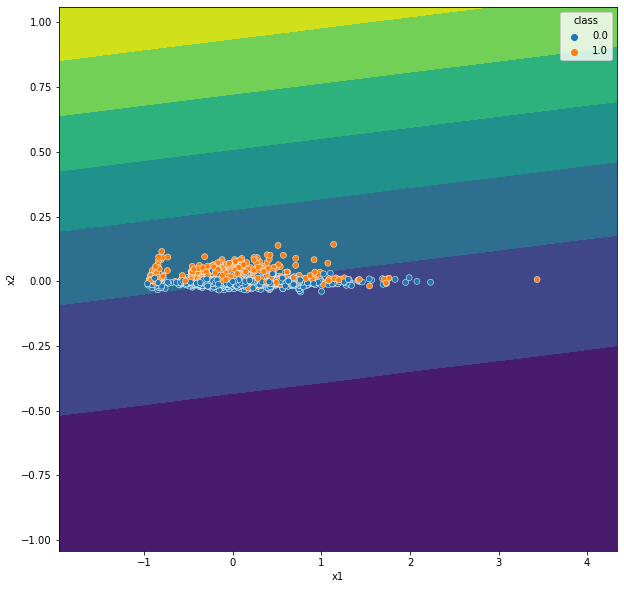

In [14]:
processor.train_model('entry','class')

## Optuna optimization

[**Optuna**](https://optuna.org/) is a Hyperparameter Optimization Framework.  

With it, we can find the best hyperparameters to improve our model (aka, **minimize our model's loss**).

### Structure of an Optuna Study

Taken from [**LornartheBreton's robo-shakespeare repo**](https://github.com/LornartheBreton/robo_shakespeare).

#### Required functions

```python
def define_model(trial):
        n_layers = trial.suggest_int("n_layers",4,6)
        n_hidden = trial.suggest_int("n_hidden",312,712,step=100)
        drop_prob = trial.suggest_float("drop_prob",0.4,0.6,step=0.05)
        lr = trial.suggest_float("lr",0.001,0.01,step=0.001)
        batch_size = trial.suggest_int("batch_size",16,128,step=16)

        return CharRNN(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob, lr=lr,batch_size=batch_size)

    def objective(trial):
        model = define_model(trial).to('cuda')
        loss = 0
        status = 'Current Params:\n'
        #print('Current Params:',end='\r')
        for key, value in trial.params.items():
            status+="    {}: {}".format(key, value) + '\n'
            #print("    {}: {}".format(key, value),end='\r')
        print(status,end='\r')

        for epoch in tnrange(EPOCHS,desc='Internal Epochs'):
            #print(" ABSOLUTE EPOCH:   "+str(epoch))
            #print("     Relative Epochs:    " + str(model.epochs_trained))
            loss_arr= model.model_train(seq_length=160,print_state=False)
            loss = loss_arr[0]
            print("         Current Loss: %f"%loss,end='\r')
            trial.report(loss,epoch)


            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return loss
```

#### Main

```python
study.optimize(evaluator.objective,n_trials=20,show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
```

In [15]:
import optuna
class Optimizer:
    
    def __init__(self,data,stopwords):
        self.model = None
        self.loss = 100
        self.data = data
        self.sw = stopwords
    
    def define_model(self,trial):
        alpha = trial.suggest_float("alpha",0.001,0.009,step=0.001)
        err = trial.suggest_float("err",0.01,0.05,step=0.01)
        min_count = trial.suggest_int("min_count",100,1000,step=50)
        tol = trial.suggest_int("Tol",5000,15000,step=1000)
        
        return Processor(self.data,self.sw,alpha=alpha,err=err,min_count=min_count,tol=tol)
    
    def objective(self,trial):
        
        
        model = self.define_model(trial)
        status = 'Current Params:\n'
        
        for key, value in trial.params.items():
            status+="    {}: {}".format(key, value) + '\n'
        print(status)
        model.clean_text('entry')
        model.get_feature_voc()
        model.train_model('entry','class',plot=False)
        loss = 0
        
        
        model.train_model('entry','class')
        
        loss = model.model.loss()
        
        if loss<self.loss:
            self.loss=loss
            self.model=model
        
        return loss

[I 2022-06-01 12:03:21,080] A new study created in memory with name: no-name-fae6bdf3-ddbd-4699-a319-2e5c6f47a2f8
/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

0.05 | 7000
Current Params:
    alpha: 0.006
    err: 0.05
    min_count: 800
    Tol: 7000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6029990138172479
Training
iter: 0, loss: 0.6029990138172479, err: 0.05
iter: 1000, loss: 0.412936286781933, err: 0.05
iter: 2000, loss: 0.38853533977924504, err: 0.05
iter: 3000, loss: 0.38203252974565194, err: 0.05
iter: 4000, loss: 0.37940476334470696, err: 0.05
iter: 5000, loss: 0.37809561786661716, err: 0.05
iter: 6000, loss: 0.37737427415611563, err: 0.05
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7659204537199297
Training
iter: 0, loss: 0.7659204537199297, err: 0.05
iter: 1000, loss: 0.42723566289892356, err: 0.05
iter: 2000, loss: 0.3907030206354927, err: 0.05
iter: 3000, loss: 0.3825983376974217, err: 0.05
iter: 4000, loss: 0.37962111533429344, err: 0.05
iter: 5000, loss: 0.3782001350921987, err: 0.05
iter: 6000, loss: 0.37743135045488, err: 0.05
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:03:30,170] Trial 0 finished with value: 0.37698902403068063 and parameters: {'alpha': 0.006, 'err': 0.05, 'min_count': 800, 'Tol': 7000}. Best is trial 0 with value: 0.37698902403068063.
0.04 | 7000
Current Params:
    alpha: 0.009
    err: 0.04
    min_count: 100
    Tol: 7000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8343740603871473
Training
iter: 0, loss: 0.8343740603871473, err: 0.04
iter: 1000, loss: 0.40597262131890965, err: 0.04
iter: 2000, loss: 0.38413189540

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9612446032827786
Training
iter: 0, loss: 0.9612446032827786, err: 0.04
iter: 1000, loss: 0.4148641917363026, err: 0.04
iter: 2000, loss: 0.3867836849334405, err: 0.04
iter: 3000, loss: 0.3804054116522692, err: 0.04
iter: 4000, loss: 0.37811805284375644, err: 0.04
iter: 5000, loss: 0.37715265351986177, err: 0.04
iter: 6000, loss: 0.37671354765079956, err: 0.04
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:03:39,319] Trial 1 finished with value: 0.3765053278908788 and parameters: {'alpha': 0.009, 'err': 0.04, 'min_count': 100, 'Tol': 7000}. Best is trial 1 with value: 0.3765053278908788.
0.05 | 10000
Current Params:
    alpha: 0.001
    err: 0.05
    min_count: 550
    Tol: 10000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9182295027783243
Training
iter: 0, loss: 0.9182295027783243, err: 0.05
iter: 1000, loss: 0.7293380060898859, err: 0.05
iter: 2000, loss: 0.611872273467

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8628305325434682
Training
iter: 0, loss: 0.8628305325434682, err: 0.05
iter: 1000, loss: 0.7065842731732843, err: 0.05
iter: 2000, loss: 0.6036256934792792, err: 0.05
iter: 3000, loss: 0.5368909873925851, err: 0.05
iter: 4000, loss: 0.49338921736251146, err: 0.05
iter: 5000, loss: 0.46443330112474496, err: 0.05
iter: 6000, loss: 0.4445945080744341, err: 0.05
iter: 7000, loss: 0.43057048322804586, err: 0.05
iter: 8000, loss: 0.42035231982783294, err: 0.05
iter: 9000, loss: 0.41269826347745575, err: 0.05
Saving results
Saving classification region plot


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:03:49,482] Trial 2 finished with value: 0.40682220291773213 and parameters: {'alpha': 0.001, 'err': 0.05, 'min_count': 550, 'Tol': 10000}. Best is trial 1 with value: 0.3765053278908788.
0.05 | 15000
Current Params:
    alpha: 0.005
    err: 0.05
    min_count: 600
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7376745260555615
Training
iter: 0, loss: 0.7376745260555615, err: 0.05
iter: 1000, loss: 0.4482922578915077, err: 0.05
iter: 2000, loss: 0.4032249392352559, err: 0.05
iter: 3000, loss

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6762335777118924
Training
iter: 0, loss: 0.6762335777118924, err: 0.05
iter: 1000, loss: 0.4306765836133057, err: 0.05
iter: 2000, loss: 0.39359117962531825, err: 0.05
iter: 3000, loss: 0.38411519092923296, err: 0.05
iter: 4000, loss: 0.38057504088701777, err: 0.05
iter: 5000, loss: 0.3788756869823027, err: 0.05
iter: 6000, loss: 0.3779303366443311, err: 0.05
iter: 7000, loss: 0.37736028015553114, err: 0.05
iter: 8000, loss: 0.37700098853303327, err: 0.05
iter: 9000, loss: 0.3767686436128916, err: 0.05
iter: 10000, loss: 0.37661594178445307, err: 0.05
iter: 11000, loss: 0.37651447141219646, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:04:01,270] Trial 3 finished with value: 0.3763486073877444 and parameters: {'alpha': 0.005, 'err': 0.05, 'min_count': 600, 'Tol': 15000}. Best is trial 3 with value: 0.3763486073877444.
0.05 | 13000
Current Params:
    alpha: 0.007
    err: 0.05
    min_count: 600
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0444542542917967
Training
iter: 0, loss: 1.0444542542917967, err: 0.05
iter: 1000, loss: 0.43871249621034947, err: 0.05
iter: 2000, loss: 0.3940500948

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8089241880622161
Training
iter: 0, loss: 0.8089241880622161, err: 0.05
iter: 1000, loss: 0.4161498661163095, err: 0.05
iter: 2000, loss: 0.3856816209605996, err: 0.05
iter: 3000, loss: 0.3800349687089293, err: 0.05
iter: 4000, loss: 0.37815270300702947, err: 0.05
iter: 5000, loss: 0.3773017563664383, err: 0.05
iter: 6000, loss: 0.37686270811720535, err: 0.05
iter: 7000, loss: 0.3766227679921743, err: 0.05
iter: 8000, loss: 0.3764878333393702, err: 0.05
iter: 9000, loss: 0.37641067414719914, err: 0.05
iter: 10000, loss: 0.3763660666526534, err: 0.05
iter: 11000, loss: 0.3763400781224399, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:04:12,561] Trial 4 finished with value: 0.3763158917091013 and parameters: {'alpha': 0.007, 'err': 0.05, 'min_count': 600, 'Tol': 13000}. Best is trial 4 with value: 0.3763158917091013.
0.01 | 11000
Current Params:
    alpha: 0.006
    err: 0.01
    min_count: 900
    Tol: 11000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8647303268087501
Training
iter: 0, loss: 0.8647303268087501, err: 0.01
iter: 1000, loss: 0.4326530544229921, err: 0.01
iter: 2000, loss: 0.39049410865

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8683909552512393
Training
iter: 0, loss: 0.8683909552512393, err: 0.01
iter: 1000, loss: 0.44532642200811023, err: 0.01
iter: 2000, loss: 0.39903046988445684, err: 0.01
iter: 3000, loss: 0.386781617034579, err: 0.01
iter: 4000, loss: 0.3818369172017068, err: 0.01
iter: 5000, loss: 0.3794260411145072, err: 0.01
iter: 6000, loss: 0.37813327105368094, err: 0.01
iter: 7000, loss: 0.3774016613434821, err: 0.01
iter: 8000, loss: 0.3769733979123674, err: 0.01
iter: 9000, loss: 0.3767169132165178, err: 0.01
iter: 10000, loss: 0.3765607869322058, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:04:23,118] Trial 5 finished with value: 0.3764646037799464 and parameters: {'alpha': 0.006, 'err': 0.01, 'min_count': 900, 'Tol': 11000}. Best is trial 4 with value: 0.3763158917091013.
0.04 | 15000
Current Params:
    alpha: 0.001
    err: 0.04
    min_count: 900
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7829823593793334
Training
iter: 0, loss: 0.7829823593793334, err: 0.04
iter: 1000, loss: 0.6505175828258316, err: 0.04
iter: 2000, loss: 0.56417424318

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7850162153198007
Training
iter: 0, loss: 0.7850162153198007, err: 0.04
iter: 1000, loss: 0.6519296469573325, err: 0.04
iter: 2000, loss: 0.5670182670931985, err: 0.04
iter: 3000, loss: 0.5127106392991951, err: 0.04
iter: 4000, loss: 0.47723219410118056, err: 0.04
iter: 5000, loss: 0.4533402037798591, err: 0.04
iter: 6000, loss: 0.43671532326753, err: 0.04
iter: 7000, loss: 0.4247771412556787, err: 0.04
iter: 8000, loss: 0.4159547102216851, err: 0.04
iter: 9000, loss: 0.4092661399169457, err: 0.04
iter: 10000, loss: 0.4040800388122478, err: 0.04
iter: 11000, loss: 0.39997893084355207, err: 0.

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lornarthebreton/Documents/fuentes_datos_final/Predictor.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 10))


Saving classification region plot
[I 2022-06-01 12:04:35,007] Trial 6 finished with value: 0.38988707685854096 and parameters: {'alpha': 0.001, 'err': 0.04, 'min_count': 900, 'Tol': 15000}. Best is trial 4 with value: 0.3763158917091013.
0.04 | 5000
Current Params:
    alpha: 0.001
    err: 0.04
    min_count: 150
    Tol: 5000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8220618202603782
Training
iter: 0, loss: 0.8220618202603782, err: 0.04
iter: 1000, loss: 0.6725321383874096, err: 0.04
iter: 2000, loss: 0.580551695884

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7889718763103828
Training
iter: 0, loss: 0.7889718763103828, err: 0.04
iter: 1000, loss: 0.6560120191985084, err: 0.04
iter: 2000, loss: 0.5691619460322884, err: 0.04
iter: 3000, loss: 0.512863760548423, err: 0.04
iter: 4000, loss: 0.4760006617193234, err: 0.04
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:04:43,426] Trial 7 finished with value: 0.45133134893197335 and parameters: {'alpha': 0.001, 'err': 0.04, 'min_count': 150, 'Tol': 5000}. Best is trial 4 with value: 0.3763158917091013.
0.04 | 10000
Current Params:
    alpha: 0.005
    err: 0.04
    min_count: 200
    Tol: 10000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7660203218842442
Training
iter: 0, loss: 0.7660203218842442, err: 0.04
iter: 1000, loss: 0.4411373526700661, err: 0.04
iter: 2000, loss: 0.39561846653

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9930626456915853
Training
iter: 0, loss: 0.9930626456915853, err: 0.04
iter: 1000, loss: 0.4710376344840054, err: 0.04
iter: 2000, loss: 0.40575490063130804, err: 0.04
iter: 3000, loss: 0.3897255006503294, err: 0.04
iter: 4000, loss: 0.38362263525214146, err: 0.04
iter: 5000, loss: 0.3806607015253448, err: 0.04
iter: 6000, loss: 0.3790215721775522, err: 0.04
iter: 7000, loss: 0.37804643662771387, err: 0.04
iter: 8000, loss: 0.3774412165233859, err: 0.04
iter: 9000, loss: 0.377055386585162, err: 0.04
Saving results
Saving classification region plot


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:04:53,674] Trial 8 finished with value: 0.3768048984910657 and parameters: {'alpha': 0.005, 'err': 0.04, 'min_count': 200, 'Tol': 10000}. Best is trial 4 with value: 0.3763158917091013.
0.03 | 15000
Current Params:
    alpha: 0.007
    err: 0.03
    min_count: 550
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8325351570980559
Training
iter: 0, loss: 0.8325351570980559, err: 0.03
iter: 1000, loss: 0.42434300611296566, err: 0.03
iter: 2000, loss: 0.3901812436536735, err: 0.03
iter: 3000, loss

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6390473155718452
Training
iter: 0, loss: 0.6390473155718452, err: 0.03
iter: 1000, loss: 0.41483015885171165, err: 0.03
iter: 2000, loss: 0.38956106561091647, err: 0.03
iter: 3000, loss: 0.3823448467749948, err: 0.03
iter: 4000, loss: 0.3793788620098895, err: 0.03
iter: 5000, loss: 0.37795594065069577, err: 0.03
iter: 6000, loss: 0.3772194106889608, err: 0.03
iter: 7000, loss: 0.37682134884142177, err: 0.03
iter: 8000, loss: 0.3766002433315883, err: 0.03
iter: 9000, loss: 0.3764751197116973, err: 0.03
iter: 10000, loss: 0.37640336888542947, err: 0.03
iter: 11000, loss: 0.3763618250707376, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:05:05,590] Trial 9 finished with value: 0.3763100953006025 and parameters: {'alpha': 0.007, 'err': 0.03, 'min_count': 550, 'Tol': 15000}. Best is trial 9 with value: 0.3763100953006025.
0.02 | 12000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 350
    Tol: 12000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7892893759064572
Training
iter: 0, loss: 0.7892893759064572, err: 0.02
iter: 1000, loss: 0.40532228473369175, err: 0.02
iter: 2000, loss: 0.3841962873

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9570560099299797
Training
iter: 0, loss: 0.9570560099299797, err: 0.02
iter: 1000, loss: 0.4073745591594244, err: 0.02
iter: 2000, loss: 0.38324371867773066, err: 0.02
iter: 3000, loss: 0.37896518191281614, err: 0.02
iter: 4000, loss: 0.37749756079138924, err: 0.02
iter: 5000, loss: 0.3768705422041626, err: 0.02
iter: 6000, loss: 0.3765802491340781, err: 0.02
iter: 7000, loss: 0.3764406680187538, err: 0.02
iter: 8000, loss: 0.3763720723739722, err: 0.02
iter: 9000, loss: 0.3763378852181585, err: 0.02
iter: 10000, loss: 0.3763206842255215, err: 0.02
iter: 11000, loss: 0.3763119725555845, err: 0.02
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:05:16,529] Trial 10 finished with value: 0.3763075400037126 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 350, 'Tol': 12000}. Best is trial 10 with value: 0.3763075400037126.
0.02 | 13000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 350
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8569340477900721
Training
iter: 0, loss: 0.8569340477900721, err: 0.02
iter: 1000, loss: 0.41282124159151046, err: 0.02
iter: 2000, loss: 0.38660655

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9488044998980798
Training
iter: 0, loss: 0.9488044998980798, err: 0.02
iter: 1000, loss: 0.4128743361265525, err: 0.02
iter: 2000, loss: 0.38612752991084787, err: 0.02
iter: 3000, loss: 0.38015756909552134, err: 0.02
iter: 4000, loss: 0.37801433678653845, err: 0.02
iter: 5000, loss: 0.3771061667340463, err: 0.02
iter: 6000, loss: 0.3766917601548011, err: 0.02
iter: 7000, loss: 0.3764948129044765, err: 0.02
iter: 8000, loss: 0.37639882753456955, err: 0.02
iter: 9000, loss: 0.37635126629333726, err: 0.02
iter: 10000, loss: 0.37632743273148694, err: 0.02
iter: 11000, loss: 0.3763153960382185, e

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:05:27,804] Trial 11 finished with value: 0.376306168259823 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 350, 'Tol': 13000}. Best is trial 11 with value: 0.376306168259823.
0.02 | 12000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 350
    Tol: 12000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8197990036904835
Training
iter: 0, loss: 0.8197990036904835, err: 0.02
iter: 1000, loss: 0.4114681770757274, err: 0.02
iter: 2000, loss: 0.38638927091

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8486271717533647
Training
iter: 0, loss: 0.8486271717533647, err: 0.02
iter: 1000, loss: 0.40209270601704855, err: 0.02
iter: 2000, loss: 0.3819986734138213, err: 0.02
iter: 3000, loss: 0.3784780277157734, err: 0.02
iter: 4000, loss: 0.37728460668090924, err: 0.02
iter: 5000, loss: 0.3767721622310467, err: 0.02
iter: 6000, loss: 0.37653320657356026, err: 0.02
iter: 7000, loss: 0.37641765811685696, err: 0.02
iter: 8000, loss: 0.3763606441780544, err: 0.02
iter: 9000, loss: 0.3763321493403338, err: 0.02
iter: 10000, loss: 0.3763177842592707, err: 0.02
iter: 11000, loss: 0.3763104988487034, err: 0.02
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:05:38,923] Trial 12 finished with value: 0.3763067883795912 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 350, 'Tol': 12000}. Best is trial 11 with value: 0.376306168259823.
0.02 | 13000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 350
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.848055087200415
Training
iter: 0, loss: 0.848055087200415, err: 0.02
iter: 1000, loss: 0.4042829900388483, err: 0.02
iter: 2000, loss: 0.383051579157

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.017562615171022
Training
iter: 0, loss: 1.017562615171022, err: 0.02
iter: 1000, loss: 0.4107481562489017, err: 0.02
iter: 2000, loss: 0.3842987131497304, err: 0.02
iter: 3000, loss: 0.379385655637661, err: 0.02
iter: 4000, loss: 0.3776800912512102, err: 0.02
iter: 5000, loss: 0.37695421334672374, err: 0.02
iter: 6000, loss: 0.37662002239455156, err: 0.02
iter: 7000, loss: 0.3764600412194938, err: 0.02
iter: 8000, loss: 0.37638166644733867, err: 0.02
iter: 9000, loss: 0.3763426908089853, err: 0.02
iter: 10000, loss: 0.376323110413666, err: 0.02
iter: 11000, loss: 0.3763132042672493, err: 0.0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:05:50,345] Trial 13 finished with value: 0.37630559815831705 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 350, 'Tol': 13000}. Best is trial 13 with value: 0.37630559815831705.
0.01 | 13000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 350
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.824730445029536
Training
iter: 0, loss: 0.824730445029536, err: 0.01
iter: 1000, loss: 0.4099190568970414, err: 0.01
iter: 2000, loss: 0.384869912

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.038490265328845
Training
iter: 0, loss: 1.038490265328845, err: 0.01
iter: 1000, loss: 0.4262107993728945, err: 0.01
iter: 2000, loss: 0.38999852655228884, err: 0.01
iter: 3000, loss: 0.3819016029073395, err: 0.01
iter: 4000, loss: 0.3789257211807852, err: 0.01
iter: 5000, loss: 0.3776097887671624, err: 0.01
iter: 6000, loss: 0.3769767504107596, err: 0.01
iter: 7000, loss: 0.37665786497386444, err: 0.01
iter: 8000, loss: 0.376492583077656, err: 0.01
iter: 9000, loss: 0.37640527478719166, err: 0.01
iter: 10000, loss: 0.3763585450257048, err: 0.01
iter: 11000, loss: 0.37633329974772955, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:06:01,621] Trial 14 finished with value: 0.37631206533534123 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 350, 'Tol': 13000}. Best is trial 13 with value: 0.37630559815831705.
0.02 | 13000
Current Params:
    alpha: 0.004
    err: 0.02
    min_count: 450
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7163542241221976
Training
iter: 0, loss: 0.7163542241221976, err: 0.02
iter: 1000, loss: 0.4677167510515901, err: 0.02
iter: 2000, loss: 0.4148726

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8753706866731006
Training
iter: 0, loss: 0.8753706866731006, err: 0.02
iter: 1000, loss: 0.492867833061584, err: 0.02
iter: 2000, loss: 0.4176308147132163, err: 0.02
iter: 3000, loss: 0.39644676971653453, err: 0.02
iter: 4000, loss: 0.3878965331306917, err: 0.02
iter: 5000, loss: 0.3835899322206083, err: 0.02
iter: 6000, loss: 0.38111779908226884, err: 0.02
iter: 7000, loss: 0.37958297334677354, err: 0.02
iter: 8000, loss: 0.3785825550488451, err: 0.02
iter: 9000, loss: 0.37790950760354836, err: 0.02
iter: 10000, loss: 0.3774468005063961, err: 0.02
iter: 11000, loss: 0.3771237229139106, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:06:12,833] Trial 15 finished with value: 0.37673284758611375 and parameters: {'alpha': 0.004, 'err': 0.02, 'min_count': 450, 'Tol': 13000}. Best is trial 13 with value: 0.37630559815831705.
0.03 | 9000
Current Params:
    alpha: 0.003
    err: 0.03
    min_count: 250
    Tol: 9000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6478968715909073
Training
iter: 0, loss: 0.6478968715909073, err: 0.03
iter: 1000, loss: 0.47862746027712844, err: 0.03
iter: 2000, loss: 0.42682526

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7758974809487487
Training
iter: 0, loss: 0.7758974809487487, err: 0.03
iter: 1000, loss: 0.509375722386263, err: 0.03
iter: 2000, loss: 0.43110174232447884, err: 0.03
iter: 3000, loss: 0.4044181468754068, err: 0.03
iter: 4000, loss: 0.3930586072760712, err: 0.03
iter: 5000, loss: 0.3872687764905532, err: 0.03
iter: 6000, loss: 0.3839118917830446, err: 0.03
iter: 7000, loss: 0.381783866745583, err: 0.03
iter: 8000, loss: 0.3803498211339316, err: 0.03
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:06:22,538] Trial 16 finished with value: 0.37934209692075205 and parameters: {'alpha': 0.003, 'err': 0.03, 'min_count': 250, 'Tol': 9000}. Best is trial 13 with value: 0.37630559815831705.
0.02 | 14000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 750
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.063325669798796
Training
iter: 0, loss: 1.063325669798796, err: 0.02
iter: 1000, loss: 0.4266139287369898, err: 0.02
iter: 2000, loss: 0.3900873955

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.695611170183156
Training
iter: 0, loss: 0.695611170183156, err: 0.02
iter: 1000, loss: 0.4048768349070185, err: 0.02
iter: 2000, loss: 0.38429726141065645, err: 0.02
iter: 3000, loss: 0.37965980595375765, err: 0.02
iter: 4000, loss: 0.37791885112166085, err: 0.02
iter: 5000, loss: 0.37712487778089165, err: 0.02
iter: 6000, loss: 0.37673295377594074, err: 0.02
iter: 7000, loss: 0.3765317683301279, err: 0.02
iter: 8000, loss: 0.3764260869965126, err: 0.02
iter: 9000, loss: 0.3763697295253314, err: 0.02
iter: 10000, loss: 0.3763393599840439, err: 0.02
iter: 11000, loss: 0.3763228725807187, err: 0.02
iter: 12000, loss: 0.

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:06:33,926] Trial 17 finished with value: 0.37630623247703676 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 750, 'Tol': 14000}. Best is trial 13 with value: 0.37630559815831705.
0.01 | 11000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 450
    Tol: 11000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9125449872902036
Training
iter: 0, loss: 0.9125449872902036, err: 0.01
iter: 1000, loss: 0.41645031631219986, err: 0.01
iter: 2000, loss: 0.387086

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8437427619748454
Training
iter: 0, loss: 0.8437427619748454, err: 0.01
iter: 1000, loss: 0.42066690263078965, err: 0.01
iter: 2000, loss: 0.3896567264177291, err: 0.01
iter: 3000, loss: 0.3818747940712958, err: 0.01
iter: 4000, loss: 0.37892571022650445, err: 0.01
iter: 5000, loss: 0.3776112838971212, err: 0.01
iter: 6000, loss: 0.376977697108283, err: 0.01
iter: 7000, loss: 0.3766583792746394, err: 0.01
iter: 8000, loss: 0.3764928568518499, err: 0.01
iter: 9000, loss: 0.3764054211421079, err: 0.01
iter: 10000, loss: 0.3763586238813454, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:06:44,335] Trial 18 finished with value: 0.37633334253173056 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 450, 'Tol': 11000}. Best is trial 13 with value: 0.37630559815831705.
0.03 | 8000
Current Params:
    alpha: 0.007
    err: 0.03
    min_count: 250
    Tol: 8000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7754982284829367
Training
iter: 0, loss: 0.7754982284829367, err: 0.03
iter: 1000, loss: 0.4174670885759791, err: 0.03
iter: 2000, loss: 0.387386654

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7811652965742206
Training
iter: 0, loss: 0.7811652965742206, err: 0.03
iter: 1000, loss: 0.41683890546530106, err: 0.03
iter: 2000, loss: 0.3873014346503077, err: 0.03
iter: 3000, loss: 0.3809932028732515, err: 0.03
iter: 4000, loss: 0.3786678588286245, err: 0.03
iter: 5000, loss: 0.37757944849990144, err: 0.03
iter: 6000, loss: 0.37701524318426827, err: 0.03
iter: 7000, loss: 0.3767081324481908, err: 0.03
Saving results
Saving classification region plot


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:06:53,566] Trial 19 finished with value: 0.37653633808599163 and parameters: {'alpha': 0.007, 'err': 0.03, 'min_count': 250, 'Tol': 8000}. Best is trial 13 with value: 0.37630559815831705.
0.02 | 14000
Current Params:
    alpha: 0.003
    err: 0.02
    min_count: 400
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9887925173700743
Training
iter: 0, loss: 0.9887925173700743, err: 0.02
iter: 1000, loss: 0.5678072515393043, err: 0.02
iter: 2000, loss: 0.44598397039195514, err: 0.02
iter: 3000, l

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8764726311208174
Training
iter: 0, loss: 0.8764726311208174, err: 0.02
iter: 1000, loss: 0.5336855320592897, err: 0.02
iter: 2000, loss: 0.4352835101244483, err: 0.02
iter: 3000, loss: 0.40343432957463177, err: 0.02
iter: 4000, loss: 0.39100586115772457, err: 0.02
iter: 5000, loss: 0.3852842989633144, err: 0.02
iter: 6000, loss: 0.38226603287536165, err: 0.02
iter: 7000, loss: 0.3804900142578521, err: 0.02
iter: 8000, loss: 0.3793536102993444, err: 0.02
iter: 9000, loss: 0.3785805481040268, err: 0.02
iter: 10000, loss: 0.3780314587242717, err: 0.02
iter: 11000, loss: 0.37762961921144456, err: 0.02
iter: 12000, loss: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:07:05,151] Trial 20 finished with value: 0.3769274842036399 and parameters: {'alpha': 0.003, 'err': 0.02, 'min_count': 400, 'Tol': 14000}. Best is trial 13 with value: 0.37630559815831705.
0.02 | 14000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 700
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6325437021758263
Training
iter: 0, loss: 0.6325437021758263, err: 0.02
iter: 1000, loss: 0.40481354808265185, err: 0.02
iter: 2000, loss: 0.3852299

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7662202210590892
Training
iter: 0, loss: 0.7662202210590892, err: 0.02
iter: 1000, loss: 0.40610612271785224, err: 0.02
iter: 2000, loss: 0.38368252288321214, err: 0.02
iter: 3000, loss: 0.37928747811158775, err: 0.02
iter: 4000, loss: 0.37773158981216376, err: 0.02
iter: 5000, loss: 0.3770308303756975, err: 0.02
iter: 6000, loss: 0.37668471892198957, err: 0.02
iter: 7000, loss: 0.37650653359639696, err: 0.02
iter: 8000, loss: 0.376412681198837, err: 0.02
iter: 9000, loss: 0.37636252711998375, err: 0.02
iter: 10000, loss: 0.37633545860035095, err: 0.02
iter: 11000, loss: 0.37632074665540693, err: 0.02
iter: 12000, los

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:07:16,544] Trial 21 finished with value: 0.3763058809116161 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 700, 'Tol': 14000}. Best is trial 13 with value: 0.37630559815831705.
0.02 | 14000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 700
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6981694516344458
Training
iter: 0, loss: 0.6981694516344458, err: 0.02
iter: 1000, loss: 0.3982834827741069, err: 0.02
iter: 2000, loss: 0.38189243

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.071592677983217
Training
iter: 0, loss: 1.071592677983217, err: 0.02
iter: 1000, loss: 0.41691027437118877, err: 0.02
iter: 2000, loss: 0.3866259128291558, err: 0.02
iter: 3000, loss: 0.380304739164176, err: 0.02
iter: 4000, loss: 0.37807233259477485, err: 0.02
iter: 5000, loss: 0.37713179612472414, err: 0.02
iter: 6000, loss: 0.3767037358102673, err: 0.02
iter: 7000, loss: 0.37650058988919777, err: 0.02
iter: 8000, loss: 0.3764016709402884, err: 0.02
iter: 9000, loss: 0.37635268468033933, err: 0.02
iter: 10000, loss: 0.3763281467971513, err: 0.02
iter: 11000, loss: 0.37631575782962456, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:07:27,845] Trial 22 finished with value: 0.37630462384408253 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 700, 'Tol': 14000}. Best is trial 22 with value: 0.37630462384408253.
0.03 | 14000
Current Params:
    alpha: 0.008
    err: 0.03
    min_count: 750
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.883857176046807
Training
iter: 0, loss: 0.883857176046807, err: 0.03
iter: 1000, loss: 0.4144143442326367, err: 0.03
iter: 2000, loss: 0.386324468

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.111237206782485
Training
iter: 0, loss: 1.111237206782485, err: 0.03
iter: 1000, loss: 0.42709890770603837, err: 0.03
iter: 2000, loss: 0.38942815867359826, err: 0.03
iter: 3000, loss: 0.3816115217227918, err: 0.03
iter: 4000, loss: 0.3787901190499003, err: 0.03
iter: 5000, loss: 0.37754439790181765, err: 0.03
iter: 6000, loss: 0.3769440559584904, err: 0.03
iter: 7000, loss: 0.37664104854748887, err: 0.03
iter: 8000, loss: 0.37648375379079363, err: 0.03
iter: 9000, loss: 0.3764005703893543, err: 0.03
iter: 10000, loss: 0.37635601188998524, err: 0.03
iter: 11000, loss: 0.37633192534594173, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:07:39,458] Trial 23 finished with value: 0.37630772377065846 and parameters: {'alpha': 0.008, 'err': 0.03, 'min_count': 750, 'Tol': 14000}. Best is trial 22 with value: 0.37630462384408253.
0.01 | 12000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 1000
    Tol: 12000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8422398570844692
Training
iter: 0, loss: 0.8422398570844692, err: 0.01
iter: 1000, loss: 0.4027837301882431, err: 0.01
iter: 2000, loss: 0.382502

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0107217840703346
Training
iter: 0, loss: 1.0107217840703346, err: 0.01
iter: 1000, loss: 0.41328717457653535, err: 0.01
iter: 2000, loss: 0.38583146518463934, err: 0.01
iter: 3000, loss: 0.3800190094243905, err: 0.01
iter: 4000, loss: 0.3779535629443632, err: 0.01
iter: 5000, loss: 0.37707856059465417, err: 0.01
iter: 6000, loss: 0.3766787615445238, err: 0.01
iter: 7000, loss: 0.37648852673074257, err: 0.01
iter: 8000, loss: 0.3763957302606495, err: 0.01
iter: 9000, loss: 0.37634972039681946, err: 0.01
iter: 10000, loss: 0.37632665419663586, err: 0.01
iter: 11000, loss: 0.37631500148758984, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:07:50,138] Trial 24 finished with value: 0.37630908306516375 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 1000, 'Tol': 12000}. Best is trial 22 with value: 0.37630462384408253.
0.02 | 14000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 650
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6567950631138469
Training
iter: 0, loss: 0.6567950631138469, err: 0.02
iter: 1000, loss: 0.40825618826807286, err: 0.02
iter: 2000, loss: 0.3864646982037417, err: 0.02
iter: 3000,

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7219043523745482
Training
iter: 0, loss: 0.7219043523745482, err: 0.02
iter: 1000, loss: 0.41116243962832716, err: 0.02
iter: 2000, loss: 0.3869633268635317, err: 0.02
iter: 3000, loss: 0.38082959938231603, err: 0.02
iter: 4000, loss: 0.37846251488969157, err: 0.02
iter: 5000, loss: 0.37739028694129634, err: 0.02
iter: 6000, loss: 0.37686729342323483, err: 0.02
iter: 7000, loss: 0.376601526395788, err: 0.02
iter: 8000, loss: 0.3764629679595123, err: 0.02
iter: 9000, loss: 0.37638947898979463, err: 0.02
iter: 10000, loss: 0.37635003283191404, err: 0.02
iter: 11000, loss: 0.376328678565793, err: 0.02
iter: 12000, loss: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:01,777] Trial 25 finished with value: 0.37630718992956375 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 650, 'Tol': 14000}. Best is trial 22 with value: 0.37630462384408253.
0.03 | 15000
Current Params:
    alpha: 0.006
    err: 0.03
    min_count: 700
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7176653292648307
Training
iter: 0, loss: 0.7176653292648307, err: 0.03
iter: 1000, loss: 0.42157271906096216, err: 0.03
iter: 2000, loss: 0.388649

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.5824595344328969
Training
iter: 0, loss: 0.5824595344328969, err: 0.03
iter: 1000, loss: 0.41422873186872006, err: 0.03
iter: 2000, loss: 0.39014317045550007, err: 0.03
iter: 3000, loss: 0.3829969468448196, err: 0.03
iter: 4000, loss: 0.37995138284426544, err: 0.03
iter: 5000, loss: 0.3784083486382196, err: 0.03
iter: 6000, loss: 0.3775568274823838, err: 0.03
iter: 7000, loss: 0.3770645346386387, err: 0.03
iter: 8000, loss: 0.37677175495133386, err: 0.03
iter: 9000, loss: 0.3765943186554295, err: 0.03
iter: 10000, loss: 0.3764853380858018, err: 0.03
iter: 11000, loss: 0.37641773866666406, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:13,642] Trial 26 finished with value: 0.37632155166354925 and parameters: {'alpha': 0.006, 'err': 0.03, 'min_count': 700, 'Tol': 15000}. Best is trial 22 with value: 0.37630462384408253.
0.01 | 12000
Current Params:
    alpha: 0.007
    err: 0.01
    min_count: 850
    Tol: 12000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8010933539952829
Training
iter: 0, loss: 0.8010933539952829, err: 0.01
iter: 1000, loss: 0.4195761683855646, err: 0.01
iter: 2000, loss: 0.3881615

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9288367876243011
Training
iter: 0, loss: 0.9288367876243011, err: 0.01
iter: 1000, loss: 0.4239908083446589, err: 0.01
iter: 2000, loss: 0.38741865769152534, err: 0.01
iter: 3000, loss: 0.380737267423752, err: 0.01
iter: 4000, loss: 0.3784951529323847, err: 0.01
iter: 5000, loss: 0.37748146739429456, err: 0.01
iter: 6000, loss: 0.3769607309746717, err: 0.01
iter: 7000, loss: 0.3766775507822962, err: 0.01
iter: 8000, loss: 0.37651896696002163, err: 0.01
iter: 9000, loss: 0.3764285817020686, err: 0.01
iter: 10000, loss: 0.37637645821188676, err: 0.01
iter: 11000, loss: 0.37634614807715205, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:24,555] Trial 27 finished with value: 0.3763284143808471 and parameters: {'alpha': 0.007, 'err': 0.01, 'min_count': 850, 'Tol': 12000}. Best is trial 22 with value: 0.37630462384408253.
0.02 | 11000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 500
    Tol: 11000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6718198222380567
Training
iter: 0, loss: 0.6718198222380567, err: 0.02
iter: 1000, loss: 0.3982680927974339, err: 0.02
iter: 2000, loss: 0.38217082

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8030540817168269
Training
iter: 0, loss: 0.8030540817168269, err: 0.02
iter: 1000, loss: 0.4041789406814178, err: 0.02
iter: 2000, loss: 0.3836156359750834, err: 0.02
iter: 3000, loss: 0.37920458565473014, err: 0.02
iter: 4000, loss: 0.37760983032632806, err: 0.02
iter: 5000, loss: 0.37692292523970755, err: 0.02
iter: 6000, loss: 0.3766052678220328, err: 0.02
iter: 7000, loss: 0.3764528733755896, err: 0.02
iter: 8000, loss: 0.3763781208330293, err: 0.02
iter: 9000, loss: 0.37634091597261776, err: 0.02
iter: 10000, loss: 0.37632221472204574, err: 0.02
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:34,920] Trial 28 finished with value: 0.3763127496751949 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 500, 'Tol': 11000}. Best is trial 22 with value: 0.37630462384408253.
0.03 | 5000
Current Params:
    alpha: 0.006
    err: 0.03
    min_count: 800
    Tol: 5000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7751560364599065
Training
iter: 0, loss: 0.7751560364599065, err: 0.03
iter: 1000, loss: 0.4340693631678255, err: 0.03
iter: 2000, loss: 0.3947004282

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.923917594851883
Training
iter: 0, loss: 0.923917594851883, err: 0.03
iter: 1000, loss: 0.43995577481113124, err: 0.03
iter: 2000, loss: 0.39424150603395813, err: 0.03
iter: 3000, loss: 0.38409802745990684, err: 0.03
iter: 4000, loss: 0.38037946535894784, err: 0.03
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:43,275] Trial 29 finished with value: 0.3786164624776286 and parameters: {'alpha': 0.006, 'err': 0.03, 'min_count': 800, 'Tol': 5000}. Best is trial 22 with value: 0.37630462384408253.
0.02 | 14000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 650
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6889084472406847
Training
iter: 0, loss: 0.6889084472406847, err: 0.02
iter: 1000, loss: 0.4052522074759452, err: 0.02
iter: 2000, loss: 0.384633010

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9363541236333416
Training
iter: 0, loss: 0.9363541236333416, err: 0.02
iter: 1000, loss: 0.41684063705224605, err: 0.02
iter: 2000, loss: 0.38697984319175066, err: 0.02
iter: 3000, loss: 0.38067289942040855, err: 0.02
iter: 4000, loss: 0.3783731843396106, err: 0.02
iter: 5000, loss: 0.37734486769890874, err: 0.02
iter: 6000, loss: 0.3768441408719458, err: 0.02
iter: 7000, loss: 0.3765895091848295, err: 0.02
iter: 8000, loss: 0.376456625507947, err: 0.02
iter: 9000, loss: 0.37638608818109953, err: 0.02
iter: 10000, loss: 0.37634820273734826, err: 0.02
iter: 11000, loss: 0.3763276839526002, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:08:54,860] Trial 30 finished with value: 0.37630702617356776 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 650, 'Tol': 14000}. Best is trial 22 with value: 0.37630462384408253.
0.02 | 13000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 300
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7433944371402529
Training
iter: 0, loss: 0.7433944371402529, err: 0.02
iter: 1000, loss: 0.40029732492297276, err: 0.02
iter: 2000, loss: 0.382365

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.661259240082081
Training
iter: 0, loss: 0.661259240082081, err: 0.02
iter: 1000, loss: 0.39794719448338545, err: 0.02
iter: 2000, loss: 0.3821985595910083, err: 0.02
iter: 3000, loss: 0.37869119503649434, err: 0.02
iter: 4000, loss: 0.37739105265906114, err: 0.02
iter: 5000, loss: 0.3768227964322549, err: 0.02
iter: 6000, loss: 0.37655760429182916, err: 0.02
iter: 7000, loss: 0.376429621630234, err: 0.02
iter: 8000, loss: 0.37636659254139015, err: 0.02
iter: 9000, loss: 0.3763351366992929, err: 0.02
iter: 10000, loss: 0.3763192952209407, err: 0.02
iter: 11000, loss: 0.37631126690001104, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:09:05,919] Trial 31 finished with value: 0.3763050933625613 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 300, 'Tol': 13000}. Best is trial 22 with value: 0.37630462384408253.
0.02 | 13000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 300
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7196698728126208
Training
iter: 0, loss: 0.7196698728126208, err: 0.02
iter: 1000, loss: 0.4058099785117347, err: 0.02
iter: 2000, loss: 0.38492891

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8503923569192712
Training
iter: 0, loss: 0.8503923569192712, err: 0.02
iter: 1000, loss: 0.40924230541207274, err: 0.02
iter: 2000, loss: 0.3852400245140539, err: 0.02
iter: 3000, loss: 0.37984401840328375, err: 0.02
iter: 4000, loss: 0.37788415593804864, err: 0.02
iter: 5000, loss: 0.3770477024712694, err: 0.02
iter: 6000, loss: 0.37666428695357684, err: 0.02
iter: 7000, loss: 0.3764815275029832, err: 0.02
iter: 8000, loss: 0.37639227991431395, err: 0.02
iter: 9000, loss: 0.37634799744592046, err: 0.02
iter: 10000, loss: 0.3763257861768035, err: 0.02
iter: 11000, loss: 0.37631456147109804, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:09:17,204] Trial 32 finished with value: 0.37630595129714733 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 300, 'Tol': 13000}. Best is trial 22 with value: 0.37630462384408253.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7649260384547093
Training
iter: 0, loss: 0.7649260384547093, err: 0.01
iter: 1000, loss: 0.40595667603436636, err: 0.01
iter: 2000, loss: 0.384684

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0069222338926338
Training
iter: 0, loss: 1.0069222338926338, err: 0.01
iter: 1000, loss: 0.4093202266312007, err: 0.01
iter: 2000, loss: 0.38375559507836804, err: 0.01
iter: 3000, loss: 0.3791615891703805, err: 0.01
iter: 4000, loss: 0.37758234720012573, err: 0.01
iter: 5000, loss: 0.3769094213717561, err: 0.01
iter: 6000, loss: 0.37659875056998626, err: 0.01
iter: 7000, loss: 0.376449688204449, err: 0.01
iter: 8000, loss: 0.3763765423796817, err: 0.01
iter: 9000, loss: 0.3763401252639671, err: 0.01
iter: 10000, loss: 0.3763218155276822, err: 0.01
iter: 11000, loss: 0.3763125470220666, err: 0.01
iter: 12000, loss: 0.3

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:09:28,549] Trial 33 finished with value: 0.37630419627755934 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 14000}. Best is trial 33 with value: 0.37630419627755934.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7682034891322572
Training
iter: 0, loss: 0.7682034891322572, err: 0.01
iter: 1000, loss: 0.40482308568978487, err: 0.01
iter: 2000, loss: 0.384169

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8202386591599895
Training
iter: 0, loss: 0.8202386591599895, err: 0.01
iter: 1000, loss: 0.41169694362425285, err: 0.01
iter: 2000, loss: 0.3864665063081386, err: 0.01
iter: 3000, loss: 0.3803296427373702, err: 0.01
iter: 4000, loss: 0.37809015949047015, err: 0.01
iter: 5000, loss: 0.3771405353361766, err: 0.01
iter: 6000, loss: 0.37670791152587274, err: 0.01
iter: 7000, loss: 0.3765026136437783, err: 0.01
iter: 8000, loss: 0.37640266777522996, err: 0.01
iter: 9000, loss: 0.3763531819128471, err: 0.01
iter: 10000, loss: 0.3763283970811341, err: 0.01
iter: 11000, loss: 0.3763158846215939, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:09:40,463] Trial 34 finished with value: 0.37630379345493714 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 34 with value: 0.37630379345493714.
0.01 | 15000
Current Params:
    alpha: 0.007
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7833642531973456
Training
iter: 0, loss: 0.7833642531973456, err: 0.01
iter: 1000, loss: 0.4144377366135371, err: 0.01
iter: 2000, loss: 0.3856066

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.698126338912498
Training
iter: 0, loss: 0.698126338912498, err: 0.01
iter: 1000, loss: 0.42346484575197546, err: 0.01
iter: 2000, loss: 0.3925136481194646, err: 0.01
iter: 3000, loss: 0.38360351158306405, err: 0.01
iter: 4000, loss: 0.3799776735031276, err: 0.01
iter: 5000, loss: 0.37826063622491607, err: 0.01
iter: 6000, loss: 0.37738151172895856, err: 0.01
iter: 7000, loss: 0.3769102749801046, err: 0.01
iter: 8000, loss: 0.37665009587978815, err: 0.01
iter: 9000, loss: 0.37650350725452914, err: 0.01
iter: 10000, loss: 0.3764197193833817, err: 0.01
iter: 11000, loss: 0.3763713225924432, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:09:52,112] Trial 35 finished with value: 0.3763112315550819 and parameters: {'alpha': 0.007, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 34 with value: 0.37630379345493714.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6979287896652463
Training
iter: 0, loss: 0.6979287896652463, err: 0.01
iter: 1000, loss: 0.4073022060222876, err: 0.01
iter: 2000, loss: 0.38566402

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8614438153007941
Training
iter: 0, loss: 0.8614438153007941, err: 0.01
iter: 1000, loss: 0.41026704222238525, err: 0.01
iter: 2000, loss: 0.3856830345254613, err: 0.01
iter: 3000, loss: 0.38001329136846596, err: 0.01
iter: 4000, loss: 0.3779557822450618, err: 0.01
iter: 5000, loss: 0.37708004395080097, err: 0.01
iter: 6000, loss: 0.3766795123038981, err: 0.01
iter: 7000, loss: 0.3764888958073088, err: 0.01
iter: 8000, loss: 0.3763959128294302, err: 0.01
iter: 9000, loss: 0.376349811614528, err: 0.01
iter: 10000, loss: 0.3763267001505927, err: 0.01
iter: 11000, loss: 0.3763150247799076, err: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:10:04,188] Trial 36 finished with value: 0.37630373484494894 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 36 with value: 0.37630373484494894.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9456192786790599
Training
iter: 0, loss: 0.9456192786790599, err: 0.01
iter: 1000, loss: 0.41646550076653305, err: 0.01
iter: 2000, loss: 0.386667

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8162127592948759
Training
iter: 0, loss: 0.8162127592948759, err: 0.01
iter: 1000, loss: 0.4170866334613906, err: 0.01
iter: 2000, loss: 0.38846338312538775, err: 0.01
iter: 3000, loss: 0.3813971705454661, err: 0.01
iter: 4000, loss: 0.37871319438877826, err: 0.01
iter: 5000, loss: 0.3775100303304119, err: 0.01
iter: 6000, loss: 0.3769272148059785, err: 0.01
iter: 7000, loss: 0.37663242622216536, err: 0.01
iter: 8000, loss: 0.3764792295349424, err: 0.01
iter: 9000, loss: 0.3763981590906376, err: 0.01
iter: 10000, loss: 0.3763547129703608, err: 0.01
iter: 11000, loss: 0.37633122034625455, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:10:16,076] Trial 37 finished with value: 0.37630549795930057 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 36 with value: 0.37630373484494894.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8684532888544706
Training
iter: 0, loss: 0.8684532888544706, err: 0.01
iter: 1000, loss: 0.40467985812910007, err: 0.01
iter: 2000, loss: 0.382869

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6885275273500668
Training
iter: 0, loss: 0.6885275273500668, err: 0.01
iter: 1000, loss: 0.39739944237031416, err: 0.01
iter: 2000, loss: 0.3815361754843122, err: 0.01
iter: 3000, loss: 0.37838386624725767, err: 0.01
iter: 4000, loss: 0.3772517156082277, err: 0.01
iter: 5000, loss: 0.37675774713877247, err: 0.01
iter: 6000, loss: 0.37652637702751135, err: 0.01
iter: 7000, loss: 0.37641431813285336, err: 0.01
iter: 8000, loss: 0.37635898322082373, err: 0.01
iter: 9000, loss: 0.37633131470243597, err: 0.01
iter: 10000, loss: 0.3763173618985192, err: 0.01
iter: 11000, loss: 0.37631028407310135,

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:10:27,969] Trial 38 finished with value: 0.3763034105830868 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 38 with value: 0.3763034105830868.
0.01 | 15000
Current Params:
    alpha: 0.007
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7286546004914632
Training
iter: 0, loss: 0.7286546004914632, err: 0.01
iter: 1000, loss: 0.4196952806761477, err: 0.01
iter: 2000, loss: 0.390248799

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8064398054084216
Training
iter: 0, loss: 0.8064398054084216, err: 0.01
iter: 1000, loss: 0.4227052094935423, err: 0.01
iter: 2000, loss: 0.3899270783922153, err: 0.01
iter: 3000, loss: 0.38226588956905583, err: 0.01
iter: 4000, loss: 0.3793083538767189, err: 0.01
iter: 5000, loss: 0.3779146134438337, err: 0.01
iter: 6000, loss: 0.3771964192203773, err: 0.01
iter: 7000, loss: 0.37680852906084067, err: 0.01
iter: 8000, loss: 0.3765930072129056, err: 0.01
iter: 9000, loss: 0.3764709852452367, err: 0.01
iter: 10000, loss: 0.37640098280898615, err: 0.01
iter: 11000, loss: 0.37636043725204926, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:10:39,844] Trial 39 finished with value: 0.376309928846302 and parameters: {'alpha': 0.007, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 38 with value: 0.3763034105830868.
0.01 | 6000
Current Params:
    alpha: 0.006
    err: 0.01
    min_count: 150
    Tol: 6000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9392493300312701
Training
iter: 0, loss: 0.9392493300312701, err: 0.01
iter: 1000, loss: 0.4478295787178533, err: 0.01
iter: 2000, loss: 0.398770400772

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6990929341810167
Training
iter: 0, loss: 0.6990929341810167, err: 0.01
iter: 1000, loss: 0.43038501693334547, err: 0.01
iter: 2000, loss: 0.3956844152224244, err: 0.01
iter: 3000, loss: 0.38554174884667375, err: 0.01
iter: 4000, loss: 0.38125875418690014, err: 0.01
iter: 5000, loss: 0.3791236466235381, err: 0.01
Saving results
Saving classification region plot


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:10:48,634] Trial 40 finished with value: 0.37796472844364243 and parameters: {'alpha': 0.006, 'err': 0.01, 'min_count': 150, 'Tol': 6000}. Best is trial 38 with value: 0.3763034105830868.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8057615870753599
Training
iter: 0, loss: 0.8057615870753599, err: 0.01
iter: 1000, loss: 0.4066931454758843, err: 0.01
iter: 2000, loss: 0.3846681420394798, err: 0.01
iter: 3000, los

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.809352204667589
Training
iter: 0, loss: 0.809352204667589, err: 0.01
iter: 1000, loss: 0.40746260610408985, err: 0.01
iter: 2000, loss: 0.38494922403430853, err: 0.01
iter: 3000, loss: 0.3797427895754861, err: 0.01
iter: 4000, loss: 0.3778421565992726, err: 0.01
iter: 5000, loss: 0.377028823197801, err: 0.01
iter: 6000, loss: 0.3766554025700871, err: 0.01
iter: 7000, loss: 0.37647722565520053, err: 0.01
iter: 8000, loss: 0.3763901576815739, err: 0.01
iter: 9000, loss: 0.37634693718374784, err: 0.01
iter: 10000, loss: 0.37632525184189763, err: 0.01
iter: 11000, loss: 0.3763142905435839, err: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:11:00,576] Trial 41 finished with value: 0.3763036847504967 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 38 with value: 0.3763034105830868.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9043885268226087
Training
iter: 0, loss: 0.9043885268226087, err: 0.01
iter: 1000, loss: 0.4070704771038103, err: 0.01
iter: 2000, loss: 0.383976408

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8532635955216636
Training
iter: 0, loss: 0.8532635955216636, err: 0.01
iter: 1000, loss: 0.402088842275749, err: 0.01
iter: 2000, loss: 0.38182342136019054, err: 0.01
iter: 3000, loss: 0.3783946443925285, err: 0.01
iter: 4000, loss: 0.3772463290573241, err: 0.01
iter: 5000, loss: 0.37675418253587073, err: 0.01
iter: 6000, loss: 0.3765245489693489, err: 0.01
iter: 7000, loss: 0.37641340814999796, err: 0.01
iter: 8000, loss: 0.3763585287874491, err: 0.01
iter: 9000, loss: 0.37633108609780774, err: 0.01
iter: 10000, loss: 0.37631724617480083, err: 0.01
iter: 11000, loss: 0.37631022521721275, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:11:12,801] Trial 42 finished with value: 0.37630340654421895 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 42 with value: 0.37630340654421895.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8532769943804367
Training
iter: 0, loss: 0.8532769943804367, err: 0.01
iter: 1000, loss: 0.41874161165253415, err: 0.01
iter: 2000, loss: 0.388784

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8259577041697287
Training
iter: 0, loss: 0.8259577041697287, err: 0.01
iter: 1000, loss: 0.4121490726902835, err: 0.01
iter: 2000, loss: 0.3861038868466778, err: 0.01
iter: 3000, loss: 0.38036750155648236, err: 0.01
iter: 4000, loss: 0.37824000772633054, err: 0.01
iter: 5000, loss: 0.3772810864149836, err: 0.01
iter: 6000, loss: 0.37681207462541366, err: 0.01
iter: 7000, loss: 0.37657290771745117, err: 0.01
iter: 8000, loss: 0.37644786262993757, err: 0.01
iter: 9000, loss: 0.3763814005855236, err: 0.01
iter: 10000, loss: 0.3763456713076257, err: 0.01
iter: 11000, loss: 0.37632630756503194, e

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:11:24,984] Trial 43 finished with value: 0.37630505257904395 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 42 with value: 0.37630340654421895.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7710030558384116
Training
iter: 0, loss: 0.7710030558384116, err: 0.01
iter: 1000, loss: 0.4039226544464045, err: 0.01
iter: 2000, loss: 0.3837937

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8304900883190792
Training
iter: 0, loss: 0.8304900883190792, err: 0.01
iter: 1000, loss: 0.4078010761018497, err: 0.01
iter: 2000, loss: 0.3849357833878625, err: 0.01
iter: 3000, loss: 0.3797300165680158, err: 0.01
iter: 4000, loss: 0.3778361250700039, err: 0.01
iter: 5000, loss: 0.377026039544931, err: 0.01
iter: 6000, loss: 0.37665408468444317, err: 0.01
iter: 7000, loss: 0.37647658650935056, err: 0.01
iter: 8000, loss: 0.3763898421977085, err: 0.01
iter: 9000, loss: 0.37634677952757956, err: 0.01
iter: 10000, loss: 0.3763251723763038, err: 0.01
iter: 11000, loss: 0.37631425024739645, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:11:37,152] Trial 44 finished with value: 0.3763036819999626 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 42 with value: 0.37630340654421895.
0.01 | 15000
Current Params:
    alpha: 0.002
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7667797045901305
Training
iter: 0, loss: 0.7667797045901305, err: 0.01
iter: 1000, loss: 0.5521429739411763, err: 0.01
iter: 2000, loss: 0.46583440

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9288696451850404
Training
iter: 0, loss: 0.9288696451850404, err: 0.01
iter: 1000, loss: 0.6183548870837493, err: 0.01
iter: 2000, loss: 0.49531327829947586, err: 0.01
iter: 3000, loss: 0.442851288752323, err: 0.01
iter: 4000, loss: 0.41757502527540696, err: 0.01
iter: 5000, loss: 0.40397304664254047, err: 0.01
iter: 6000, loss: 0.3959562763503031, err: 0.01
iter: 7000, loss: 0.3908699096357349, err: 0.01
iter: 8000, loss: 0.38744541710026825, err: 0.01
iter: 9000, loss: 0.3850278415881148, err: 0.01
iter: 10000, loss: 0.38325580848009083, err: 0.01
iter: 11000, loss: 0.38191802067063074, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:11:49,416] Trial 45 finished with value: 0.3788983589952104 and parameters: {'alpha': 0.002, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 42 with value: 0.37630340654421895.
0.01 | 15000
Current Params:
    alpha: 0.005
    err: 0.01
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7772068080709685
Training
iter: 0, loss: 0.7772068080709685, err: 0.01
iter: 1000, loss: 0.44587504493270413, err: 0.01
iter: 2000, loss: 0.3993698

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7633694844101111
Training
iter: 0, loss: 0.7633694844101111, err: 0.01
iter: 1000, loss: 0.4438205199284362, err: 0.01
iter: 2000, loss: 0.398666801517095, err: 0.01
iter: 3000, loss: 0.38676502544072183, err: 0.01
iter: 4000, loss: 0.3821007938696321, err: 0.01
iter: 5000, loss: 0.37979593035447196, err: 0.01
iter: 6000, loss: 0.3785020330044357, err: 0.01
iter: 7000, loss: 0.3777232243460612, err: 0.01
iter: 8000, loss: 0.3772352944131114, err: 0.01
iter: 9000, loss: 0.376921911235887, err: 0.01
iter: 10000, loss: 0.3767172544851757, err: 0.01
iter: 11000, loss: 0.37658200321298885, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:12:01,842] Trial 46 finished with value: 0.3763626983229025 and parameters: {'alpha': 0.005, 'err': 0.01, 'min_count': 250, 'Tol': 15000}. Best is trial 42 with value: 0.37630340654421895.
0.01 | 14000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 150
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6563718627264897
Training
iter: 0, loss: 0.6563718627264897, err: 0.01
iter: 1000, loss: 0.4089765550712261, err: 0.01
iter: 2000, loss: 0.38673251

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7856358176430568
Training
iter: 0, loss: 0.7856358176430568, err: 0.01
iter: 1000, loss: 0.40773797635621256, err: 0.01
iter: 2000, loss: 0.38405230927985046, err: 0.01
iter: 3000, loss: 0.3794513504496821, err: 0.01
iter: 4000, loss: 0.3778093592684269, err: 0.01
iter: 5000, loss: 0.37706932039062807, err: 0.01
iter: 6000, loss: 0.37670439110491954, err: 0.01
iter: 7000, loss: 0.3765168210078238, err: 0.01
iter: 8000, loss: 0.37641814804693663, err: 0.01
iter: 9000, loss: 0.3763654654511468, err: 0.01
iter: 10000, loss: 0.3763370507904758, err: 0.01
iter: 11000, loss: 0.3763216145011897, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:12:13,505] Trial 47 finished with value: 0.3763060244947009 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 150, 'Tol': 14000}. Best is trial 42 with value: 0.37630340654421895.
0.05 | 15000
Current Params:
    alpha: 0.009
    err: 0.05
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7773678595636485
Training
iter: 0, loss: 0.7773678595636485, err: 0.05
iter: 1000, loss: 0.40947176972721055, err: 0.05
iter: 2000, loss: 0.3859216

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.857907361299204
Training
iter: 0, loss: 0.857907361299204, err: 0.05
iter: 1000, loss: 0.4018930426715007, err: 0.05
iter: 2000, loss: 0.38165053479809113, err: 0.05
iter: 3000, loss: 0.3783113414293255, err: 0.05
iter: 4000, loss: 0.3772080144476983, err: 0.05
iter: 5000, loss: 0.3767361775116483, err: 0.05
iter: 6000, loss: 0.37651587315309937, err: 0.05
iter: 7000, loss: 0.3764091461911332, err: 0.05
iter: 8000, loss: 0.3763564061891576, err: 0.05
iter: 9000, loss: 0.37633001876932715, err: 0.05
iter: 10000, loss: 0.3763167058538221, err: 0.05
iter: 11000, loss: 0.3763099503872812, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:12:25,346] Trial 48 finished with value: 0.37630338768001 and parameters: {'alpha': 0.009, 'err': 0.05, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 10000
Current Params:
    alpha: 0.009
    err: 0.05
    min_count: 200
    Tol: 10000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.99120926928937
Training
iter: 0, loss: 0.99120926928937, err: 0.05
iter: 1000, loss: 0.4135708350937945, err: 0.05
iter: 2000, loss: 0.38601642026181116

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7787013067690458
Training
iter: 0, loss: 0.7787013067690458, err: 0.05
iter: 1000, loss: 0.40726889107899295, err: 0.05
iter: 2000, loss: 0.38509006076748314, err: 0.05
iter: 3000, loss: 0.37981034201159214, err: 0.05
iter: 4000, loss: 0.3778719702432103, err: 0.05
iter: 5000, loss: 0.3770424171571722, err: 0.05
iter: 6000, loss: 0.37666182188417163, err: 0.05
iter: 7000, loss: 0.37648033664409375, err: 0.05
iter: 8000, loss: 0.37639169281258705, err: 0.05
iter: 9000, loss: 0.37634770420044594, err: 0.05
Saving results
Saving classification region plot


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[I 2022-06-01 12:12:35,573] Trial 49 finished with value: 0.3763256384081605 and parameters: {'alpha': 0.009, 'err': 0.05, 'min_count': 200, 'Tol': 10000}. Best is trial 48 with value: 0.37630338768001.
0.04 | 7000
Current Params:
    alpha: 0.008
    err: 0.04
    min_count: 300
    Tol: 7000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7097957316119305
Training
iter: 0, loss: 0.7097957316119305, err: 0.04
iter: 1000, loss: 0.4111396335604644, err: 0.04
iter: 2000, loss: 0.3870785924235506, err: 0.04
iter: 3000, loss: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6607517846366132
Training
iter: 0, loss: 0.6607517846366132, err: 0.04
iter: 1000, loss: 0.4020626594193931, err: 0.04
iter: 2000, loss: 0.3833475880180882, err: 0.04
iter: 3000, loss: 0.379249887216317, err: 0.04
iter: 4000, loss: 0.37772645323502435, err: 0.04
iter: 5000, loss: 0.37702991178255246, err: 0.04
iter: 6000, loss: 0.3766844703841405, err: 0.04
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:12:44,578] Trial 50 finished with value: 0.3765064346365339 and parameters: {'alpha': 0.008, 'err': 0.04, 'min_count': 300, 'Tol': 7000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 15000
Current Params:
    alpha: 0.009
    err: 0.05
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7509418974375495
Training
iter: 0, loss: 0.7509418974375495, err: 0.05
iter: 1000, loss: 0.40286648796682895, err: 0.05
iter: 2000, loss: 0.38344619177

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.756689304679966
Training
iter: 0, loss: 0.756689304679966, err: 0.05
iter: 1000, loss: 0.4093468208751846, err: 0.05
iter: 2000, loss: 0.38598045293352296, err: 0.05
iter: 3000, loss: 0.38016329656258674, err: 0.05
iter: 4000, loss: 0.37802211139820063, err: 0.05
iter: 5000, loss: 0.37711019331435897, err: 0.05
iter: 6000, loss: 0.37669370619412795, err: 0.05
iter: 7000, loss: 0.3764957589909698, err: 0.05
iter: 8000, loss: 0.37639929408627415, err: 0.05
iter: 9000, loss: 0.3763514991523197, err: 0.05
iter: 10000, loss: 0.37632754998510654, err: 0.05
iter: 11000, loss: 0.3763154554528105, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:12:56,218] Trial 51 finished with value: 0.3763037642083843 and parameters: {'alpha': 0.009, 'err': 0.05, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.762676135404979
Training
iter: 0, loss: 0.762676135404979, err: 0.01
iter: 1000, loss: 0.4029480749311672, err: 0.01
iter: 2000, loss: 0.3833639493762

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7579866240905989
Training
iter: 0, loss: 0.7579866240905989, err: 0.01
iter: 1000, loss: 0.4005788863781363, err: 0.01
iter: 2000, loss: 0.3823277437377166, err: 0.01
iter: 3000, loss: 0.3786817249497481, err: 0.01
iter: 4000, loss: 0.3773810450522719, err: 0.01
iter: 5000, loss: 0.3768175624613898, err: 0.01
iter: 6000, loss: 0.3765550350502823, err: 0.01
iter: 7000, loss: 0.3764283575038477, err: 0.01
iter: 8000, loss: 0.3763659638517676, err: 0.01
iter: 9000, loss: 0.37633482105984717, err: 0.01
iter: 10000, loss: 0.37631913562758335, err: 0.01
iter: 11000, loss: 0.37631118579637407, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:13:07,952] Trial 52 finished with value: 0.37630347241821344 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 250, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.04 | 14000
Current Params:
    alpha: 0.009
    err: 0.04
    min_count: 250
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.816667359401511
Training
iter: 0, loss: 0.816667359401511, err: 0.04
iter: 1000, loss: 0.4035949713556593, err: 0.04
iter: 2000, loss: 0.383196811999

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8249070889396897
Training
iter: 0, loss: 0.8249070889396897, err: 0.04
iter: 1000, loss: 0.4073171531156215, err: 0.04
iter: 2000, loss: 0.3847823944657689, err: 0.04
iter: 3000, loss: 0.3796710225201808, err: 0.04
iter: 4000, loss: 0.37781104761015094, err: 0.04
iter: 5000, loss: 0.3770146825644929, err: 0.04
iter: 6000, loss: 0.37664872611577155, err: 0.04
iter: 7000, loss: 0.3764739889396066, err: 0.04
iter: 8000, loss: 0.3763885599705386, err: 0.04
iter: 9000, loss: 0.37634613869398664, err: 0.04
iter: 10000, loss: 0.3763248493392363, err: 0.04
iter: 11000, loss: 0.3763140864278001, err: 0.04
iter: 12000, loss: 0.

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:13:19,277] Trial 53 finished with value: 0.376304401449915 and parameters: {'alpha': 0.009, 'err': 0.04, 'min_count': 250, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6043901078053283
Training
iter: 0, loss: 0.6043901078053283, err: 0.01
iter: 1000, loss: 0.3974603440921556, err: 0.01
iter: 2000, loss: 0.382584927881

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9461851301225537
Training
iter: 0, loss: 0.9461851301225537, err: 0.01
iter: 1000, loss: 0.410686799963386, err: 0.01
iter: 2000, loss: 0.3850484690508821, err: 0.01
iter: 3000, loss: 0.3797274079532392, err: 0.01
iter: 4000, loss: 0.3778307938743103, err: 0.01
iter: 5000, loss: 0.3770231710682971, err: 0.01
iter: 6000, loss: 0.37665267981920914, err: 0.01
iter: 7000, loss: 0.37647589961943356, err: 0.01
iter: 8000, loss: 0.3763895024767508, err: 0.01
iter: 9000, loss: 0.37634660967602146, err: 0.01
iter: 10000, loss: 0.37632508675221255, err: 0.01
iter: 11000, loss: 0.3763142068262818, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:13:31,475] Trial 54 finished with value: 0.37630367903597023 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.007
    err: 0.01
    min_count: 250
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6641682281176617
Training
iter: 0, loss: 0.6641682281176617, err: 0.01
iter: 1000, loss: 0.41036219484112657, err: 0.01
iter: 2000, loss: 0.386684200

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.794345918581126
Training
iter: 0, loss: 0.794345918581126, err: 0.01
iter: 1000, loss: 0.41673222461807613, err: 0.01
iter: 2000, loss: 0.38703441109368425, err: 0.01
iter: 3000, loss: 0.3808205091534303, err: 0.01
iter: 4000, loss: 0.37857374490165624, err: 0.01
iter: 5000, loss: 0.3775287956503946, err: 0.01
iter: 6000, loss: 0.37698752295329413, err: 0.01
iter: 7000, loss: 0.37669266932026674, err: 0.01
iter: 8000, loss: 0.37652757340268056, err: 0.01
iter: 9000, loss: 0.3764335295472352, err: 0.01
iter: 10000, loss: 0.376379326721694, err: 0.01
iter: 11000, loss: 0.376347822164542, err: 0.01
iter: 12000, loss: 0.3

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:13:42,819] Trial 55 finished with value: 0.3763121853541883 and parameters: {'alpha': 0.007, 'err': 0.01, 'min_count': 250, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 13000
Current Params:
    alpha: 0.008
    err: 0.05
    min_count: 300
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8110425946307626
Training
iter: 0, loss: 0.8110425946307626, err: 0.05
iter: 1000, loss: 0.41904180786852613, err: 0.05
iter: 2000, loss: 0.3893038909

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9684218222989104
Training
iter: 0, loss: 0.9684218222989104, err: 0.05
iter: 1000, loss: 0.4219223955570391, err: 0.05
iter: 2000, loss: 0.3889419792746107, err: 0.05
iter: 3000, loss: 0.3815022657331292, err: 0.05
iter: 4000, loss: 0.3787505517629982, err: 0.05
iter: 5000, loss: 0.37752666654229056, err: 0.05
iter: 6000, loss: 0.3769353612600772, err: 0.05
iter: 7000, loss: 0.3766365969207772, err: 0.05
iter: 8000, loss: 0.376481418195591, err: 0.05
iter: 9000, loss: 0.37639932571292806, err: 0.05
iter: 10000, loss: 0.3763553414623379, err: 0.05
iter: 11000, loss: 0.3763315614880796, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:13:53,832] Trial 56 finished with value: 0.37631154580879655 and parameters: {'alpha': 0.008, 'err': 0.05, 'min_count': 300, 'Tol': 13000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.004
    err: 0.01
    min_count: 400
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8986452248563975
Training
iter: 0, loss: 0.8986452248563975, err: 0.01
iter: 1000, loss: 0.49143746881128547, err: 0.01
iter: 2000, loss: 0.417967281

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6784961225655438
Training
iter: 0, loss: 0.6784961225655438, err: 0.01
iter: 1000, loss: 0.4500523028847652, err: 0.01
iter: 2000, loss: 0.403384513338439, err: 0.01
iter: 3000, loss: 0.38937139406082033, err: 0.01
iter: 4000, loss: 0.38376105649374315, err: 0.01
iter: 5000, loss: 0.3809956565620846, err: 0.01
iter: 6000, loss: 0.37942524389185395, err: 0.01
iter: 7000, loss: 0.3784494351533274, err: 0.01
iter: 8000, loss: 0.37780859054616456, err: 0.01
iter: 9000, loss: 0.3773730657603612, err: 0.01
iter: 10000, loss: 0.37707051330318214, err: 0.01
iter: 11000, loss: 0.37685720804955253, err: 0.01
iter: 12000, loss: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:14:05,186] Trial 57 finished with value: 0.3765173079934092 and parameters: {'alpha': 0.004, 'err': 0.01, 'min_count': 400, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0942355345097685
Training
iter: 0, loss: 1.0942355345097685, err: 0.01
iter: 1000, loss: 0.42762996894479727, err: 0.01
iter: 2000, loss: 0.3900134710

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7102971685939244
Training
iter: 0, loss: 0.7102971685939244, err: 0.01
iter: 1000, loss: 0.41618351517703894, err: 0.01
iter: 2000, loss: 0.38910111723320395, err: 0.01
iter: 3000, loss: 0.38172978794885604, err: 0.01
iter: 4000, loss: 0.3788699229258655, err: 0.01
iter: 5000, loss: 0.3775858440338651, err: 0.01
iter: 6000, loss: 0.3769651787309784, err: 0.01
iter: 7000, loss: 0.37665197077446355, err: 0.01
iter: 8000, loss: 0.3764894973424075, err: 0.01
iter: 9000, loss: 0.3764036322317905, err: 0.01
iter: 10000, loss: 0.37635766091755835, err: 0.01
iter: 11000, loss: 0.37633282015447383, e

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:14:16,869] Trial 58 finished with value: 0.37630564264836275 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.04 | 13000
Current Params:
    alpha: 0.009
    err: 0.04
    min_count: 200
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0056010016833787
Training
iter: 0, loss: 1.0056010016833787, err: 0.04
iter: 1000, loss: 0.4121267642399185, err: 0.04
iter: 2000, loss: 0.3854653639

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0054437034969188
Training
iter: 0, loss: 1.0054437034969188, err: 0.04
iter: 1000, loss: 0.41189433054432867, err: 0.04
iter: 2000, loss: 0.3853055034037823, err: 0.04
iter: 3000, loss: 0.37981176146255385, err: 0.04
iter: 4000, loss: 0.37786534206573646, err: 0.04
iter: 5000, loss: 0.3770386884945839, err: 0.04
iter: 6000, loss: 0.37665998614244994, err: 0.04
iter: 7000, loss: 0.37647943883570667, err: 0.04
iter: 8000, loss: 0.3763912489173644, err: 0.04
iter: 9000, loss: 0.37634748232976095, err: 0.04
iter: 10000, loss: 0.3763255265845587, err: 0.04
iter: 11000, loss: 0.37631442985338, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:14:27,923] Trial 59 finished with value: 0.37630591706756333 and parameters: {'alpha': 0.009, 'err': 0.04, 'min_count': 200, 'Tol': 13000}. Best is trial 48 with value: 0.37630338768001.
0.04 | 14000
Current Params:
    alpha: 0.009
    err: 0.04
    min_count: 400
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7230323855095249
Training
iter: 0, loss: 0.7230323855095249, err: 0.04
iter: 1000, loss: 0.40829892524447636, err: 0.04
iter: 2000, loss: 0.385812535

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6986007381409286
Training
iter: 0, loss: 0.6986007381409286, err: 0.04
iter: 1000, loss: 0.40428045218198977, err: 0.04
iter: 2000, loss: 0.3845389355100639, err: 0.04
iter: 3000, loss: 0.3796277382700893, err: 0.04
iter: 4000, loss: 0.3777970256300168, err: 0.04
iter: 5000, loss: 0.37700875378412485, err: 0.04
iter: 6000, loss: 0.37664597093710955, err: 0.04
iter: 7000, loss: 0.37647265749835346, err: 0.04
iter: 8000, loss: 0.3763879030702032, err: 0.04
iter: 9000, loss: 0.37634581038486115, err: 0.04
iter: 10000, loss: 0.37632468382843903, err: 0.04
iter: 11000, loss: 0.3763140024870916, err: 0.04
iter: 12000, loss:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:14:39,366] Trial 60 finished with value: 0.3763043902709566 and parameters: {'alpha': 0.009, 'err': 0.04, 'min_count': 400, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8463420350827305
Training
iter: 0, loss: 0.8463420350827305, err: 0.01
iter: 1000, loss: 0.40404435847936004, err: 0.01
iter: 2000, loss: 0.3828322290

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7170361407358005
Training
iter: 0, loss: 0.7170361407358005, err: 0.01
iter: 1000, loss: 0.40288221767509885, err: 0.01
iter: 2000, loss: 0.38382961635443724, err: 0.01
iter: 3000, loss: 0.37933571890072804, err: 0.01
iter: 4000, loss: 0.3776706141144921, err: 0.01
iter: 5000, loss: 0.3769511199671201, err: 0.01
iter: 6000, loss: 0.37661868983144287, err: 0.01
iter: 7000, loss: 0.376459408273646, err: 0.01
iter: 8000, loss: 0.37638135507280235, err: 0.01
iter: 9000, loss: 0.3763425351670687, err: 0.01
iter: 10000, loss: 0.3763230319028386, err: 0.01
iter: 11000, loss: 0.376313164428299, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:14:51,028] Trial 61 finished with value: 0.3763036078334322 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.800117133418481
Training
iter: 0, loss: 0.800117133418481, err: 0.01
iter: 1000, loss: 0.4037363410004658, err: 0.01
iter: 2000, loss: 0.3834475671281

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9058941175833753
Training
iter: 0, loss: 0.9058941175833753, err: 0.01
iter: 1000, loss: 0.4091208993153756, err: 0.01
iter: 2000, loss: 0.38476989309083187, err: 0.01
iter: 3000, loss: 0.379632426022304, err: 0.01
iter: 4000, loss: 0.3777914363384868, err: 0.01
iter: 5000, loss: 0.37700544206576986, err: 0.01
iter: 6000, loss: 0.37664432278235954, err: 0.01
iter: 7000, loss: 0.3764718487344023, err: 0.01
iter: 8000, loss: 0.3763875026425612, err: 0.01
iter: 9000, loss: 0.376345610089912, err: 0.01
iter: 10000, loss: 0.3763245828311745, err: 0.01
iter: 11000, loss: 0.3763139512612657, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:15:02,360] Trial 62 finished with value: 0.37630366158762657 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 250, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7368004067925613
Training
iter: 0, loss: 0.7368004067925613, err: 0.01
iter: 1000, loss: 0.4080063238705181, err: 0.01
iter: 2000, loss: 0.3852824380

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.886494995542869
Training
iter: 0, loss: 0.886494995542869, err: 0.01
iter: 1000, loss: 0.4116038452708917, err: 0.01
iter: 2000, loss: 0.38446250166900475, err: 0.01
iter: 3000, loss: 0.37953454771597067, err: 0.01
iter: 4000, loss: 0.37783754777994677, err: 0.01
iter: 5000, loss: 0.3770818526985716, err: 0.01
iter: 6000, loss: 0.37671060402475937, err: 0.01
iter: 7000, loss: 0.3765200418566861, err: 0.01
iter: 8000, loss: 0.37641985499526237, err: 0.01
iter: 9000, loss: 0.376366381966921, err: 0.01
iter: 10000, loss: 0.376337547177297, err: 0.01
iter: 11000, loss: 0.37632188498456953, err: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:15:14,113] Trial 63 finished with value: 0.37630465016168024 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 250, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6967800684756328
Training
iter: 0, loss: 0.6967800684756328, err: 0.01
iter: 1000, loss: 0.39776585173487305, err: 0.01
iter: 2000, loss: 0.381620550

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8811647173553514
Training
iter: 0, loss: 0.8811647173553514, err: 0.01
iter: 1000, loss: 0.4049022758890837, err: 0.01
iter: 2000, loss: 0.38287997203516266, err: 0.01
iter: 3000, loss: 0.3788495695405185, err: 0.01
iter: 4000, loss: 0.377449762474301, err: 0.01
iter: 5000, loss: 0.37684879789441234, err: 0.01
iter: 6000, loss: 0.3765699064637225, err: 0.01
iter: 7000, loss: 0.37643562140992887, err: 0.01
iter: 8000, loss: 0.37636956942465966, err: 0.01
iter: 9000, loss: 0.376336630122039, err: 0.01
iter: 10000, loss: 0.37632005006685987, err: 0.01
iter: 11000, loss: 0.37631165042966086, err: 0.01
iter: 12000, loss: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:15:25,712] Trial 64 finished with value: 0.37630407661848947 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 300
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7520827451510961
Training
iter: 0, loss: 0.7520827451510961, err: 0.01
iter: 1000, loss: 0.40183413021951003, err: 0.01
iter: 2000, loss: 0.383023641

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8749801067581813
Training
iter: 0, loss: 0.8749801067581813, err: 0.01
iter: 1000, loss: 0.40311783043722293, err: 0.01
iter: 2000, loss: 0.3818938058432454, err: 0.01
iter: 3000, loss: 0.3784112373716991, err: 0.01
iter: 4000, loss: 0.37725264196829356, err: 0.01
iter: 5000, loss: 0.3767570048317845, err: 0.01
iter: 6000, loss: 0.3765258911230384, err: 0.01
iter: 7000, loss: 0.376414065089089, err: 0.01
iter: 8000, loss: 0.3763588555947745, err: 0.01
iter: 9000, loss: 0.37633125035676657, err: 0.01
iter: 10000, loss: 0.37631732930986217, err: 0.01
iter: 11000, loss: 0.3763102674972876, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:15:37,488] Trial 65 finished with value: 0.37630340944560814 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 300, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 300
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.1215141616557815
Training
iter: 0, loss: 1.1215141616557815, err: 0.01
iter: 1000, loss: 0.4287331719201859, err: 0.01
iter: 2000, loss: 0.3898384110

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8461964839812979
Training
iter: 0, loss: 0.8461964839812979, err: 0.01
iter: 1000, loss: 0.4201342993268483, err: 0.01
iter: 2000, loss: 0.38942859851546624, err: 0.01
iter: 3000, loss: 0.3817831245541629, err: 0.01
iter: 4000, loss: 0.37888494939608713, err: 0.01
iter: 5000, loss: 0.3775918819562884, err: 0.01
iter: 6000, loss: 0.3769680343910809, err: 0.01
iter: 7000, loss: 0.37665341650088235, err: 0.01
iter: 8000, loss: 0.3764902530277707, err: 0.01
iter: 9000, loss: 0.3764040343536541, err: 0.01
iter: 10000, loss: 0.37635787735486964, err: 0.01
iter: 11000, loss: 0.3763329375675626, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:15:49,269] Trial 66 finished with value: 0.3763056532608057 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 300, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.02 | 14000
Current Params:
    alpha: 0.009
    err: 0.02
    min_count: 350
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9614829186573925
Training
iter: 0, loss: 0.9614829186573925, err: 0.02
iter: 1000, loss: 0.4140056494720945, err: 0.02
iter: 2000, loss: 0.38646429227

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9105075777703965
Training
iter: 0, loss: 0.9105075777703965, err: 0.02
iter: 1000, loss: 0.40585151858766144, err: 0.02
iter: 2000, loss: 0.3832083964601787, err: 0.02
iter: 3000, loss: 0.37897791222970006, err: 0.02
iter: 4000, loss: 0.3775054976768989, err: 0.02
iter: 5000, loss: 0.3768744441165904, err: 0.02
iter: 6000, loss: 0.3765821367739735, err: 0.02
iter: 7000, loss: 0.37644159234434355, err: 0.02
iter: 8000, loss: 0.37637253106169183, err: 0.02
iter: 9000, loss: 0.37633811521103505, err: 0.02
iter: 10000, loss: 0.37632080041594873, err: 0.02
iter: 11000, loss: 0.376312031567781, err: 0.02
iter: 12000, loss: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:00,738] Trial 67 finished with value: 0.3763041275001427 and parameters: {'alpha': 0.009, 'err': 0.02, 'min_count': 350, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.02 | 13000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 250
    Tol: 13000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6743979390148136
Training
iter: 0, loss: 0.6743979390148136, err: 0.02
iter: 1000, loss: 0.407482918086916, err: 0.02
iter: 2000, loss: 0.385877039451

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6983326487370634
Training
iter: 0, loss: 0.6983326487370634, err: 0.02
iter: 1000, loss: 0.4151953155670788, err: 0.02
iter: 2000, loss: 0.38882993599476795, err: 0.02
iter: 3000, loss: 0.3816264271534133, err: 0.02
iter: 4000, loss: 0.37882453768505203, err: 0.02
iter: 5000, loss: 0.37756430629733706, err: 0.02
iter: 6000, loss: 0.37695445599544347, err: 0.02
iter: 7000, loss: 0.3766464617838614, err: 0.02
iter: 8000, loss: 0.3764866057625022, err: 0.02
iter: 9000, loss: 0.37640209165944993, err: 0.02
iter: 10000, loss: 0.37635683139092324, err: 0.02
iter: 11000, loss: 0.37633237007875436, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:12,012] Trial 68 finished with value: 0.3763117875308365 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 250, 'Tol': 13000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 9000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 350
    Tol: 9000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7340260390855888
Training
iter: 0, loss: 0.7340260390855888, err: 0.01
iter: 1000, loss: 0.409175577732543, err: 0.01
iter: 2000, loss: 0.38605581293330

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.726353964558595
Training
iter: 0, loss: 0.726353964558595, err: 0.01
iter: 1000, loss: 0.40962312171850984, err: 0.01
iter: 2000, loss: 0.3862884619360039, err: 0.01
iter: 3000, loss: 0.38029311658756576, err: 0.01
iter: 4000, loss: 0.3780776174737755, err: 0.01
iter: 5000, loss: 0.37713519486096686, err: 0.01
iter: 6000, loss: 0.3767054394509394, err: 0.01
iter: 7000, loss: 0.3765014242268945, err: 0.01
iter: 8000, loss: 0.3764020828808197, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:21,951] Trial 69 finished with value: 0.37635289027307595 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 350, 'Tol': 9000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 500
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8240893085848543
Training
iter: 0, loss: 0.8240893085848543, err: 0.01
iter: 1000, loss: 0.4124173426428153, err: 0.01
iter: 2000, loss: 0.38668781226

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6919723238628974
Training
iter: 0, loss: 0.6919723238628974, err: 0.01
iter: 1000, loss: 0.39907960851094054, err: 0.01
iter: 2000, loss: 0.38234477292351254, err: 0.01
iter: 3000, loss: 0.37872429734774554, err: 0.01
iter: 4000, loss: 0.3774032013315456, err: 0.01
iter: 5000, loss: 0.37682818827471715, err: 0.01
iter: 6000, loss: 0.37656016065653125, err: 0.01
iter: 7000, loss: 0.37643086966617534, err: 0.01
iter: 8000, loss: 0.37636721208885277, err: 0.01
iter: 9000, loss: 0.3763354475971883, err: 0.01
iter: 10000, loss: 0.3763194523909208, err: 0.01
iter: 11000, loss: 0.3763113467659196, err: 0.01
iter: 12000, loss

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:33,513] Trial 70 finished with value: 0.3763040360634148 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 500, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8508680546459585
Training
iter: 0, loss: 0.8508680546459585, err: 0.01
iter: 1000, loss: 0.40161908887315445, err: 0.01
iter: 2000, loss: 0.3816663176

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7546121287169993
Training
iter: 0, loss: 0.7546121287169993, err: 0.01
iter: 1000, loss: 0.4037419282889351, err: 0.01
iter: 2000, loss: 0.3838529218850917, err: 0.01
iter: 3000, loss: 0.3793241088731366, err: 0.01
iter: 4000, loss: 0.3776637967203384, err: 0.01
iter: 5000, loss: 0.3769478365584268, err: 0.01
iter: 6000, loss: 0.3766171161065609, err: 0.01
iter: 7000, loss: 0.3764586412950343, err: 0.01
iter: 8000, loss: 0.3763809755039674, err: 0.01
iter: 9000, loss: 0.3763423451763856, err: 0.01
iter: 10000, loss: 0.37632293603382916, err: 0.01
iter: 11000, loss: 0.37631311577688925, err: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:45,537] Trial 71 finished with value: 0.3763036045079736 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9310512776155687
Training
iter: 0, loss: 0.9310512776155687, err: 0.01
iter: 1000, loss: 0.4100214795517338, err: 0.01
iter: 2000, loss: 0.38499979078

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8559399022898729
Training
iter: 0, loss: 0.8559399022898729, err: 0.01
iter: 1000, loss: 0.40752742789228225, err: 0.01
iter: 2000, loss: 0.3846159090112042, err: 0.01
iter: 3000, loss: 0.37959157196165333, err: 0.01
iter: 4000, loss: 0.37777566569191195, err: 0.01
iter: 5000, loss: 0.3769984607790774, err: 0.01
iter: 6000, loss: 0.3766410444800393, err: 0.01
iter: 7000, loss: 0.3764702605856147, err: 0.01
iter: 8000, loss: 0.3763867185373054, err: 0.01
iter: 9000, loss: 0.37634521809578714, err: 0.01
iter: 10000, loss: 0.376324385184614, err: 0.01
iter: 11000, loss: 0.37631385101264636, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:16:57,152] Trial 72 finished with value: 0.37630365474182115 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8700160675979725
Training
iter: 0, loss: 0.8700160675979725, err: 0.01
iter: 1000, loss: 0.4103625958893936, err: 0.01
iter: 2000, loss: 0.3838569051

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9694663524805615
Training
iter: 0, loss: 0.9694663524805615, err: 0.01
iter: 1000, loss: 0.41642786128656706, err: 0.01
iter: 2000, loss: 0.3858469162429466, err: 0.01
iter: 3000, loss: 0.3801165278367977, err: 0.01
iter: 4000, loss: 0.37810836787377144, err: 0.01
iter: 5000, loss: 0.3772148653108984, err: 0.01
iter: 6000, loss: 0.37677827693319105, err: 0.01
iter: 7000, loss: 0.37655531474857046, err: 0.01
iter: 8000, loss: 0.3764385538971035, err: 0.01
iter: 9000, loss: 0.37637641433132407, err: 0.01
iter: 10000, loss: 0.37634297629140684, err: 0.01
iter: 11000, loss: 0.3763248413660898, e

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:17:09,118] Trial 73 finished with value: 0.3763049193295348 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8258634631523515
Training
iter: 0, loss: 0.8258634631523515, err: 0.01
iter: 1000, loss: 0.4059240942746083, err: 0.01
iter: 2000, loss: 0.38402704149

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8558282103570756
Training
iter: 0, loss: 0.8558282103570756, err: 0.01
iter: 1000, loss: 0.41328487206823855, err: 0.01
iter: 2000, loss: 0.3868143594950845, err: 0.01
iter: 3000, loss: 0.3804491774787434, err: 0.01
iter: 4000, loss: 0.3781390922252105, err: 0.01
iter: 5000, loss: 0.377162337701613, err: 0.01
iter: 6000, loss: 0.37671810829217334, err: 0.01
iter: 7000, loss: 0.37650752970577167, err: 0.01
iter: 8000, loss: 0.3764050857742865, err: 0.01
iter: 9000, loss: 0.3763543874316221, err: 0.01
iter: 10000, loss: 0.3763290037393287, err: 0.01
iter: 11000, loss: 0.37631619190622495, err: 0.01
iter: 12000, loss: 0.

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:17:20,848] Trial 74 finished with value: 0.37630468154182384 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9752682184487258
Training
iter: 0, loss: 0.9752682184487258, err: 0.01
iter: 1000, loss: 0.41418712225711457, err: 0.01
iter: 2000, loss: 0.386429501

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9186866463882308
Training
iter: 0, loss: 0.9186866463882308, err: 0.01
iter: 1000, loss: 0.41165638539002, err: 0.01
iter: 2000, loss: 0.3858455827553518, err: 0.01
iter: 3000, loss: 0.3800567078196921, err: 0.01
iter: 4000, loss: 0.37797235029263326, err: 0.01
iter: 5000, loss: 0.3770873194821454, err: 0.01
iter: 6000, loss: 0.376682911305397, err: 0.01
iter: 7000, loss: 0.37649053688940665, err: 0.01
iter: 8000, loss: 0.3763967212277451, err: 0.01
iter: 9000, loss: 0.3763502151214088, err: 0.01
iter: 10000, loss: 0.37632690338035585, err: 0.01
iter: 11000, loss: 0.3763151277815051, err: 0.

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:17:32,730] Trial 75 finished with value: 0.3763037418689571 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.02 | 15000
Current Params:
    alpha: 0.008
    err: 0.02
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7482619426206284
Training
iter: 0, loss: 0.7482619426206284, err: 0.02
iter: 1000, loss: 0.40555154968702267, err: 0.02
iter: 2000, loss: 0.3835785472

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7420593973306361
Training
iter: 0, loss: 0.7420593973306361, err: 0.02
iter: 1000, loss: 0.4158093363878435, err: 0.02
iter: 2000, loss: 0.38864398285918056, err: 0.02
iter: 3000, loss: 0.3815193807638322, err: 0.02
iter: 4000, loss: 0.37877329987501485, err: 0.02
iter: 5000, loss: 0.3775394391292334, err: 0.02
iter: 6000, loss: 0.3769419954349922, err: 0.02
iter: 7000, loss: 0.3766400463600718, err: 0.02
iter: 8000, loss: 0.3764832355286089, err: 0.02
iter: 9000, loss: 0.3764002952852392, err: 0.02
iter: 10000, loss: 0.3763558638672974, err: 0.02
iter: 11000, loss: 0.376331845034388, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:17:44,496] Trial 76 finished with value: 0.3763055544765977 and parameters: {'alpha': 0.008, 'err': 0.02, 'min_count': 100, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7231923988603292
Training
iter: 0, loss: 0.7231923988603292, err: 0.01
iter: 1000, loss: 0.40741926324294114, err: 0.01
iter: 2000, loss: 0.3855247857

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6818066151091918
Training
iter: 0, loss: 0.6818066151091918, err: 0.01
iter: 1000, loss: 0.40589846108232536, err: 0.01
iter: 2000, loss: 0.38526429839708287, err: 0.01
iter: 3000, loss: 0.3799187176849968, err: 0.01
iter: 4000, loss: 0.37792154761142405, err: 0.01
iter: 5000, loss: 0.3770651718437581, err: 0.01
iter: 6000, loss: 0.37667257541127935, err: 0.01
iter: 7000, loss: 0.37648554649613203, err: 0.01
iter: 8000, loss: 0.3763942625863465, err: 0.01
iter: 9000, loss: 0.3763489877482399, err: 0.01
iter: 10000, loss: 0.3763262851450134, err: 0.01
iter: 11000, loss: 0.3763148144244434, err: 0.01
iter: 12000, loss: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:17:55,967] Trial 77 finished with value: 0.3763044983618868 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.635355827804872
Training
iter: 0, loss: 0.635355827804872, err: 0.01
iter: 1000, loss: 0.39625276932085657, err: 0.01
iter: 2000, loss: 0.381625680853

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.644644802259011
Training
iter: 0, loss: 0.644644802259011, err: 0.01
iter: 1000, loss: 0.4007077528508253, err: 0.01
iter: 2000, loss: 0.3835160614572247, err: 0.01
iter: 3000, loss: 0.37923887227814995, err: 0.01
iter: 4000, loss: 0.3776314682227472, err: 0.01
iter: 5000, loss: 0.37693353227058096, err: 0.01
iter: 6000, loss: 0.37661038157307053, err: 0.01
iter: 7000, loss: 0.3764553710597685, err: 0.01
iter: 8000, loss: 0.3763793580983512, err: 0.01
iter: 9000, loss: 0.37634153560068856, err: 0.01
iter: 10000, loss: 0.376322527487596, err: 0.01
iter: 11000, loss: 0.3763129084318514, err: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:18:08,332] Trial 78 finished with value: 0.37630359033309063 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.02 | 14000
Current Params:
    alpha: 0.004
    err: 0.02
    min_count: 100
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0577029365362978
Training
iter: 0, loss: 1.0577029365362978, err: 0.02
iter: 1000, loss: 0.5233084326334674, err: 0.02
iter: 2000, loss: 0.4238516505

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0389431667183546
Training
iter: 0, loss: 1.0389431667183546, err: 0.02
iter: 1000, loss: 0.5217390130687128, err: 0.02
iter: 2000, loss: 0.4237745476921959, err: 0.02
iter: 3000, loss: 0.3983253306327287, err: 0.02
iter: 4000, loss: 0.3886490183739744, err: 0.02
iter: 5000, loss: 0.38395650300263584, err: 0.02
iter: 6000, loss: 0.38132254032011775, err: 0.02
iter: 7000, loss: 0.3797081385952979, err: 0.02
iter: 8000, loss: 0.37866362018182853, err: 0.02
iter: 9000, loss: 0.37796398471324805, err: 0.02
iter: 10000, loss: 0.3774843080717376, err: 0.02
iter: 11000, loss: 0.3771499786632427, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:18:19,681] Trial 79 finished with value: 0.37662565091969363 and parameters: {'alpha': 0.004, 'err': 0.02, 'min_count': 100, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 300
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7099430707441415
Training
iter: 0, loss: 0.7099430707441415, err: 0.01
iter: 1000, loss: 0.41493900535591, err: 0.01
iter: 2000, loss: 0.388620992230

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8415637111969334
Training
iter: 0, loss: 0.8415637111969334, err: 0.01
iter: 1000, loss: 0.41635902618180615, err: 0.01
iter: 2000, loss: 0.38789464579601796, err: 0.01
iter: 3000, loss: 0.3811402021363383, err: 0.01
iter: 4000, loss: 0.37859497031206624, err: 0.01
iter: 5000, loss: 0.37745302771441525, err: 0.01
iter: 6000, loss: 0.37689864363290676, err: 0.01
iter: 7000, loss: 0.3766176952834228, err: 0.01
iter: 8000, loss: 0.37647148073496706, err: 0.01
iter: 9000, loss: 0.3763940247015334, err: 0.01
iter: 10000, loss: 0.3763524845295606, err: 0.01
iter: 11000, loss: 0.37633001038060354, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:18:31,584] Trial 80 finished with value: 0.3763053884181163 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 300, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7123924964813997
Training
iter: 0, loss: 0.7123924964813997, err: 0.01
iter: 1000, loss: 0.4037733195042413, err: 0.01
iter: 2000, loss: 0.38422822768

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9525898869858272
Training
iter: 0, loss: 0.9525898869858272, err: 0.01
iter: 1000, loss: 0.41501056782372836, err: 0.01
iter: 2000, loss: 0.386853529637325, err: 0.01
iter: 3000, loss: 0.3804346975717886, err: 0.01
iter: 4000, loss: 0.3781304625401703, err: 0.01
iter: 5000, loss: 0.37715821201092864, err: 0.01
iter: 6000, loss: 0.37671614876299747, err: 0.01
iter: 7000, loss: 0.3765065818544641, err: 0.01
iter: 8000, loss: 0.3764046192908842, err: 0.01
iter: 9000, loss: 0.3763541548562334, err: 0.01
iter: 10000, loss: 0.37632888670788806, err: 0.01
iter: 11000, loss: 0.3763161326315592, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:18:43,456] Trial 81 finished with value: 0.3763038103496374 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0318937534430503
Training
iter: 0, loss: 1.0318937534430503, err: 0.01
iter: 1000, loss: 0.41465499858152954, err: 0.01
iter: 2000, loss: 0.3861205072

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6688356316309341
Training
iter: 0, loss: 0.6688356316309341, err: 0.01
iter: 1000, loss: 0.40004607054592467, err: 0.01
iter: 2000, loss: 0.3830788996507507, err: 0.01
iter: 3000, loss: 0.3790551937170116, err: 0.01
iter: 4000, loss: 0.3775509421177097, err: 0.01
iter: 5000, loss: 0.37689653518668736, err: 0.01
iter: 6000, loss: 0.3765927868888767, err: 0.01
iter: 7000, loss: 0.3764468006659361, err: 0.01
iter: 8000, loss: 0.3763751140976357, err: 0.01
iter: 9000, loss: 0.37633940994947723, err: 0.01
iter: 10000, loss: 0.3763214543668408, err: 0.01
iter: 11000, loss: 0.3763123636560147, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:18:55,248] Trial 82 finished with value: 0.3763035530721783 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6934356810988167
Training
iter: 0, loss: 0.6934356810988167, err: 0.01
iter: 1000, loss: 0.4020626320440406, err: 0.01
iter: 2000, loss: 0.38368555233

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8543962133373516
Training
iter: 0, loss: 0.8543962133373516, err: 0.01
iter: 1000, loss: 0.40267378704658807, err: 0.01
iter: 2000, loss: 0.38225880920669225, err: 0.01
iter: 3000, loss: 0.37859195251739575, err: 0.01
iter: 4000, loss: 0.3773357672677033, err: 0.01
iter: 5000, loss: 0.3767960043953594, err: 0.01
iter: 6000, loss: 0.3765446505294078, err: 0.01
iter: 7000, loss: 0.37642326737488996, err: 0.01
iter: 8000, loss: 0.37636343376123554, err: 0.01
iter: 9000, loss: 0.3763335506870725, err: 0.01
iter: 10000, loss: 0.37631849319131105, err: 0.01
iter: 11000, loss: 0.37631085926920893, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:19:07,016] Trial 83 finished with value: 0.37630345003604854 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 100
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9184682176820811
Training
iter: 0, loss: 0.9184682176820811, err: 0.01
iter: 1000, loss: 0.4120341490396729, err: 0.01
iter: 2000, loss: 0.3859388136

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8890924178682464
Training
iter: 0, loss: 0.8890924178682464, err: 0.01
iter: 1000, loss: 0.4135035411502148, err: 0.01
iter: 2000, loss: 0.3866992069107052, err: 0.01
iter: 3000, loss: 0.3803962309516962, err: 0.01
iter: 4000, loss: 0.37811612157661967, err: 0.01
iter: 5000, loss: 0.3771519693992195, err: 0.01
iter: 6000, loss: 0.37671324547826146, err: 0.01
iter: 7000, loss: 0.3765051840548701, err: 0.01
iter: 8000, loss: 0.376403932029938, err: 0.01
iter: 9000, loss: 0.37635381225786546, err: 0.01
iter: 10000, loss: 0.3763287143105034, err: 0.01
iter: 11000, loss: 0.37631604531171675, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:19:18,477] Trial 84 finished with value: 0.37630380440185085 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 100, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 250
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6568406198988368
Training
iter: 0, loss: 0.6568406198988368, err: 0.01
iter: 1000, loss: 0.4007122002941269, err: 0.01
iter: 2000, loss: 0.3834124052

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9715466277689458
Training
iter: 0, loss: 0.9715466277689458, err: 0.01
iter: 1000, loss: 0.40705478319300864, err: 0.01
iter: 2000, loss: 0.3832293160072566, err: 0.01
iter: 3000, loss: 0.37895678631102553, err: 0.01
iter: 4000, loss: 0.377493615581301, err: 0.01
iter: 5000, loss: 0.37686871171205294, err: 0.01
iter: 6000, loss: 0.3765793767958656, err: 0.01
iter: 7000, loss: 0.3764402425102214, err: 0.01
iter: 8000, loss: 0.37637186141654333, err: 0.01
iter: 9000, loss: 0.3763377794610775, err: 0.01
iter: 10000, loss: 0.37632063079880596, err: 0.01
iter: 11000, loss: 0.3763119454200992, err: 0.01
iter: 12000, loss: 0

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:19:30,317] Trial 85 finished with value: 0.3763041160014428 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 250, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7335327967639267
Training
iter: 0, loss: 0.7335327967639267, err: 0.01
iter: 1000, loss: 0.4105670167148606, err: 0.01
iter: 2000, loss: 0.38657452760

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6782995103628014
Training
iter: 0, loss: 0.6782995103628014, err: 0.01
iter: 1000, loss: 0.40297985097693173, err: 0.01
iter: 2000, loss: 0.3841485928726508, err: 0.01
iter: 3000, loss: 0.37947753182670885, err: 0.01
iter: 4000, loss: 0.3777330914891797, err: 0.01
iter: 5000, loss: 0.3769797553724088, err: 0.01
iter: 6000, loss: 0.376632270358669, err: 0.01
iter: 7000, loss: 0.37646600943580993, err: 0.01
iter: 8000, loss: 0.3763846190500531, err: 0.01
iter: 9000, loss: 0.3763441682603976, err: 0.01
iter: 10000, loss: 0.3763238557575202, err: 0.01
iter: 11000, loss: 0.3763135824479708, err: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:19:42,692] Trial 86 finished with value: 0.3763036363978669 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 9000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 100
    Tol: 9000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.02631785545305
Training
iter: 0, loss: 1.02631785545305, err: 0.01
iter: 1000, loss: 0.42517750661215176, err: 0.01
iter: 2000, loss: 0.3898349040696219

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8260566713311128
Training
iter: 0, loss: 0.8260566713311128, err: 0.01
iter: 1000, loss: 0.40795884504704244, err: 0.01
iter: 2000, loss: 0.3835297872844366, err: 0.01
iter: 3000, loss: 0.3791396302947481, err: 0.01
iter: 4000, loss: 0.3776516310028229, err: 0.01
iter: 5000, loss: 0.37698976926006955, err: 0.01
iter: 6000, loss: 0.37666347738366446, err: 0.01
iter: 7000, loss: 0.37649537568253505, err: 0.01
iter: 8000, loss: 0.37640674013012865, err: 0.01
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:19:52,715] Trial 87 finished with value: 0.37635933058659415 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 100, 'Tol': 9000}. Best is trial 48 with value: 0.37630338768001.
0.03 | 14000
Current Params:
    alpha: 0.001
    err: 0.03
    min_count: 150
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9321163924757591
Training
iter: 0, loss: 0.9321163924757591, err: 0.03
iter: 1000, loss: 0.7572558673226327, err: 0.03
iter: 2000, loss: 0.63709424593

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8114288378121425
Training
iter: 0, loss: 0.8114288378121425, err: 0.03
iter: 1000, loss: 0.6705776423440605, err: 0.03
iter: 2000, loss: 0.578979719981608, err: 0.03
iter: 3000, loss: 0.5198902126982553, err: 0.03
iter: 4000, loss: 0.48133187522000176, err: 0.03
iter: 5000, loss: 0.4555633047693052, err: 0.03
iter: 6000, loss: 0.4378259500117429, err: 0.03
iter: 7000, loss: 0.425237918357528, err: 0.03
iter: 8000, loss: 0.41604089139250877, err: 0.03
iter: 9000, loss: 0.4091409947074319, err: 0.03
iter: 10000, loss: 0.4038406385023335, err: 0.03
iter: 11000, loss: 0.3996831182142248, err: 0.03
iter: 12000, loss: 0.396

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:20:03,898] Trial 88 finished with value: 0.39144466328062516 and parameters: {'alpha': 0.001, 'err': 0.03, 'min_count': 150, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.008
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8724387869039235
Training
iter: 0, loss: 0.8724387869039235, err: 0.01
iter: 1000, loss: 0.4110116340874638, err: 0.01
iter: 2000, loss: 0.3847178185

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9263534797500849
Training
iter: 0, loss: 0.9263534797500849, err: 0.01
iter: 1000, loss: 0.42268580343068524, err: 0.01
iter: 2000, loss: 0.3897215610749441, err: 0.01
iter: 3000, loss: 0.38185375367370444, err: 0.01
iter: 4000, loss: 0.3789112643375796, err: 0.01
iter: 5000, loss: 0.37760377804813194, err: 0.01
iter: 6000, loss: 0.37697387631770557, err: 0.01
iter: 7000, loss: 0.3766564058214687, err: 0.01
iter: 8000, loss: 0.37649181997432574, err: 0.01
iter: 9000, loss: 0.37640486873038026, err: 0.01
iter: 10000, loss: 0.3763583264985639, err: 0.01
iter: 11000, loss: 0.37633318121514975, 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:20:16,057] Trial 89 finished with value: 0.3763056752804661 and parameters: {'alpha': 0.008, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 14000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 300
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7575726990309574
Training
iter: 0, loss: 0.7575726990309574, err: 0.01
iter: 1000, loss: 0.4007083319794783, err: 0.01
iter: 2000, loss: 0.38236815983

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9212778908977897
Training
iter: 0, loss: 0.9212778908977897, err: 0.01
iter: 1000, loss: 0.41049307397399304, err: 0.01
iter: 2000, loss: 0.38537751913941093, err: 0.01
iter: 3000, loss: 0.3798719689889108, err: 0.01
iter: 4000, loss: 0.37789382023225493, err: 0.01
iter: 5000, loss: 0.37705186600584506, err: 0.01
iter: 6000, loss: 0.3766662284190804, err: 0.01
iter: 7000, loss: 0.376482465556831, err: 0.01
iter: 8000, loss: 0.37639274238632436, err: 0.01
iter: 9000, loss: 0.3763482284304502, err: 0.01
iter: 10000, loss: 0.3763259025656804, err: 0.01
iter: 11000, loss: 0.37631462047807634, err: 0.01
iter: 12000, loss: 

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:20:27,508] Trial 90 finished with value: 0.37630447255047117 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 300, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7314341954160462
Training
iter: 0, loss: 0.7314341954160462, err: 0.01
iter: 1000, loss: 0.4000888271572976, err: 0.01
iter: 2000, loss: 0.3823982666

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7364740013983327
Training
iter: 0, loss: 0.7364740013983327, err: 0.01
iter: 1000, loss: 0.40376406113916774, err: 0.01
iter: 2000, loss: 0.3840241471884484, err: 0.01
iter: 3000, loss: 0.3794034065932887, err: 0.01
iter: 4000, loss: 0.3776989244722032, err: 0.01
iter: 5000, loss: 0.37696394994116345, err: 0.01
iter: 6000, loss: 0.3766247608353755, err: 0.01
iter: 7000, loss: 0.37646235838735814, err: 0.01
iter: 8000, loss: 0.3763828139038902, err: 0.01
iter: 9000, loss: 0.37634326517120603, err: 0.01
iter: 10000, loss: 0.3763234002106618, err: 0.01
iter: 11000, loss: 0.3763133513203645, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:20:39,330] Trial 91 finished with value: 0.3763036206061198 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7102178263529275
Training
iter: 0, loss: 0.7102178263529275, err: 0.01
iter: 1000, loss: 0.4027026580178023, err: 0.01
iter: 2000, loss: 0.38381453051

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.781147291589617
Training
iter: 0, loss: 0.781147291589617, err: 0.01
iter: 1000, loss: 0.4073408682431766, err: 0.01
iter: 2000, loss: 0.38510105431107505, err: 0.01
iter: 3000, loss: 0.37981638992530714, err: 0.01
iter: 4000, loss: 0.37787467162959154, err: 0.01
iter: 5000, loss: 0.377043644048747, err: 0.01
iter: 6000, loss: 0.37666239972797433, err: 0.01
iter: 7000, loss: 0.3764806163805939, err: 0.01
iter: 8000, loss: 0.3763918307896109, err: 0.01
iter: 9000, loss: 0.37634777312571555, err: 0.01
iter: 10000, loss: 0.37632567314166154, err: 0.01
iter: 11000, loss: 0.3763145041624193, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:20:50,903] Trial 92 finished with value: 0.376303699329463 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 250, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9541899028240026
Training
iter: 0, loss: 0.9541899028240026, err: 0.01
iter: 1000, loss: 0.4143789854955589, err: 0.01
iter: 2000, loss: 0.386637815888

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7167252222591822
Training
iter: 0, loss: 0.7167252222591822, err: 0.01
iter: 1000, loss: 0.39948233127287563, err: 0.01
iter: 2000, loss: 0.38227897258694615, err: 0.01
iter: 3000, loss: 0.37868705283556187, err: 0.01
iter: 4000, loss: 0.3773857290414849, err: 0.01
iter: 5000, loss: 0.37681997030709935, err: 0.01
iter: 6000, loss: 0.3765562129783415, err: 0.01
iter: 7000, loss: 0.376428936655047, err: 0.01
iter: 8000, loss: 0.37636625184423106, err: 0.01
iter: 9000, loss: 0.37633496564826857, err: 0.01
iter: 10000, loss: 0.37631920873537894, err: 0.01
iter: 11000, loss: 0.3763112229495351, e

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:21:02,635] Trial 93 finished with value: 0.3763034749642702 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.9122226841098188
Training
iter: 0, loss: 0.9122226841098188, err: 0.01
iter: 1000, loss: 0.4086478414753168, err: 0.01
iter: 2000, loss: 0.38467498235

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8174299720943118
Training
iter: 0, loss: 0.8174299720943118, err: 0.01
iter: 1000, loss: 0.40579006803779705, err: 0.01
iter: 2000, loss: 0.3842008151811299, err: 0.01
iter: 3000, loss: 0.37943911278745285, err: 0.01
iter: 4000, loss: 0.3777112452463844, err: 0.01
iter: 5000, loss: 0.37696925760367717, err: 0.01
iter: 6000, loss: 0.37662724155398314, err: 0.01
iter: 7000, loss: 0.3764635601354058, err: 0.01
iter: 8000, loss: 0.3763834076472528, err: 0.01
iter: 9000, loss: 0.37634356218756326, err: 0.01
iter: 10000, loss: 0.37632355004027, err: 0.01
iter: 11000, loss: 0.37631342734176065, err

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:21:14,470] Trial 94 finished with value: 0.3763036258007592 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.01 | 15000
Current Params:
    alpha: 0.009
    err: 0.01
    min_count: 150
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6527474428315689
Training
iter: 0, loss: 0.6527474428315689, err: 0.01
iter: 1000, loss: 0.39958030187277765, err: 0.01
iter: 2000, loss: 0.3829761276

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6633467516283291
Training
iter: 0, loss: 0.6633467516283291, err: 0.01
iter: 1000, loss: 0.3979013149476876, err: 0.01
iter: 2000, loss: 0.3820976664783747, err: 0.01
iter: 3000, loss: 0.3786354434371989, err: 0.01
iter: 4000, loss: 0.37736522804649564, err: 0.01
iter: 5000, loss: 0.37681073934854725, err: 0.01
iter: 6000, loss: 0.3765518271582333, err: 0.01
iter: 7000, loss: 0.37642679451842187, err: 0.01
iter: 8000, loss: 0.37636518817909603, err: 0.01
iter: 9000, loss: 0.3763344317776095, err: 0.01
iter: 10000, loss: 0.37631893880277506, err: 0.01
iter: 11000, loss: 0.3763110857676657, er

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:21:26,266] Trial 95 finished with value: 0.3763034655627565 and parameters: {'alpha': 0.009, 'err': 0.01, 'min_count': 150, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 15000
Current Params:
    alpha: 0.009
    err: 0.05
    min_count: 200
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7910293521320021
Training
iter: 0, loss: 0.7910293521320021, err: 0.05
iter: 1000, loss: 0.4007005063299233, err: 0.05
iter: 2000, loss: 0.38186213375

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.6066839155419436
Training
iter: 0, loss: 0.6066839155419436, err: 0.05
iter: 1000, loss: 0.3992015568608948, err: 0.05
iter: 2000, loss: 0.383266418964766, err: 0.05
iter: 3000, loss: 0.3791582896114911, err: 0.05
iter: 4000, loss: 0.37759821766998086, err: 0.05
iter: 5000, loss: 0.37691847334368656, err: 0.05
iter: 6000, loss: 0.3766032466299796, err: 0.05
iter: 7000, loss: 0.3764518996807354, err: 0.05
iter: 8000, loss: 0.3763776399358353, err: 0.05
iter: 9000, loss: 0.37634067527132137, err: 0.05
iter: 10000, loss: 0.3763220932301284, err: 0.05
iter: 11000, loss: 0.37631268800424017, err:

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:21:38,016] Trial 96 finished with value: 0.3763035752597154 and parameters: {'alpha': 0.009, 'err': 0.05, 'min_count': 200, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 14000
Current Params:
    alpha: 0.005
    err: 0.05
    min_count: 200
    Tol: 14000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
1.0197818057222179
Training
iter: 0, loss: 1.0197818057222179, err: 0.05
iter: 1000, loss: 0.4751988863151184, err: 0.05
iter: 2000, loss: 0.40570529538

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7368944649938441
Training
iter: 0, loss: 0.7368944649938441, err: 0.05
iter: 1000, loss: 0.440371416073473, err: 0.05
iter: 2000, loss: 0.39708986643072647, err: 0.05
iter: 3000, loss: 0.3859575911516845, err: 0.05
iter: 4000, loss: 0.3816473687893272, err: 0.05
iter: 5000, loss: 0.3795264662460138, err: 0.05
iter: 6000, loss: 0.3783360594639672, err: 0.05
iter: 7000, loss: 0.37761843159542013, err: 0.05
iter: 8000, loss: 0.3771679053389163, err: 0.05
iter: 9000, loss: 0.37687795896855164, err: 0.05
iter: 10000, loss: 0.3766882681434568, err: 0.05
iter: 11000, loss: 0.3765627174257453, err: 0.05
iter: 12000, loss: 0.3

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:21:49,732] Trial 97 finished with value: 0.3763845104073963 and parameters: {'alpha': 0.005, 'err': 0.05, 'min_count': 200, 'Tol': 14000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 15000
Current Params:
    alpha: 0.002
    err: 0.05
    min_count: 250
    Tol: 15000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7502214928863215
Training
iter: 0, loss: 0.7502214928863215, err: 0.05
iter: 1000, loss: 0.555478868060022, err: 0.05
iter: 2000, loss: 0.468202396038

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.7838297700355622
Training
iter: 0, loss: 0.7838297700355622, err: 0.05
iter: 1000, loss: 0.5683719049348032, err: 0.05
iter: 2000, loss: 0.47722235286344805, err: 0.05
iter: 3000, loss: 0.43614588868392107, err: 0.05
iter: 4000, loss: 0.4153303109979479, err: 0.05
iter: 5000, loss: 0.40354318971263164, err: 0.05
iter: 6000, loss: 0.39624779310751695, err: 0.05
iter: 7000, loss: 0.3914135758393792, err: 0.05
iter: 8000, loss: 0.38803923775967003, err: 0.05
iter: 9000, loss: 0.38558840185982235, err: 0.05
iter: 10000, loss: 0.38375306559809425, err: 0.05
iter: 11000, loss: 0.38234570080785496,

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:22:02,091] Trial 98 finished with value: 0.37910993412532956 and parameters: {'alpha': 0.002, 'err': 0.05, 'min_count': 250, 'Tol': 15000}. Best is trial 48 with value: 0.37630338768001.
0.05 | 10000
Current Params:
    alpha: 0.008
    err: 0.05
    min_count: 200
    Tol: 10000

Processing feature: words
Processing feature: bigrams
Processing feature: neg_words
Processing feature: neg_bigrams
Creating feature matrix...
[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.903500126356633
Training
iter: 0, loss: 0.903500126356633, err: 0.05
iter: 1000, loss: 0.413363932026636, err: 0.05
iter: 2000, loss: 0.3856396918018

/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[-3.53035635e-02 -4.63650327e-03]
 [-4.00721231e-02 -4.82017458e-03]
 [ 1.05229937e-01  1.38547839e-03]
 [ 6.73577453e-02 -1.14128872e-04]
 [-7.26247600e-02  1.55824566e-03]
 [ 1.28814926e-01 -6.26463164e-03]
 [ 6.88582873e-02  6.10832718e-02]
 [ 4.93318851e-02 -7.01753998e-03]
 [-9.40760518e-01 -1.17214992e-02]
 [ 4.94473855e-01 -6.61078920e-03]]
[0 0 0 0 0 0 1 0 0 0]
0.8068690708107262
Training
iter: 0, loss: 0.8068690708107262, err: 0.05
iter: 1000, loss: 0.40759537472110186, err: 0.05
iter: 2000, loss: 0.3832693307796482, err: 0.05
iter: 3000, loss: 0.3790331850508235, err: 0.05
iter: 4000, loss: 0.3776021862086702, err: 0.05
iter: 5000, loss: 0.37696524450777713, err: 0.05
iter: 6000, loss: 0.3766508855240562, err: 0.05
iter: 7000, loss: 0.37648876849629126, err: 0.05
iter: 8000, loss: 0.37640322098521195, err: 0.05
iter: 9000, loss: 0.3763574361720898, err: 0.05
Saving results


/home/lornarthebreton/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saving classification region plot
[I 2022-06-01 12:22:12,226] Trial 99 finished with value: 0.37633269774255196 and parameters: {'alpha': 0.008, 'err': 0.05, 'min_count': 200, 'Tol': 10000}. Best is trial 48 with value: 0.37630338768001.


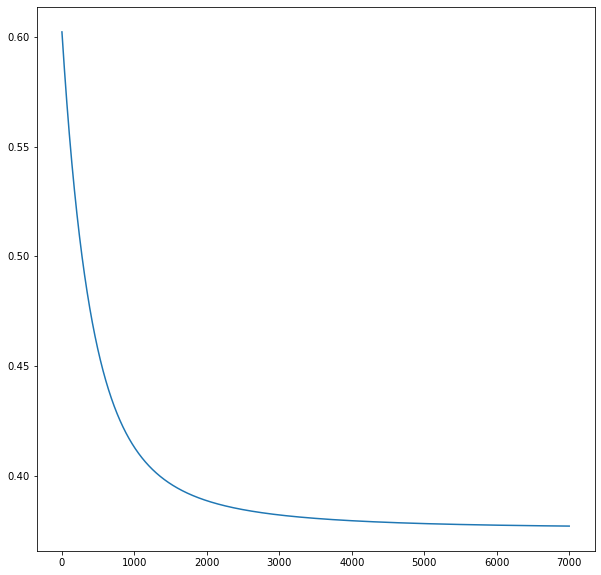

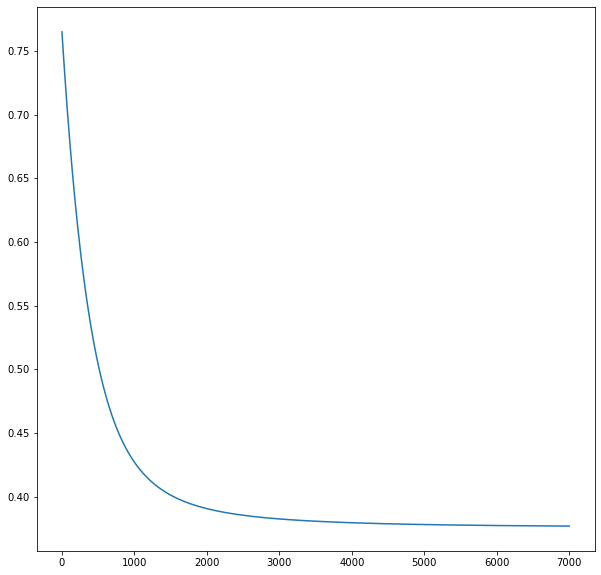

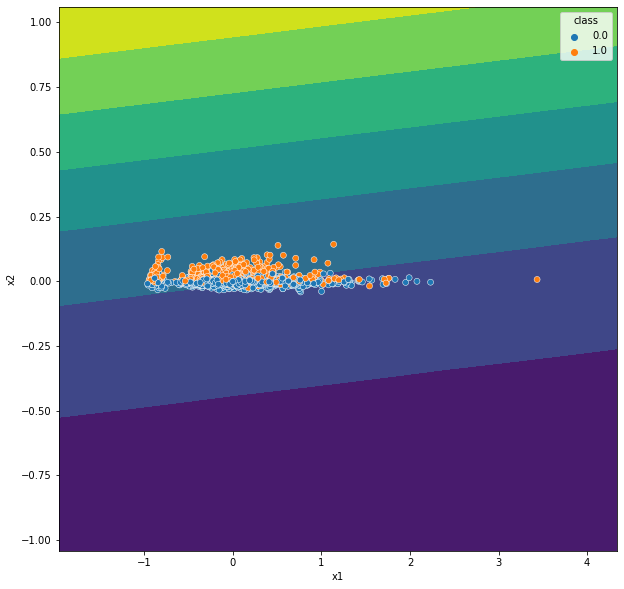

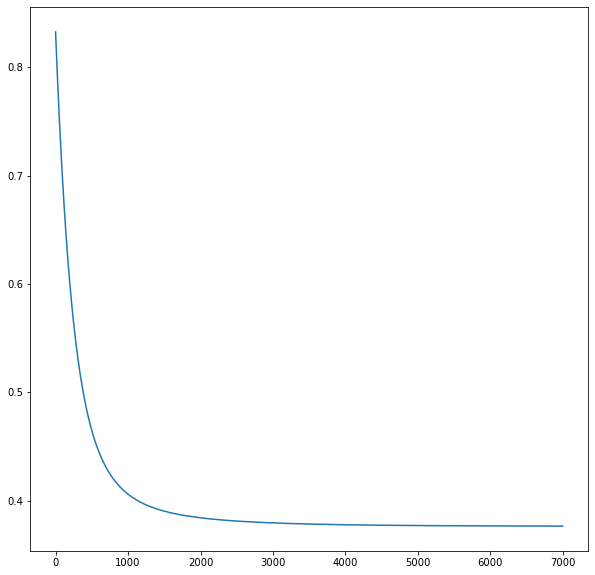

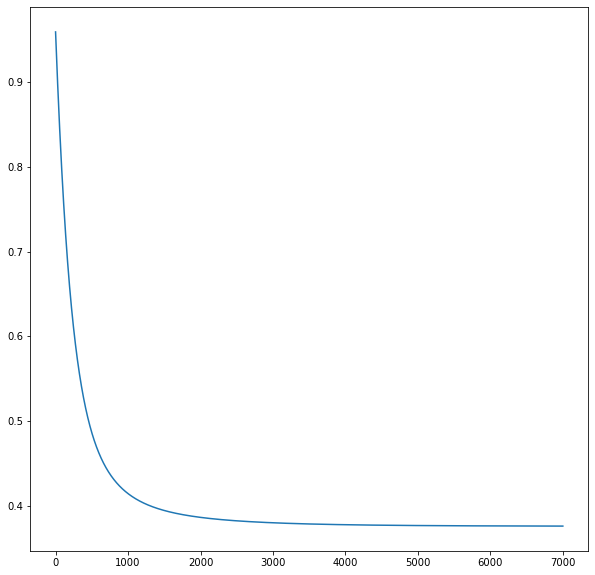

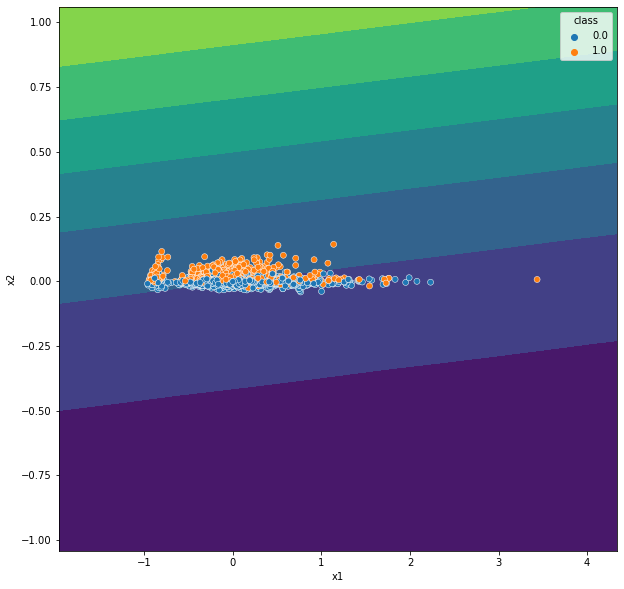

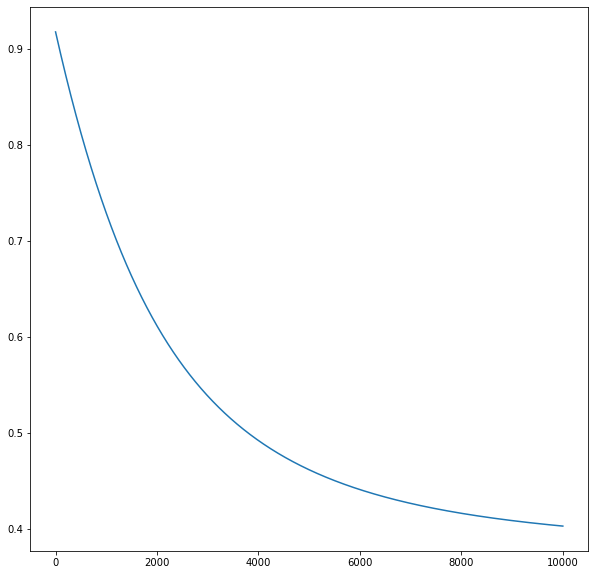

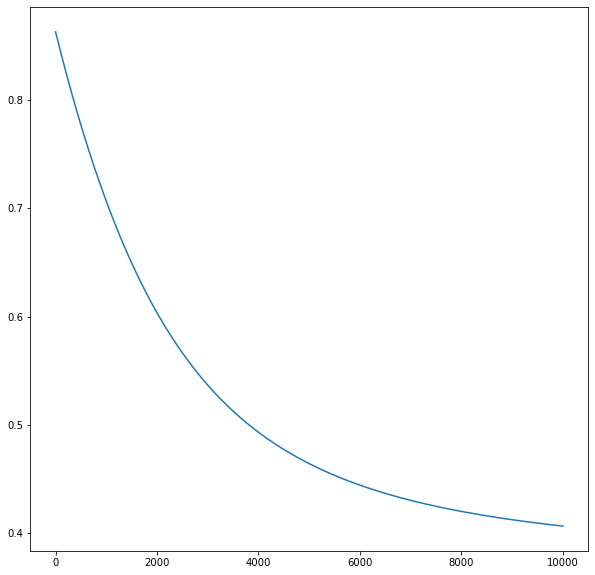

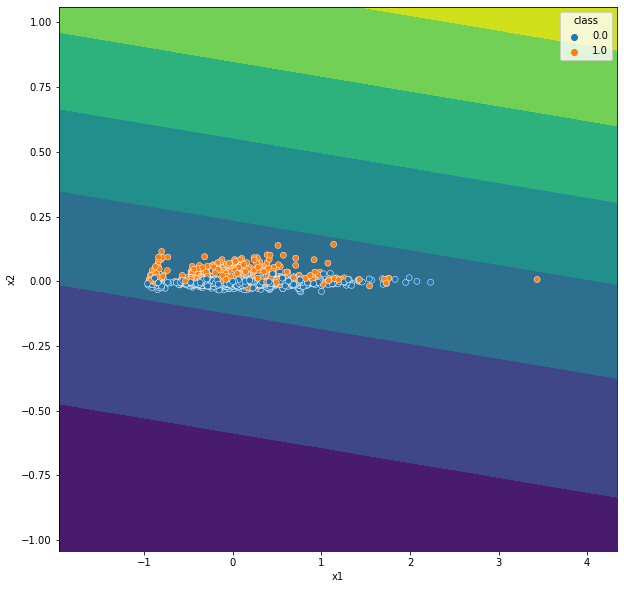

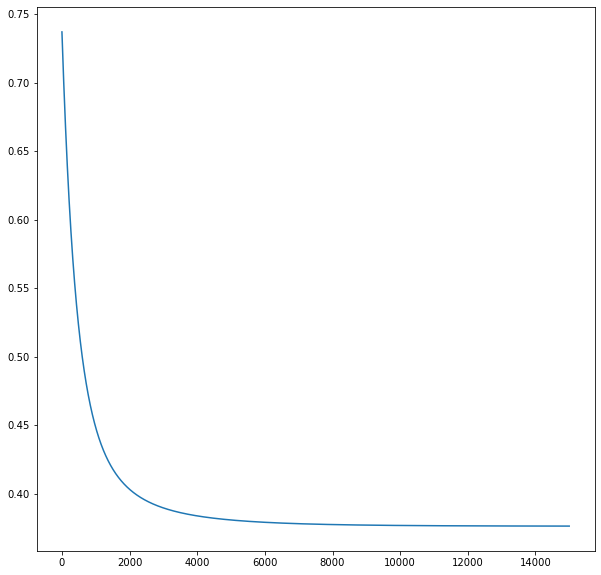

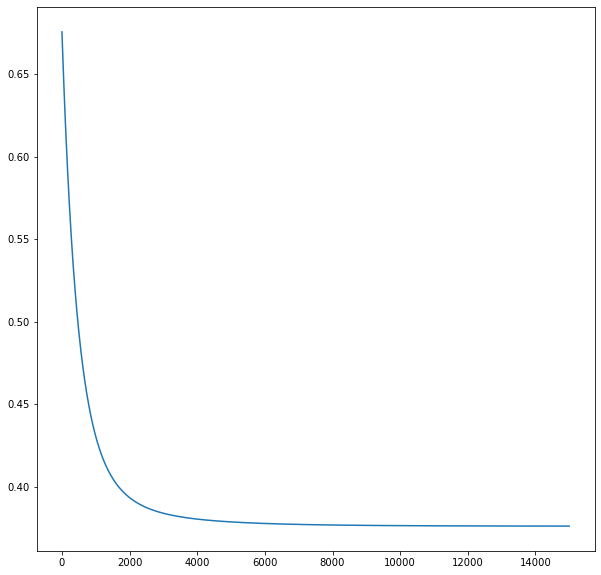

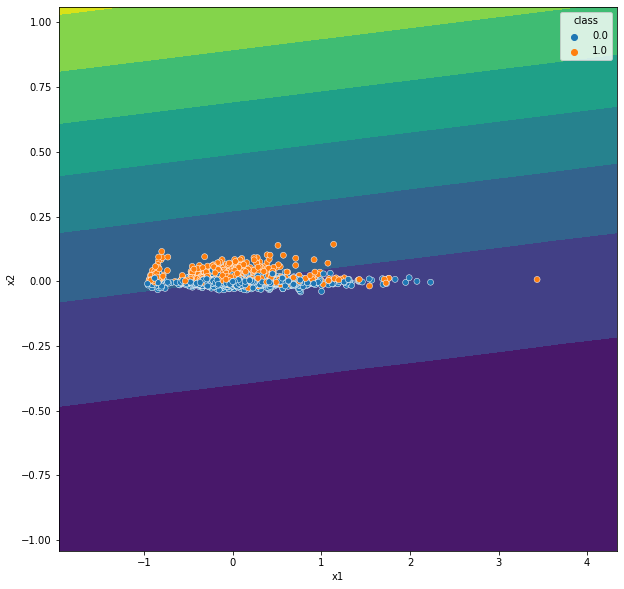

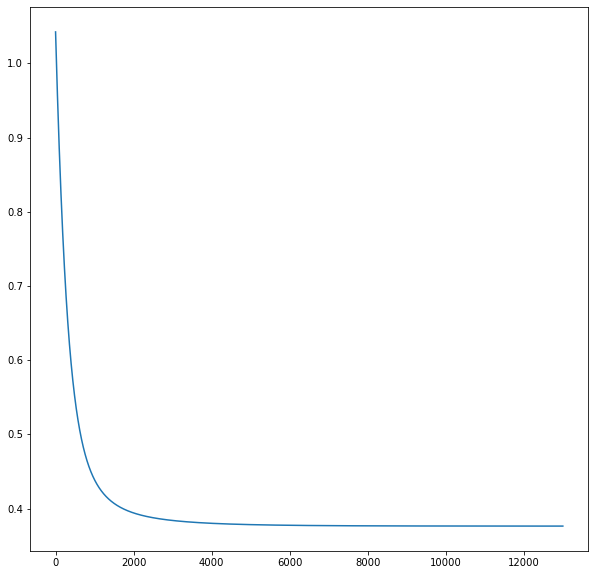

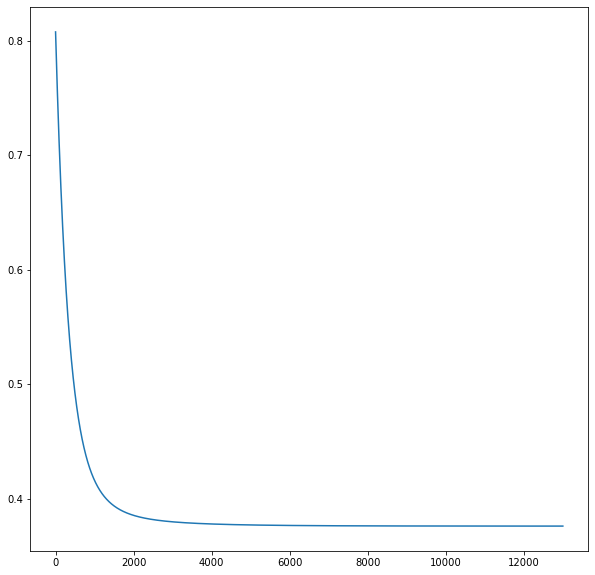

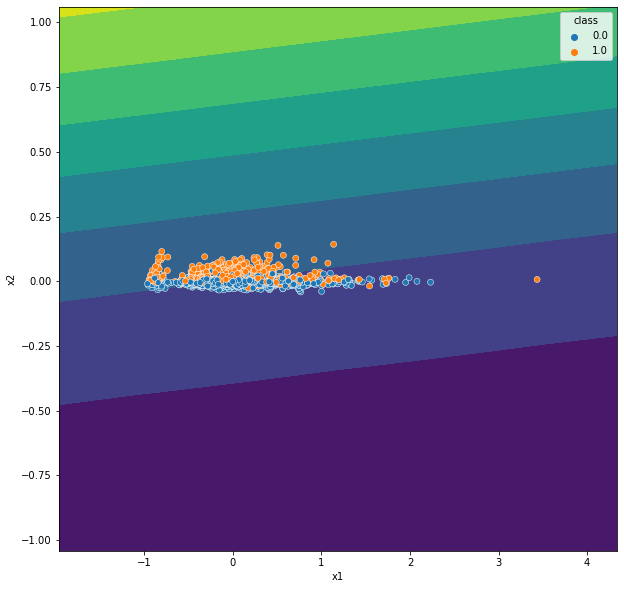

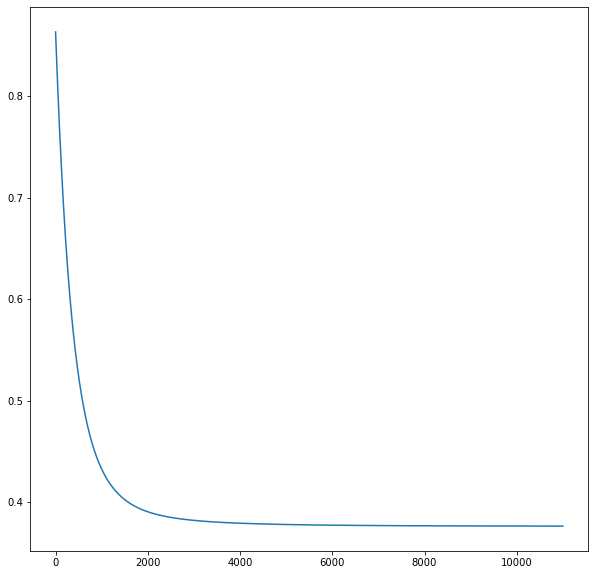

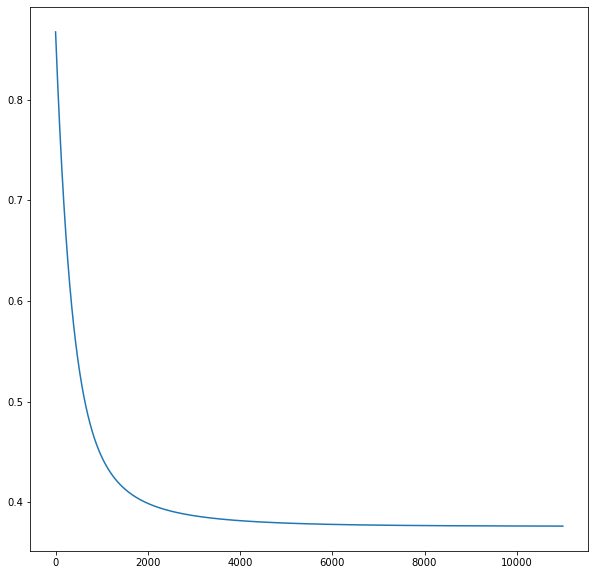

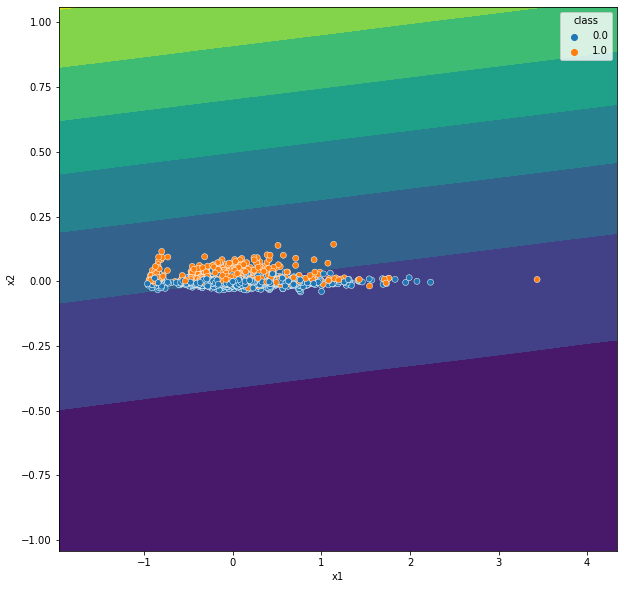

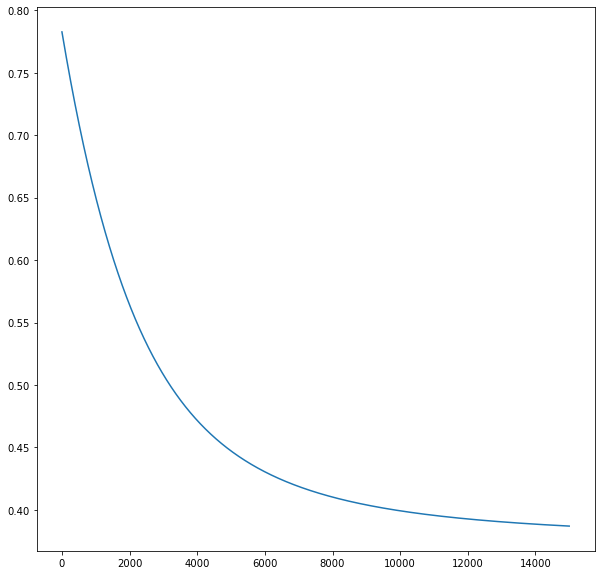

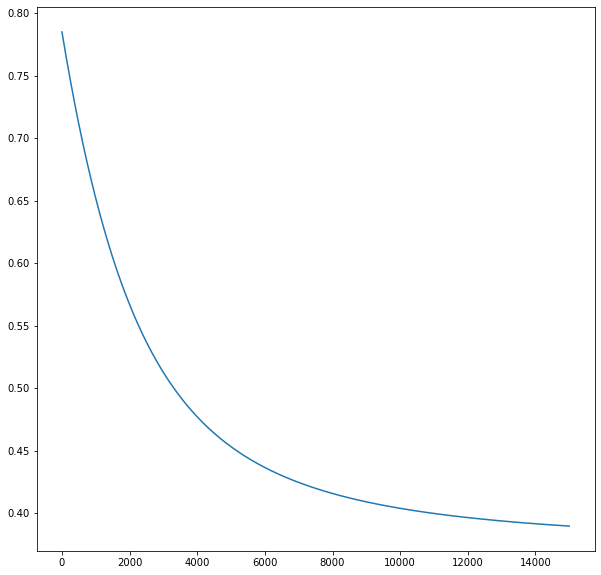

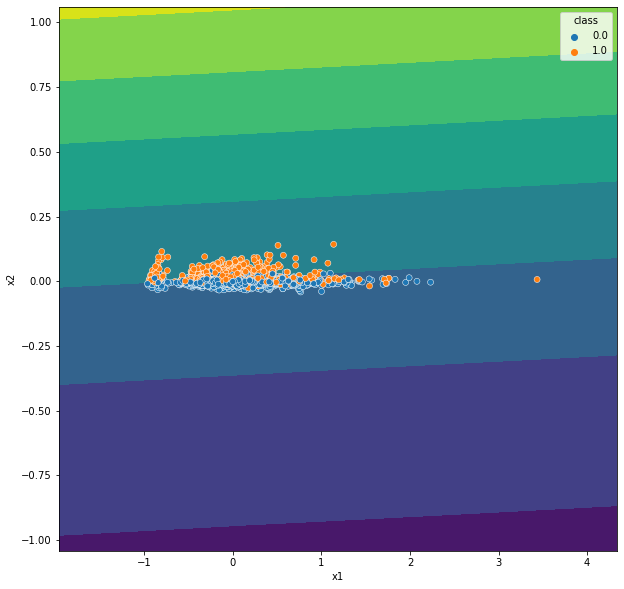

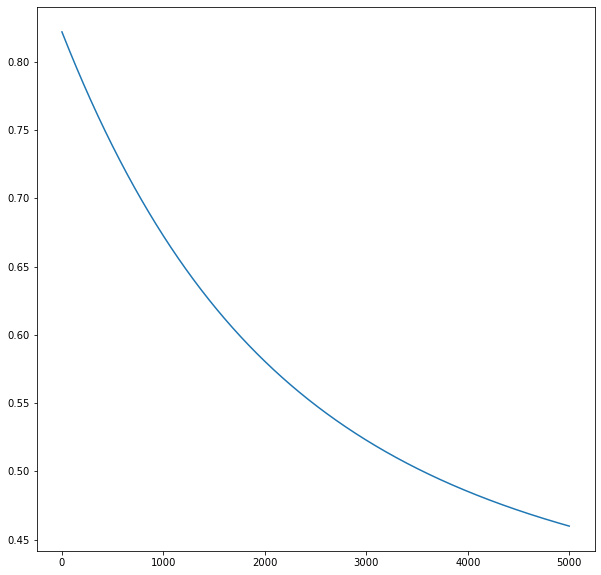

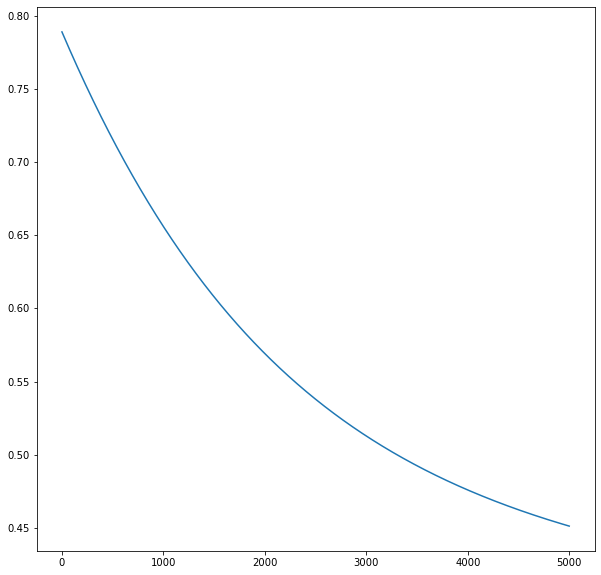

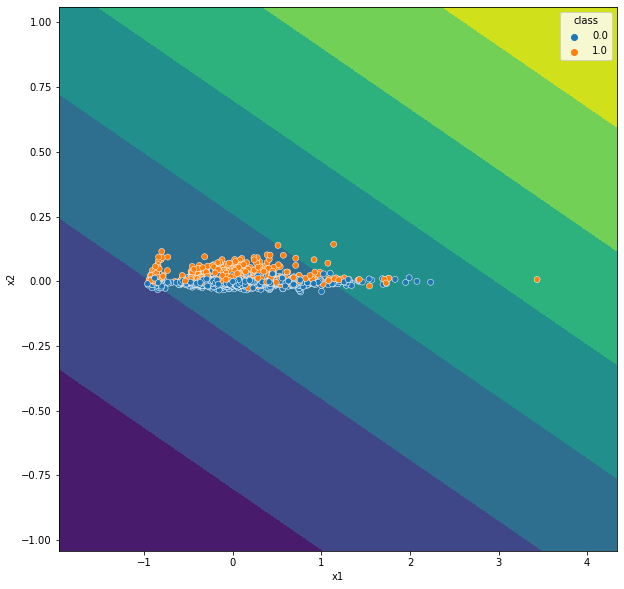

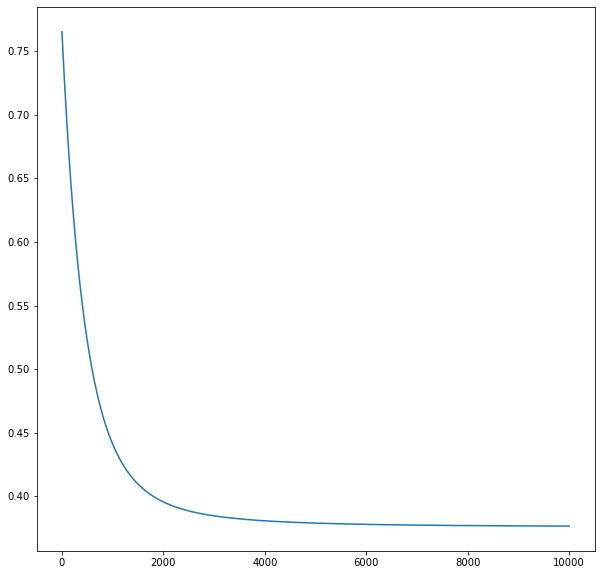

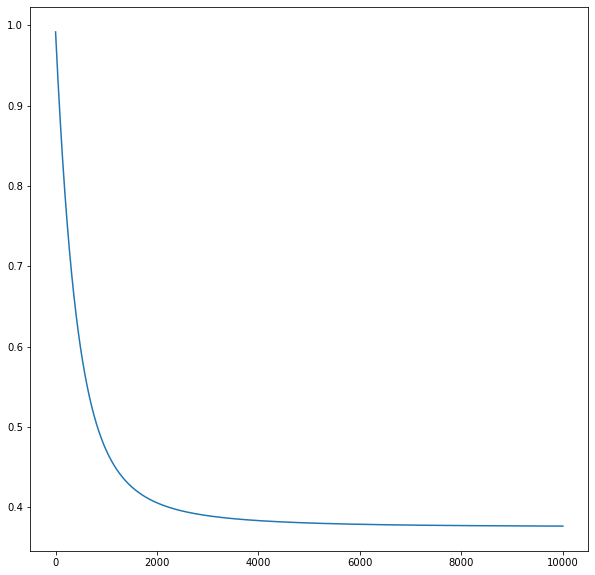

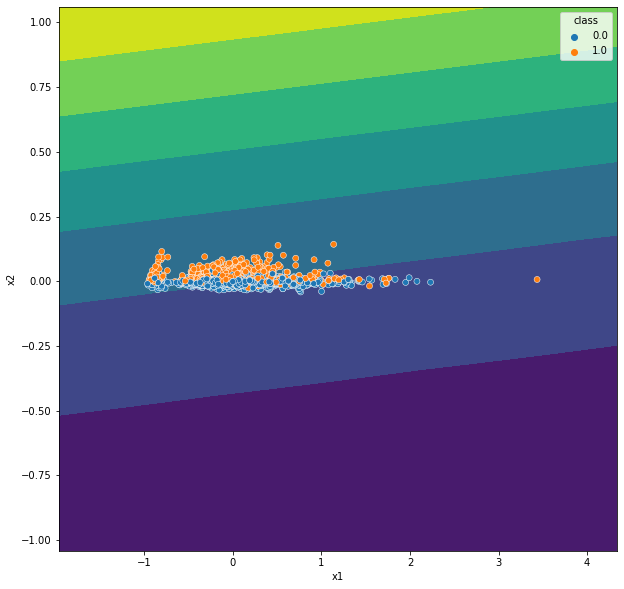

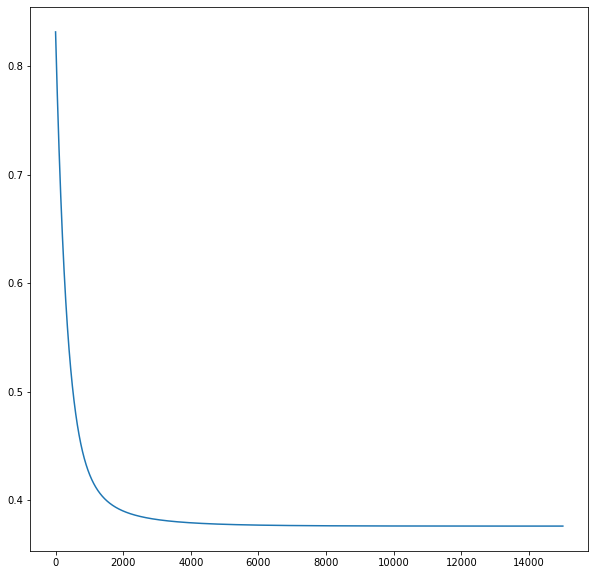

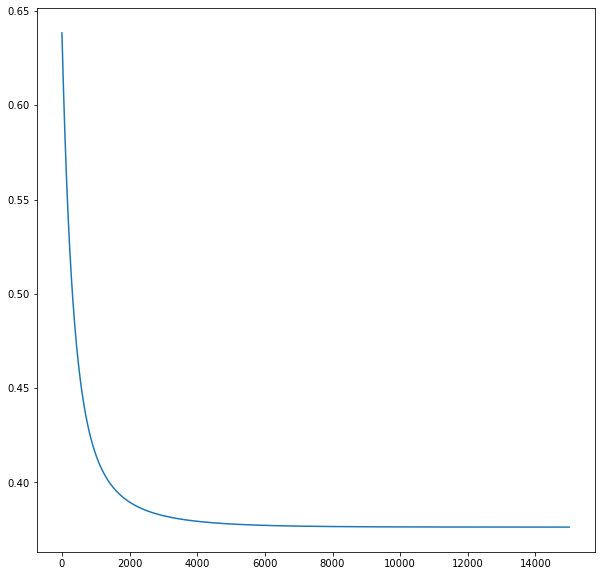

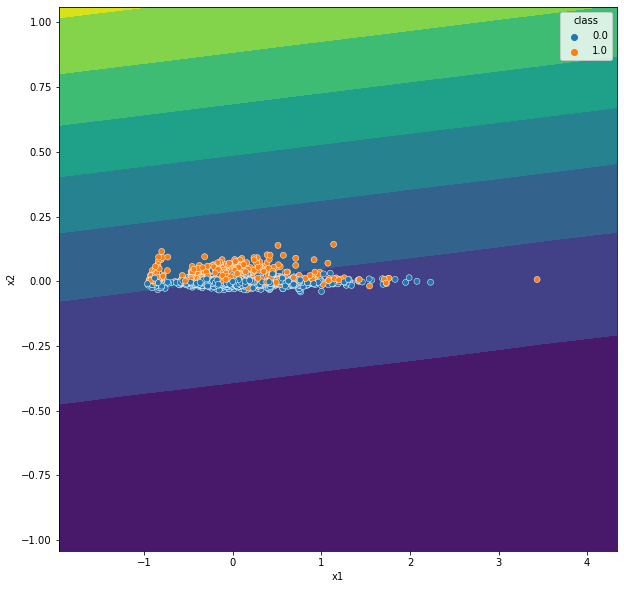

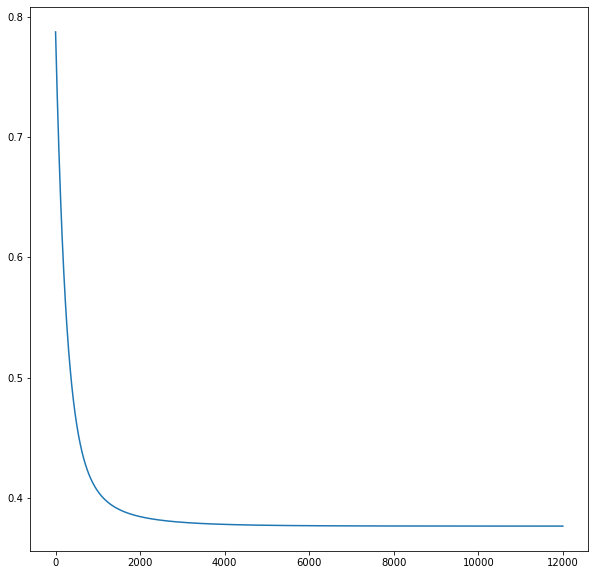

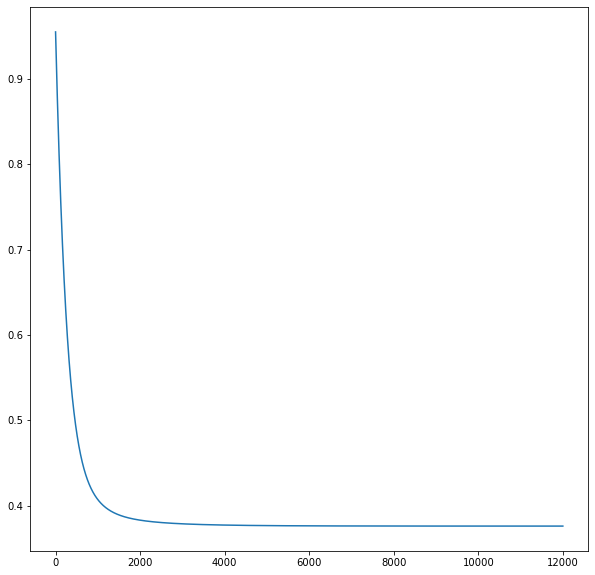

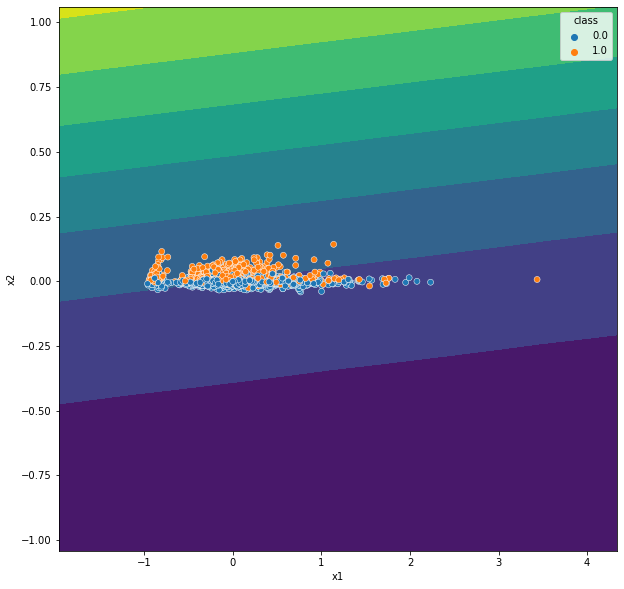

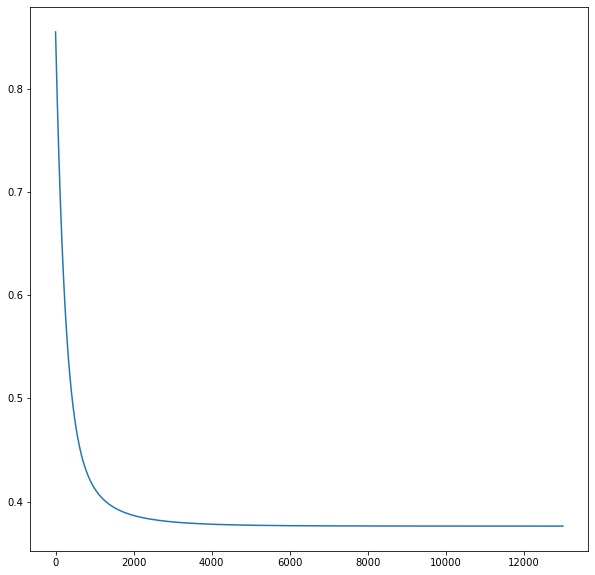

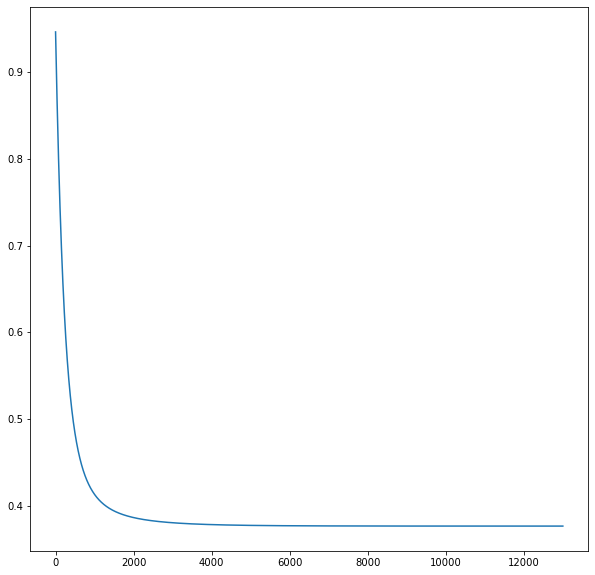

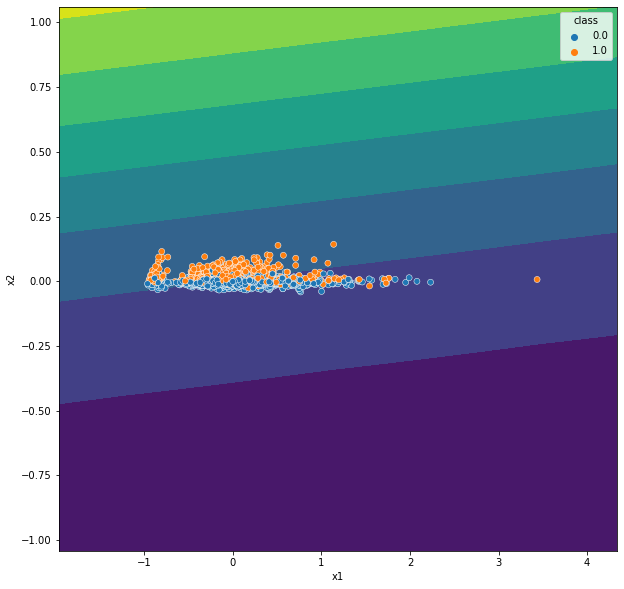

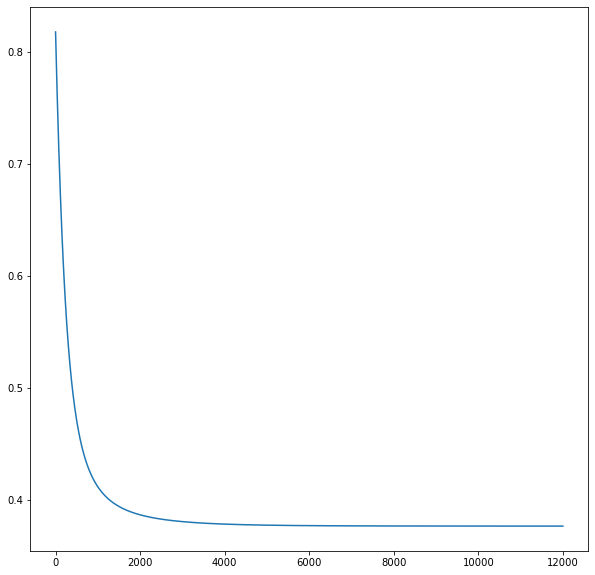

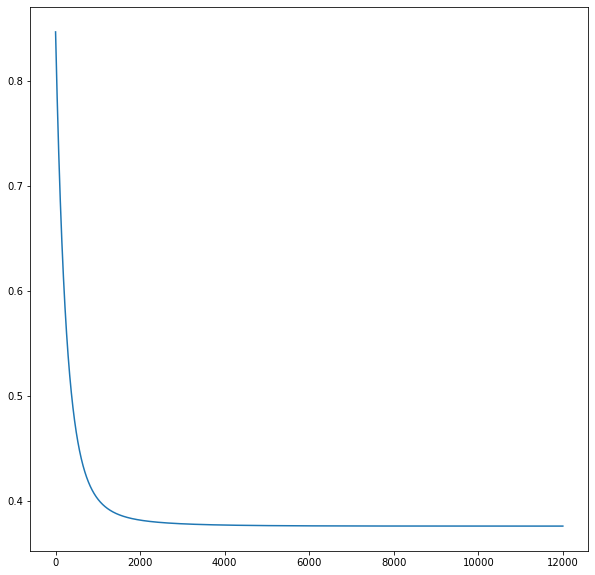

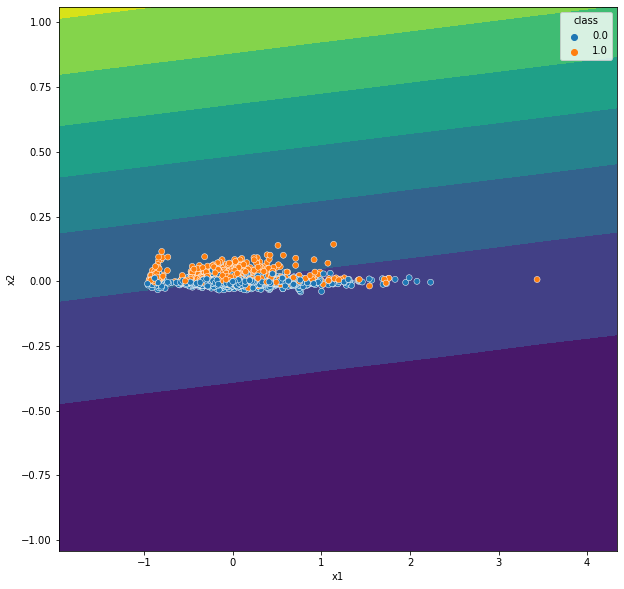

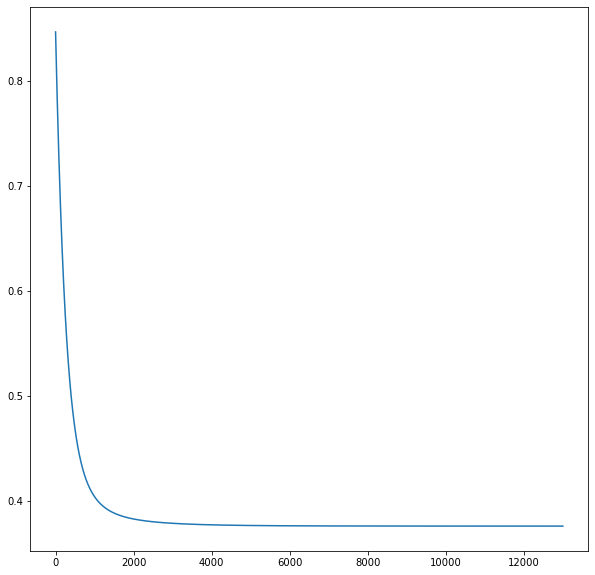

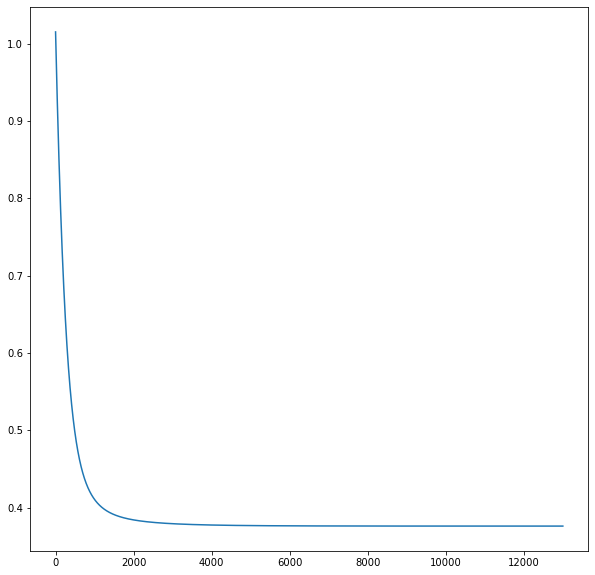

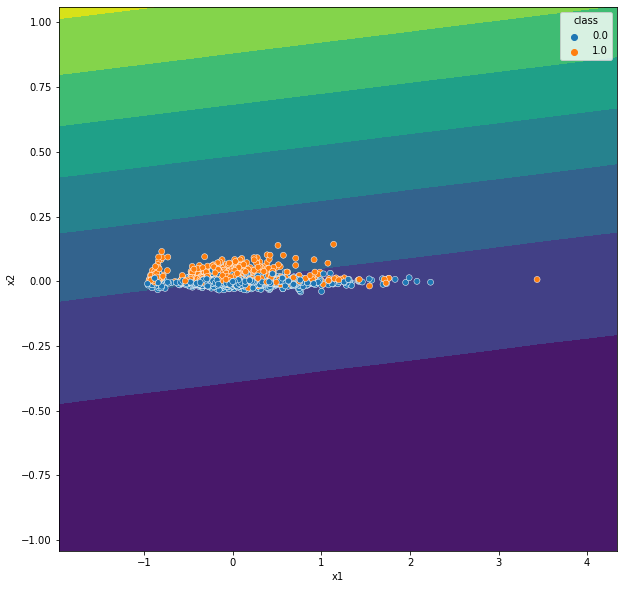

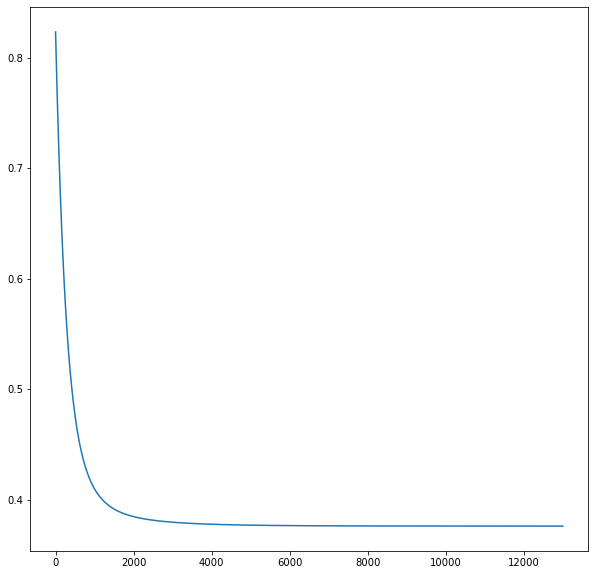

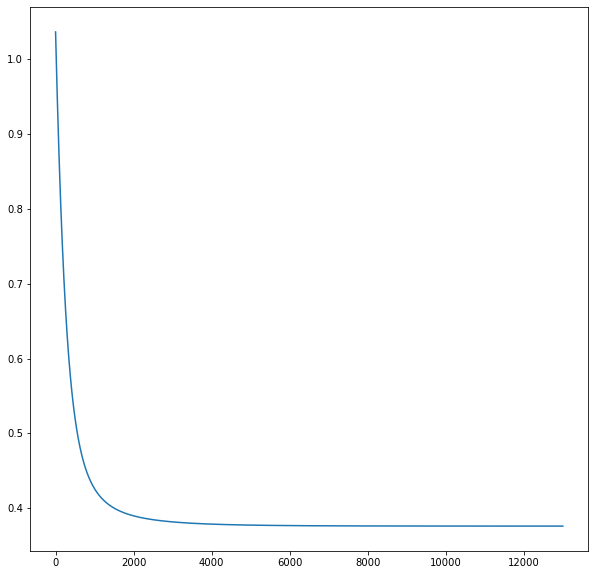

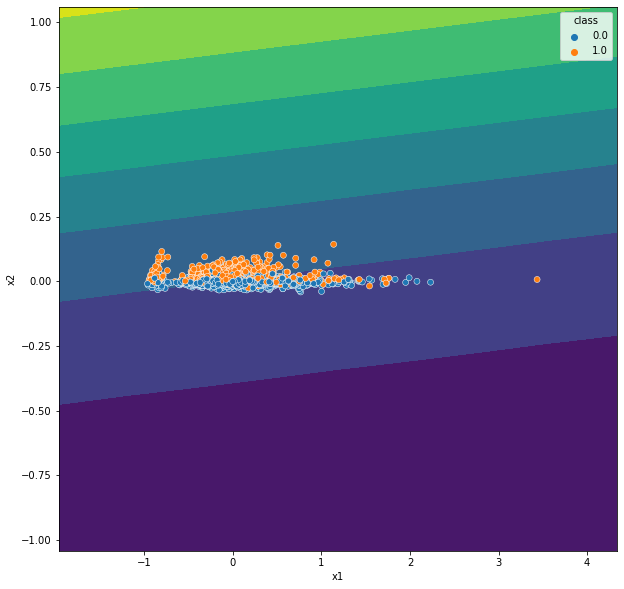

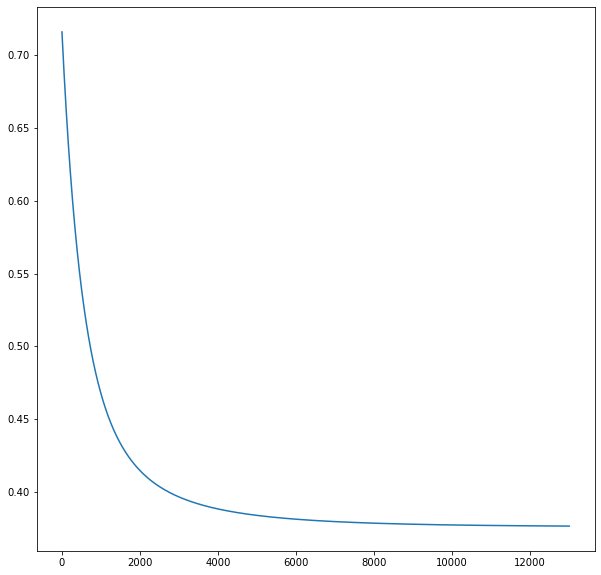

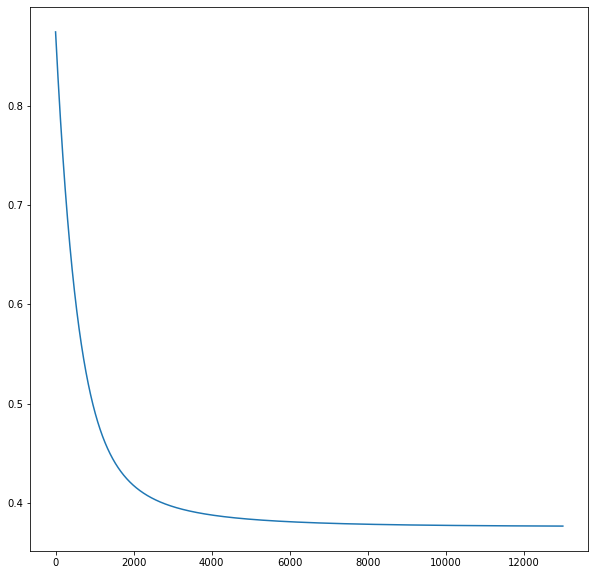

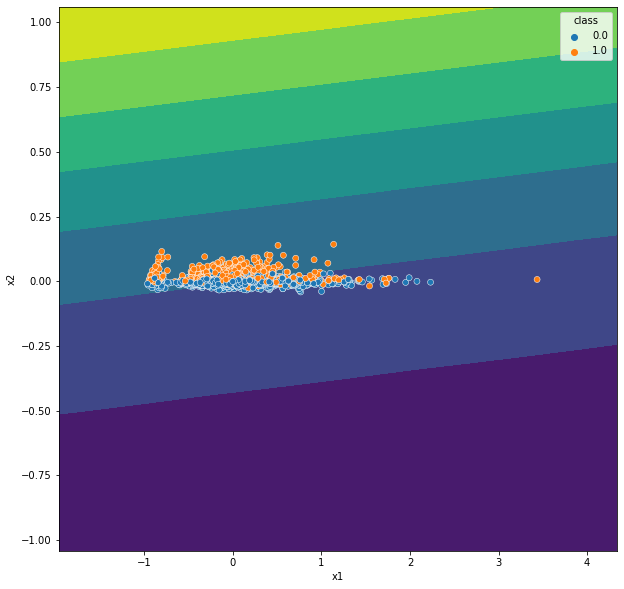

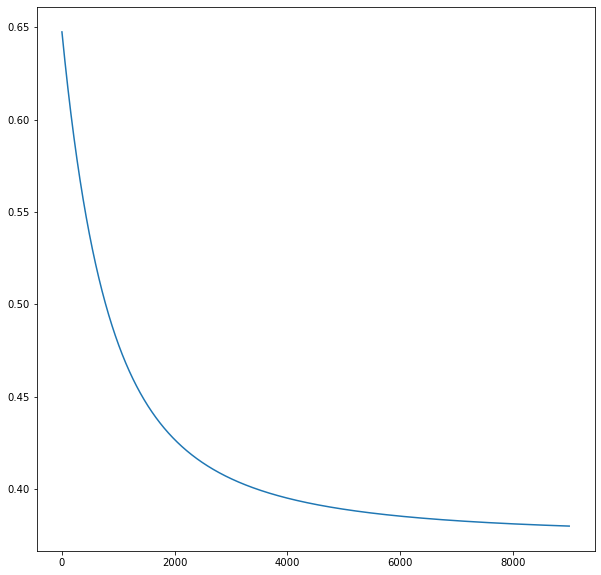

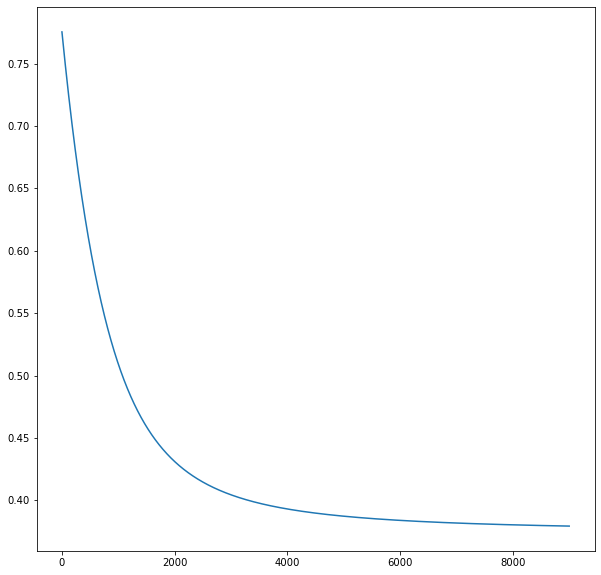

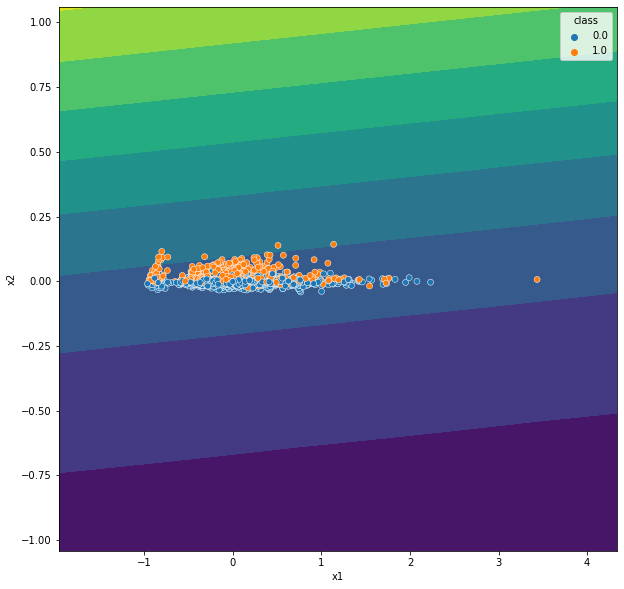

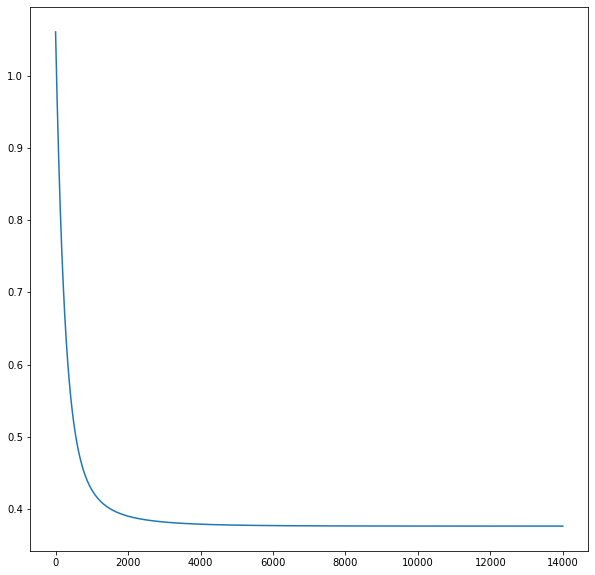

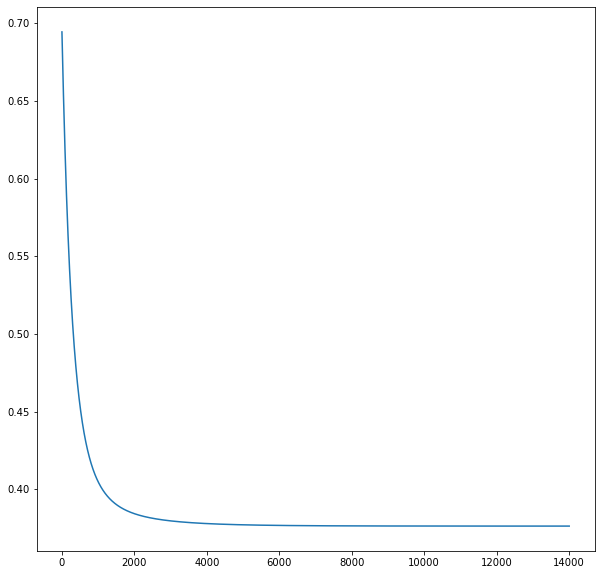

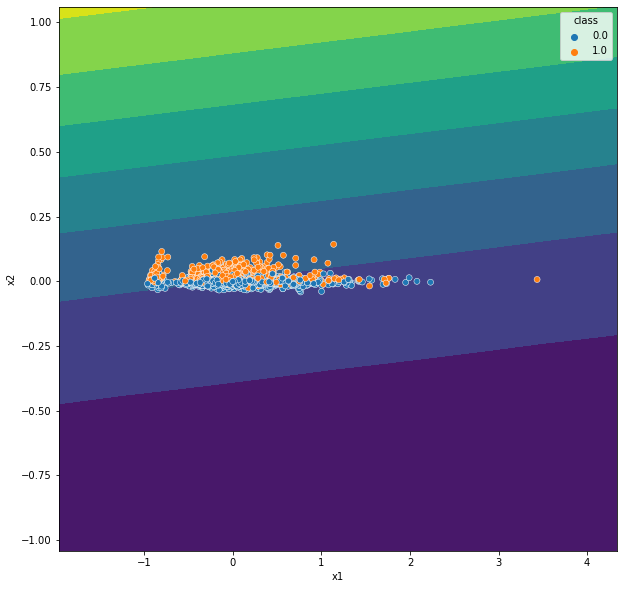

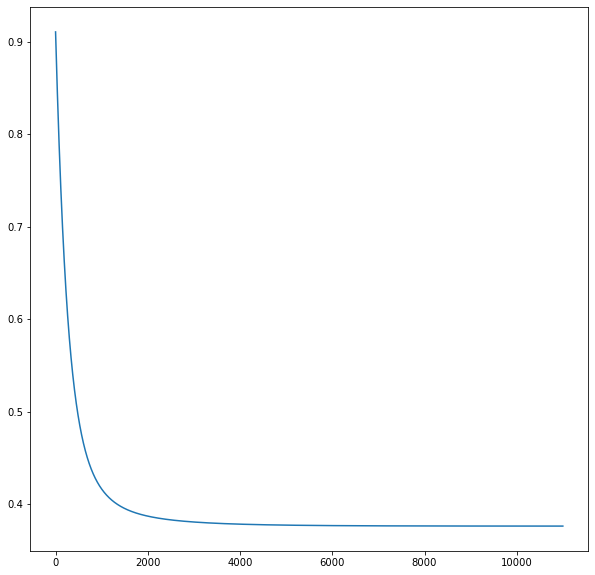

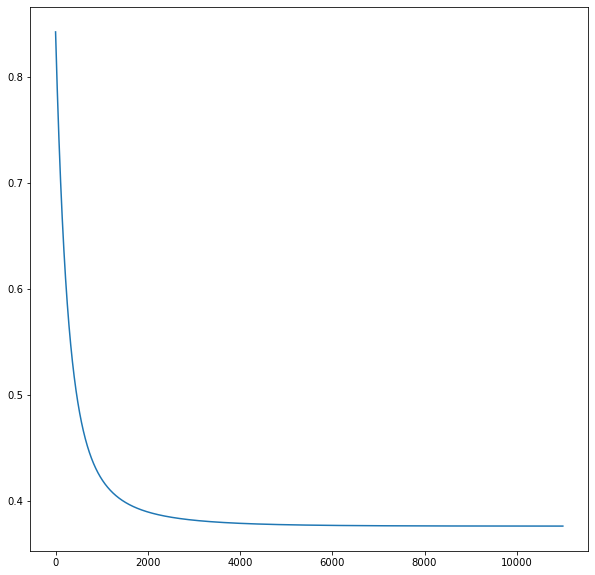

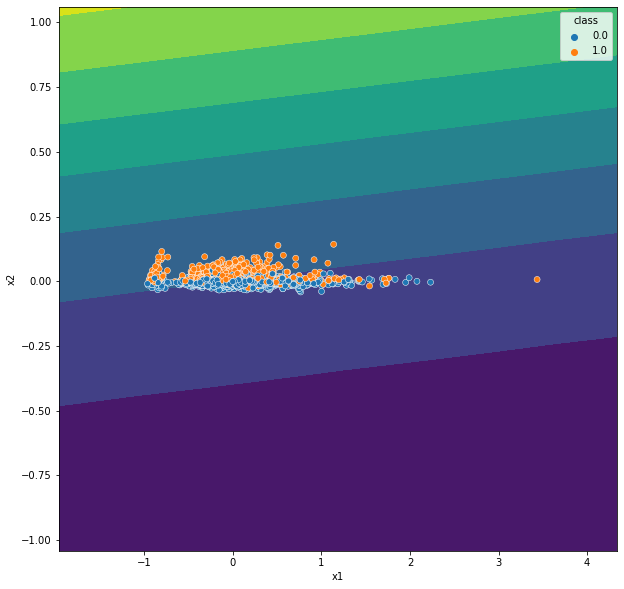

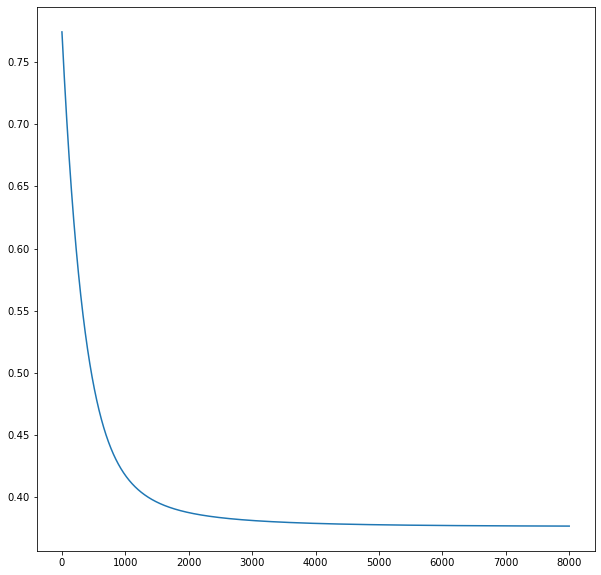

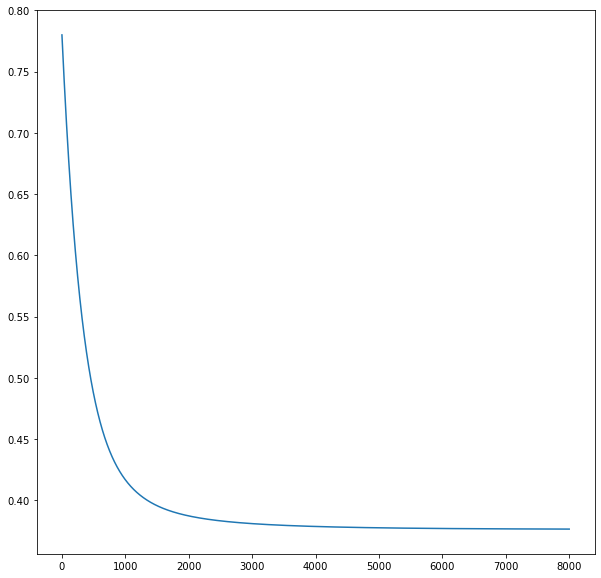

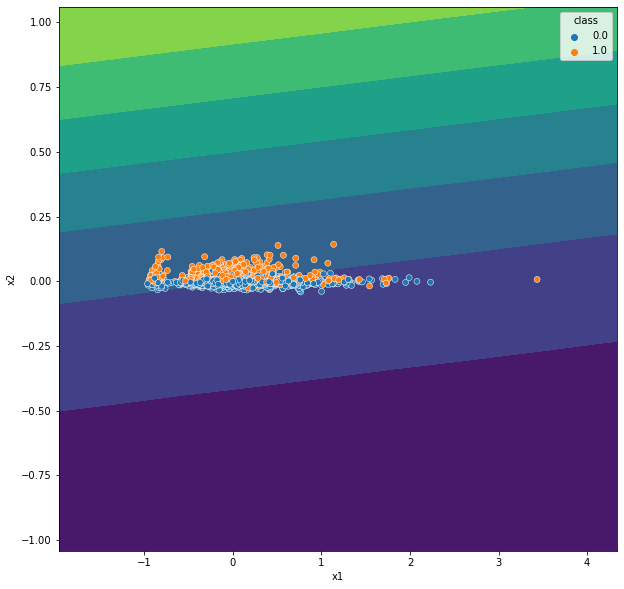

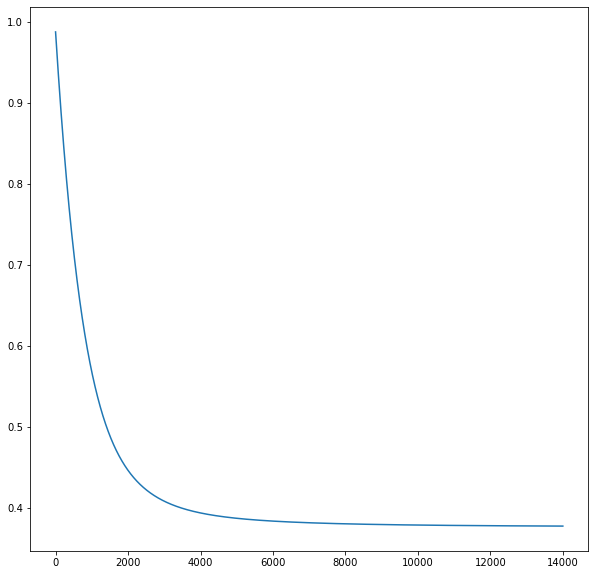

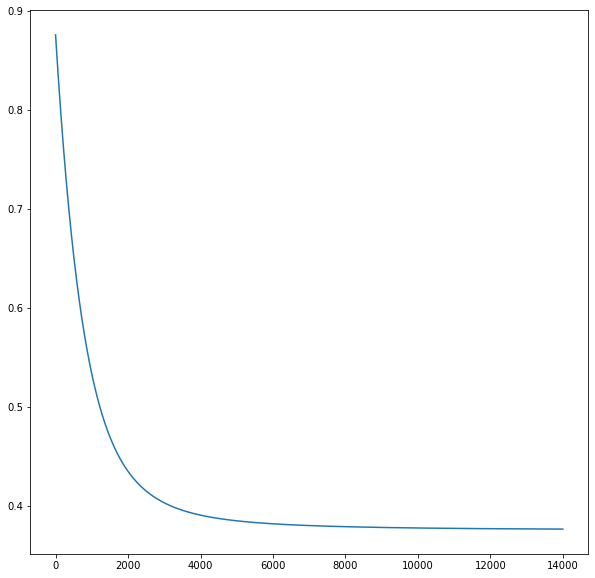

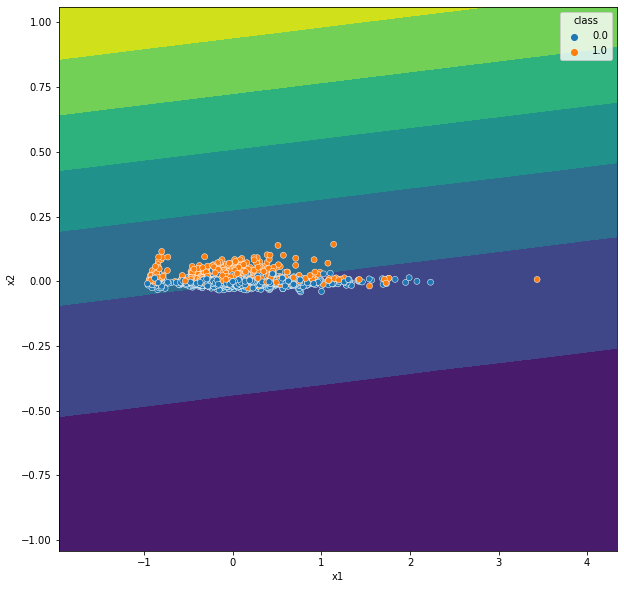

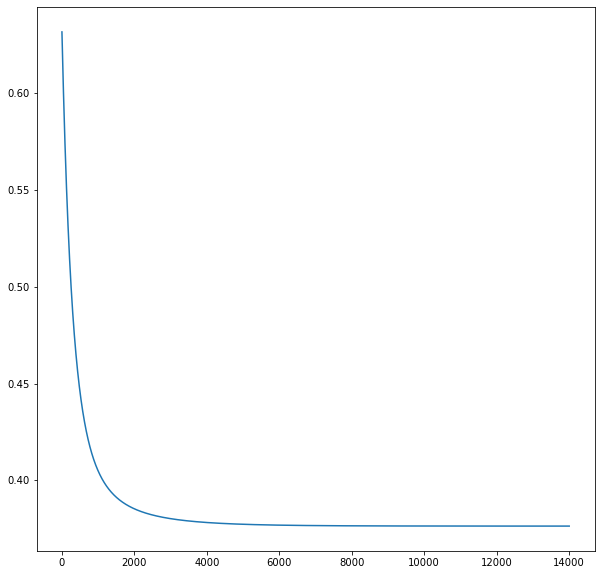

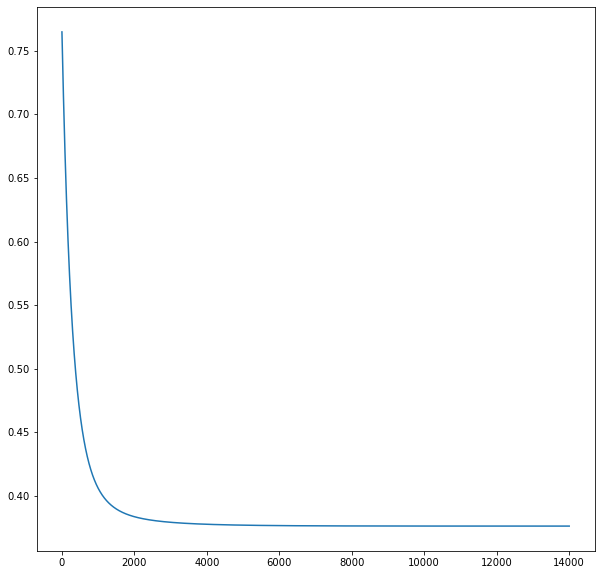

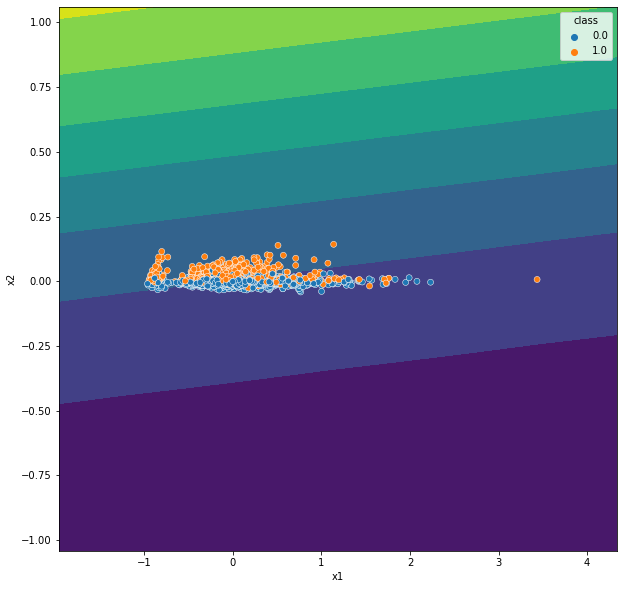

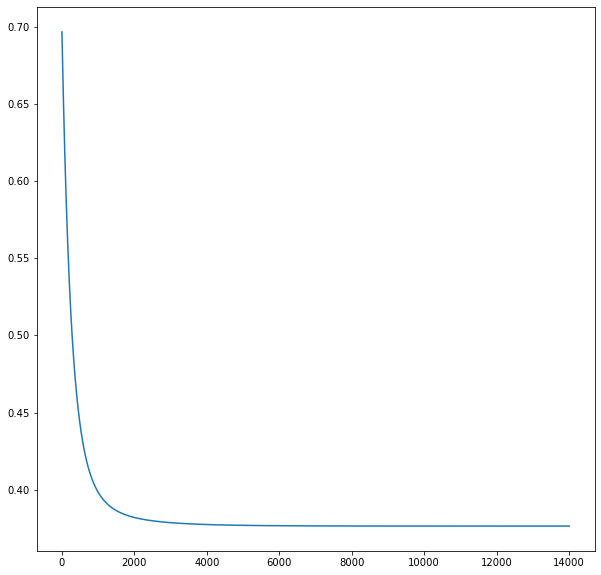

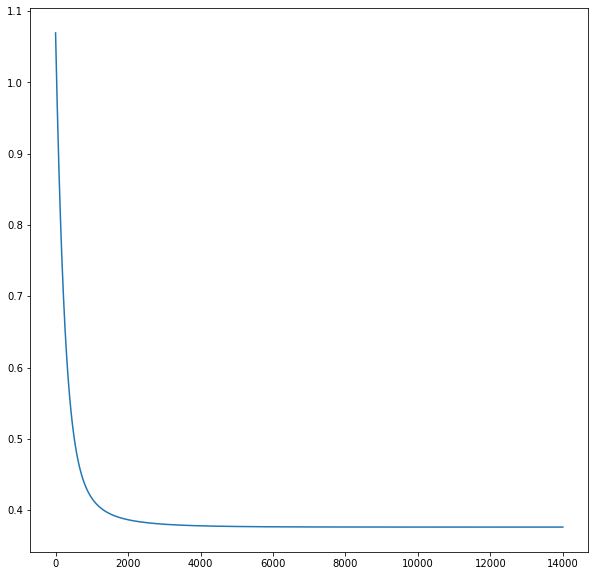

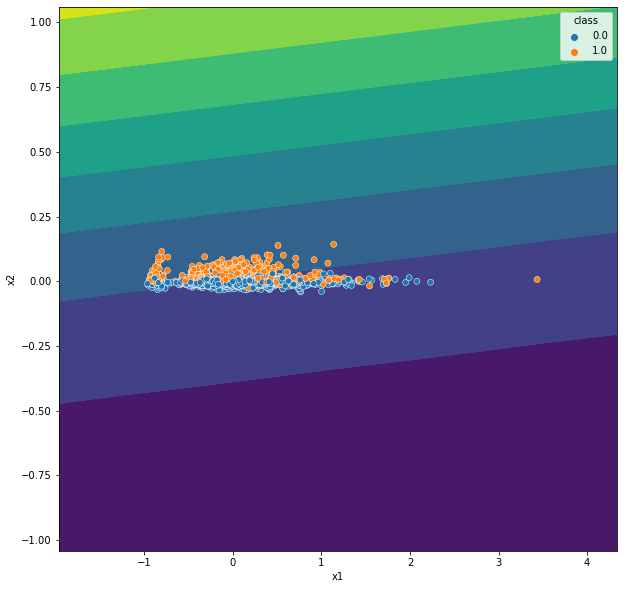

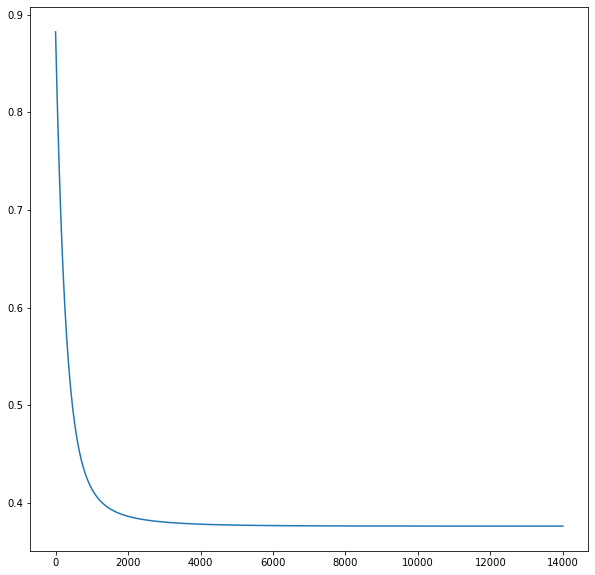

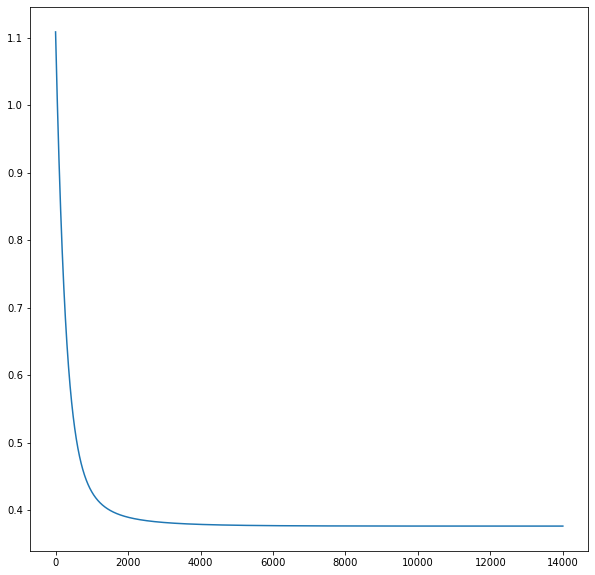

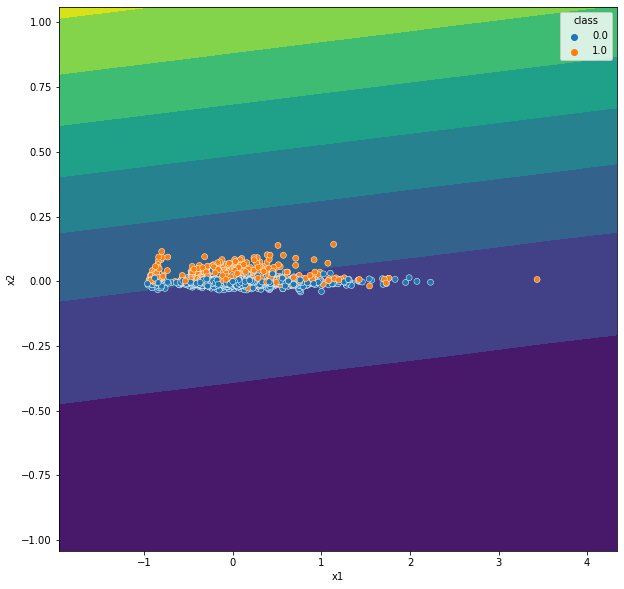

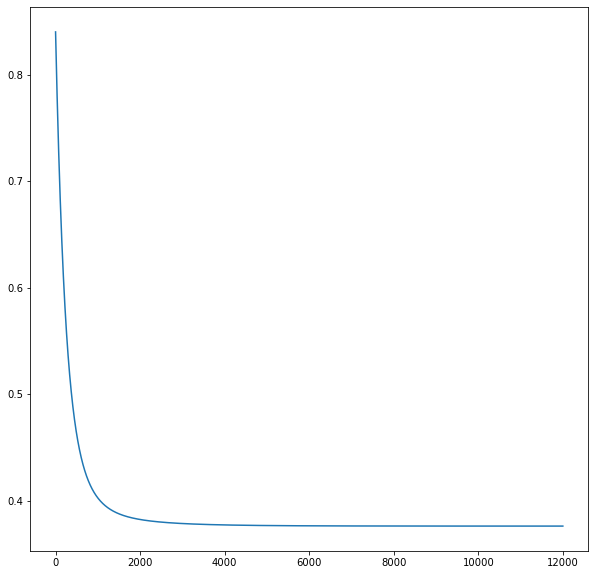

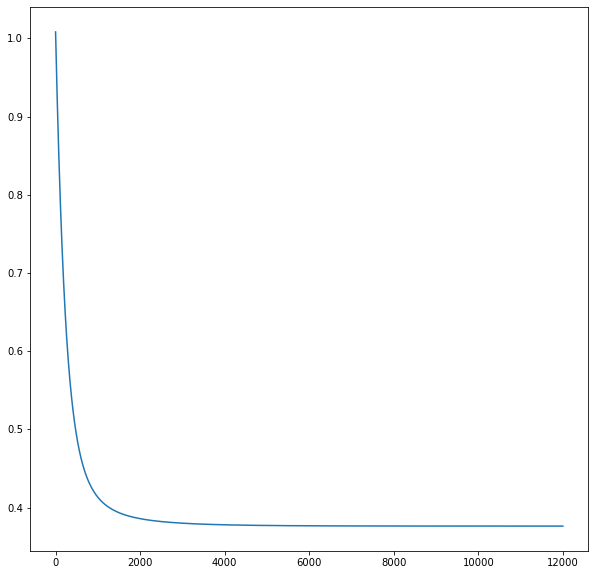

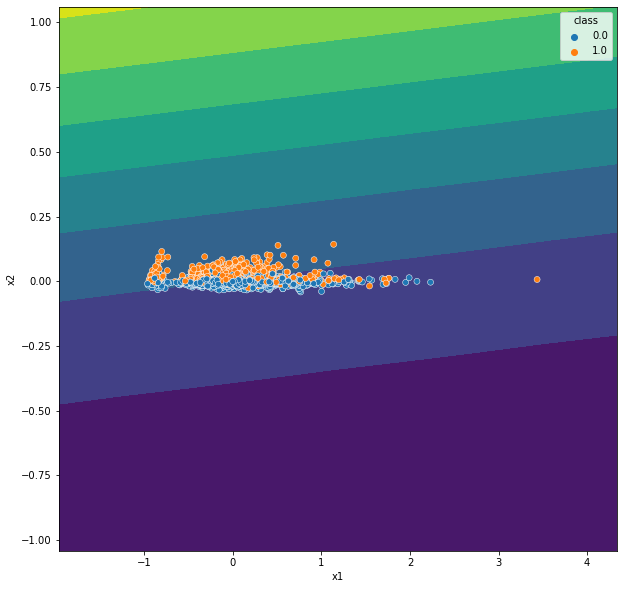

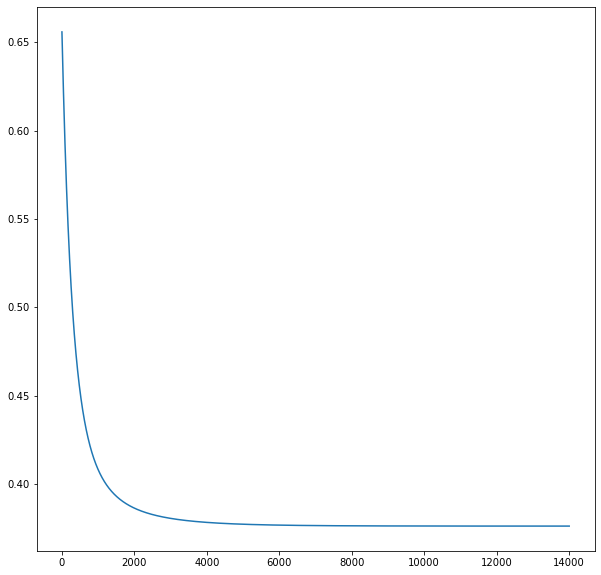

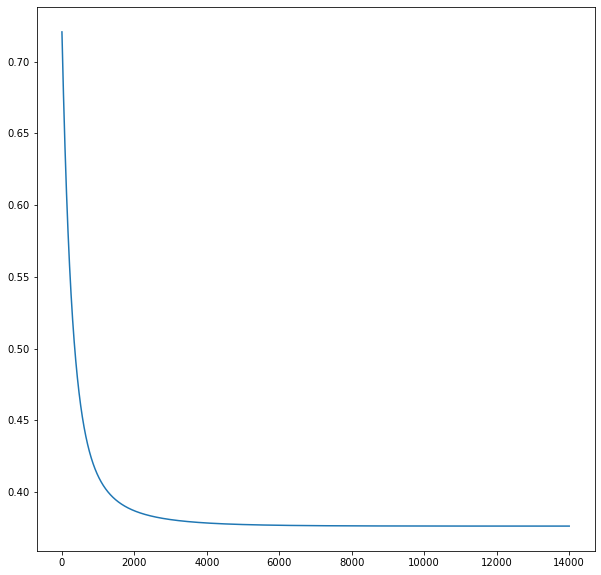

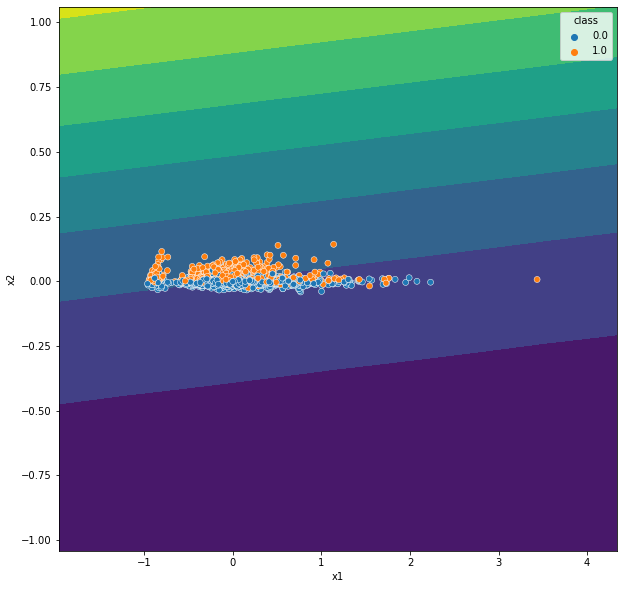

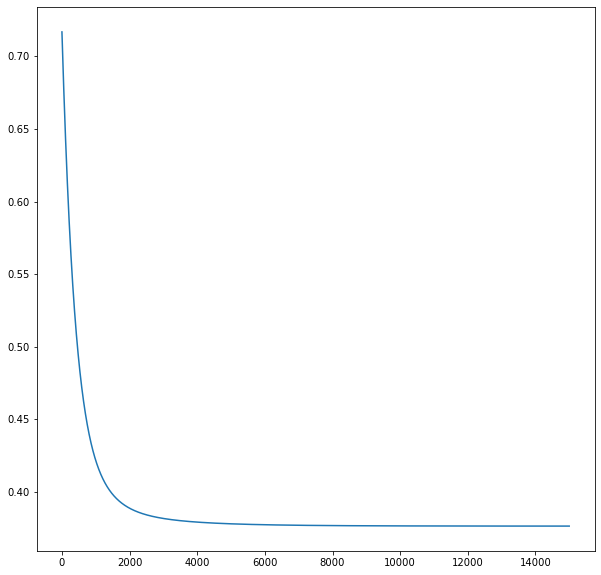

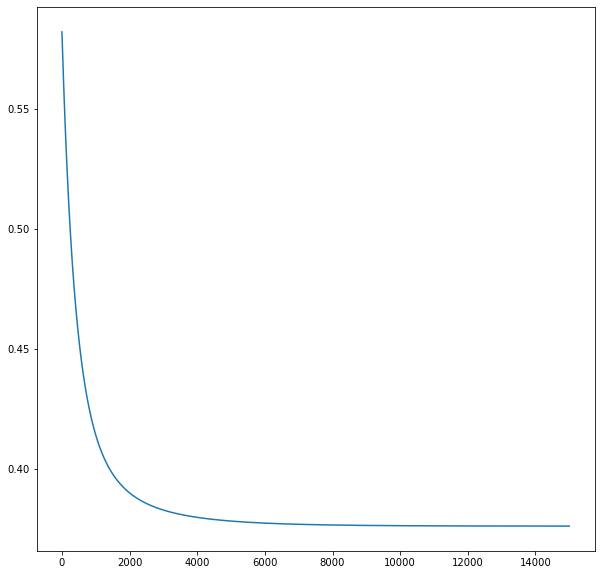

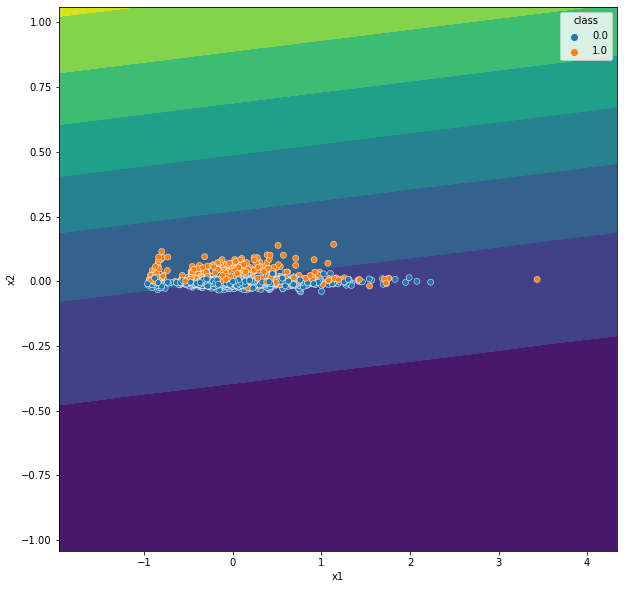

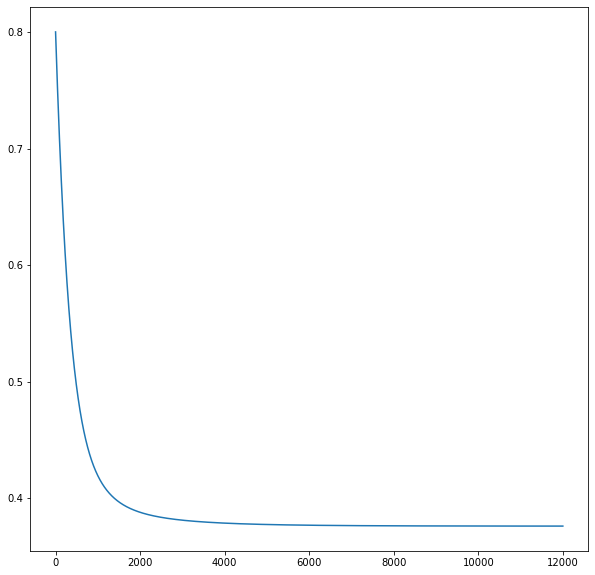

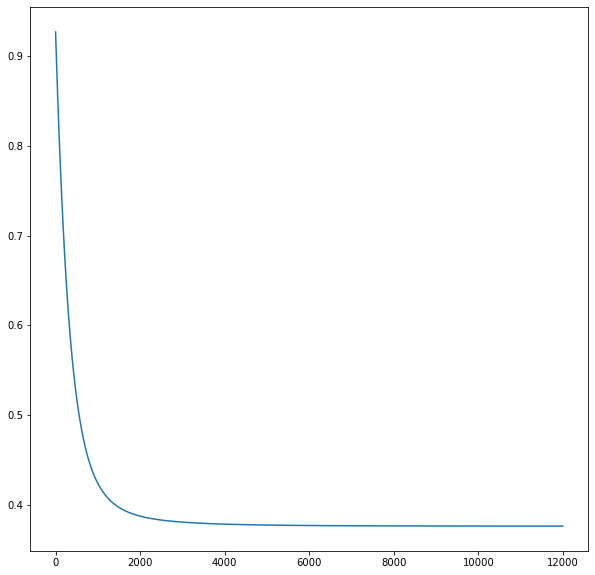

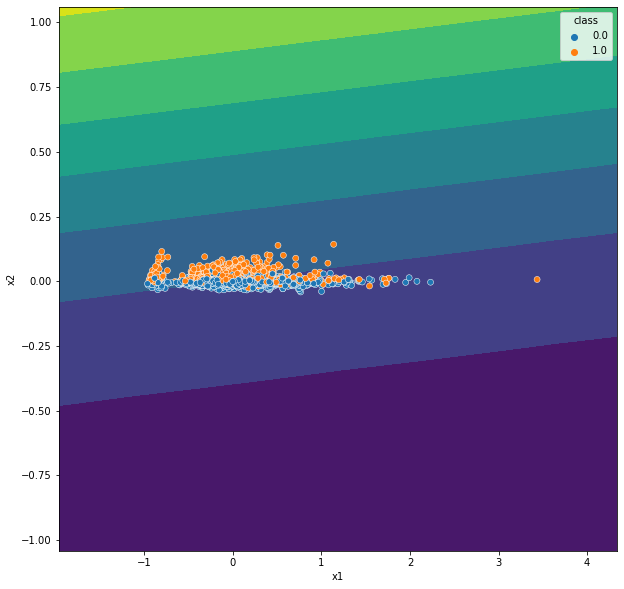

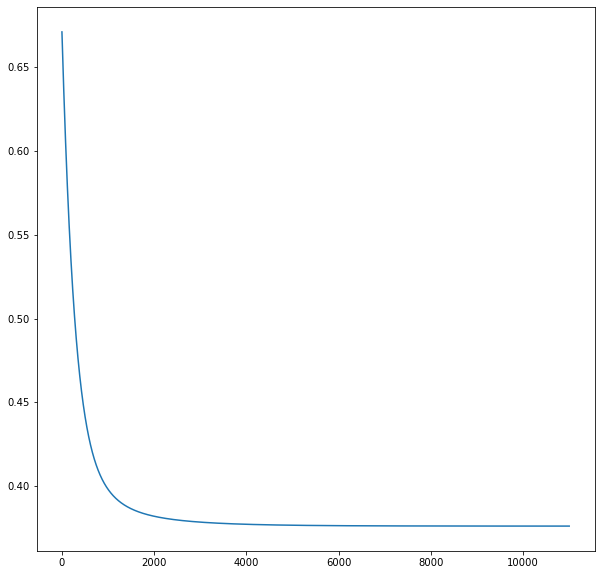

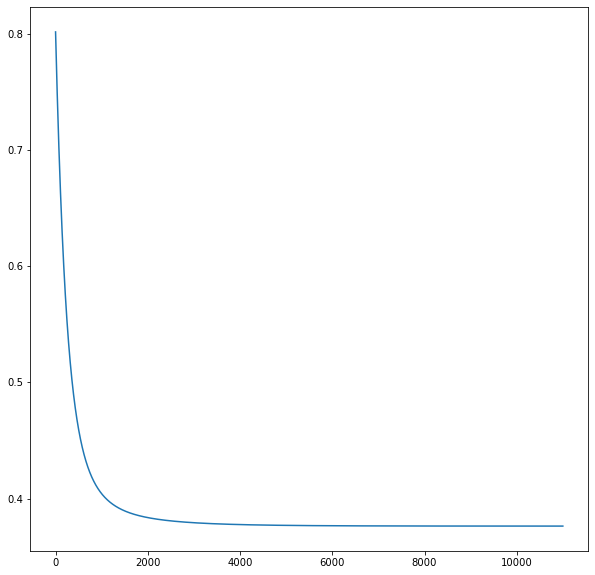

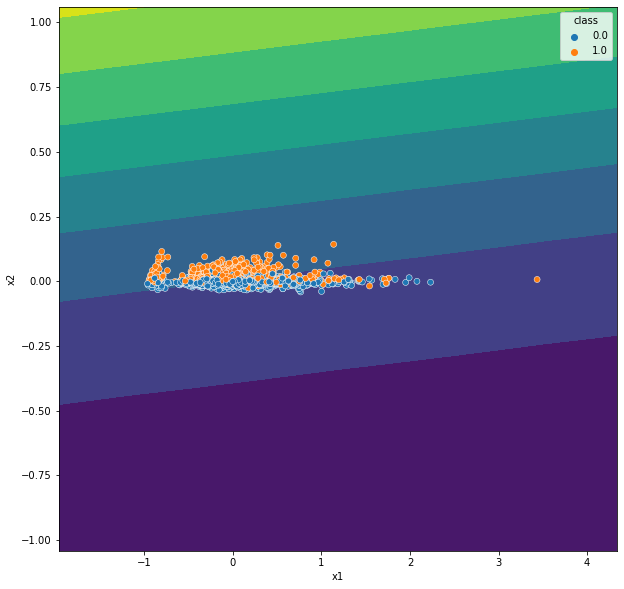

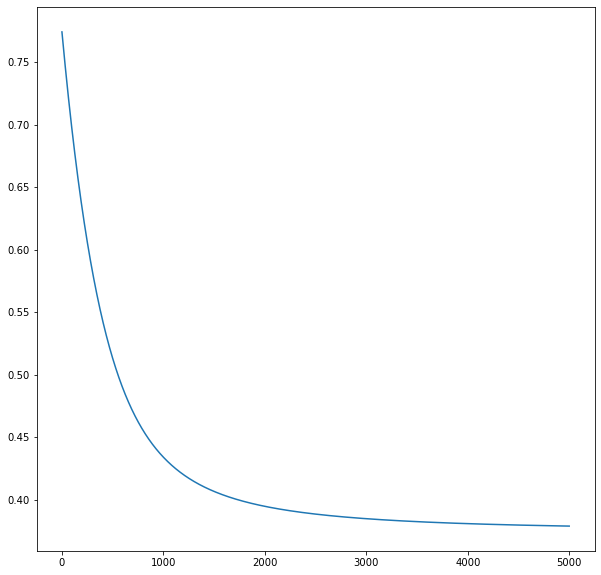

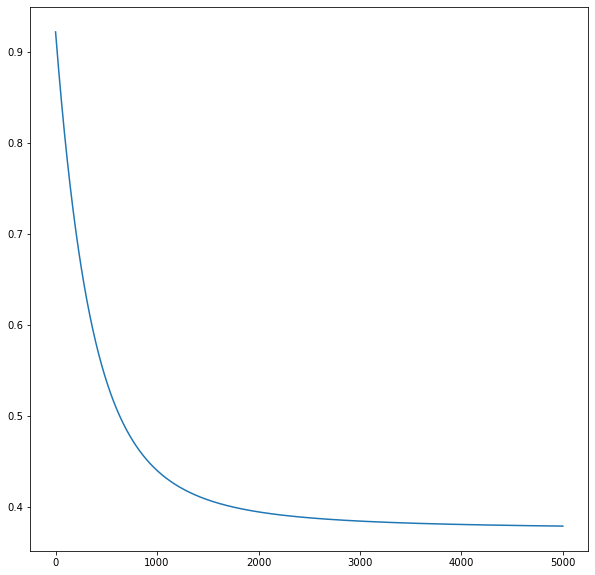

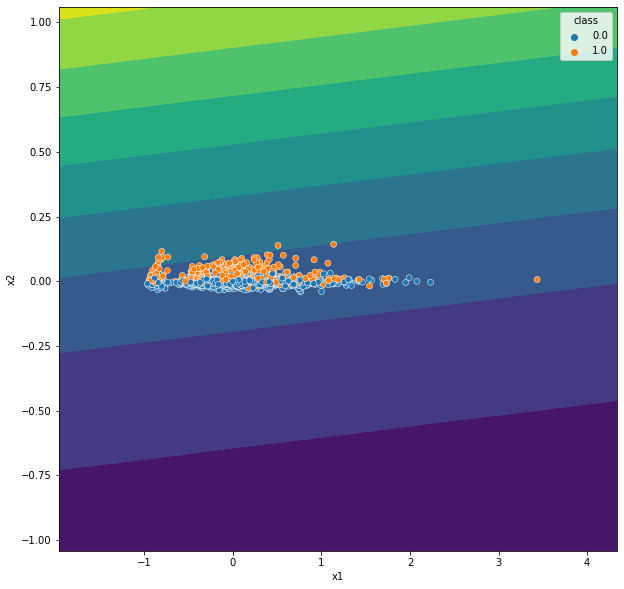

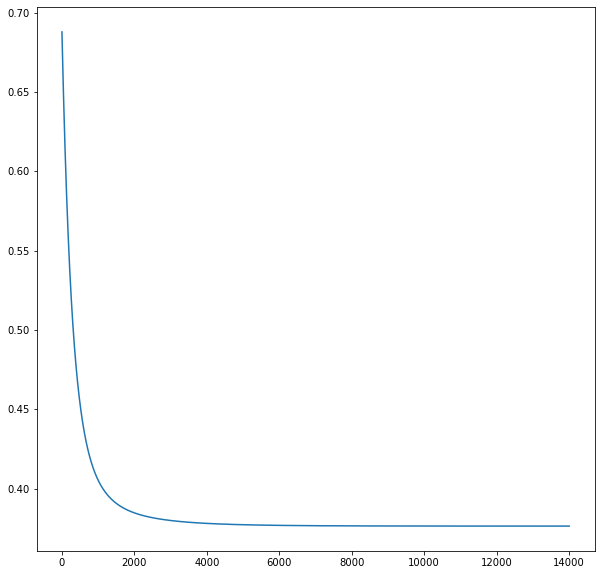

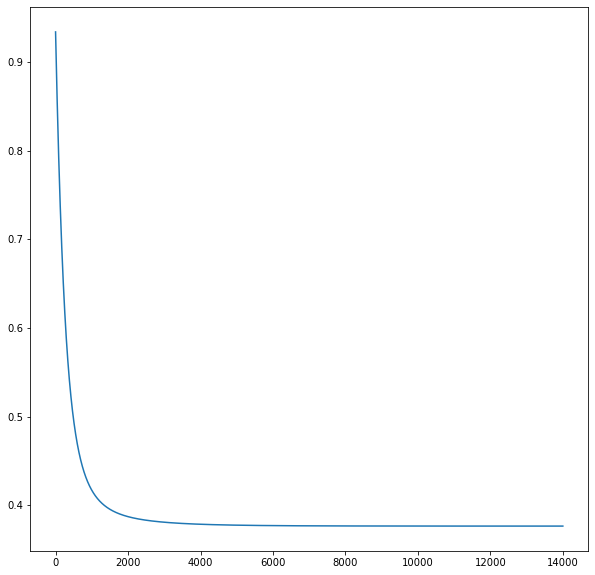

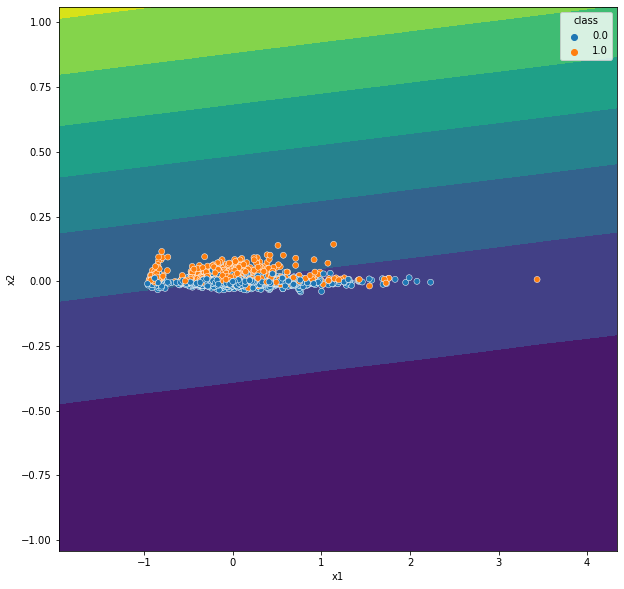

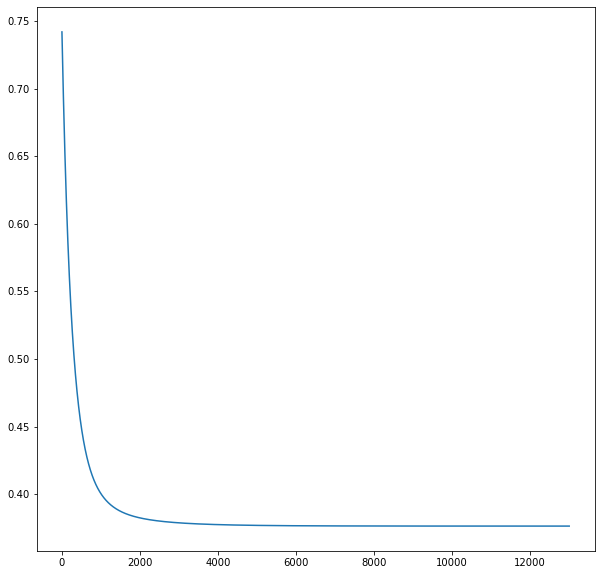

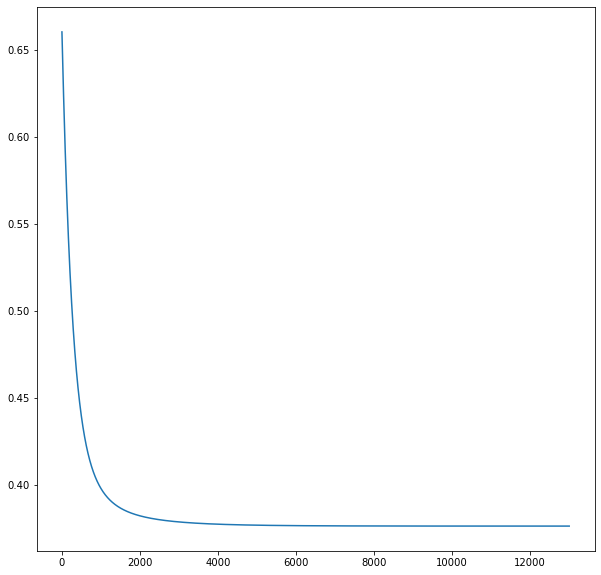

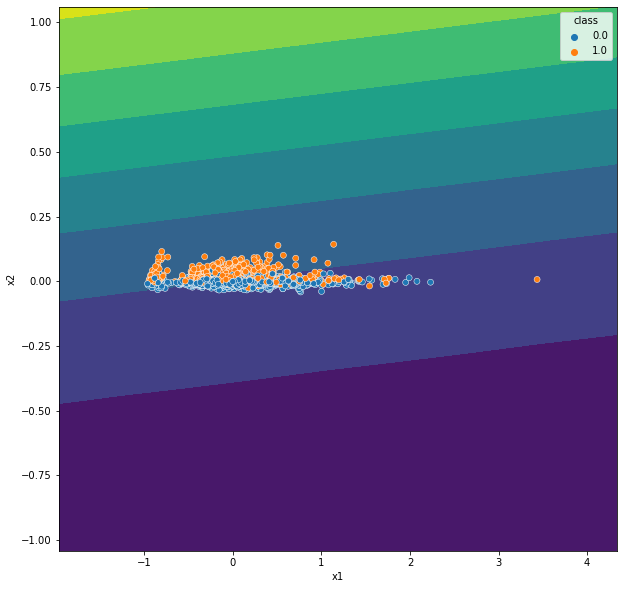

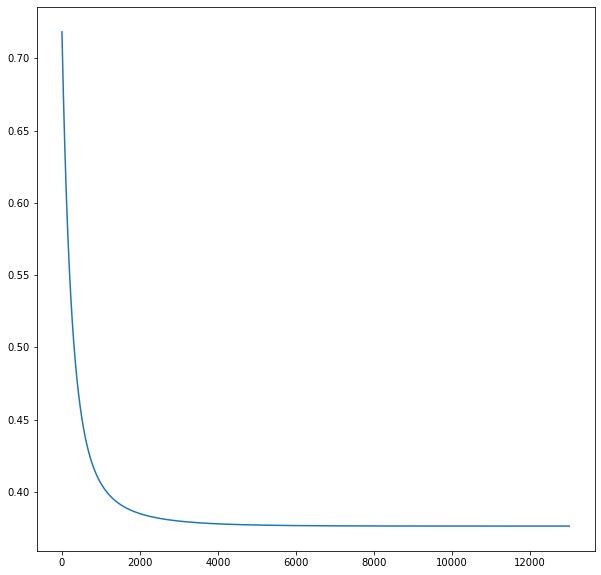

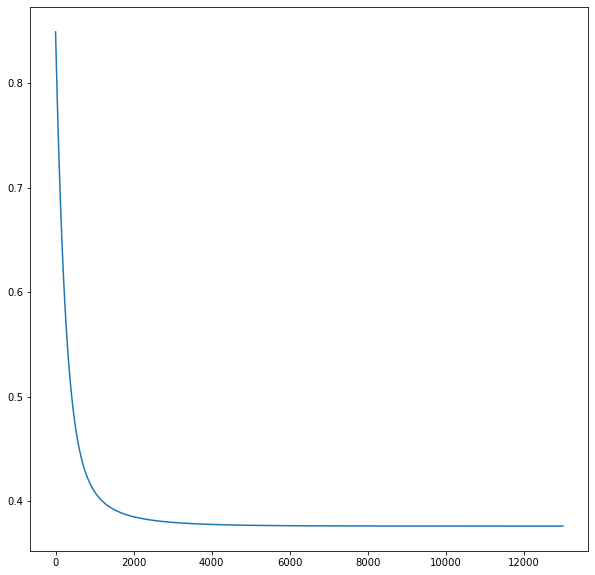

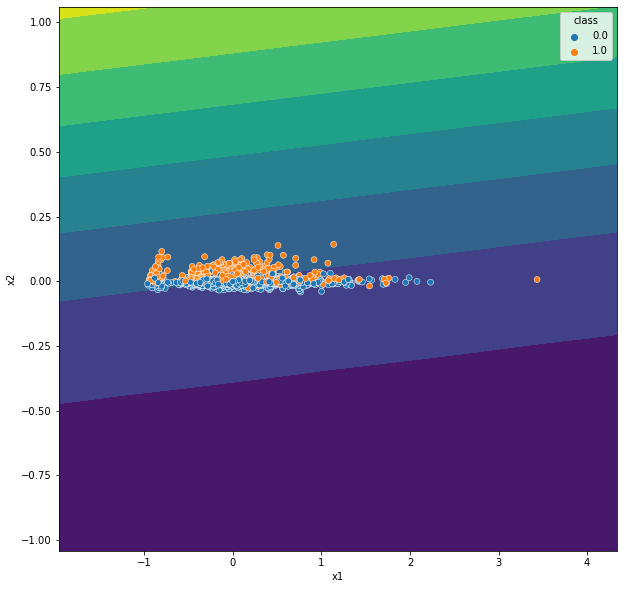

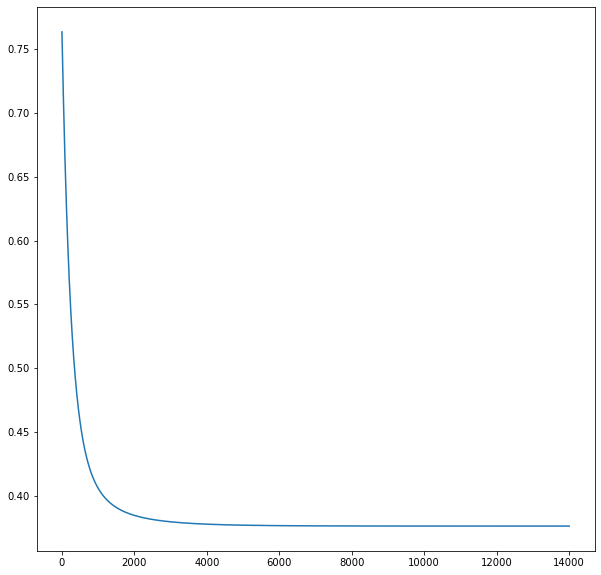

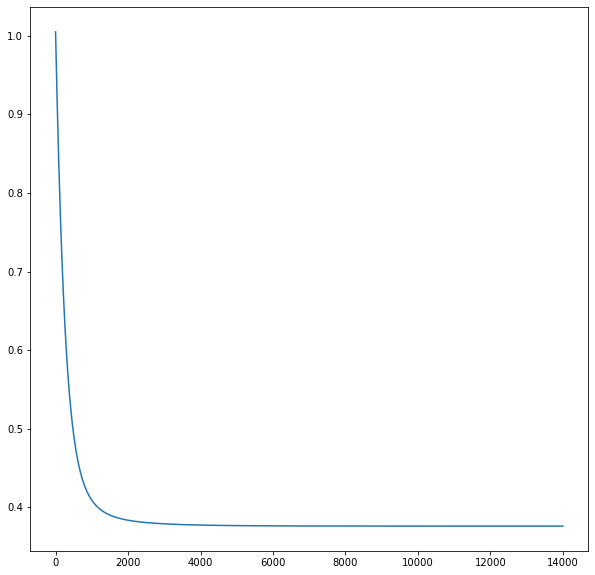

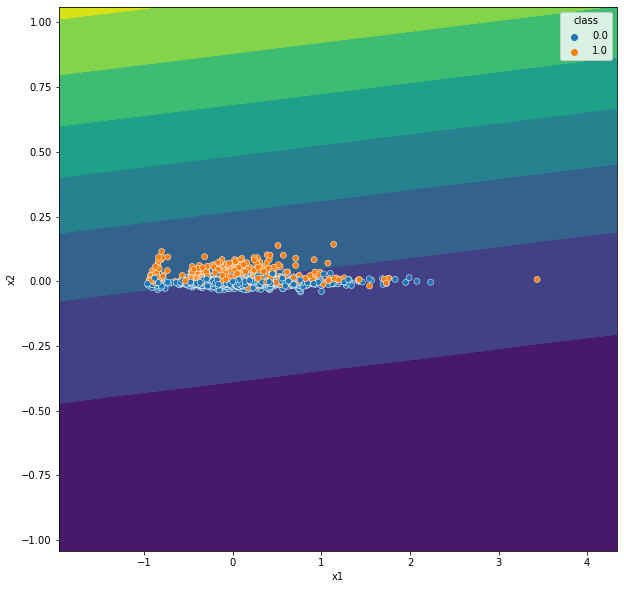

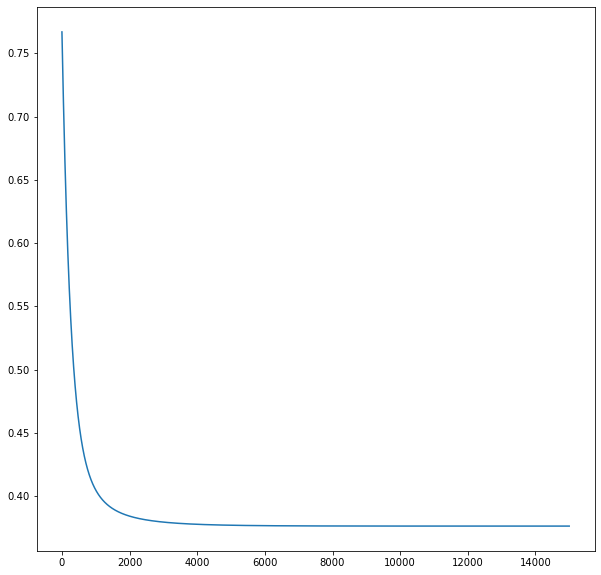

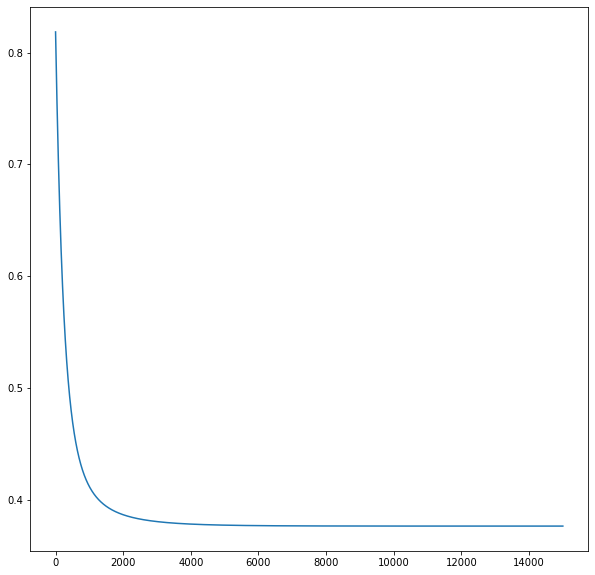

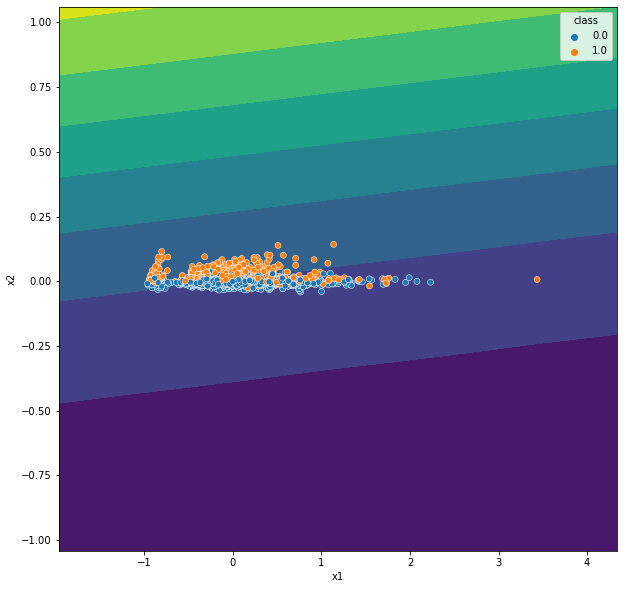

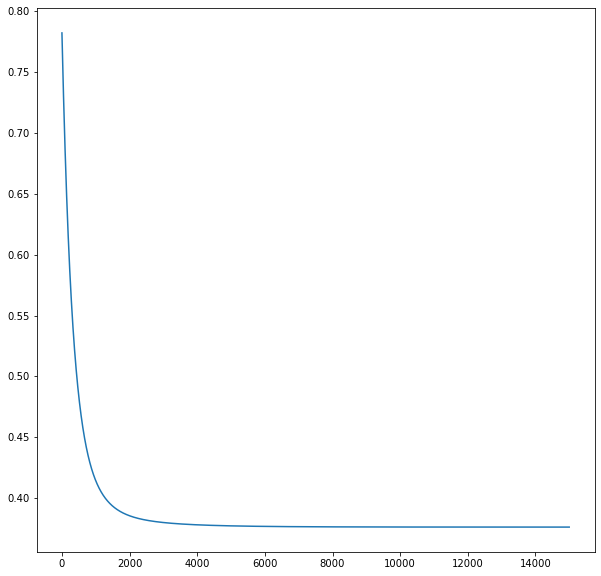

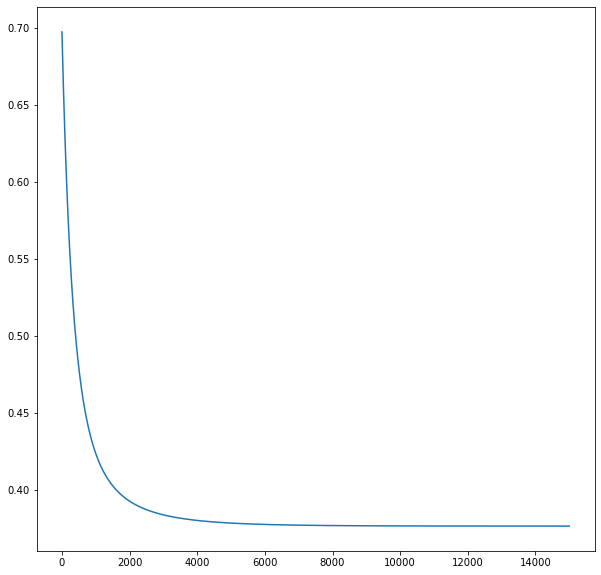

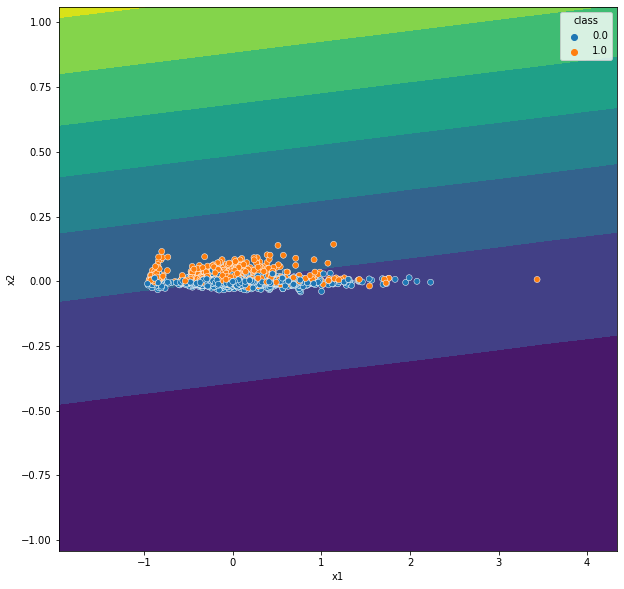

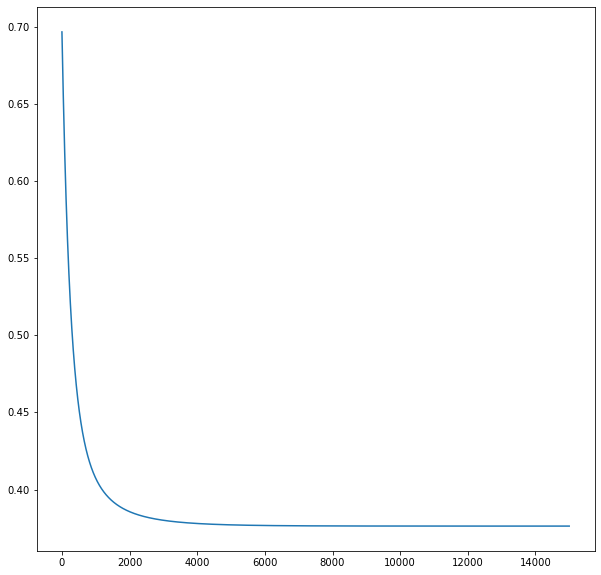

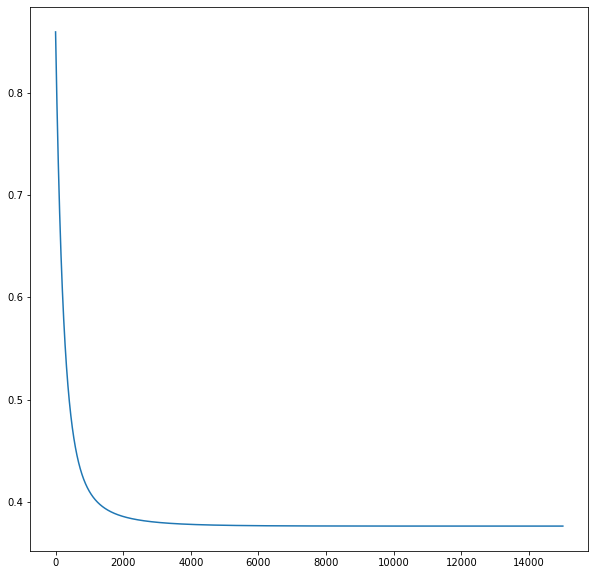

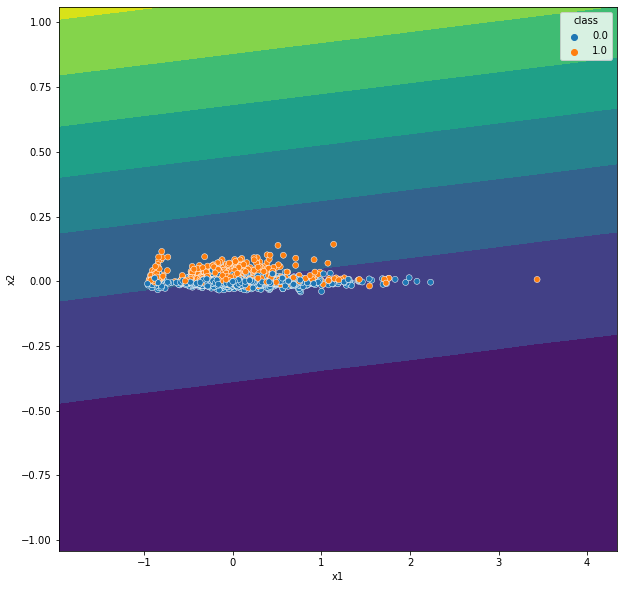

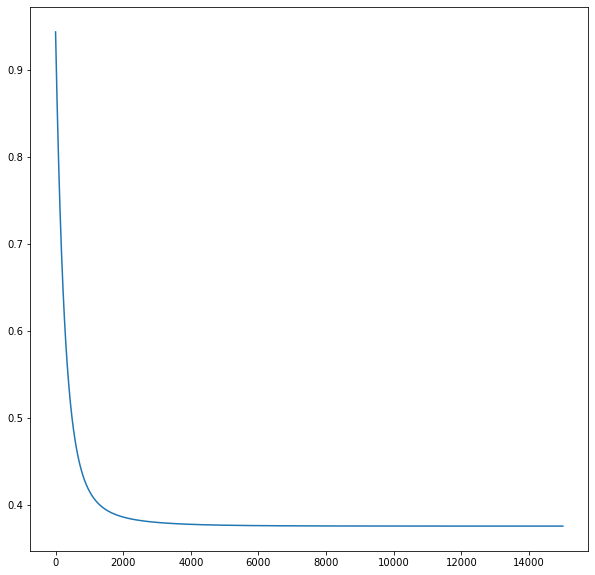

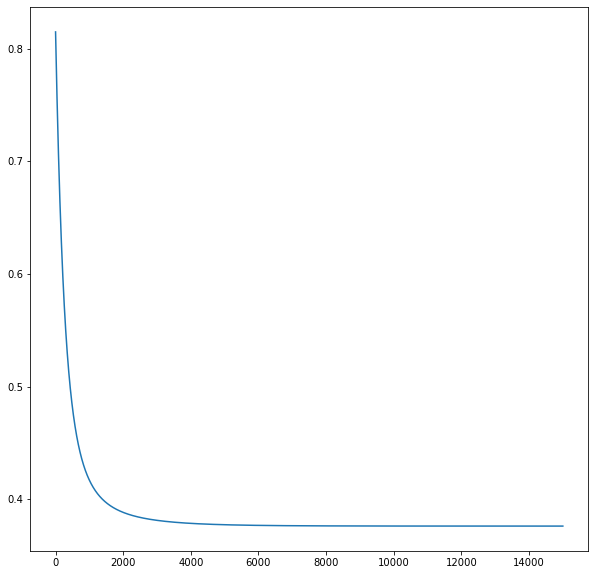

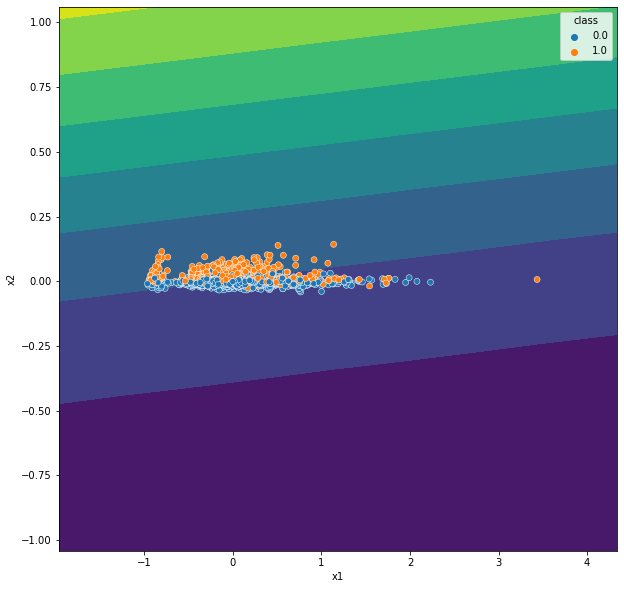

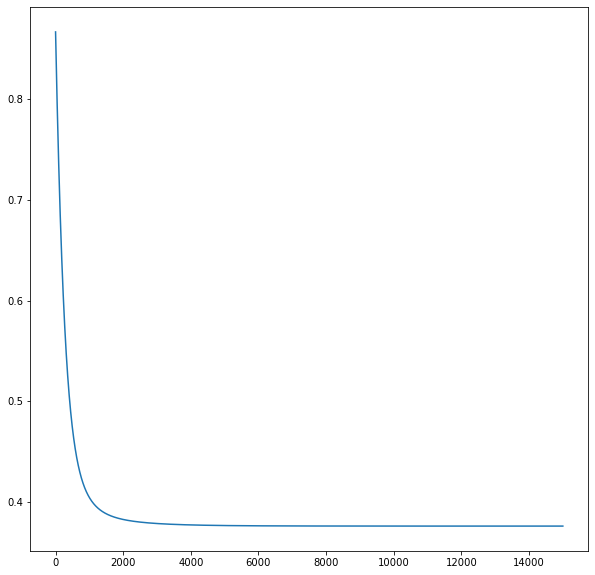

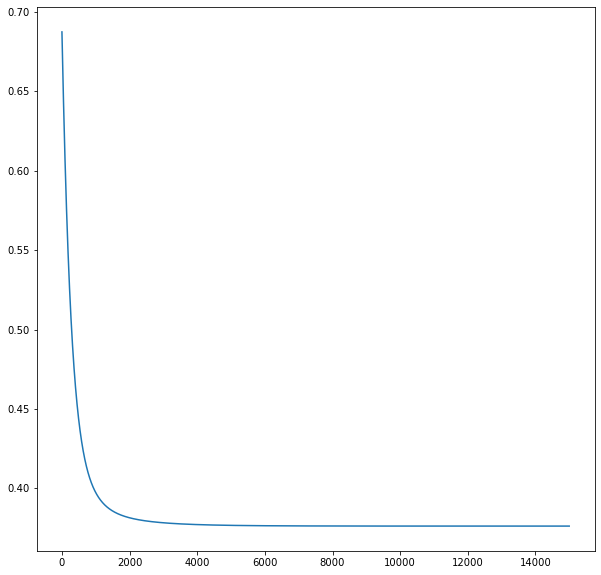

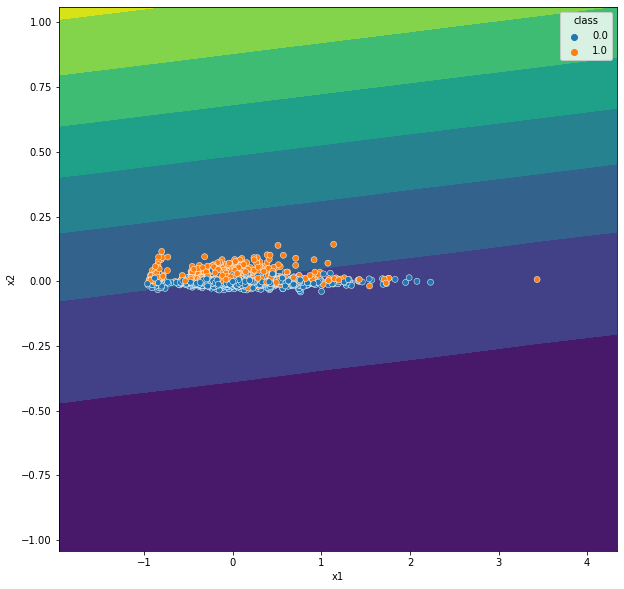

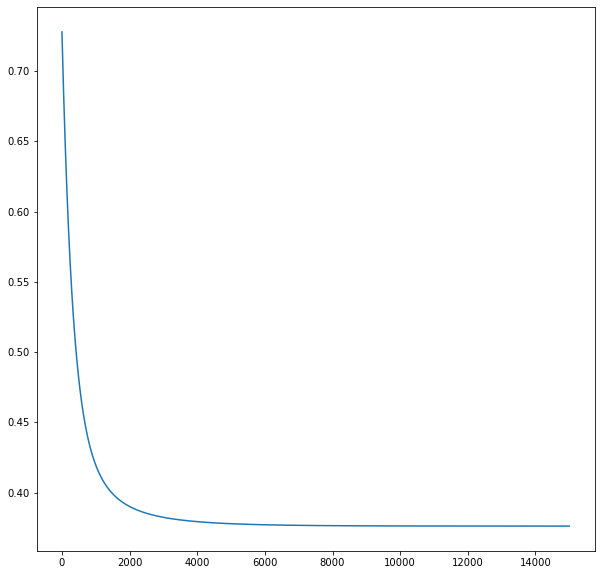

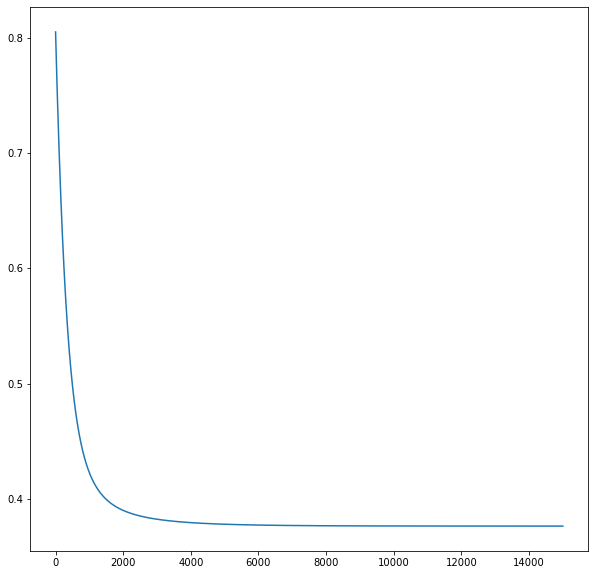

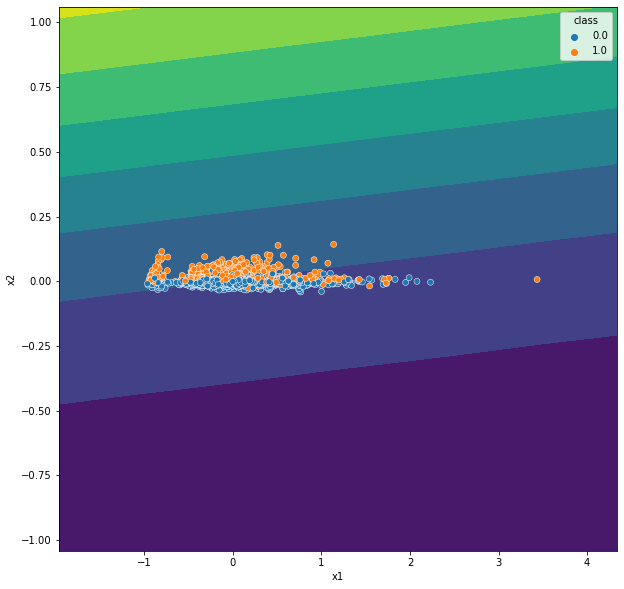

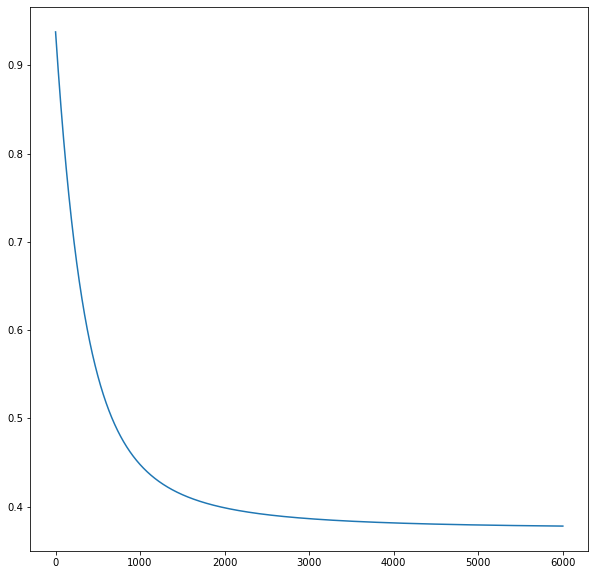

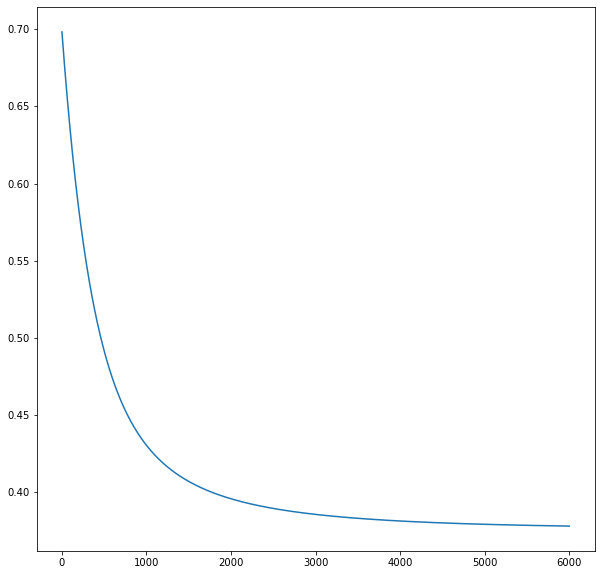

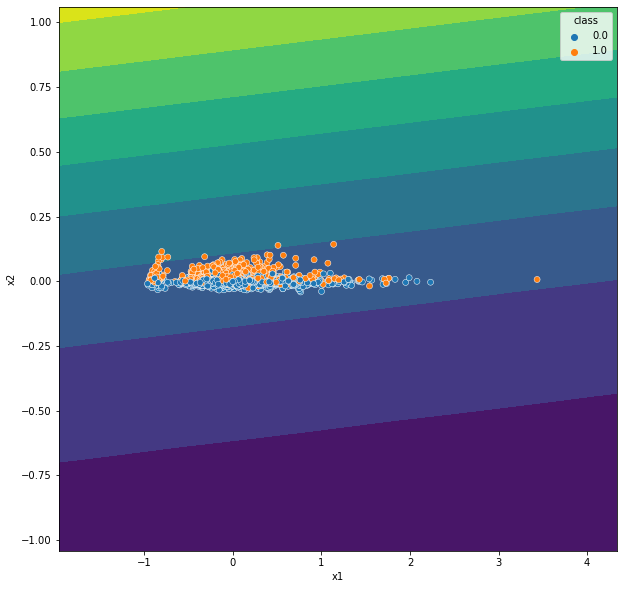

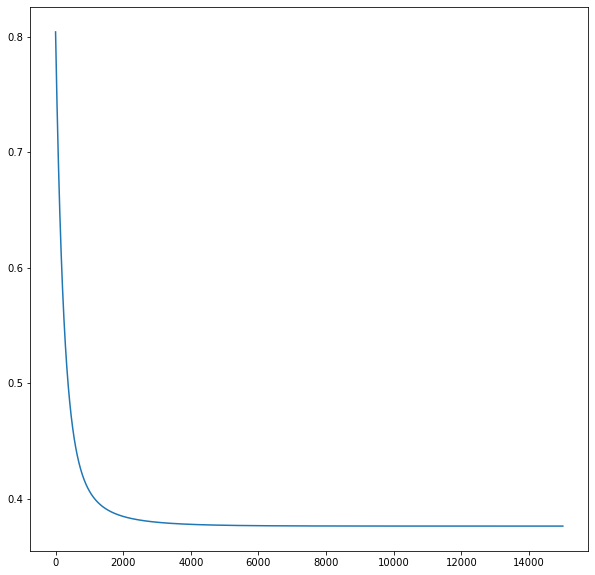

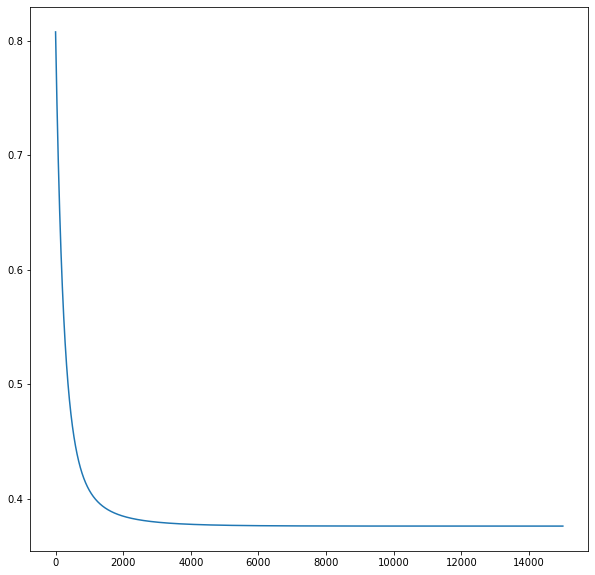

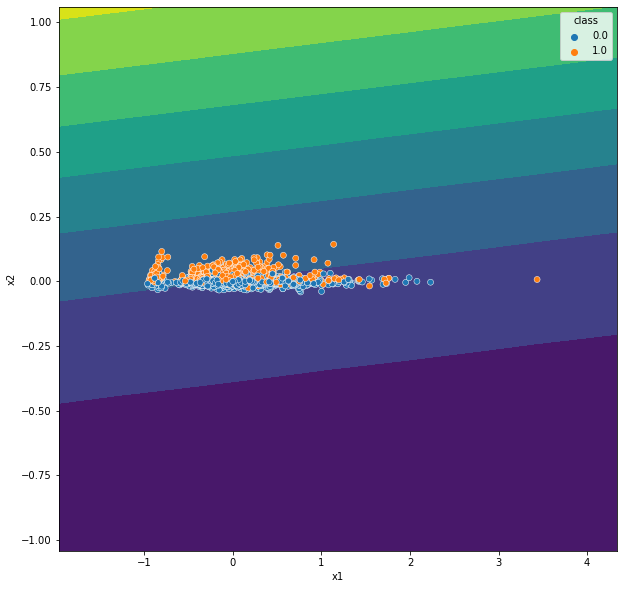

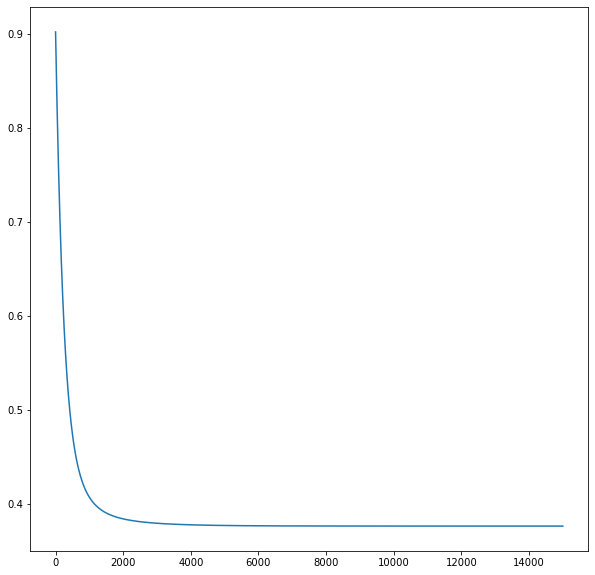

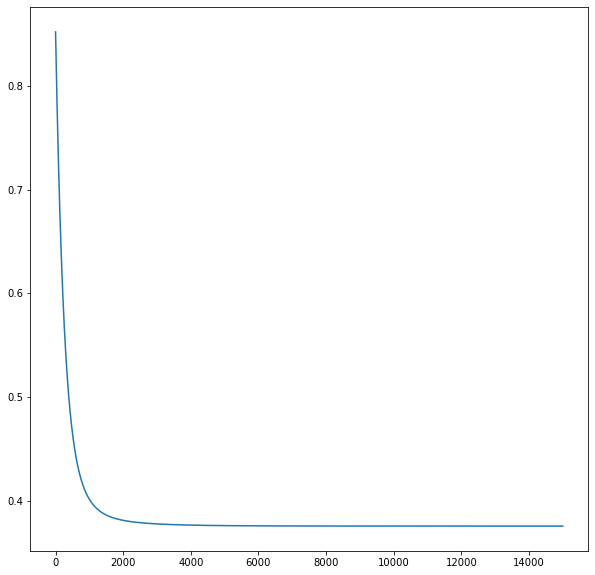

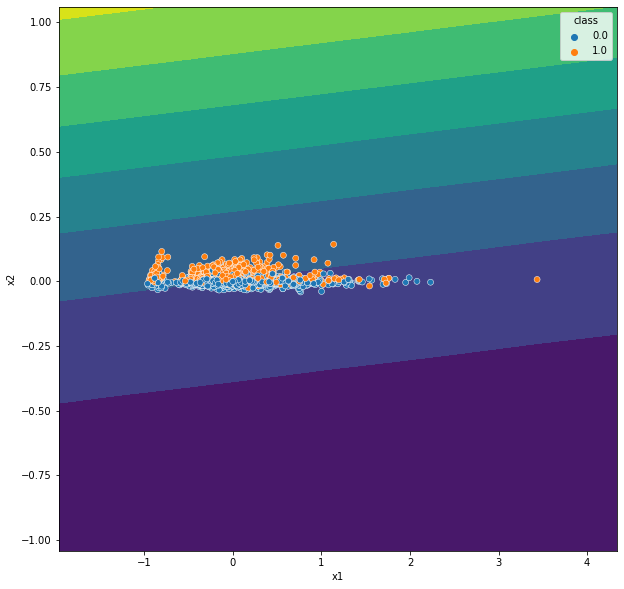

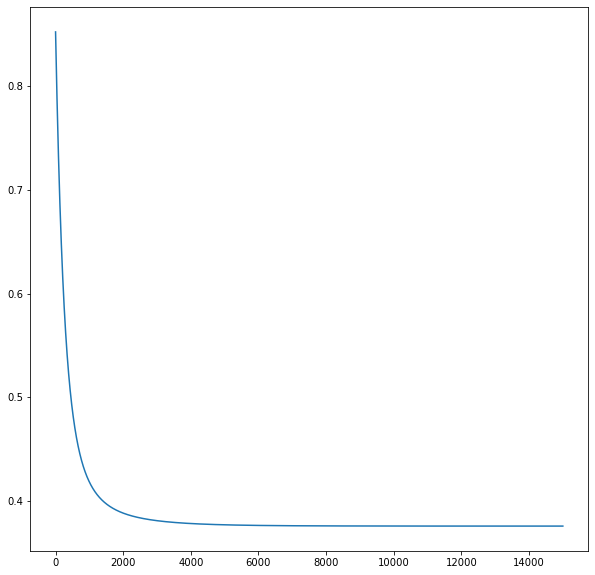

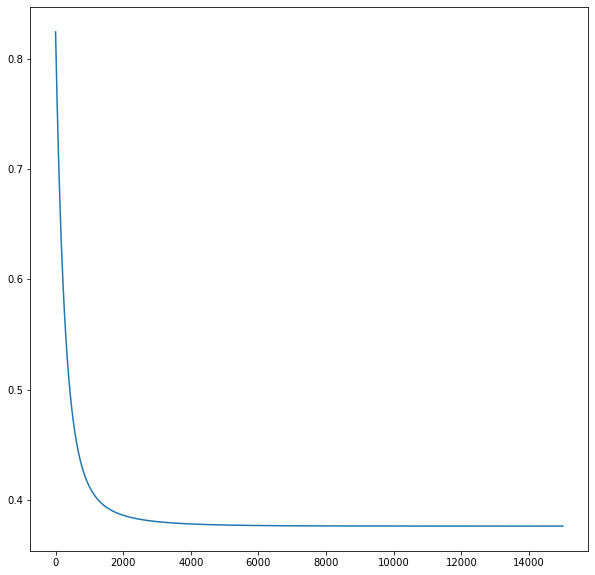

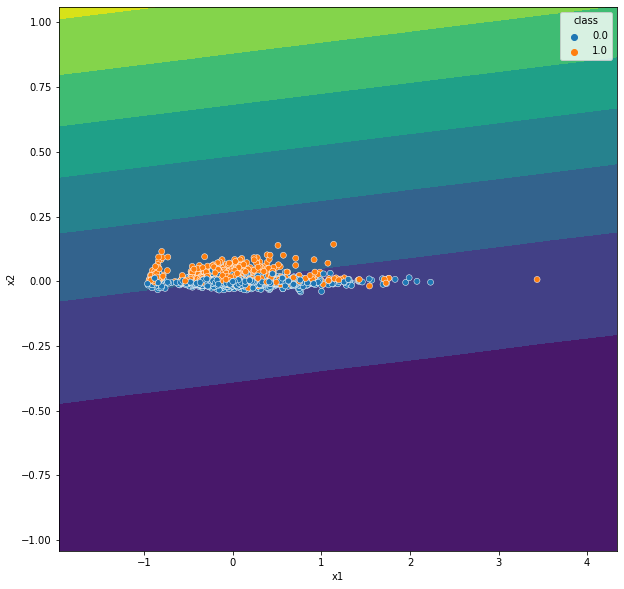

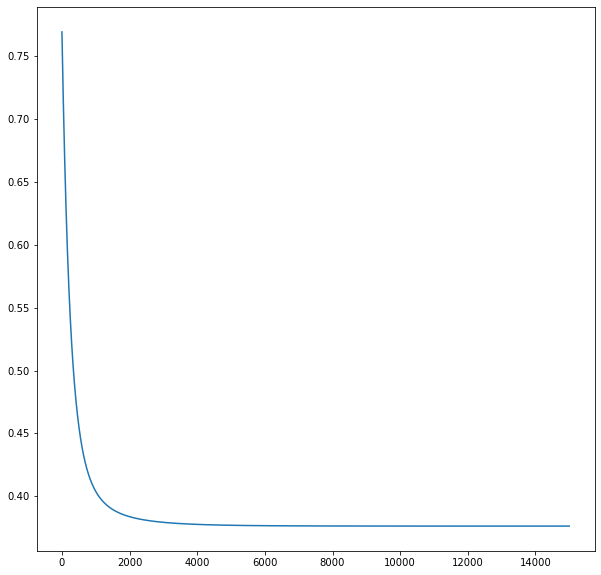

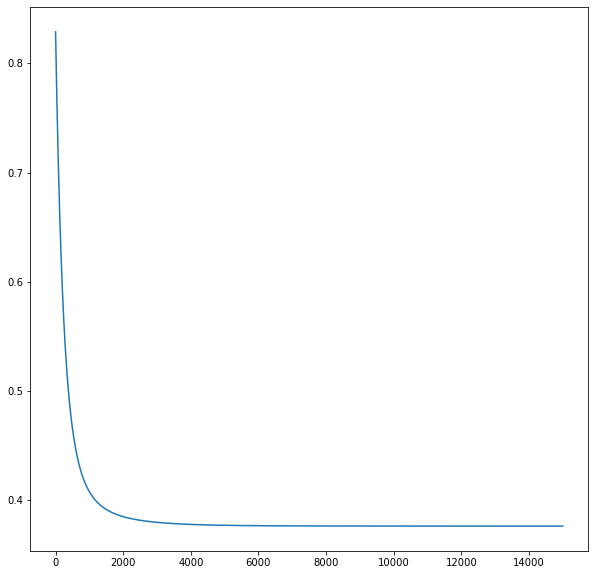

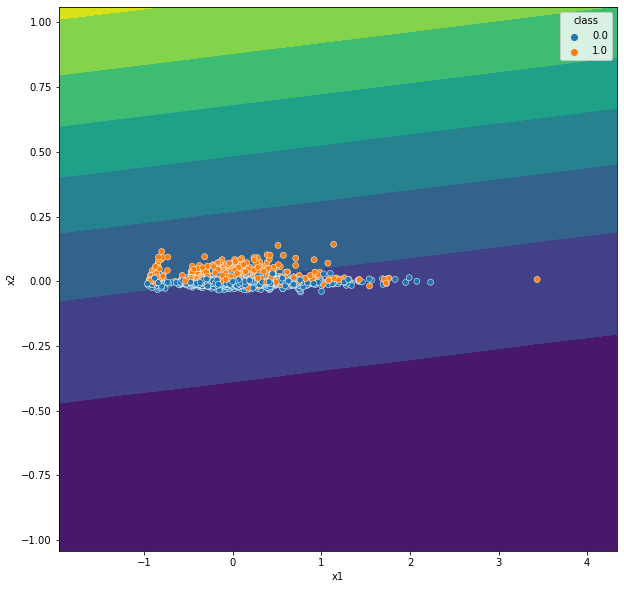

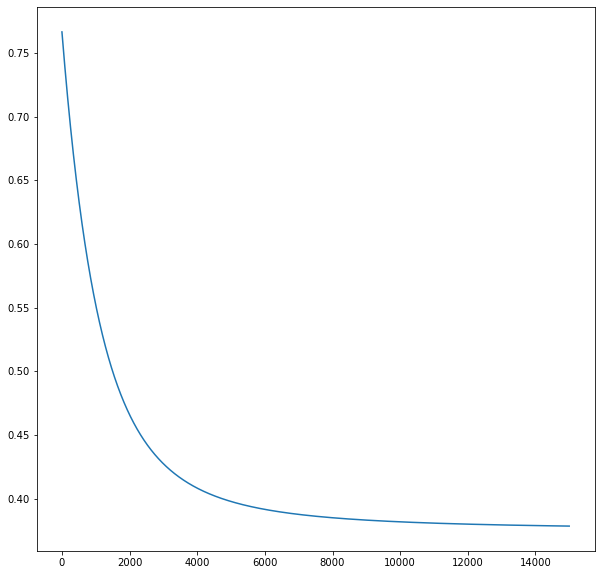

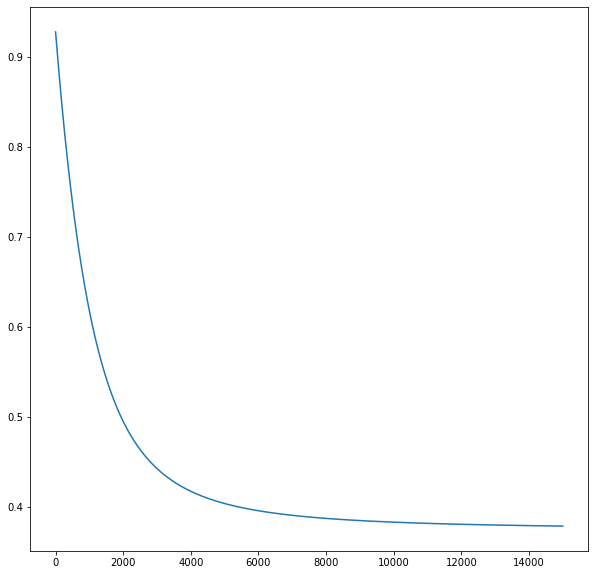

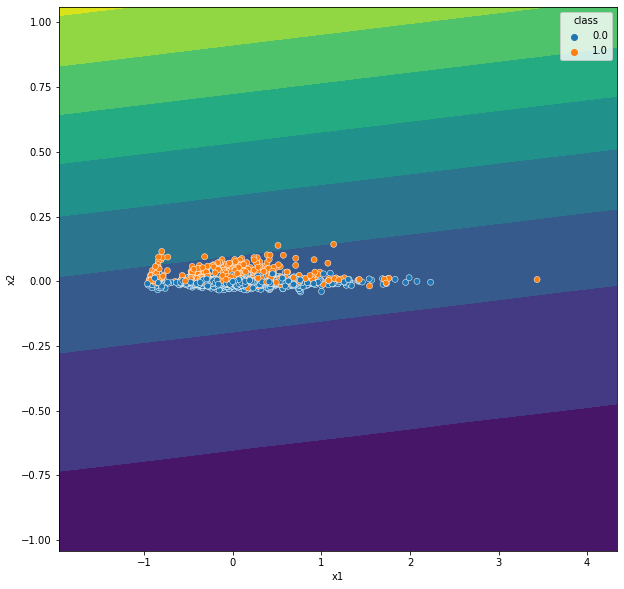

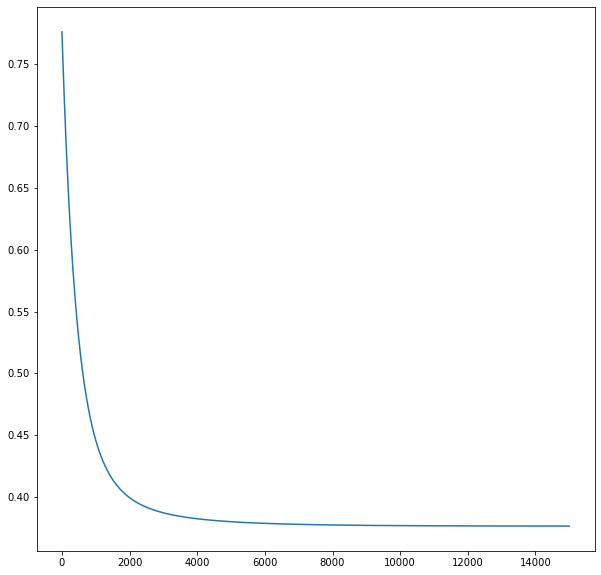

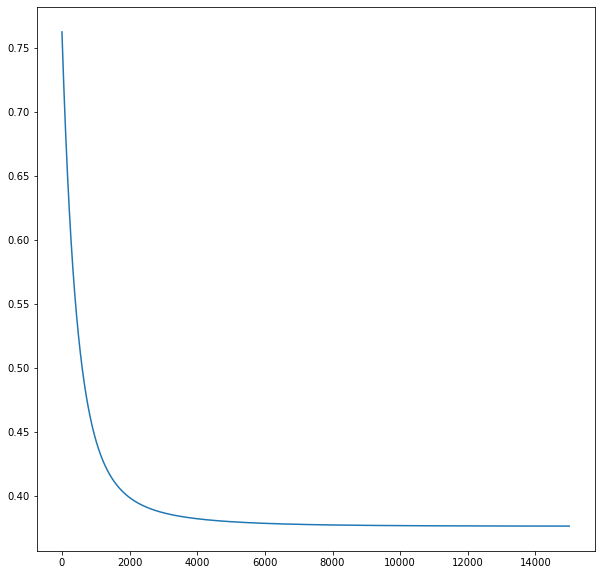

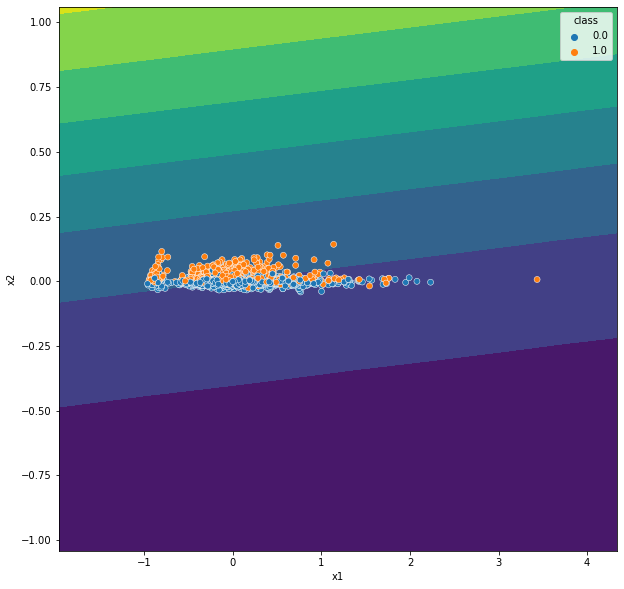

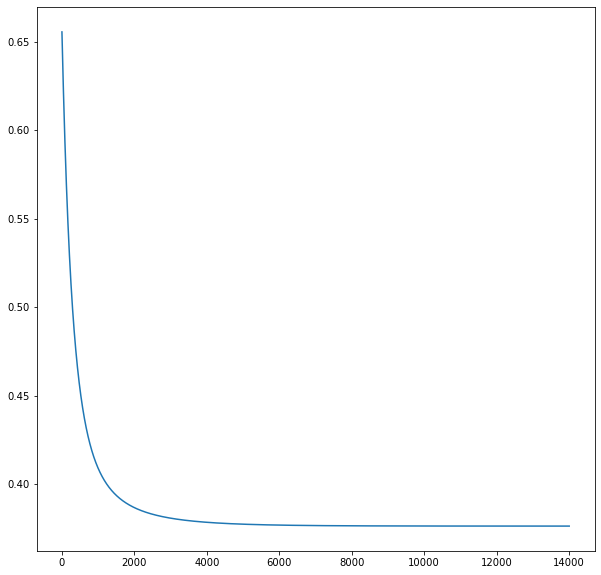

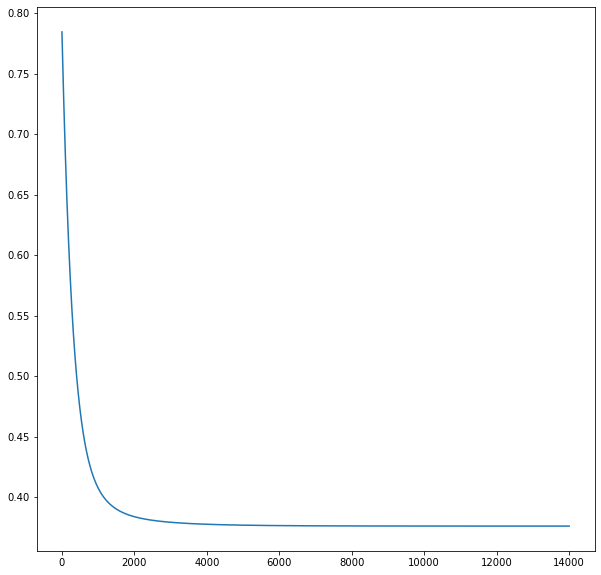

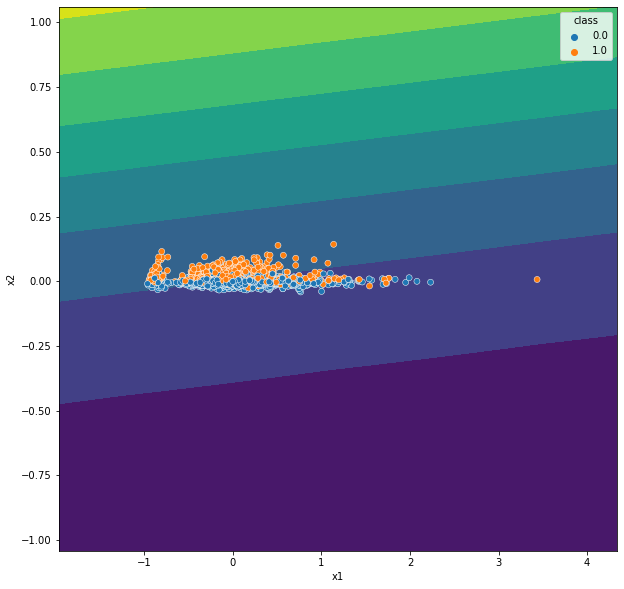

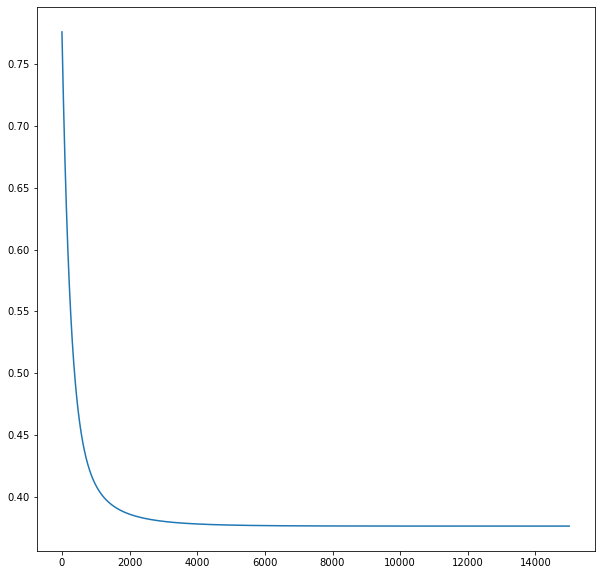

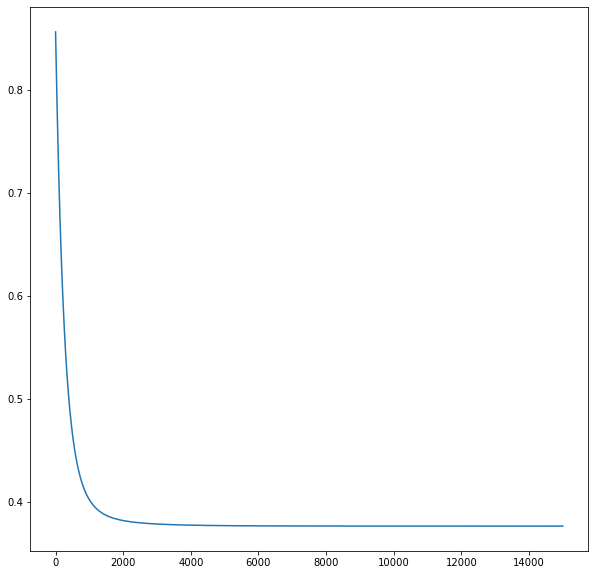

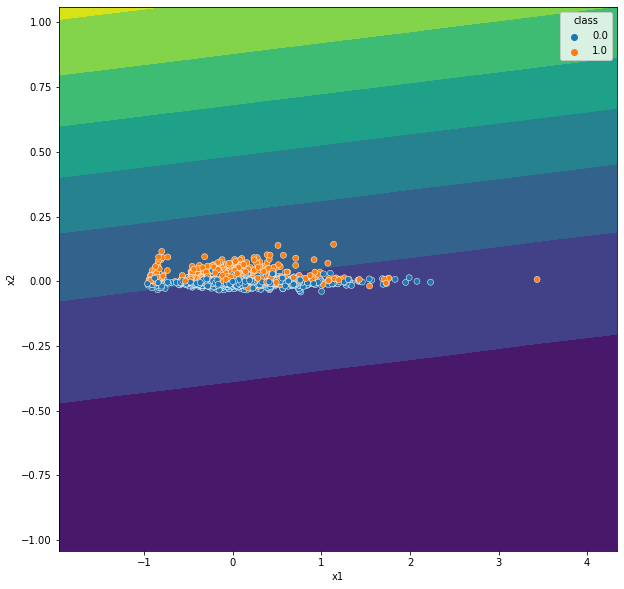

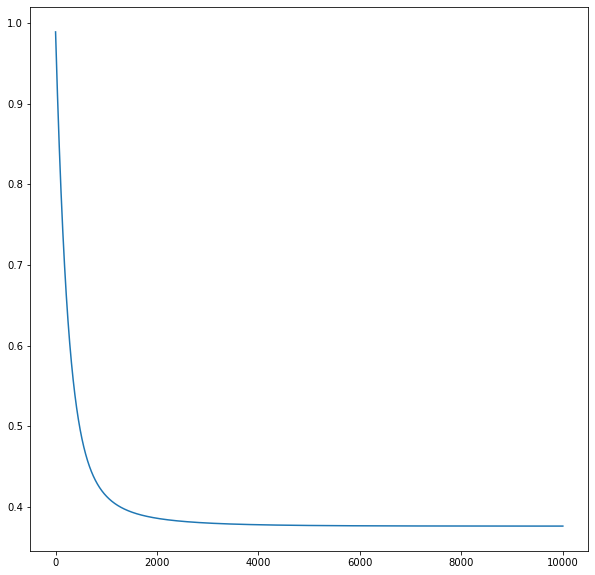

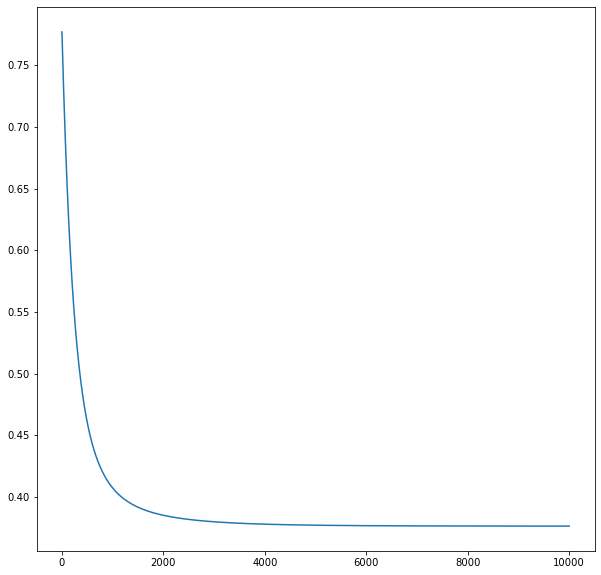

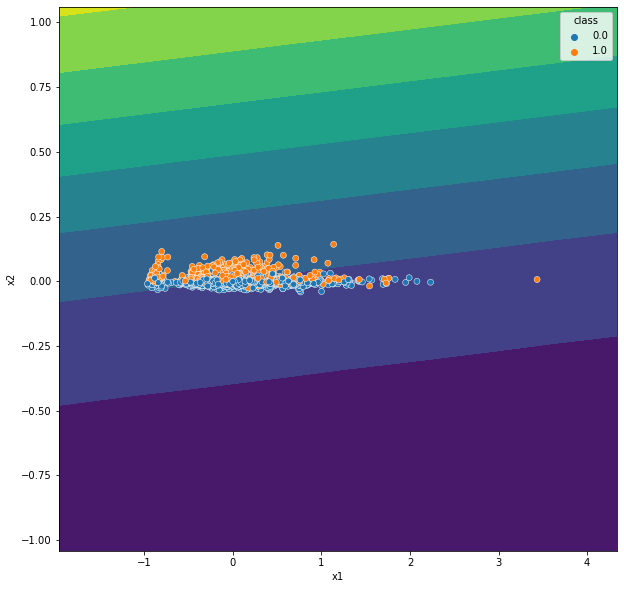

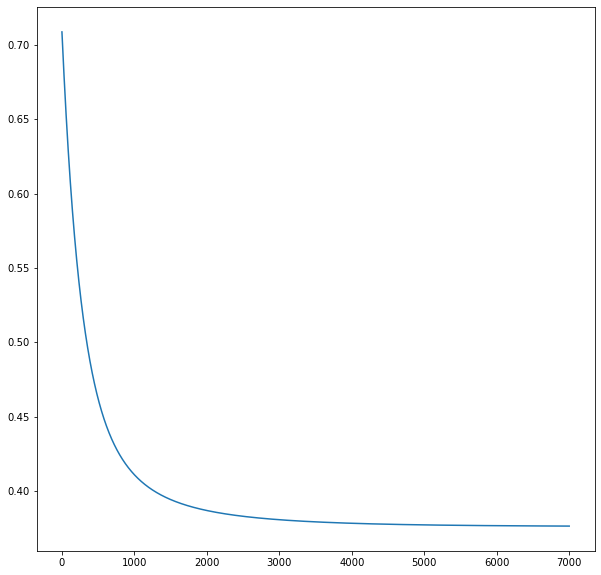

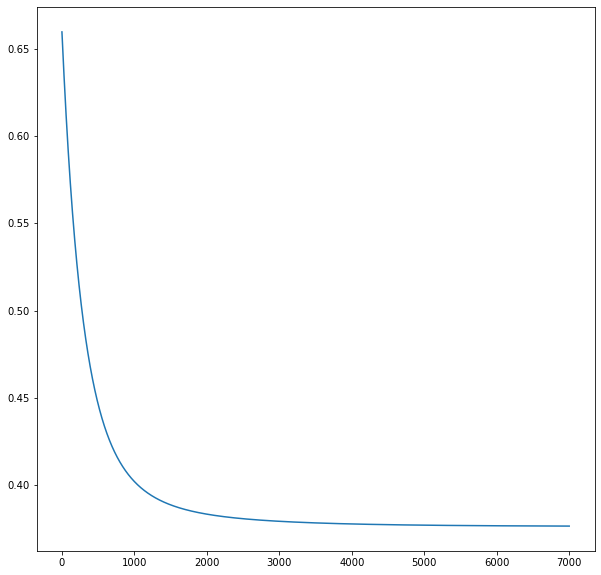

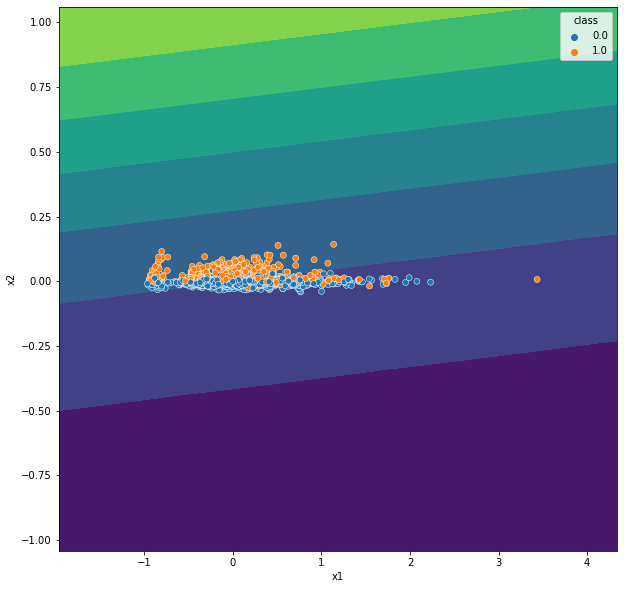

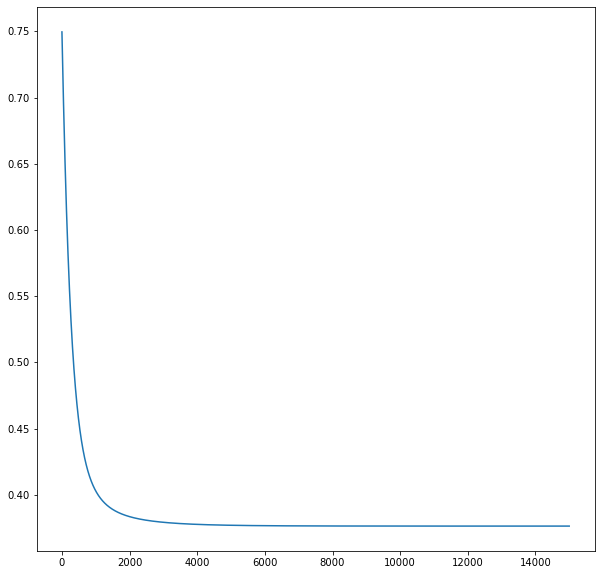

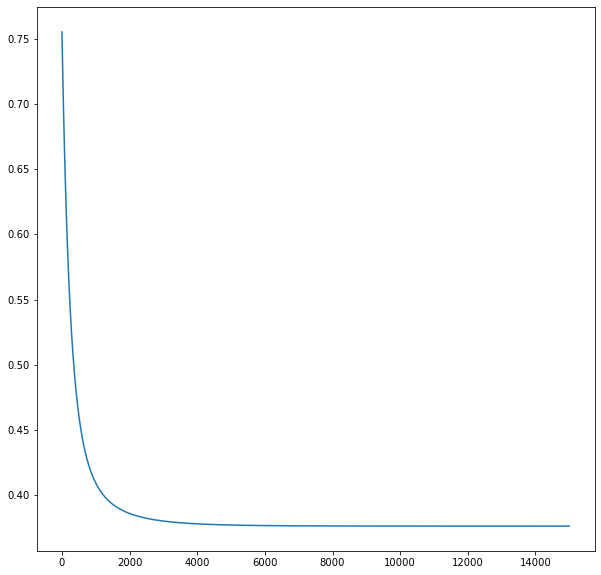

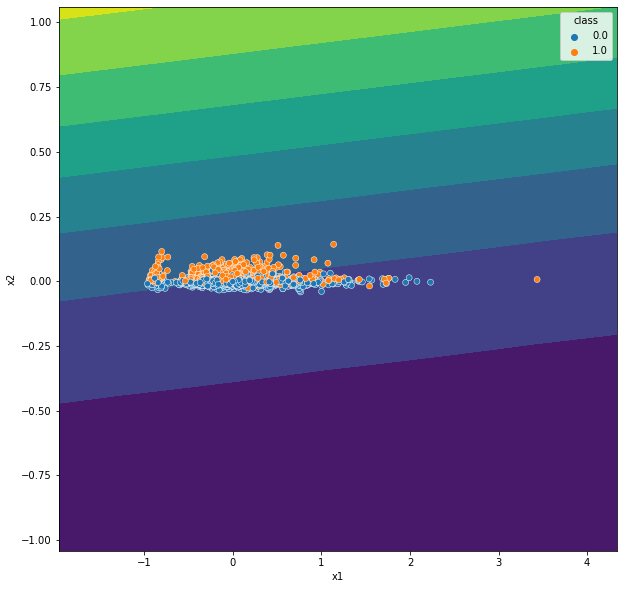

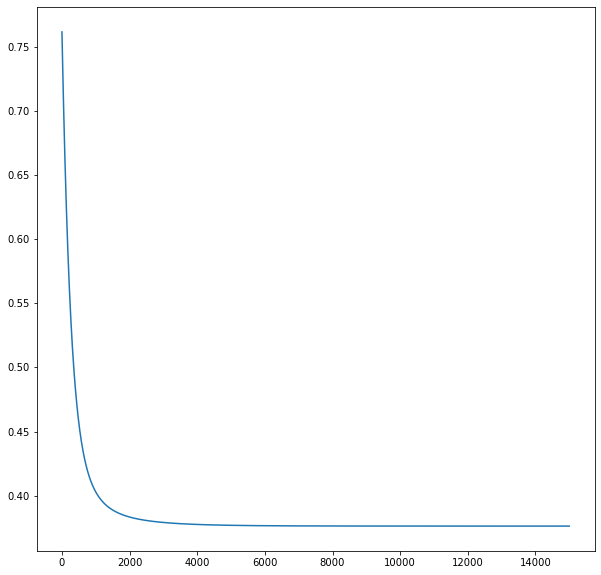

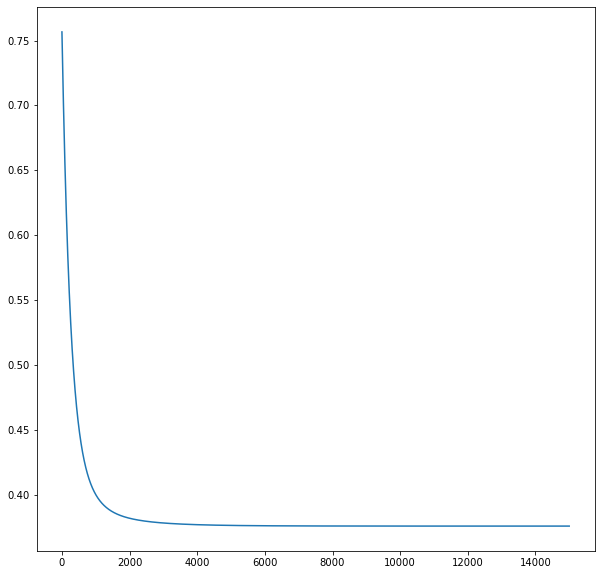

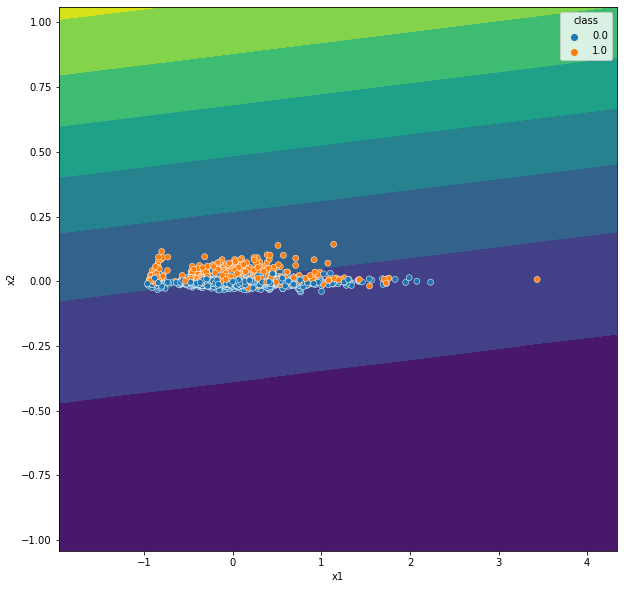

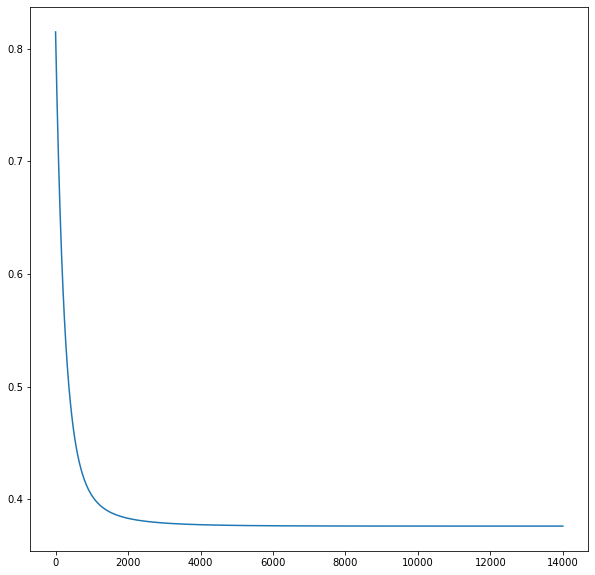

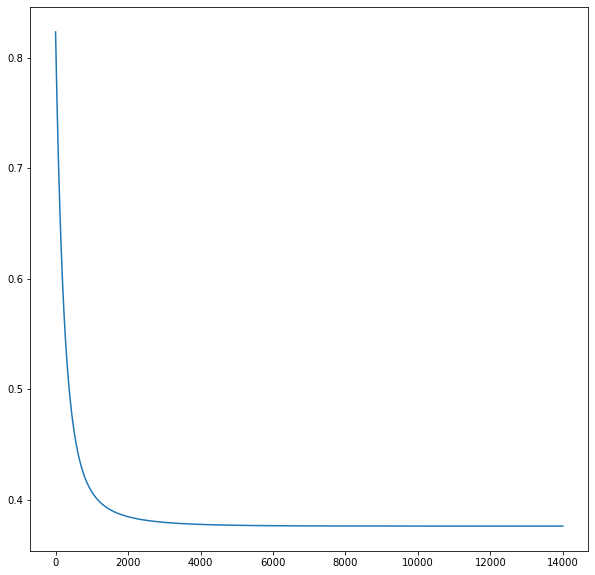

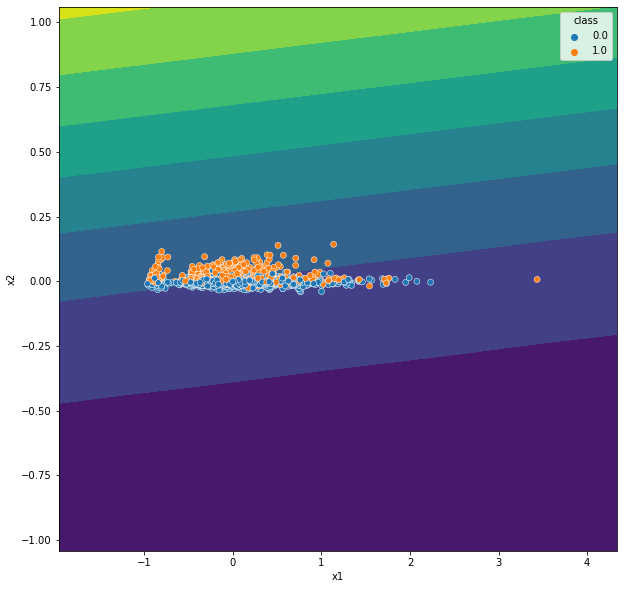

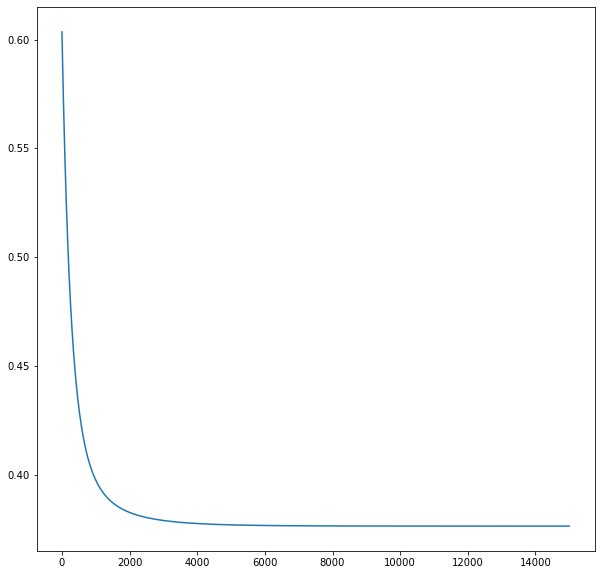

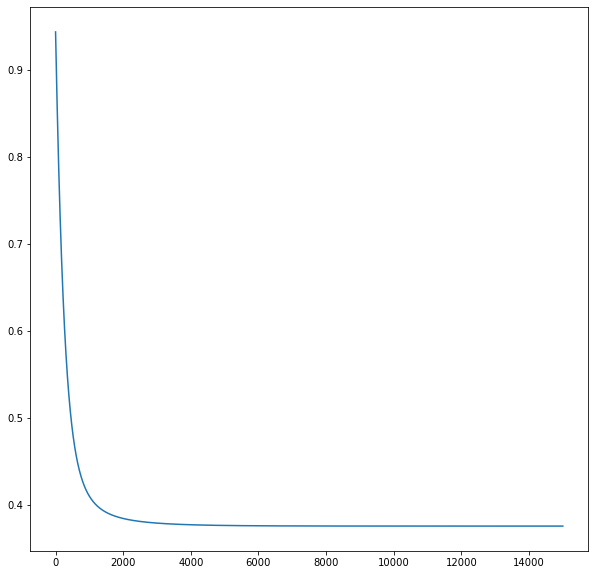

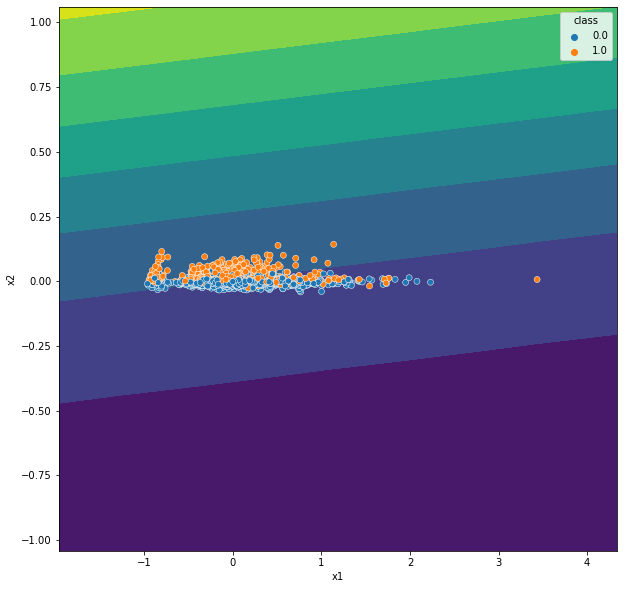

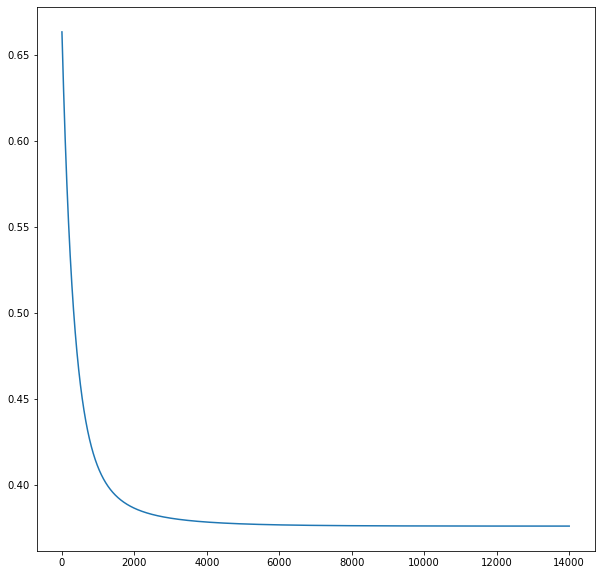

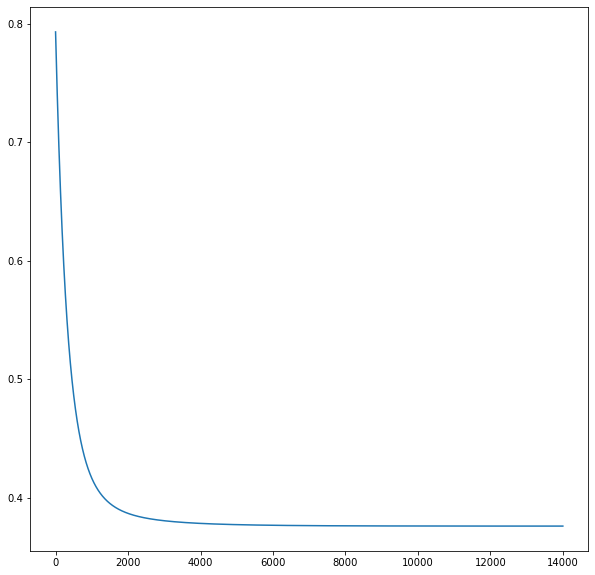

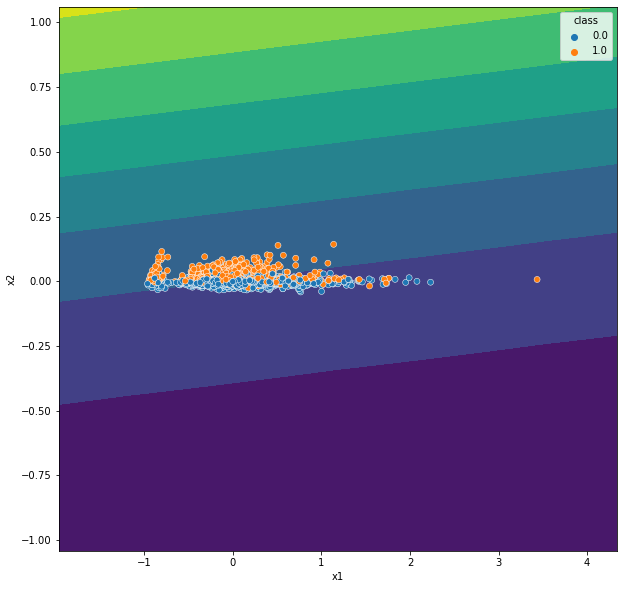

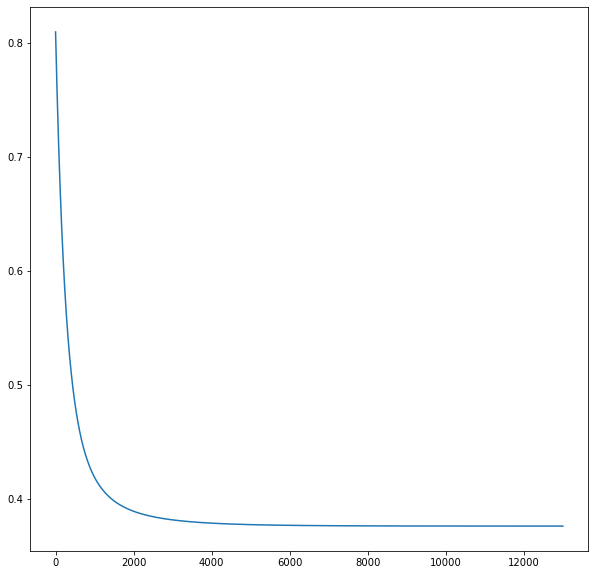

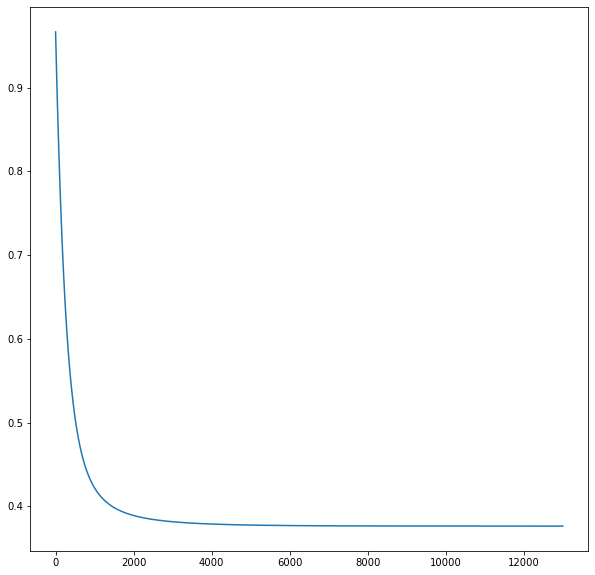

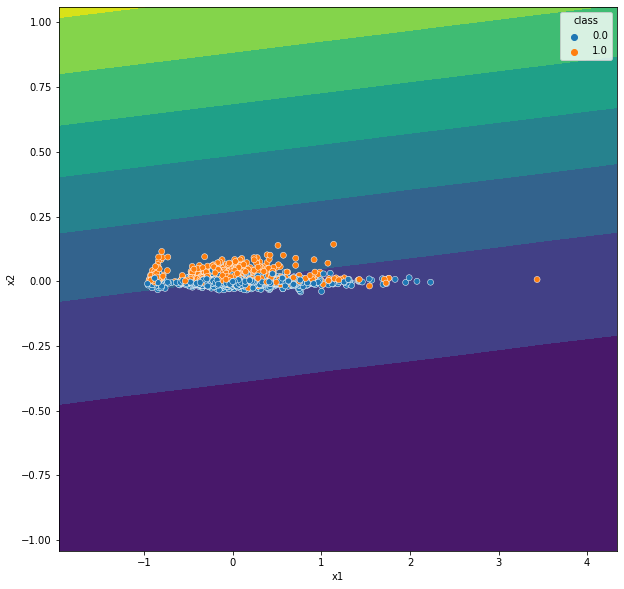

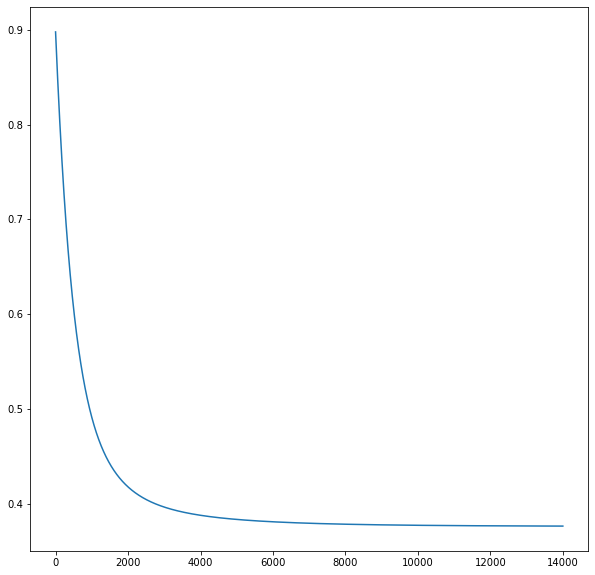

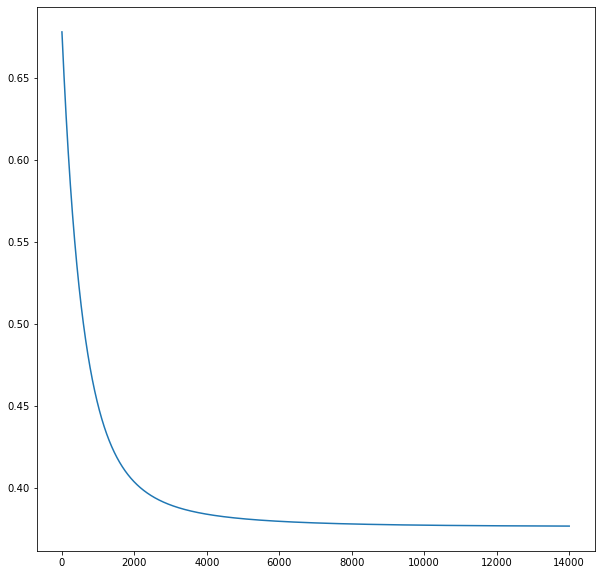

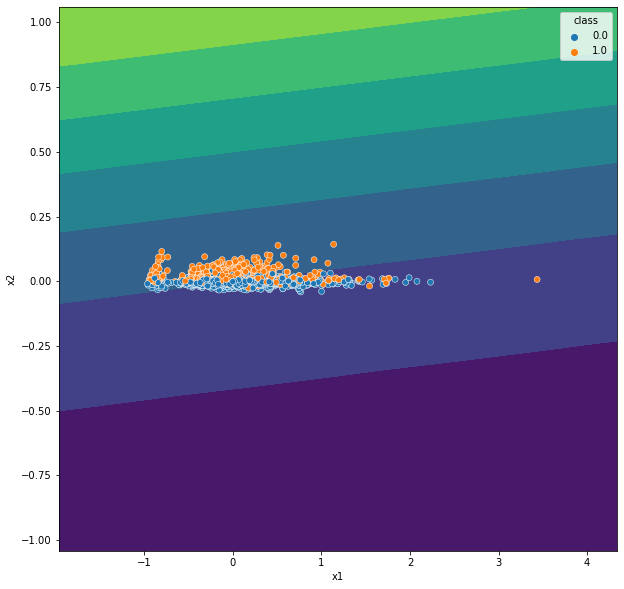

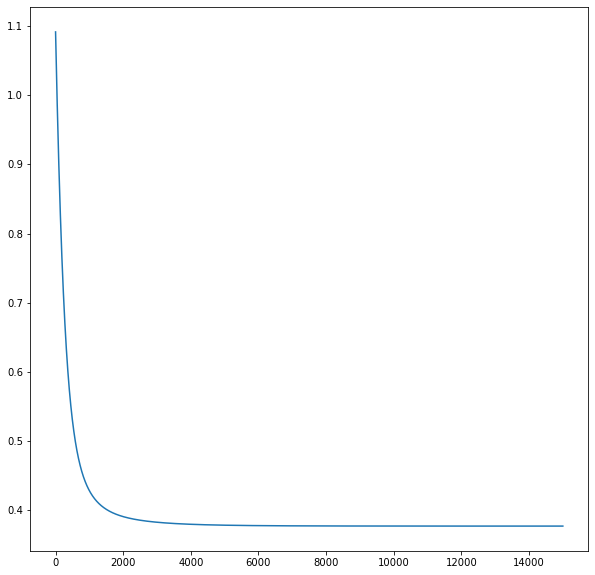

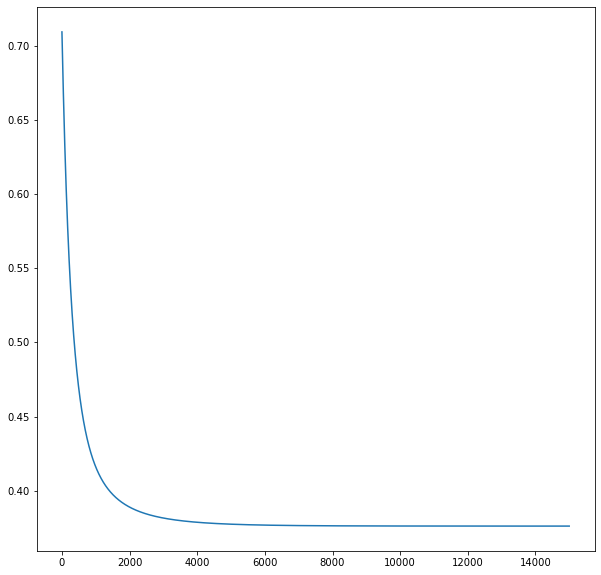

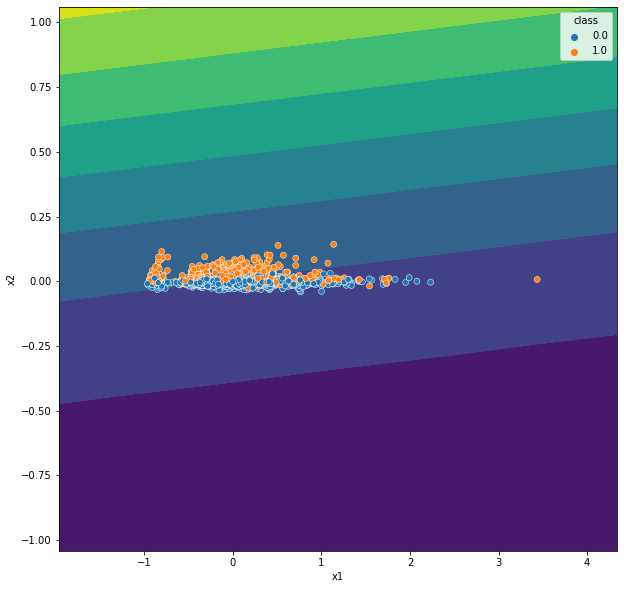

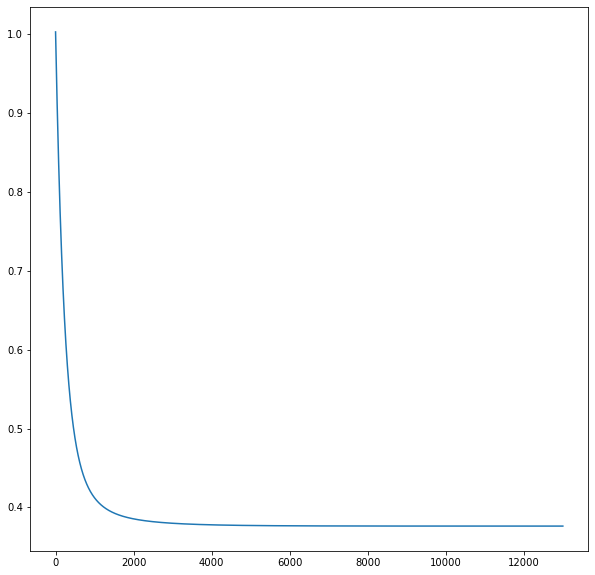

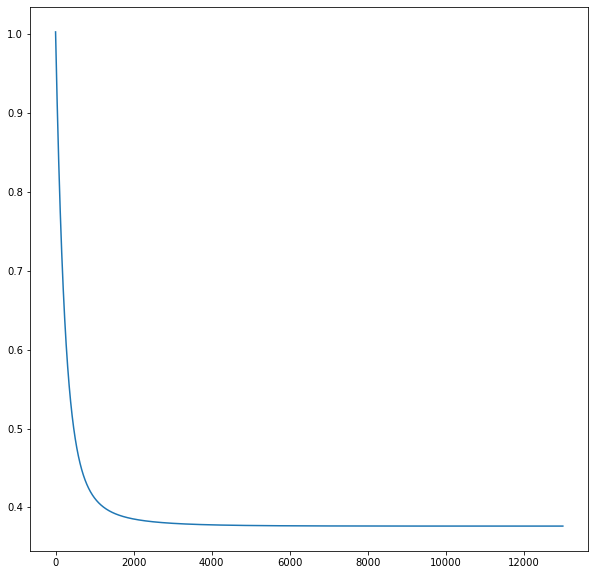

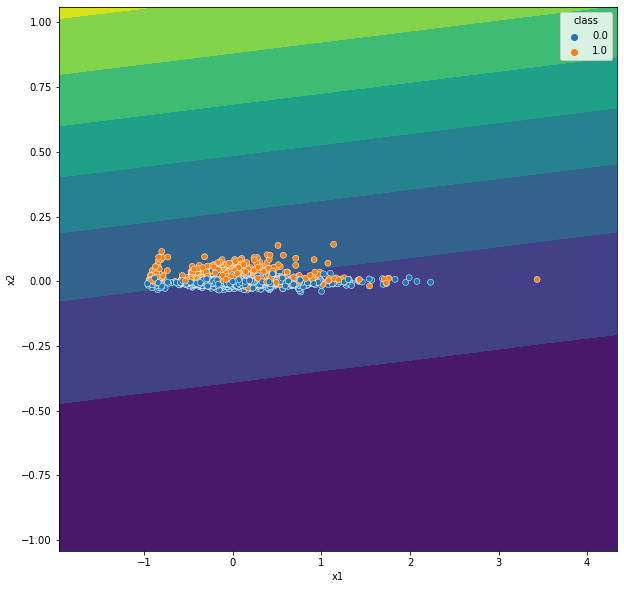

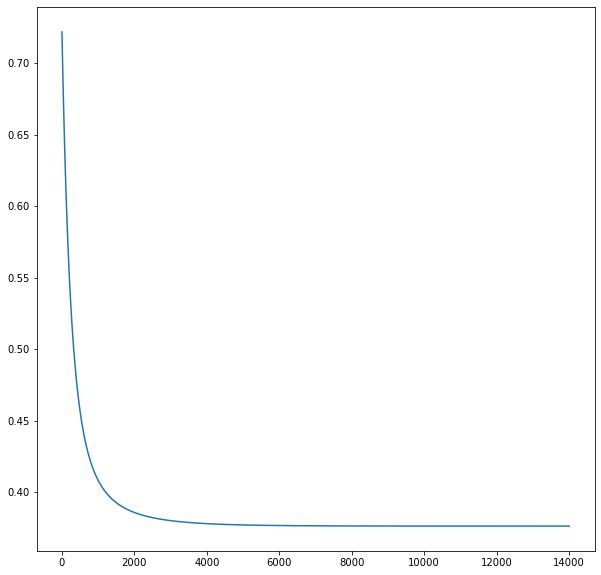

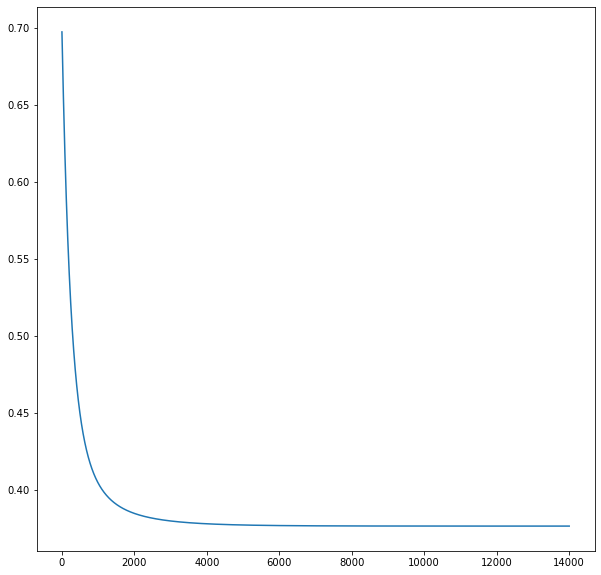

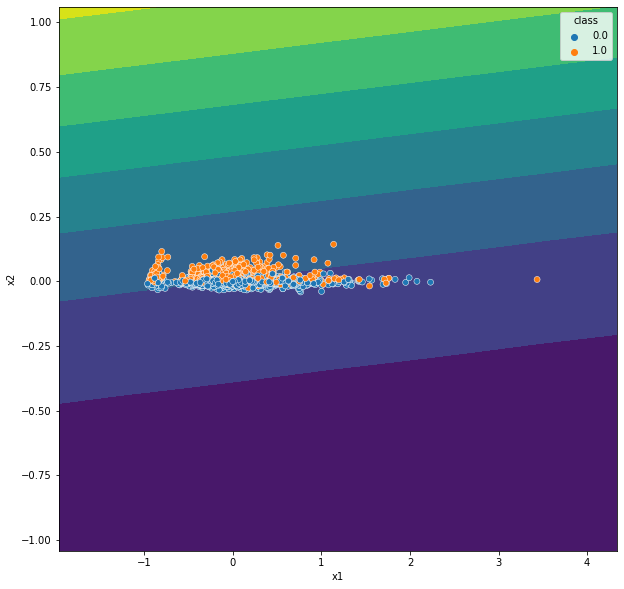

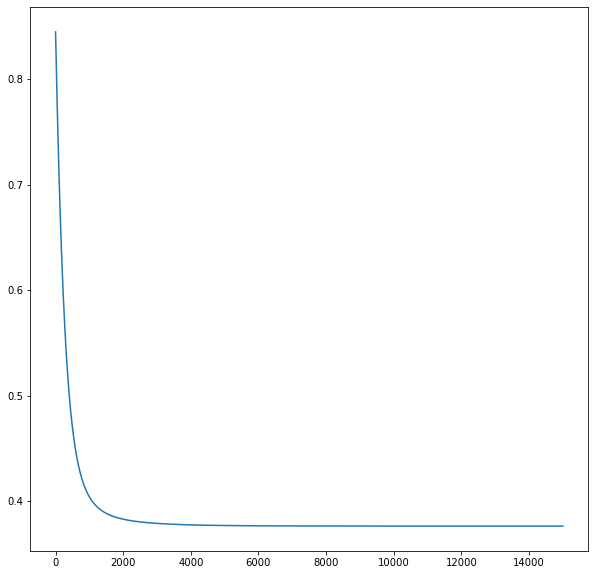

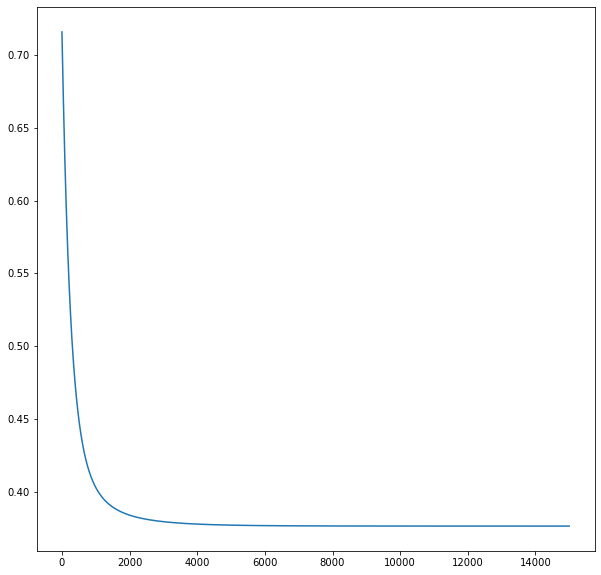

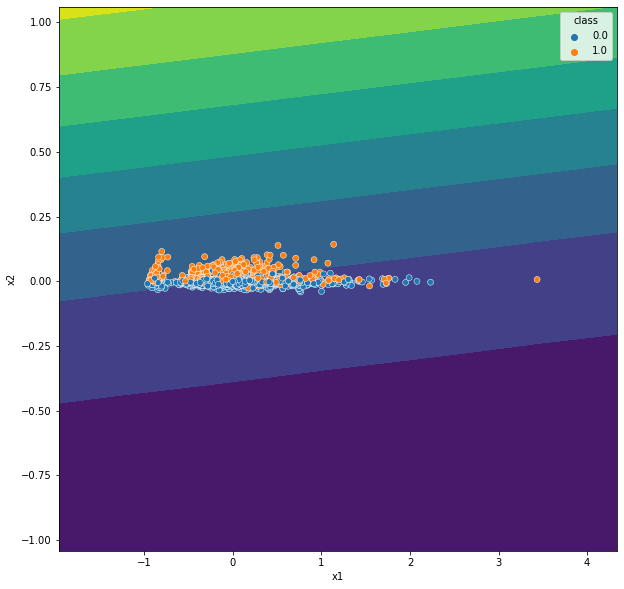

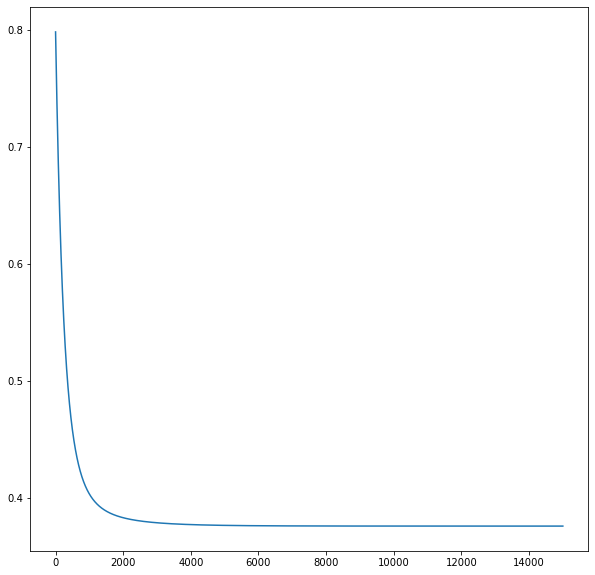

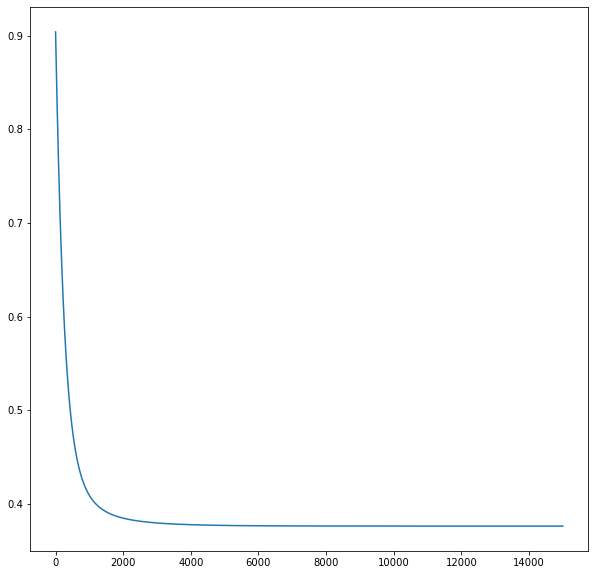

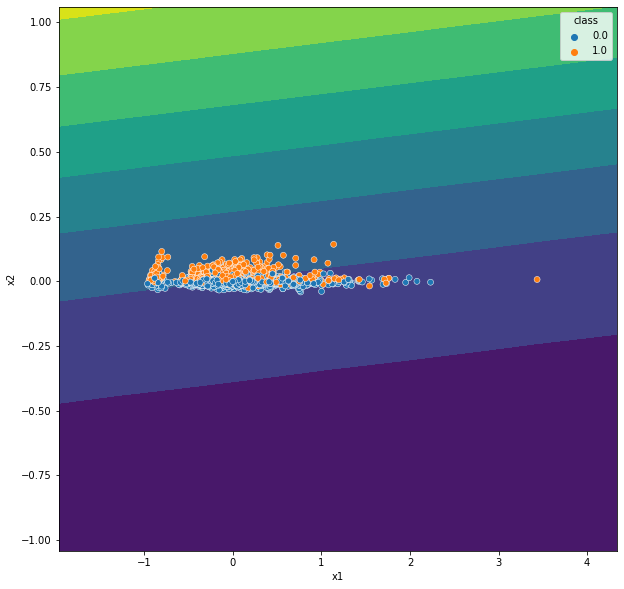

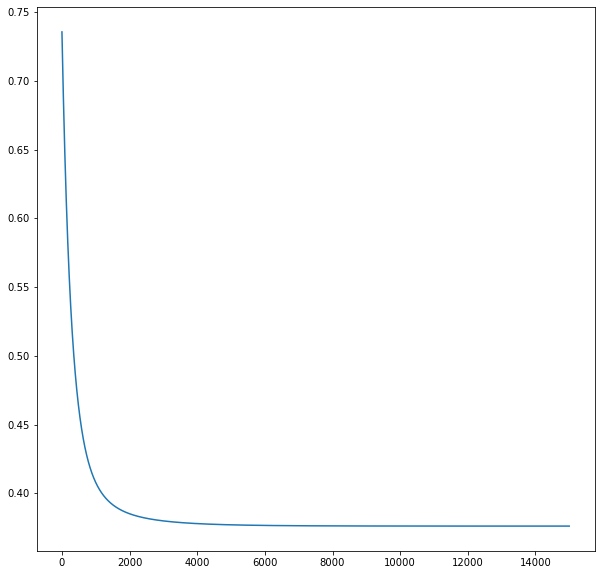

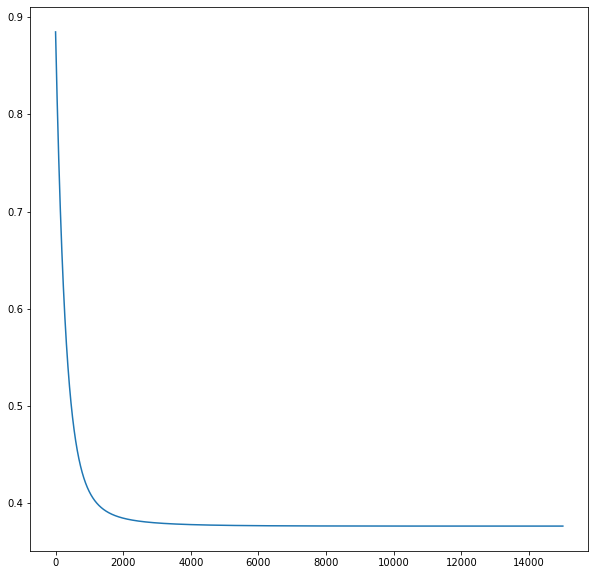

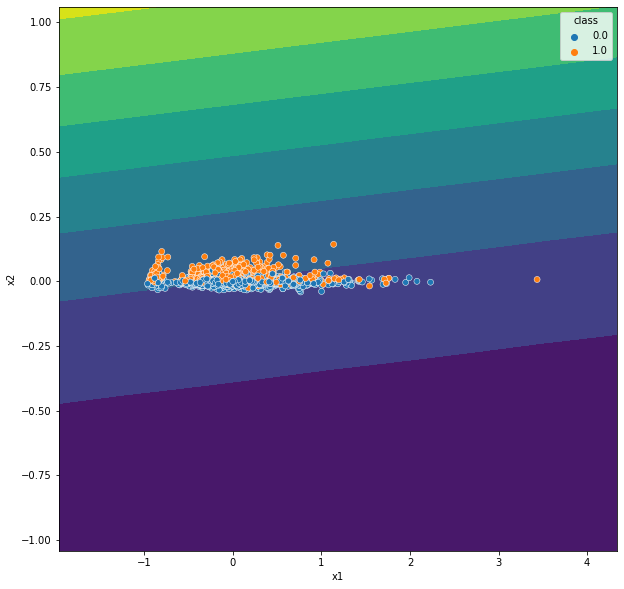

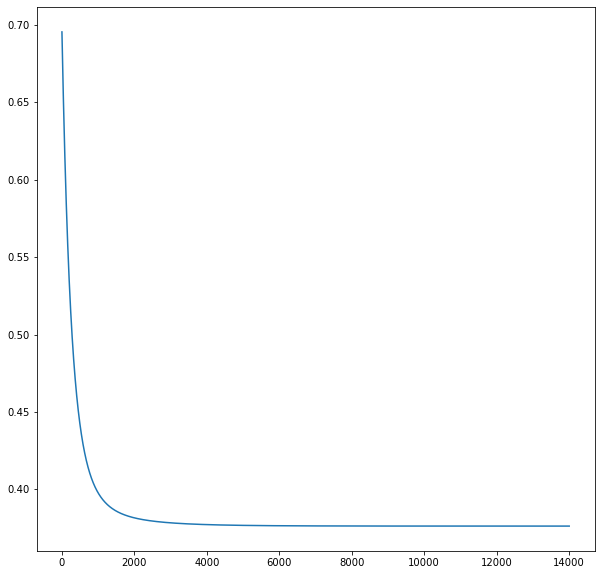

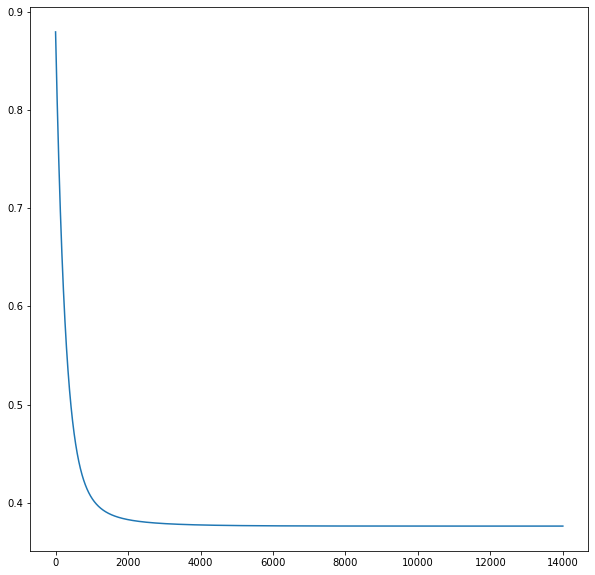

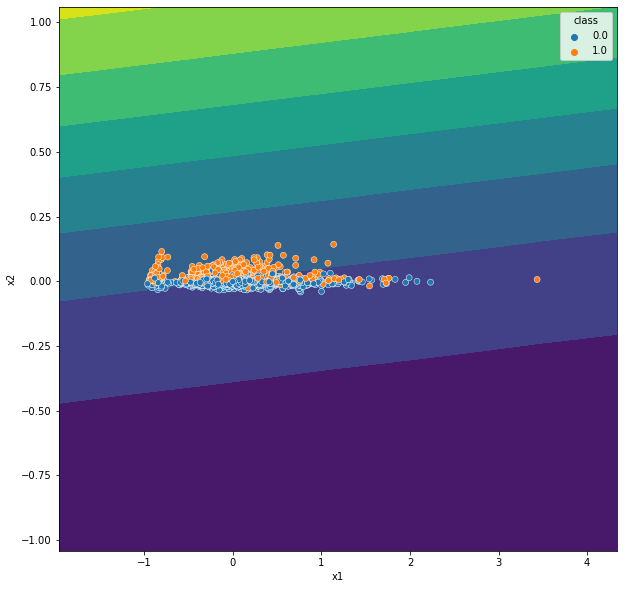

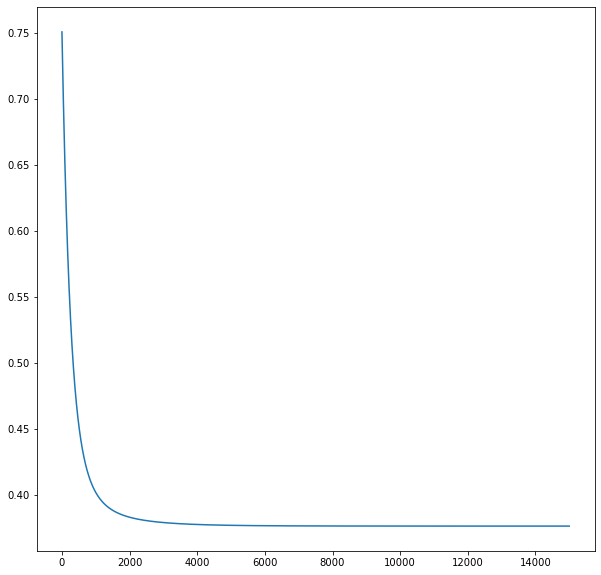

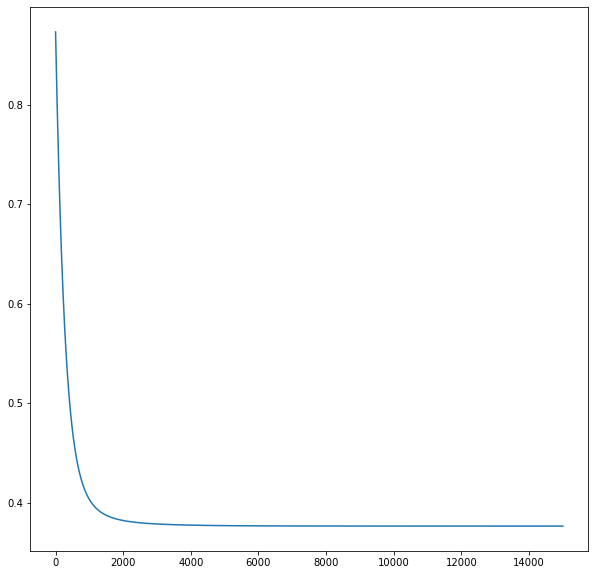

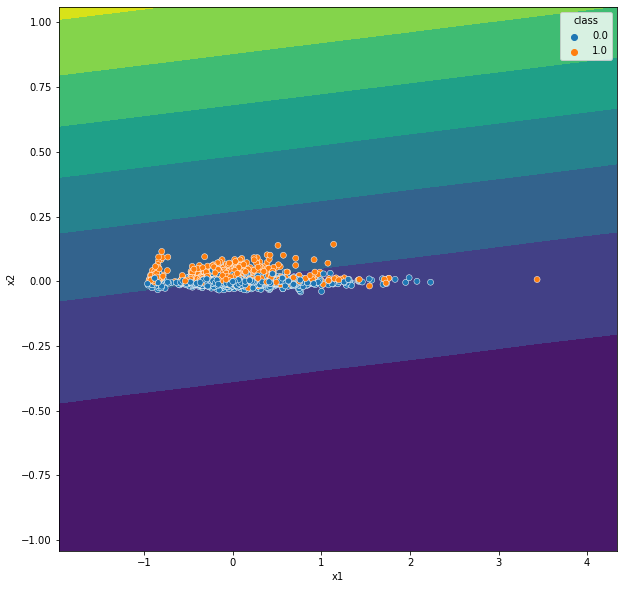

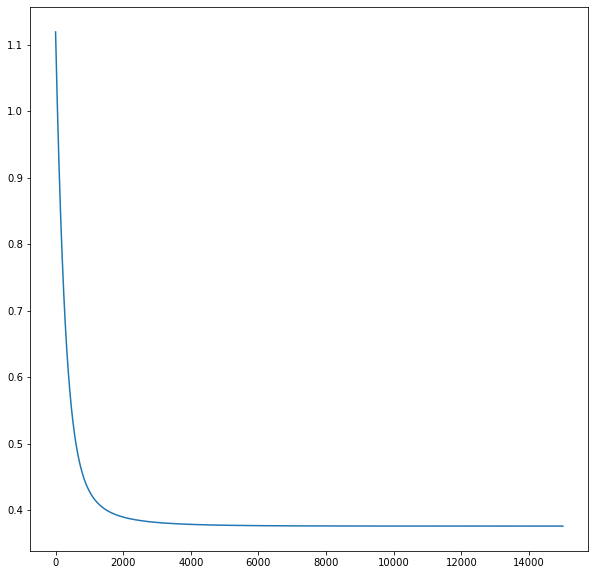

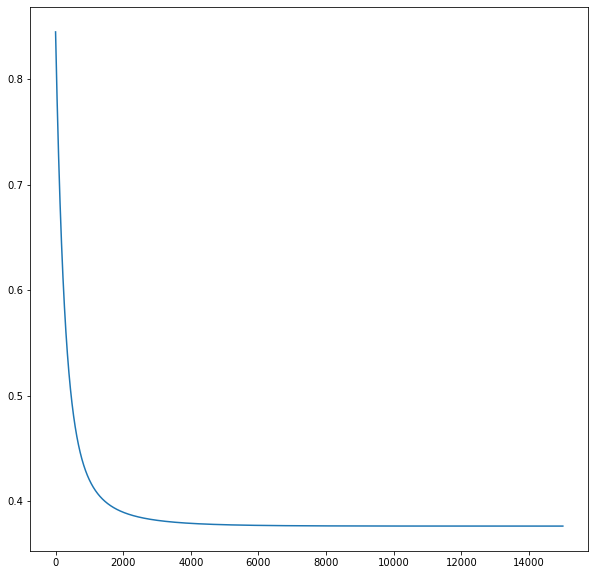

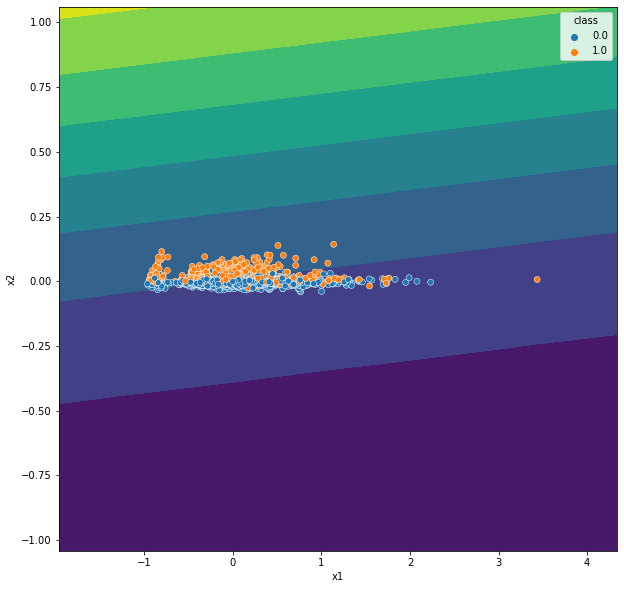

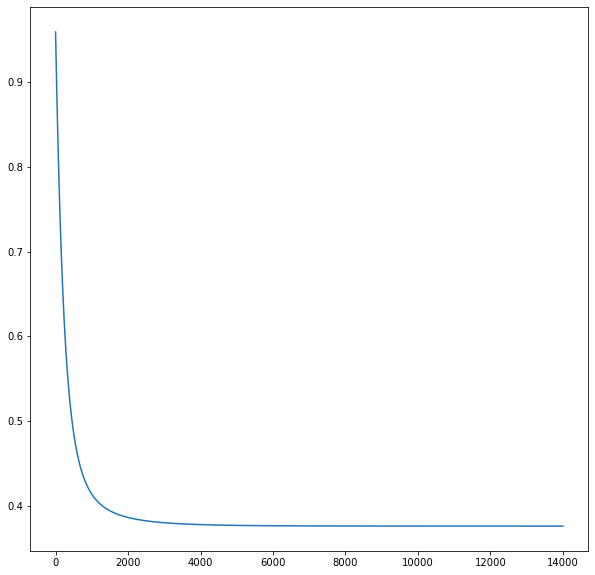

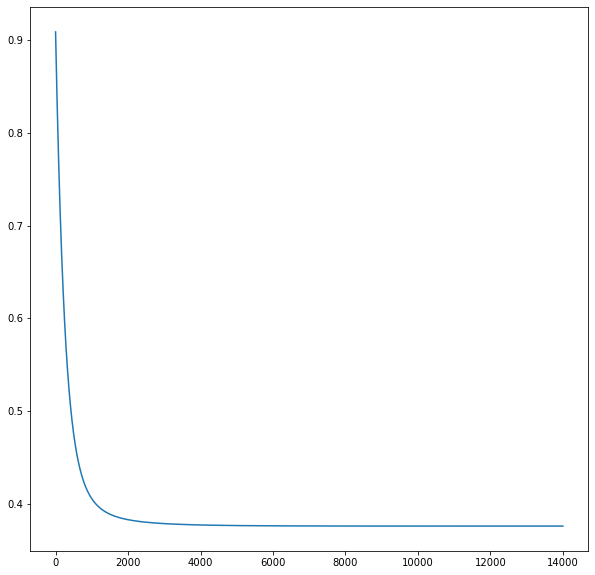

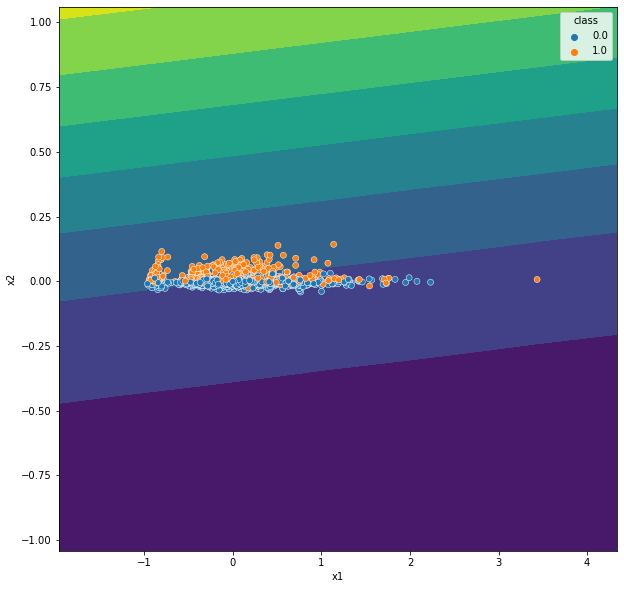

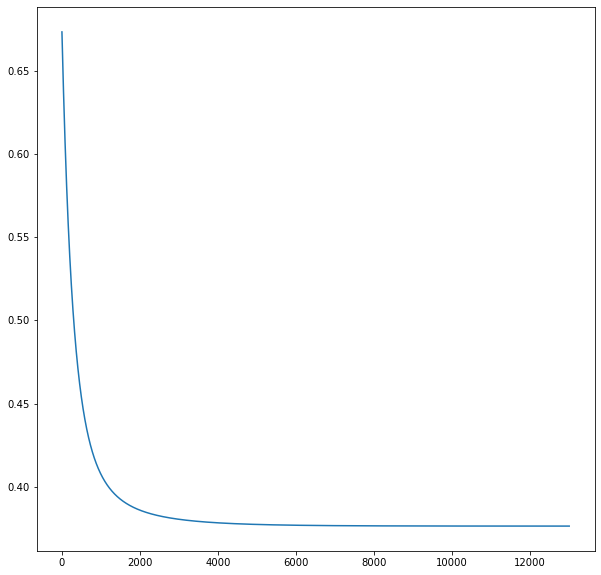

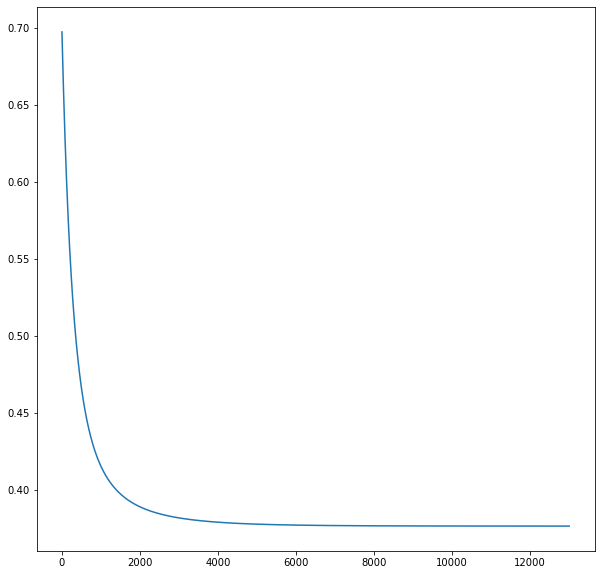

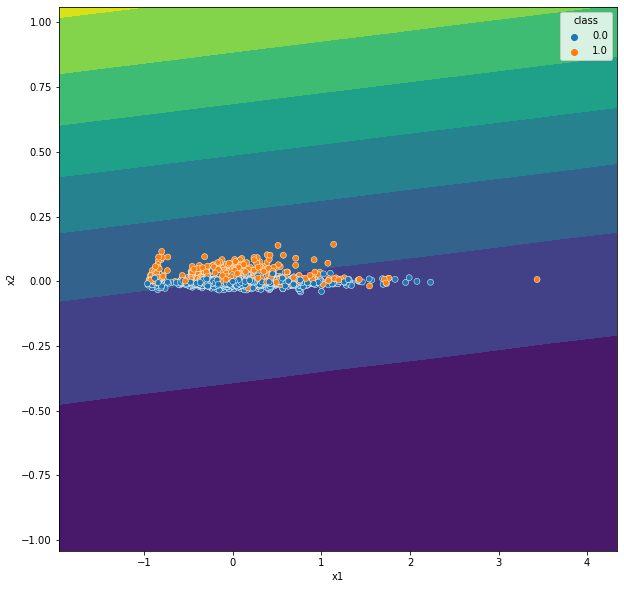

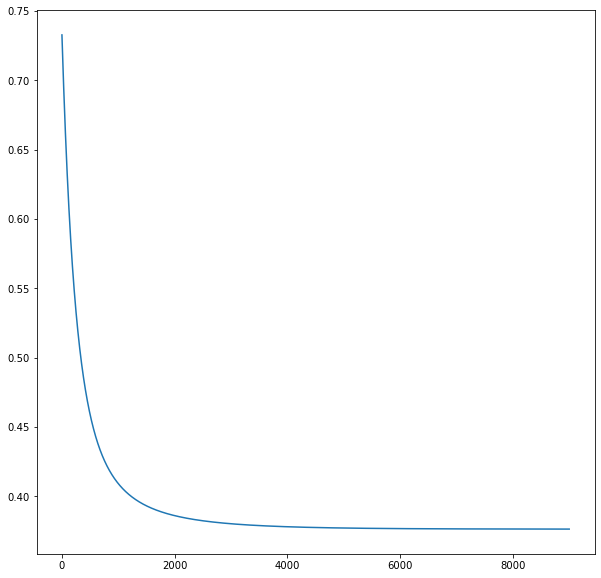

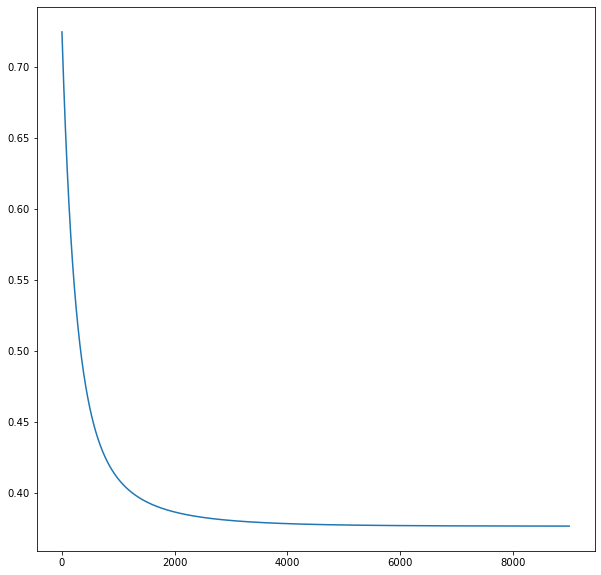

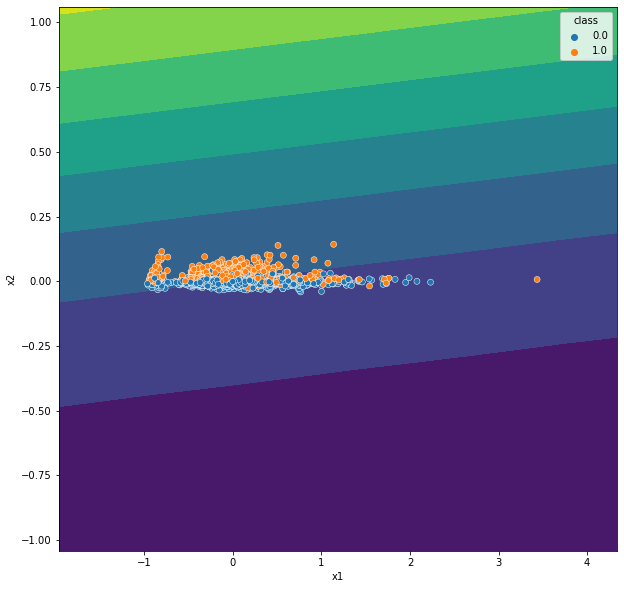

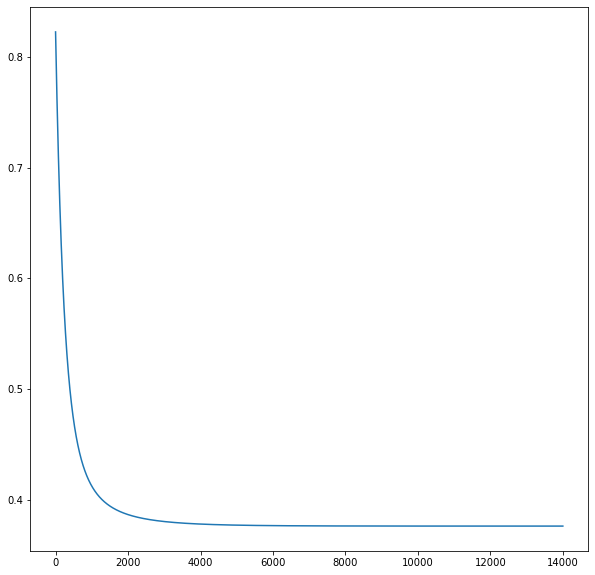

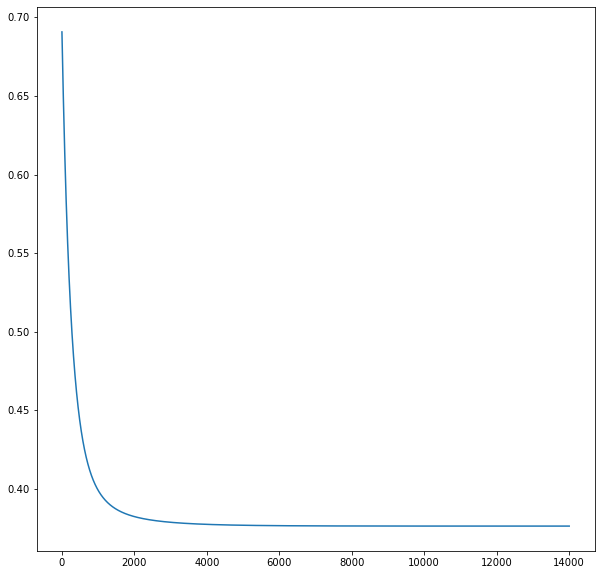

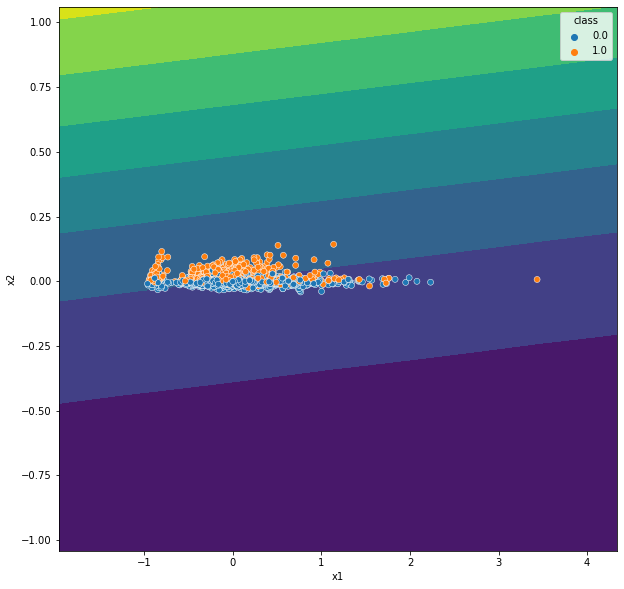

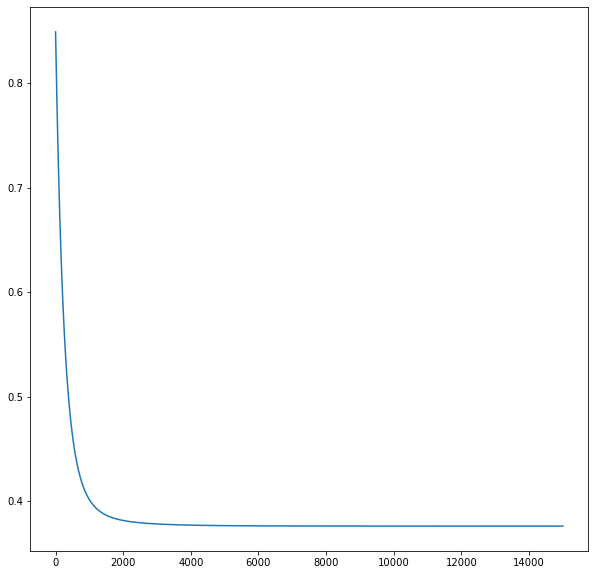

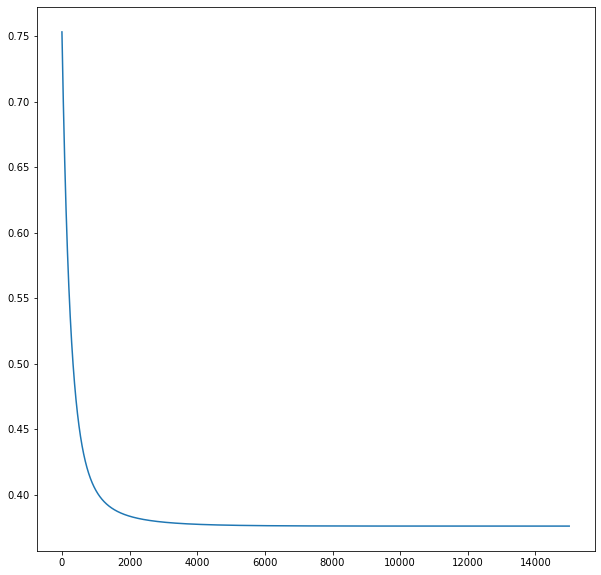

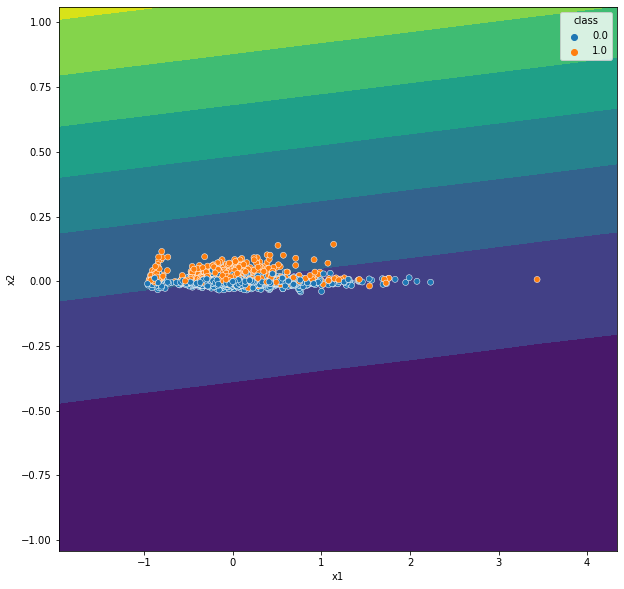

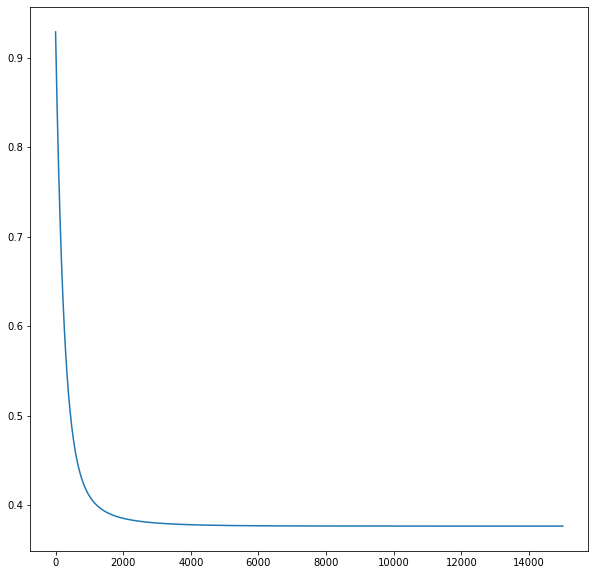

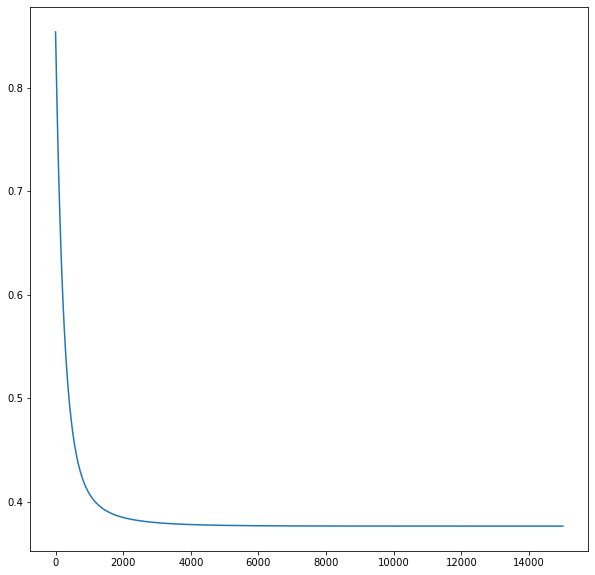

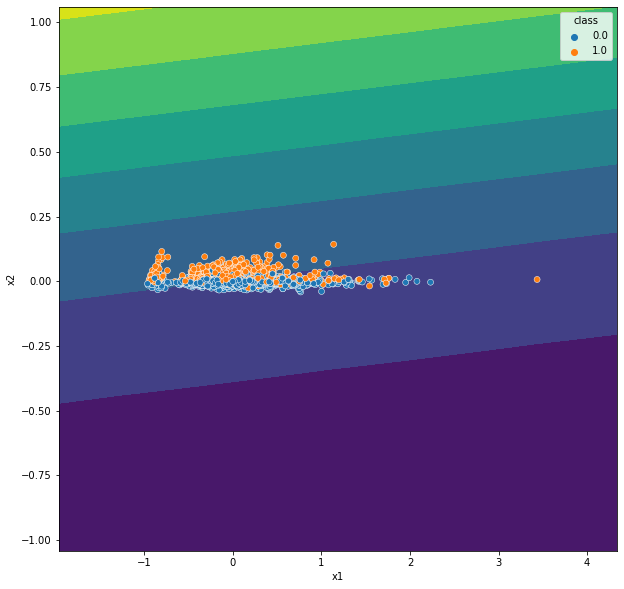

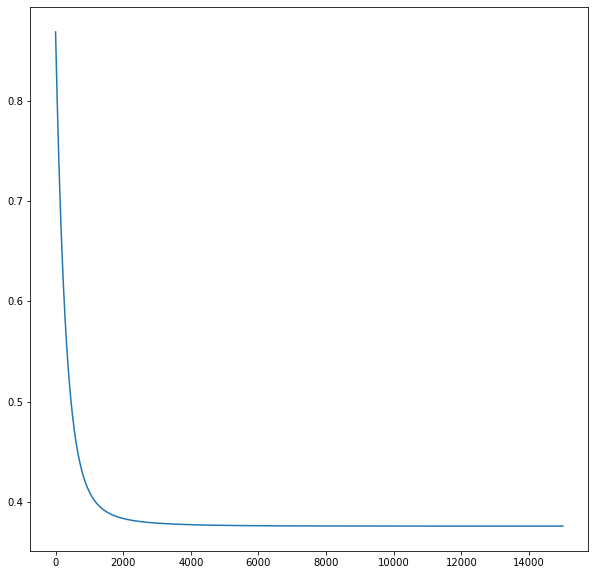

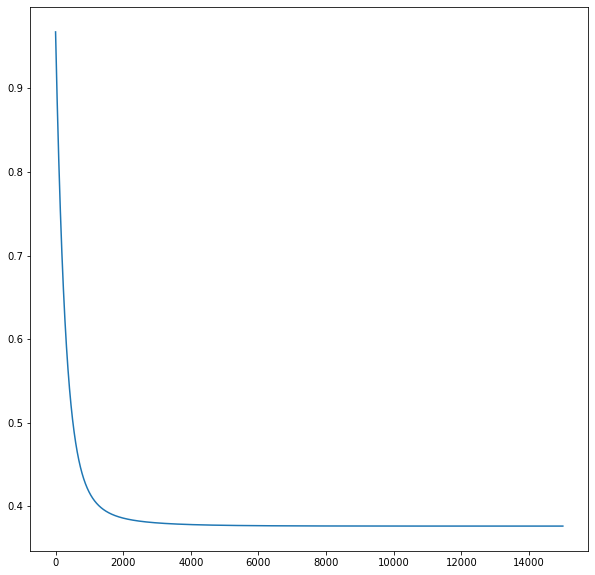

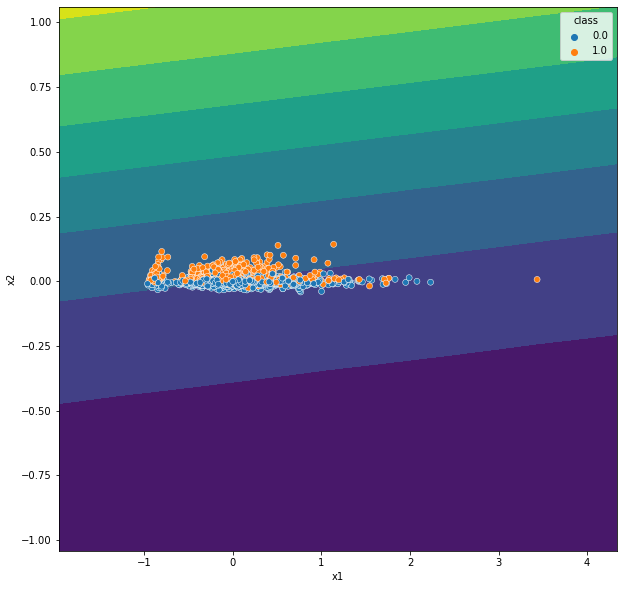

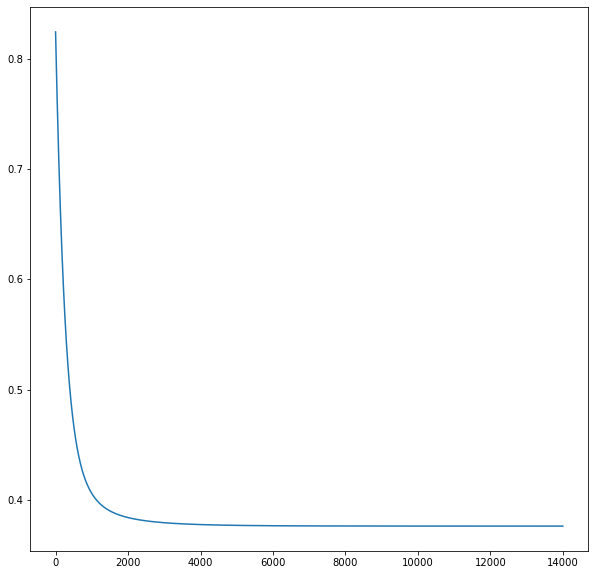

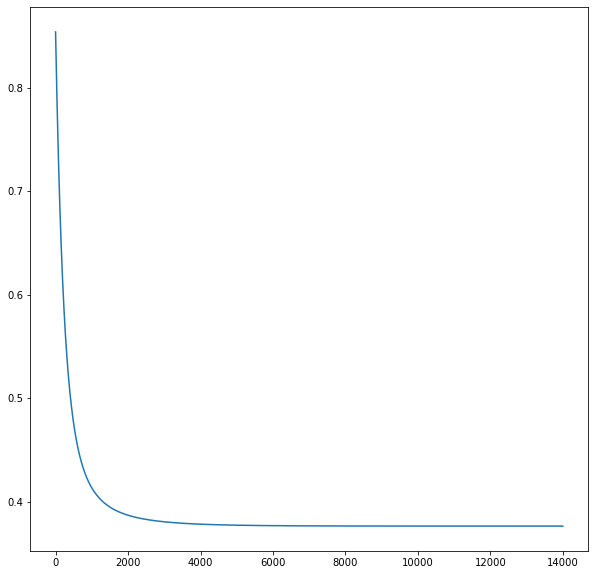

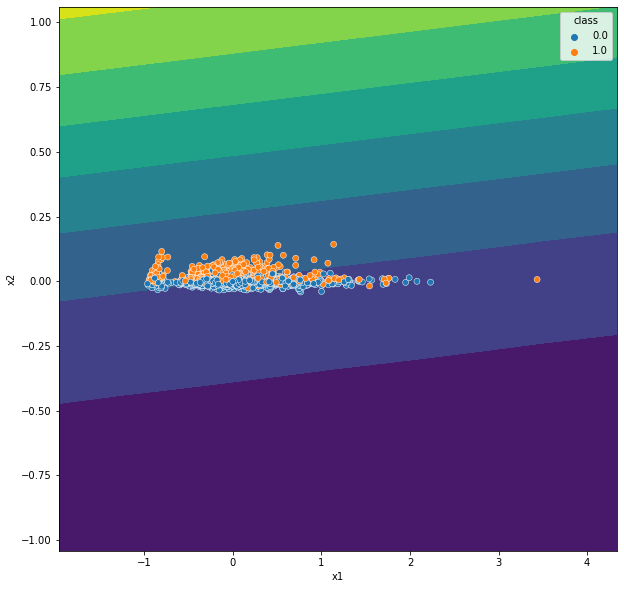

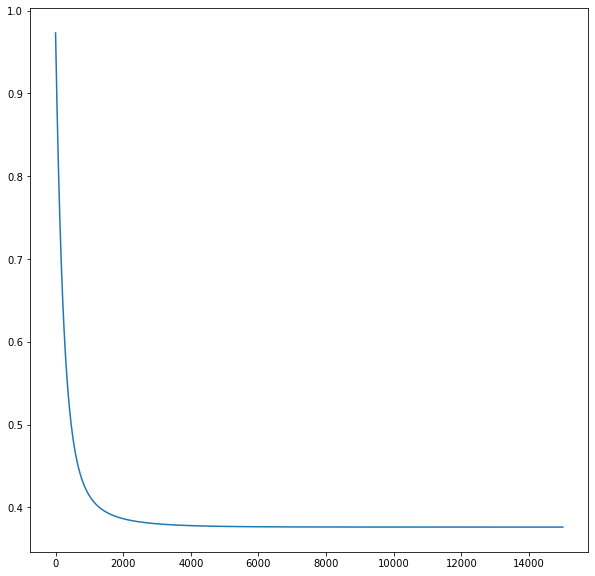

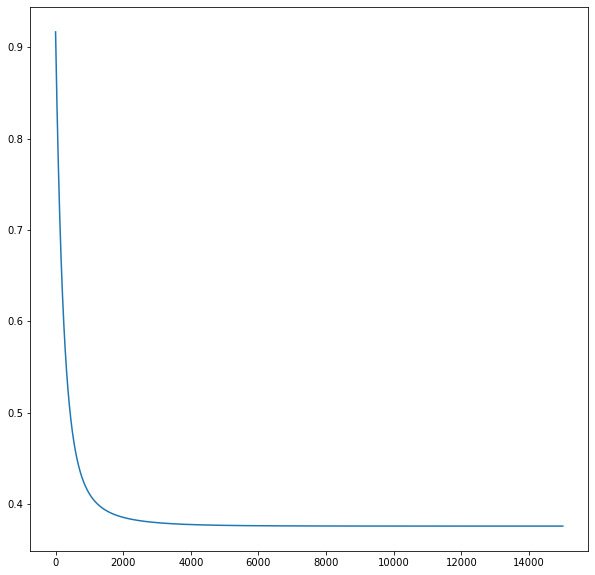

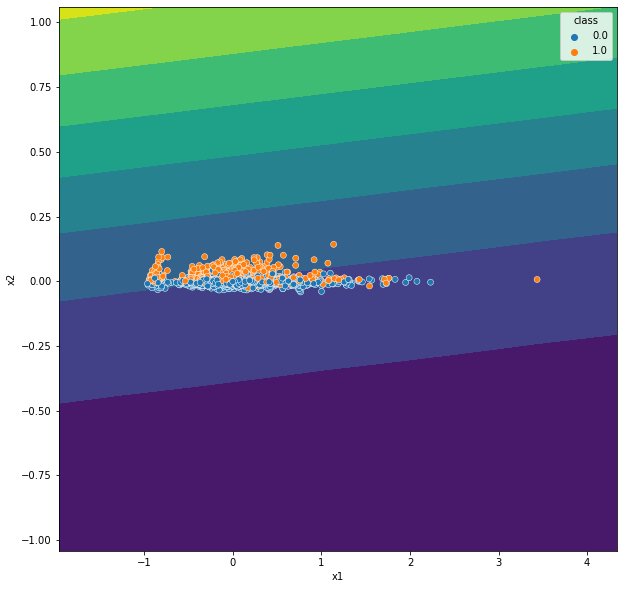

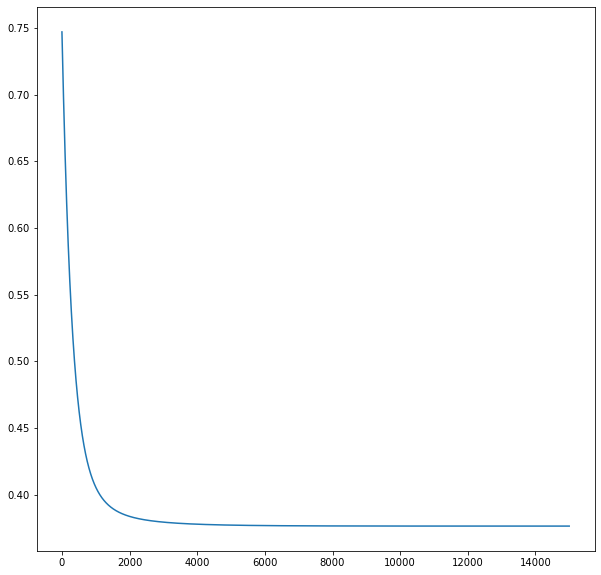

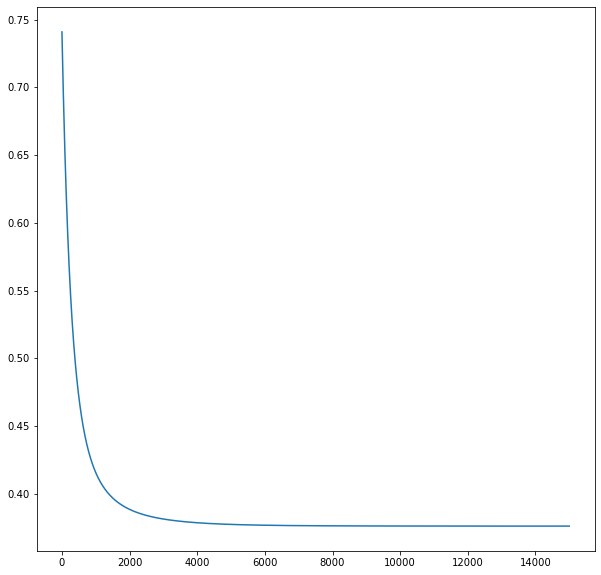

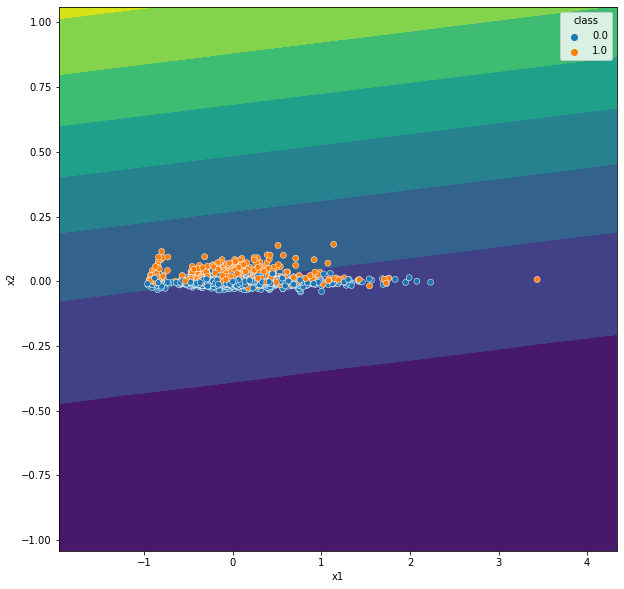

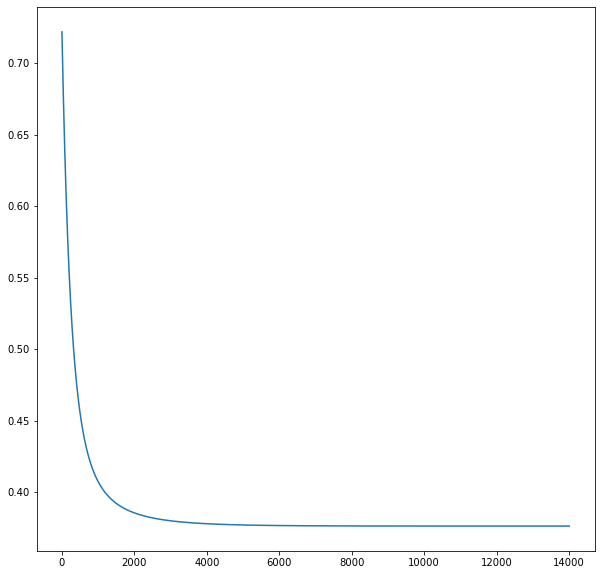

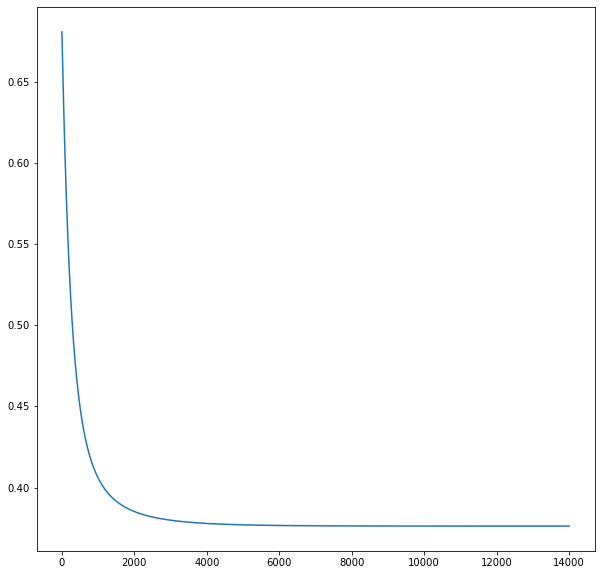

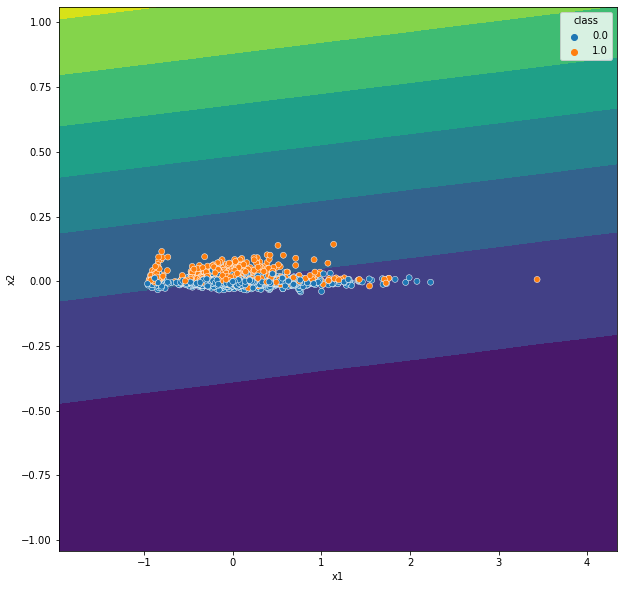

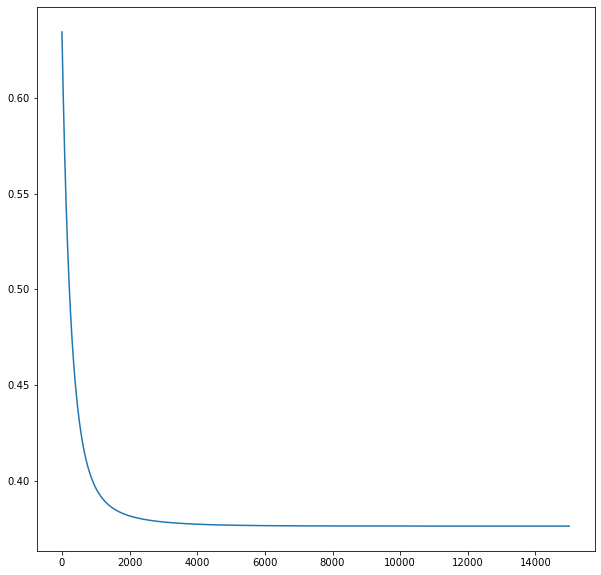

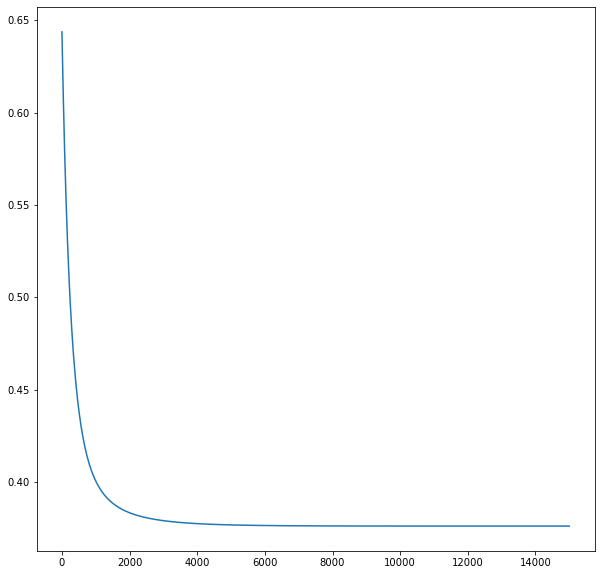

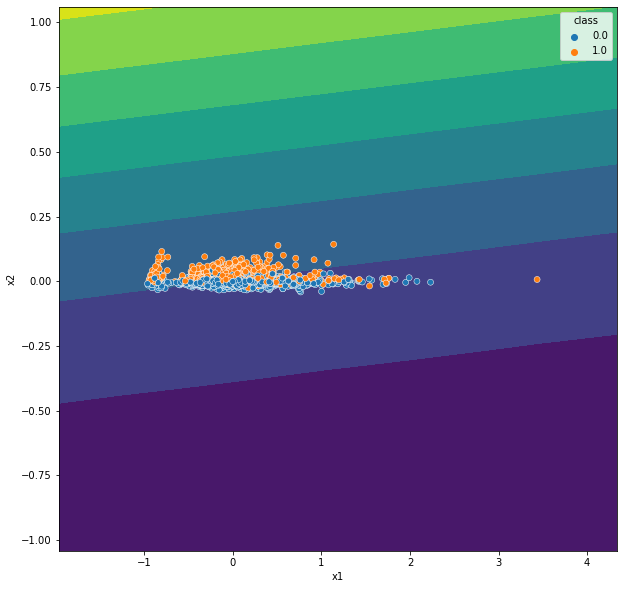

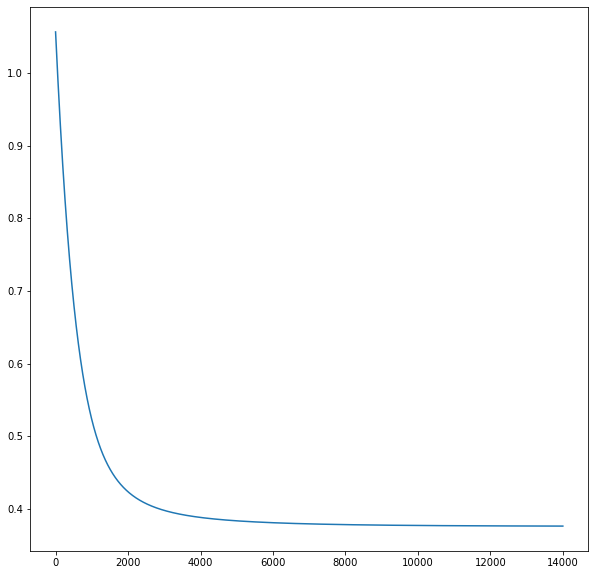

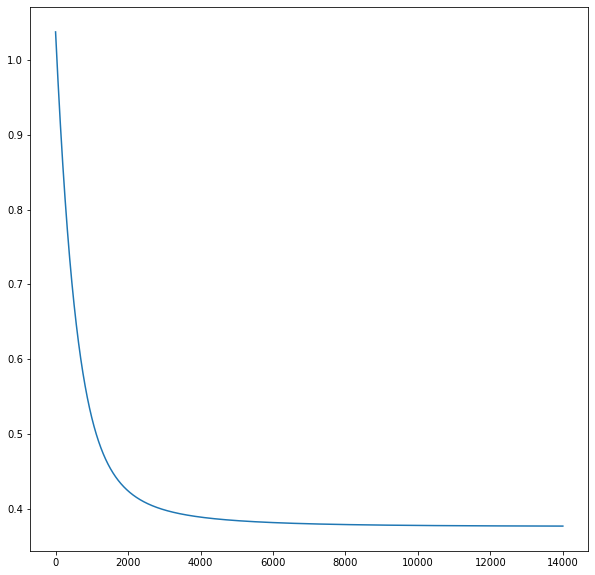

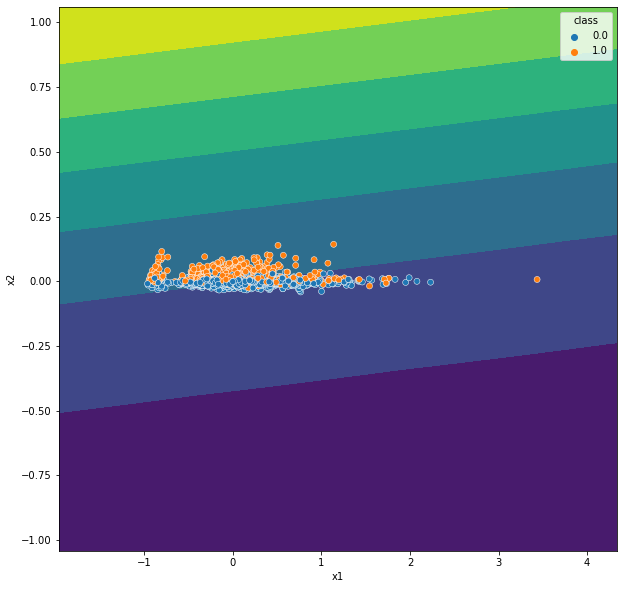

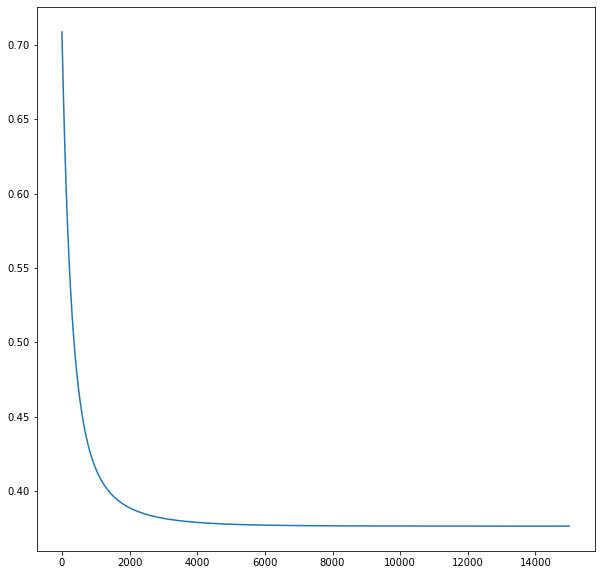

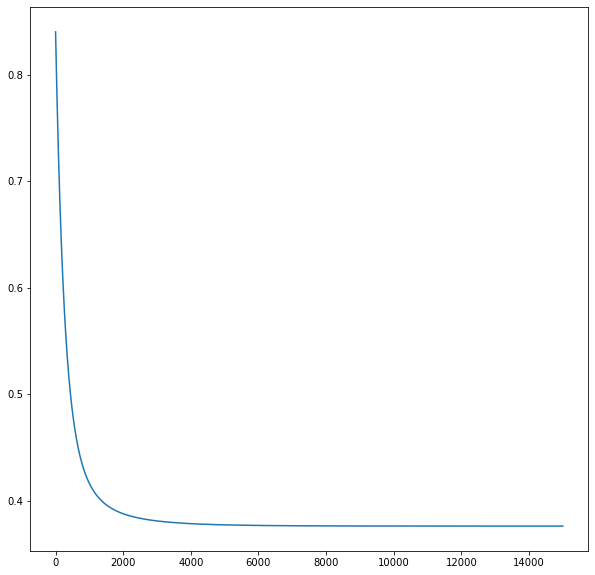

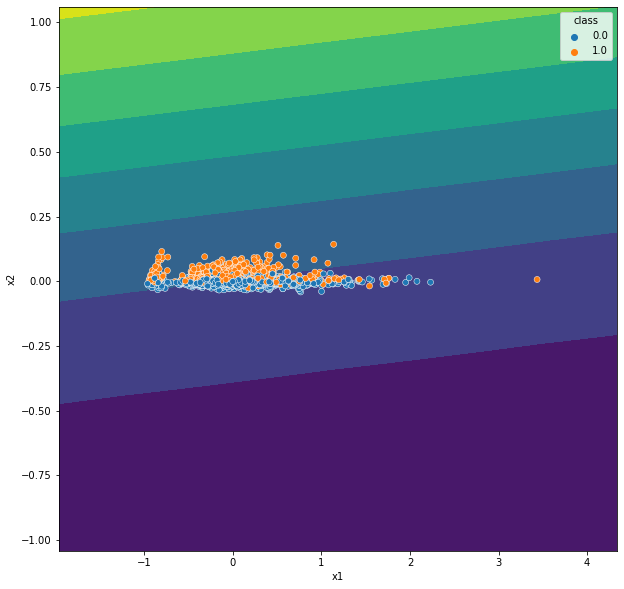

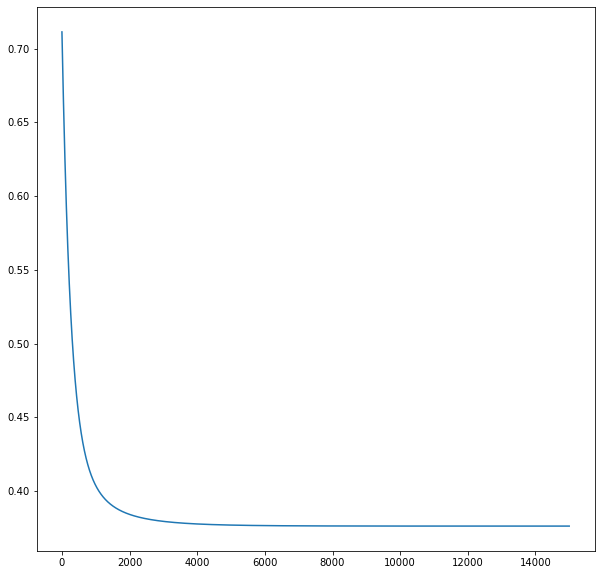

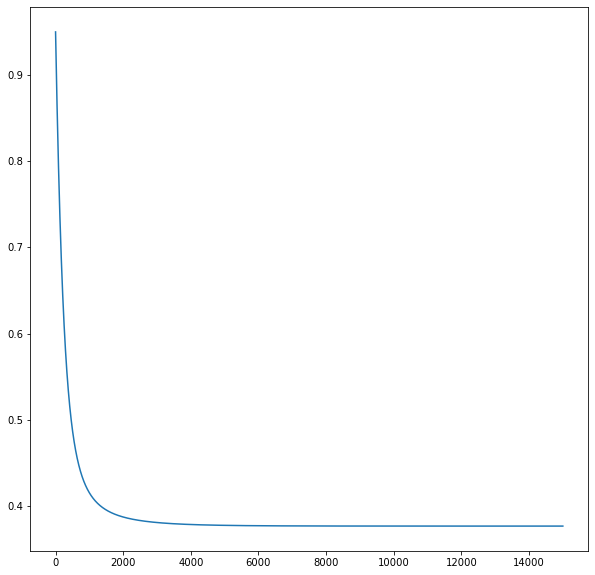

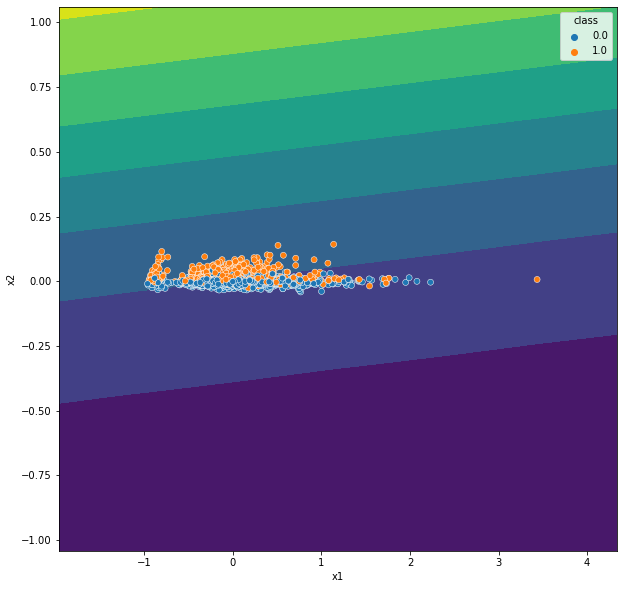

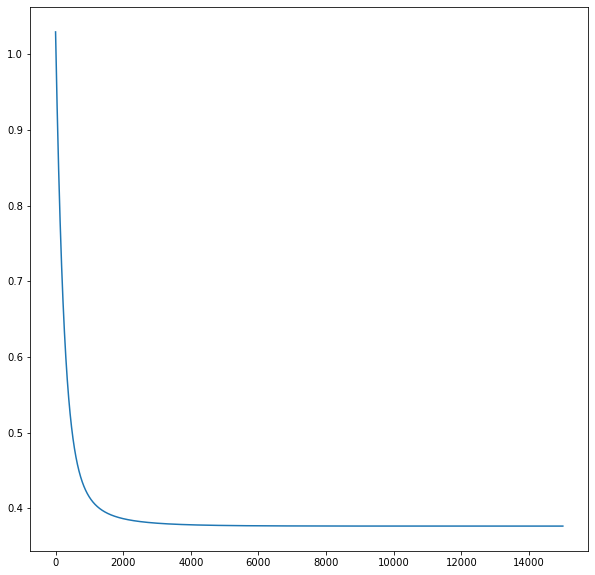

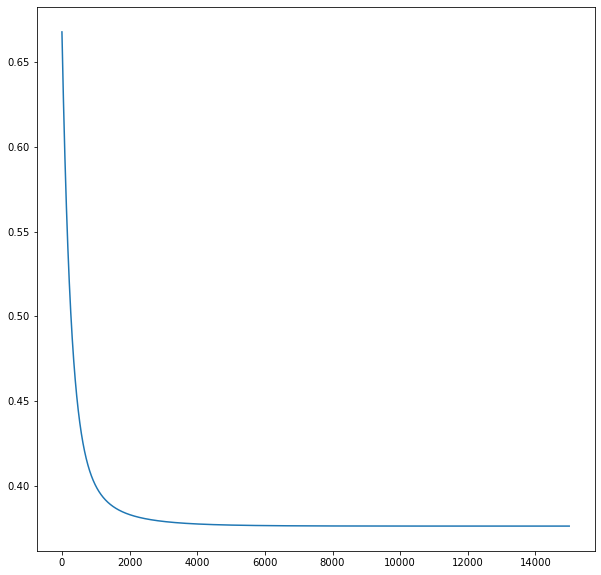

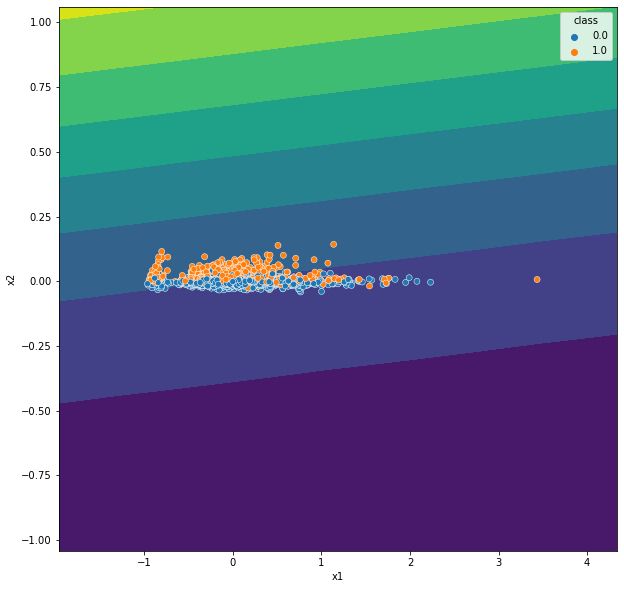

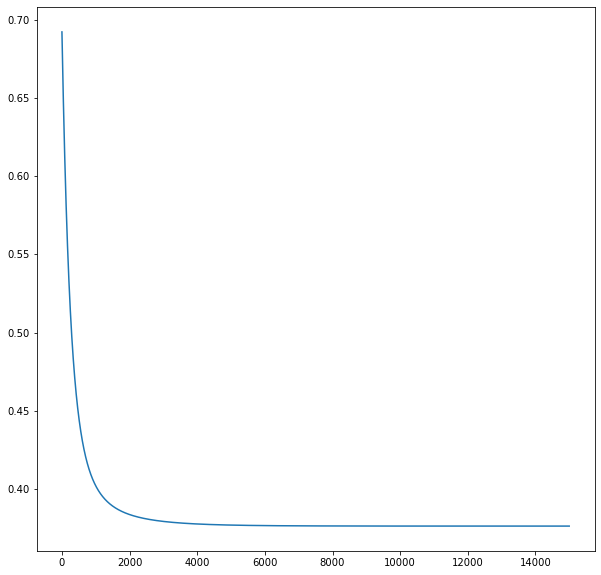

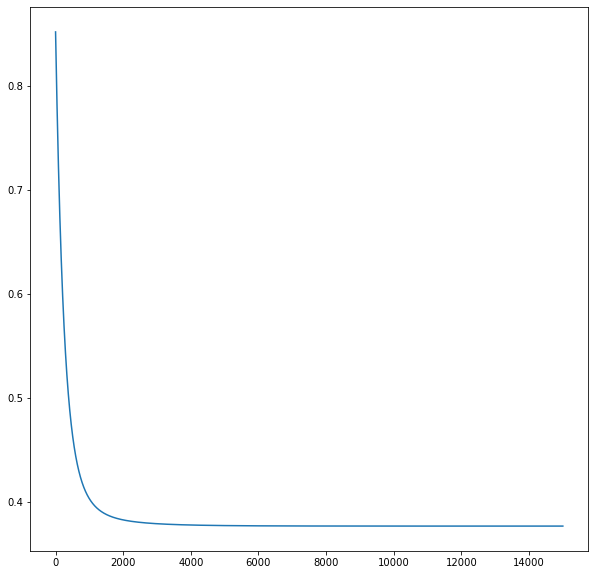

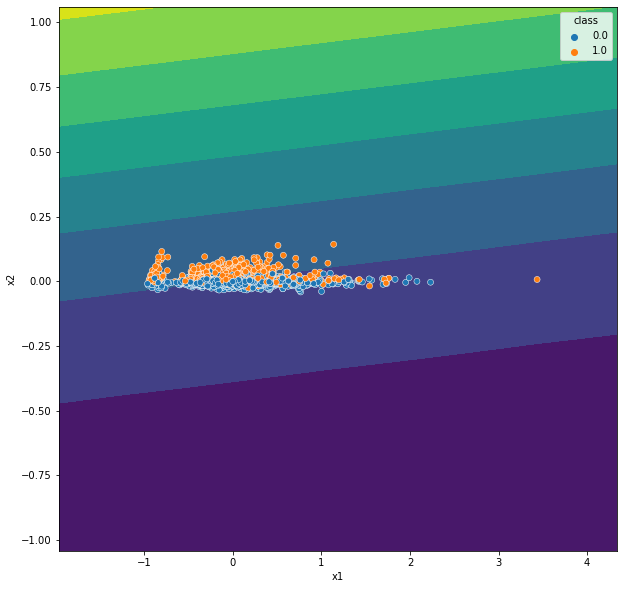

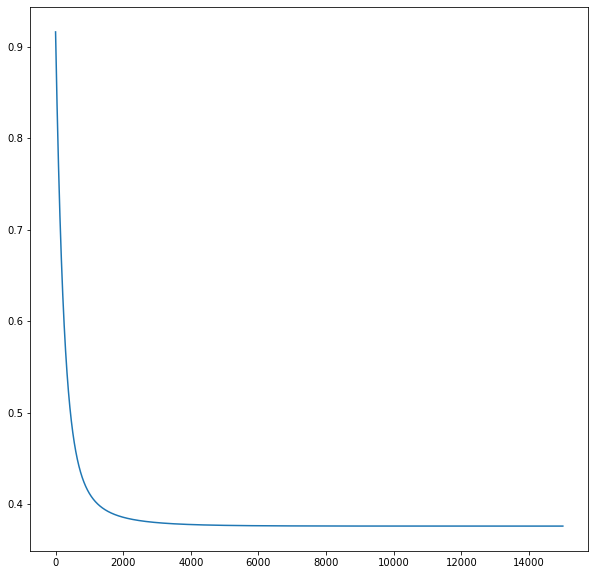

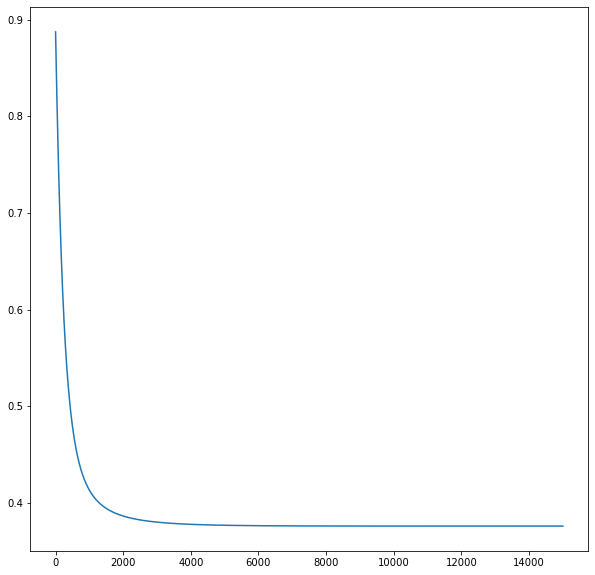

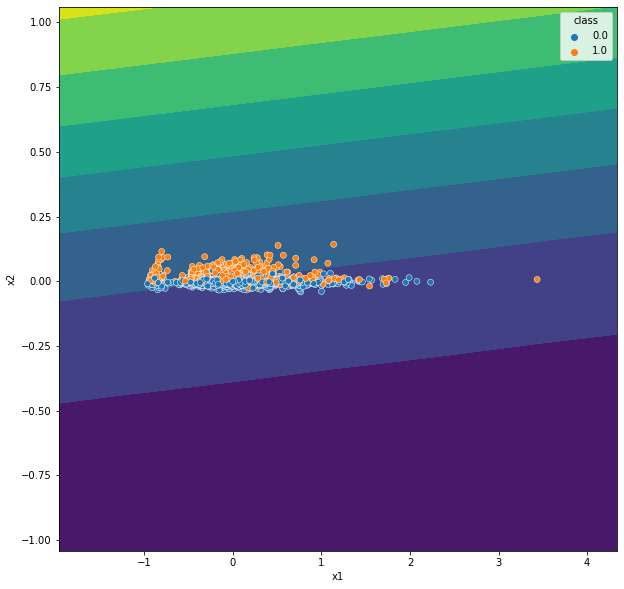

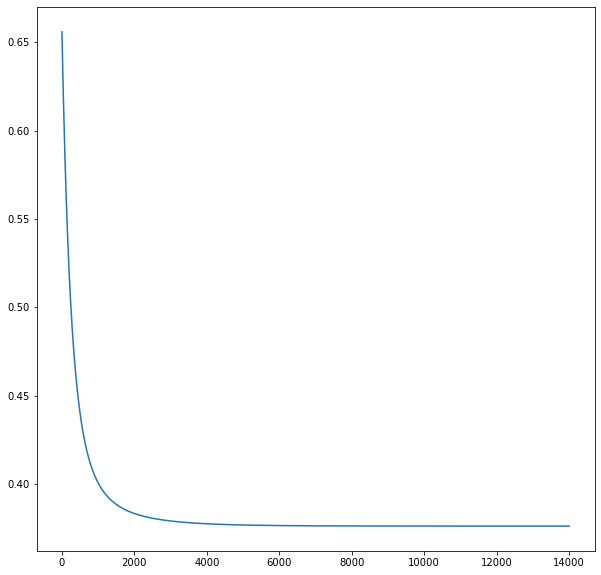

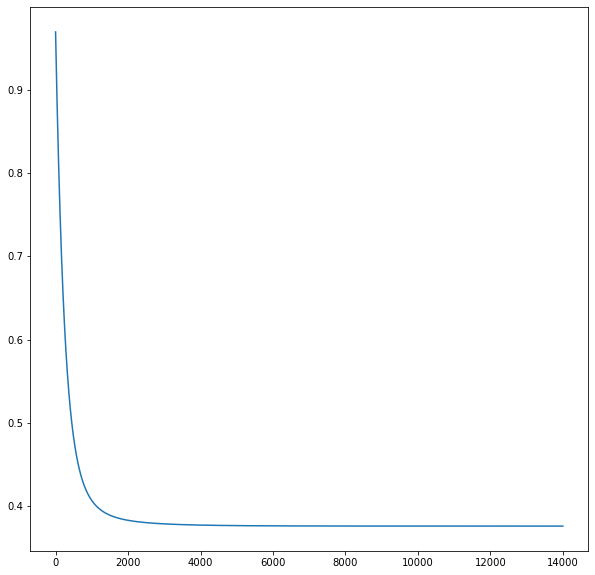

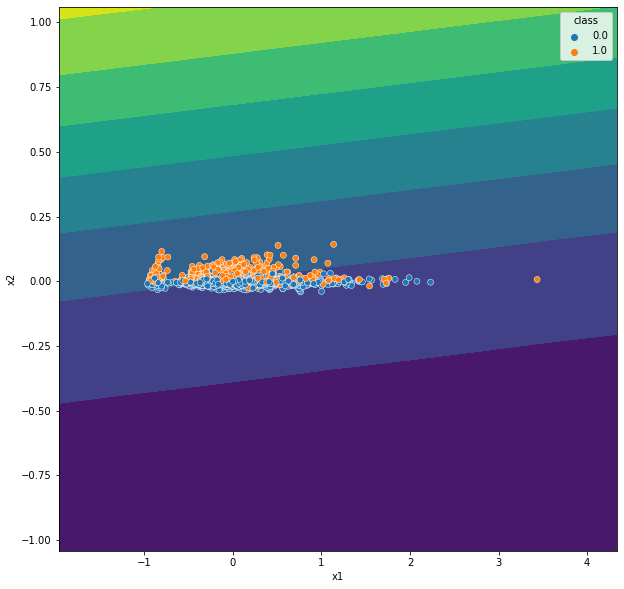

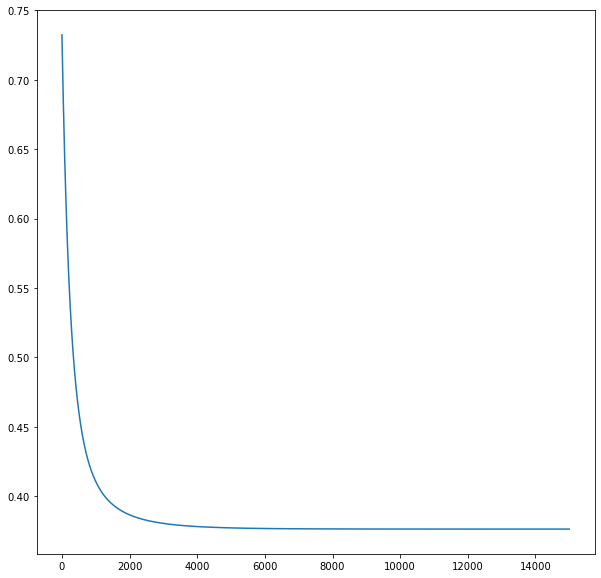

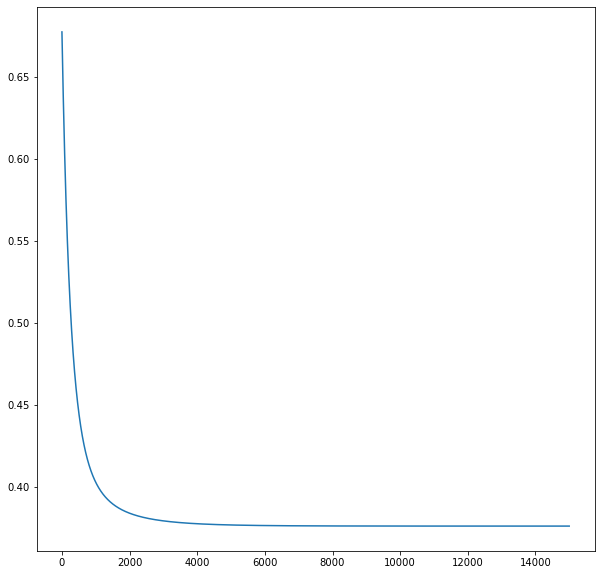

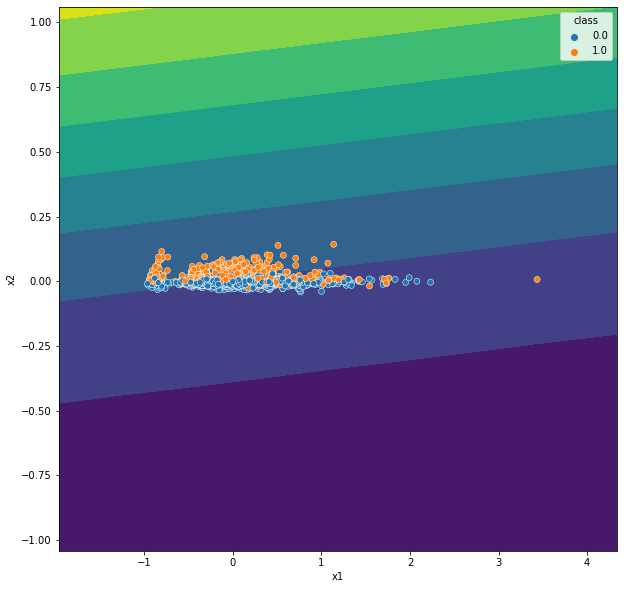

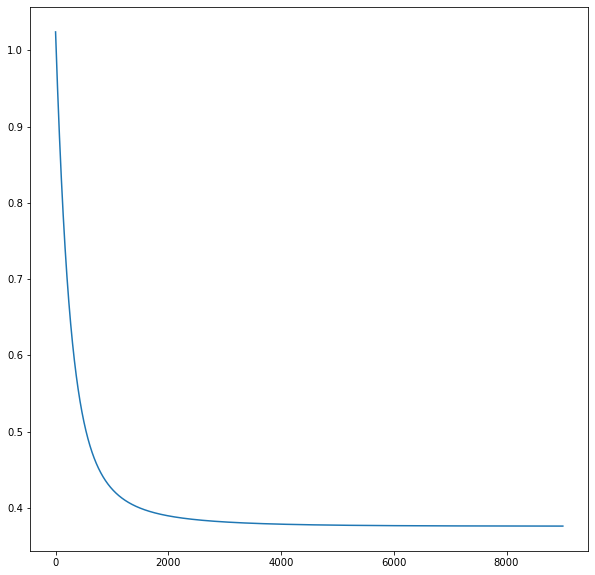

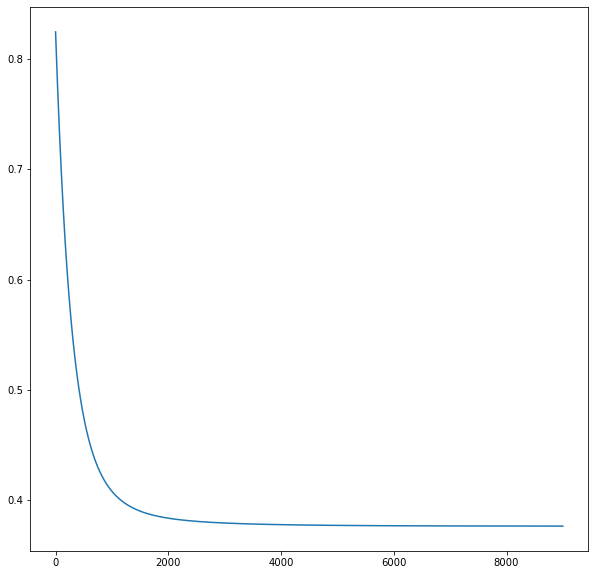

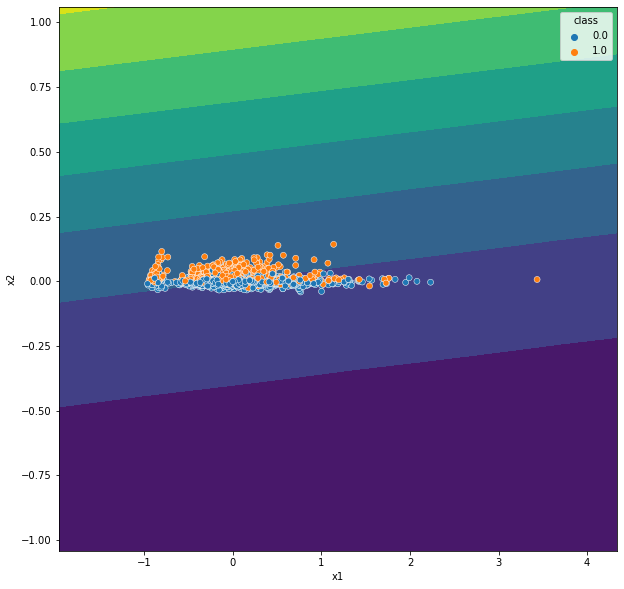

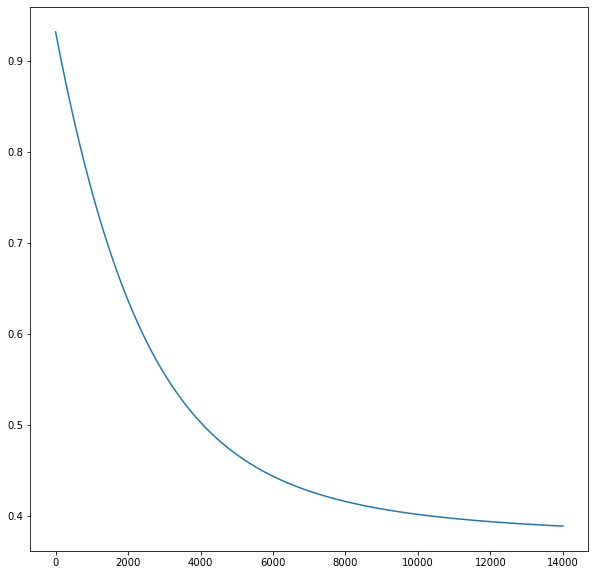

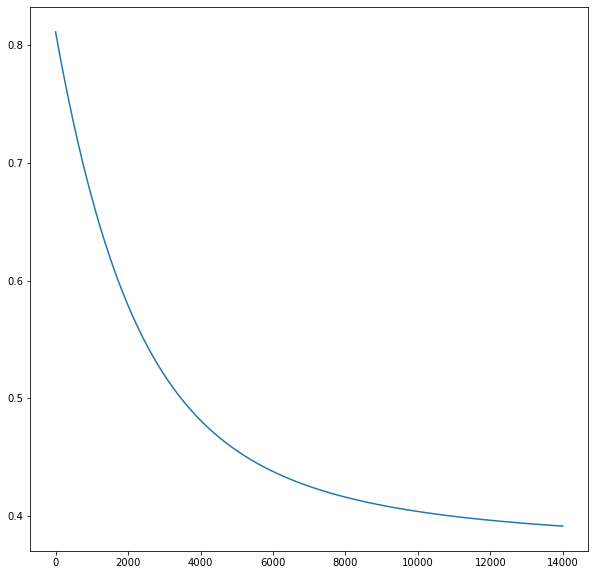

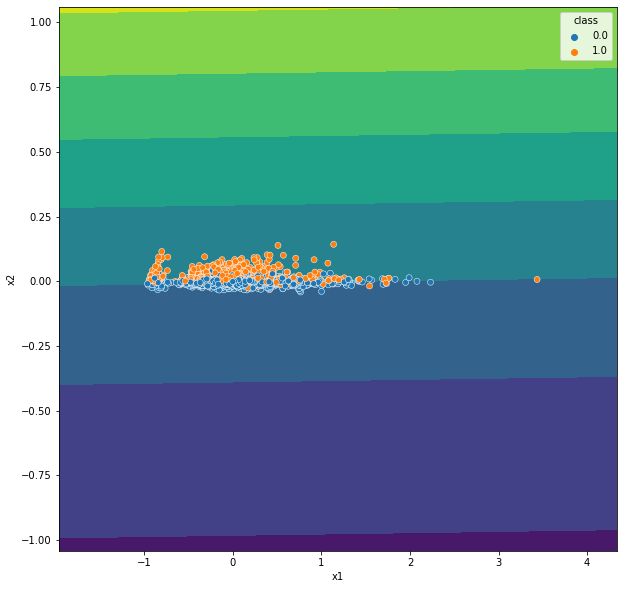

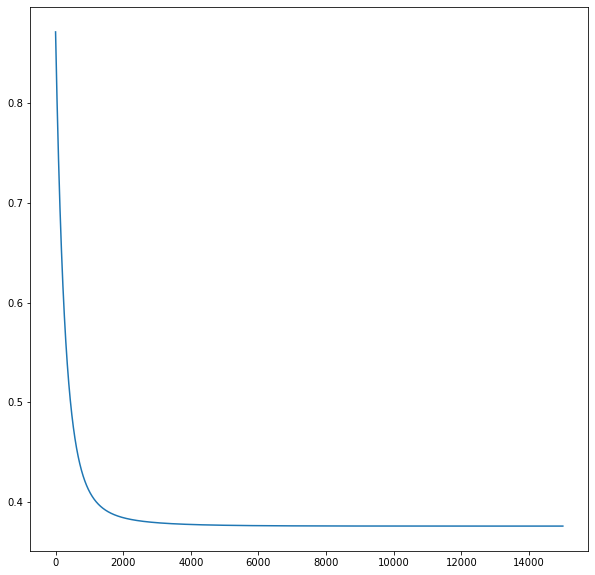

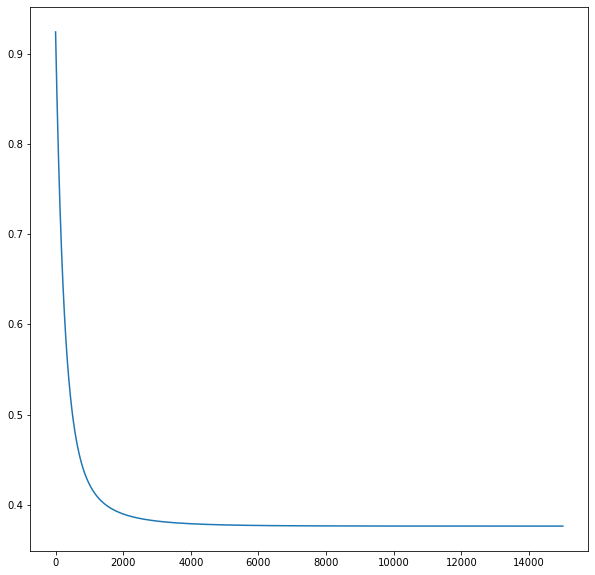

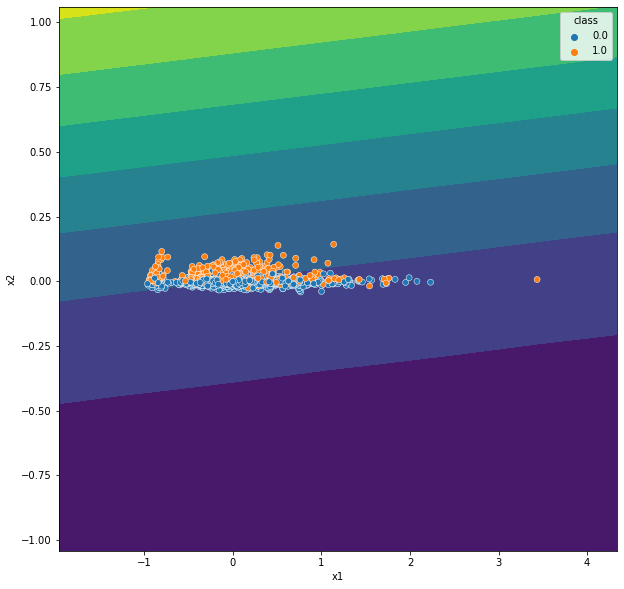

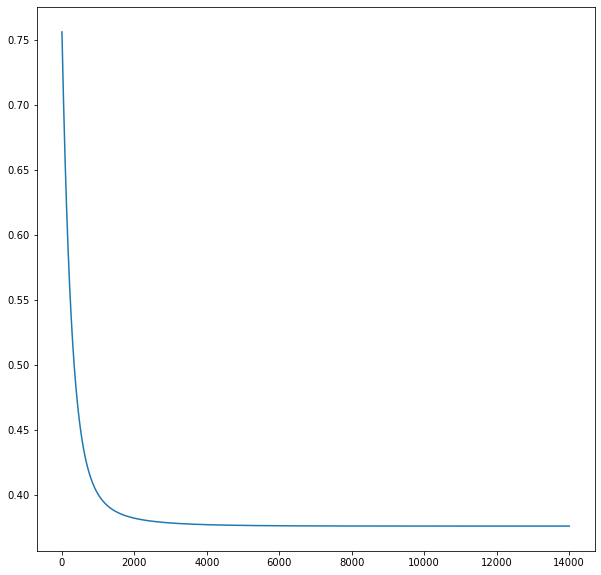

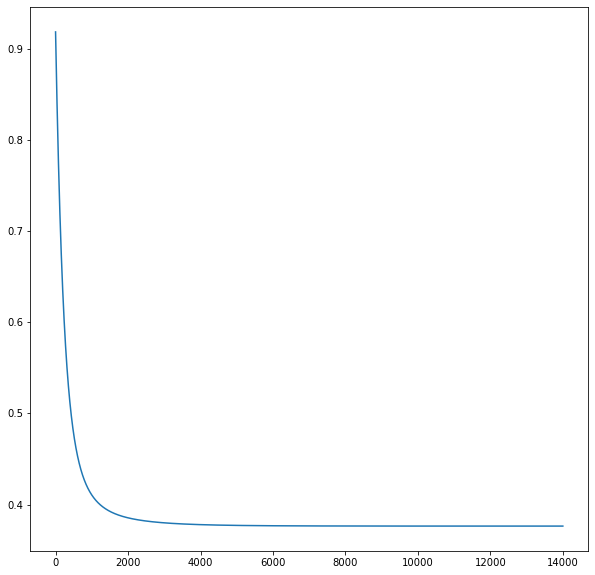

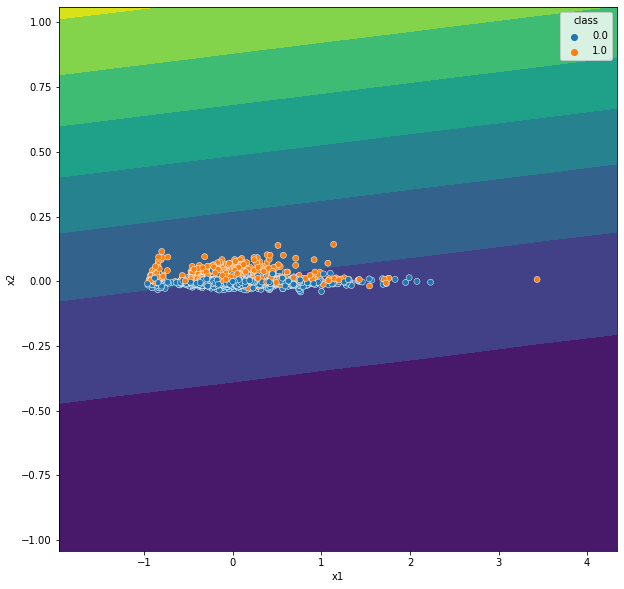

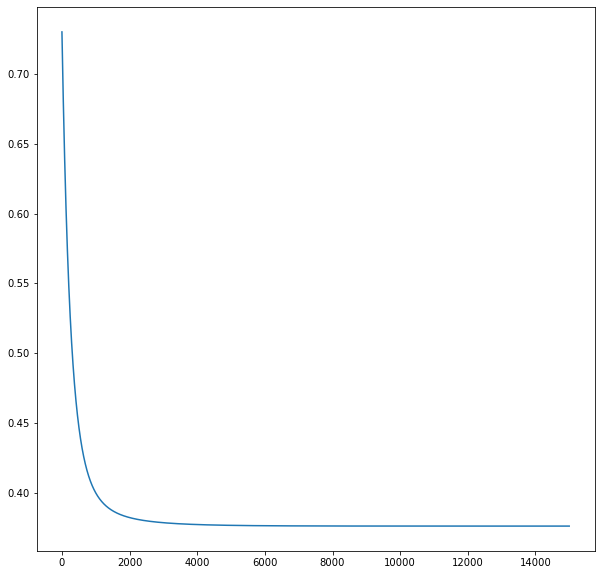

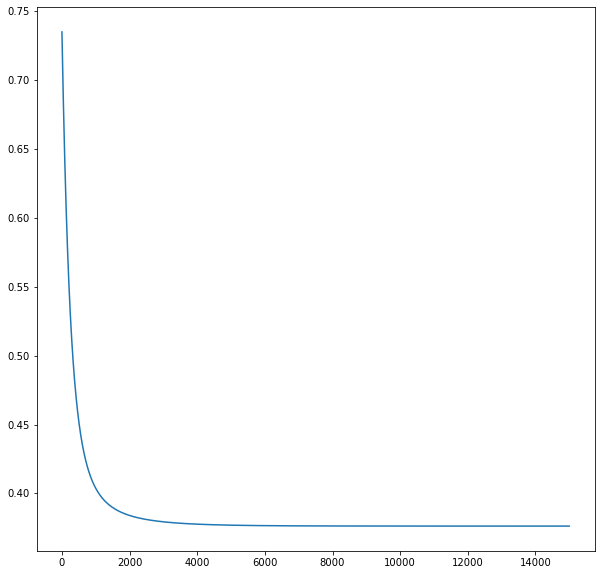

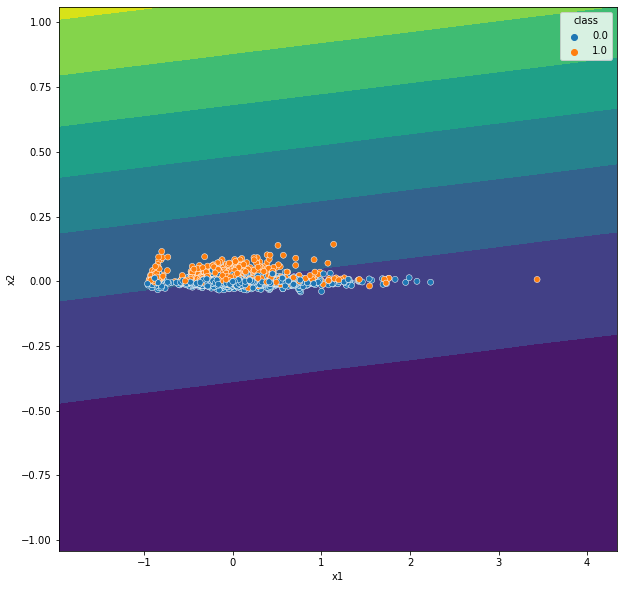

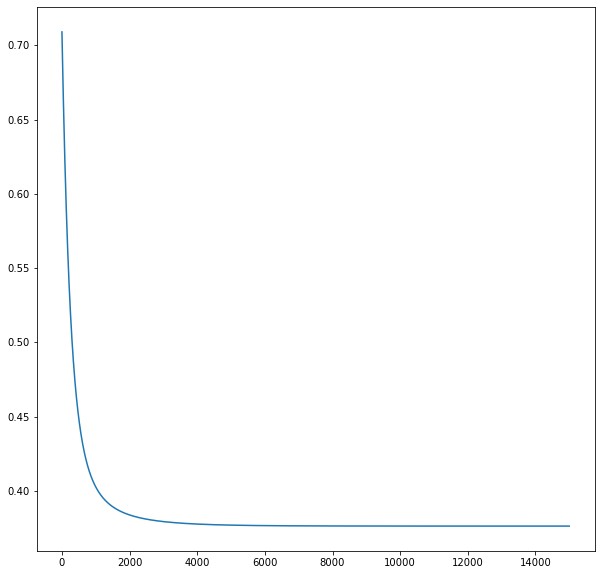

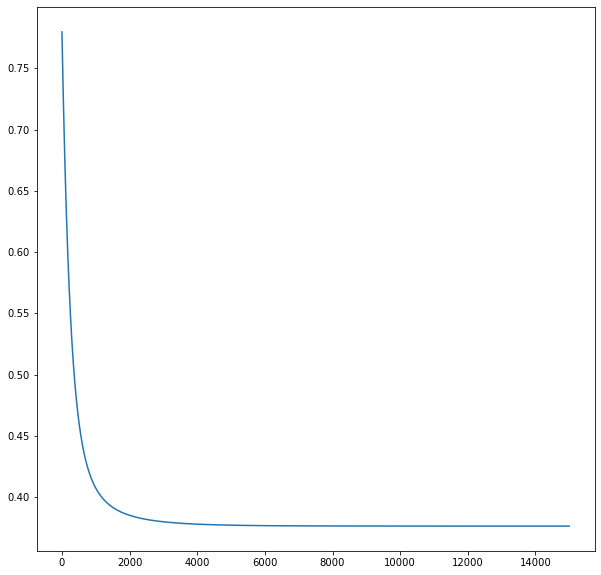

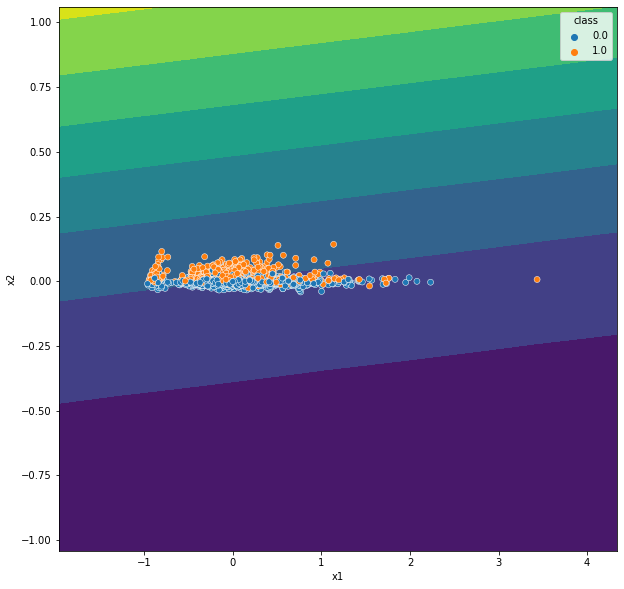

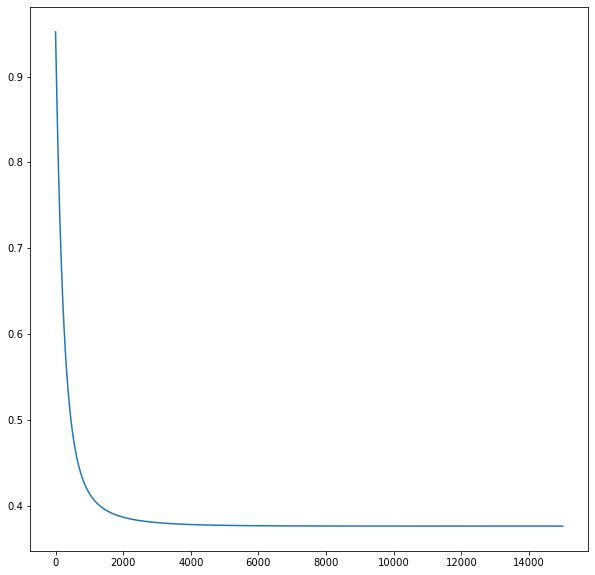

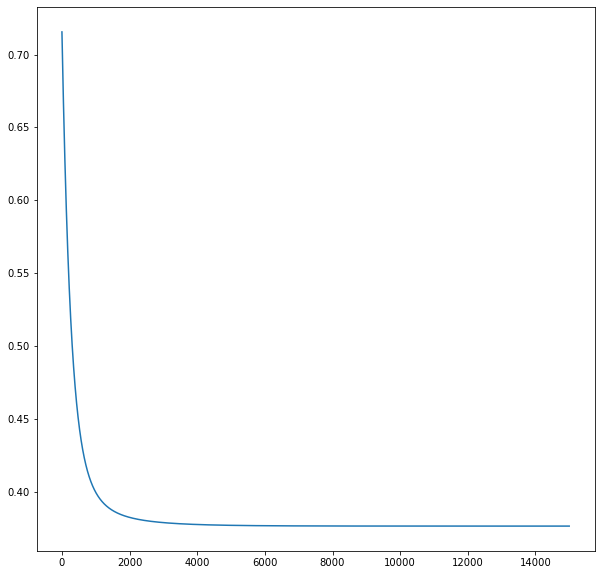

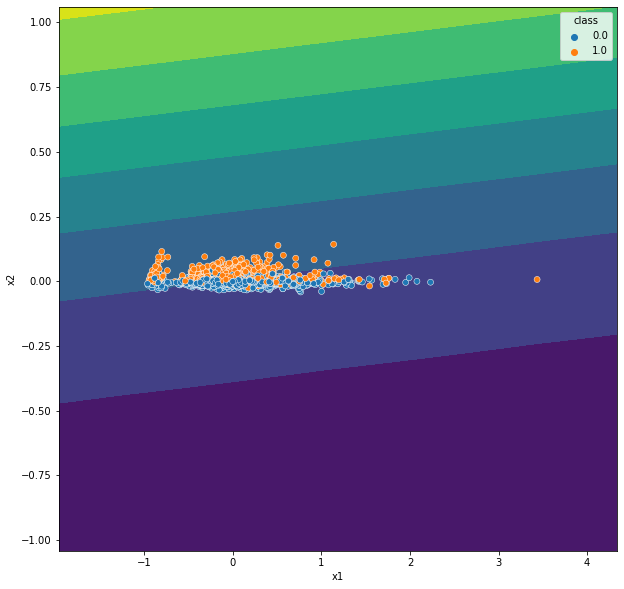

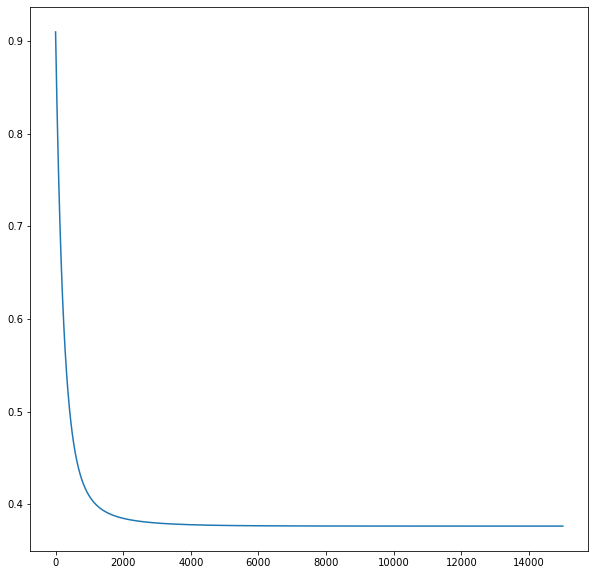

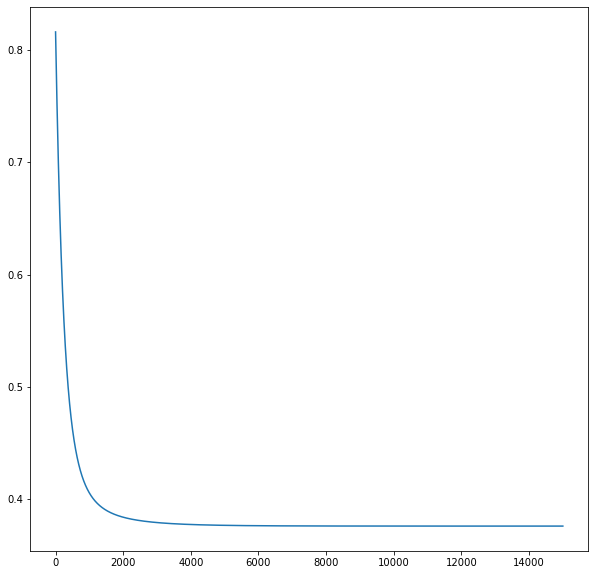

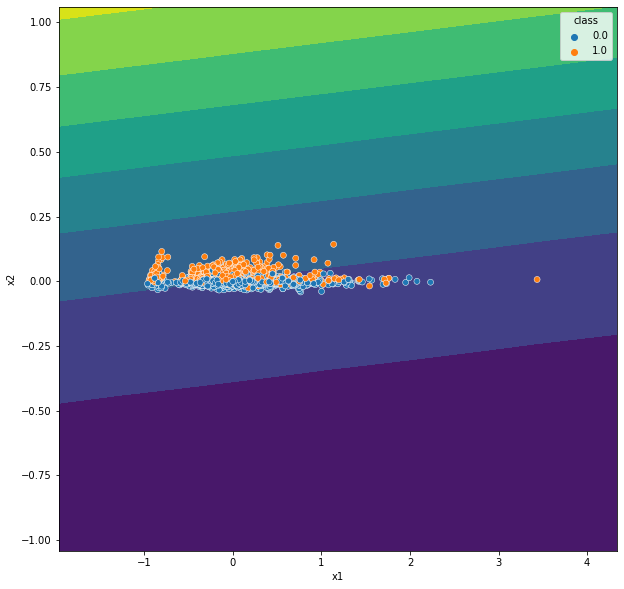

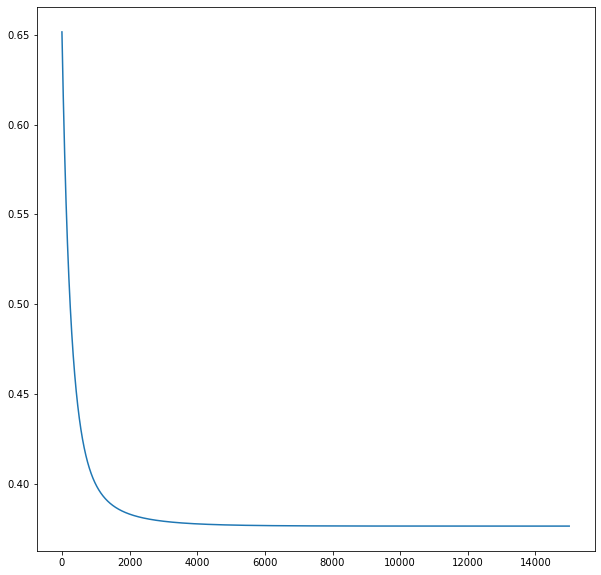

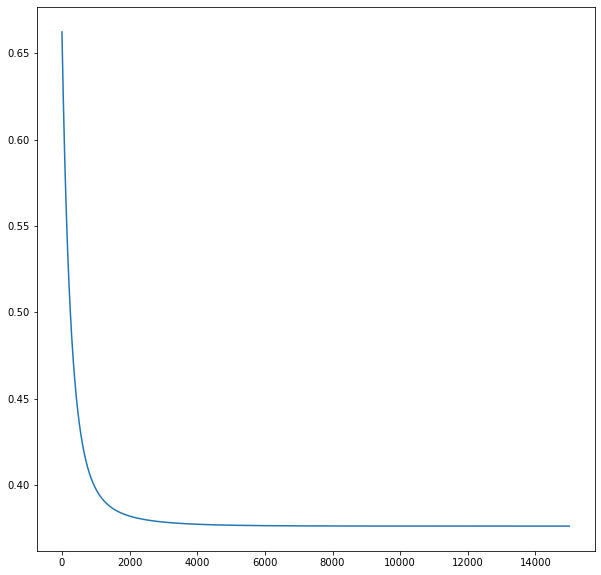

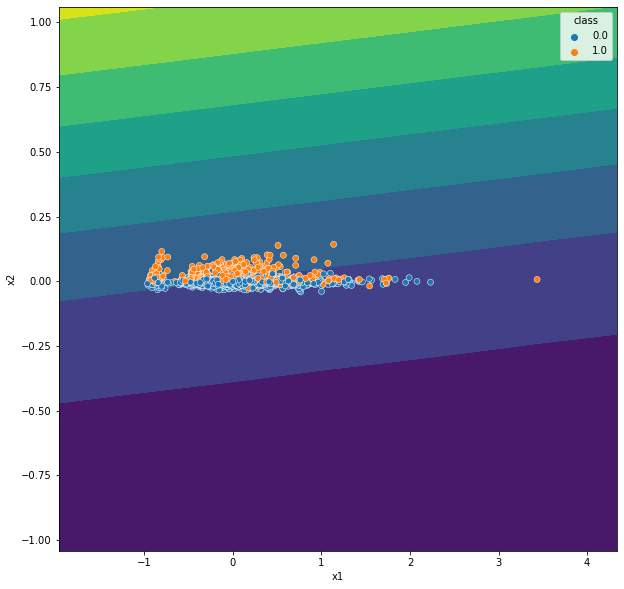

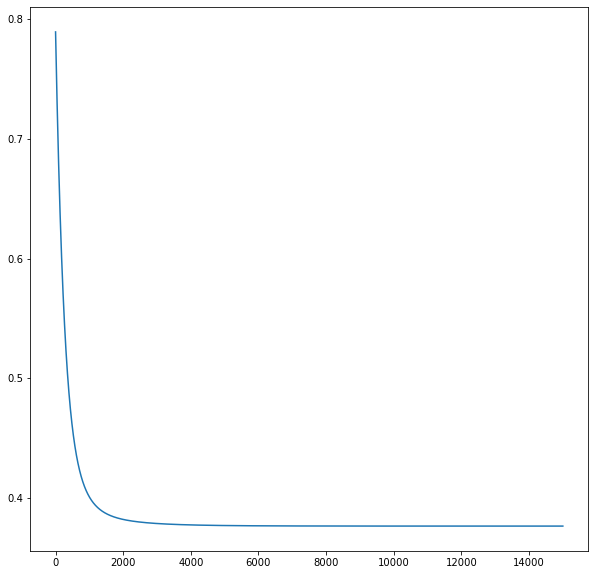

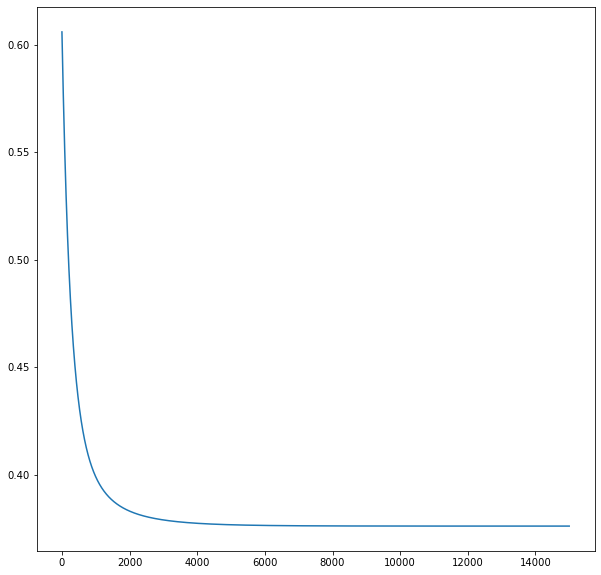

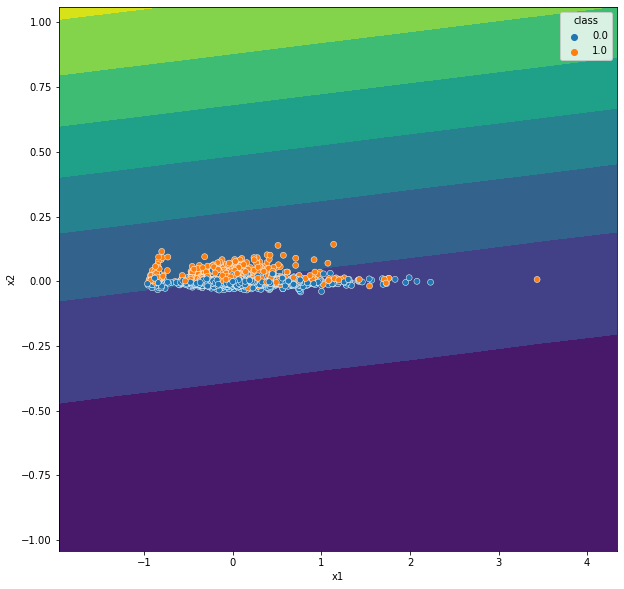

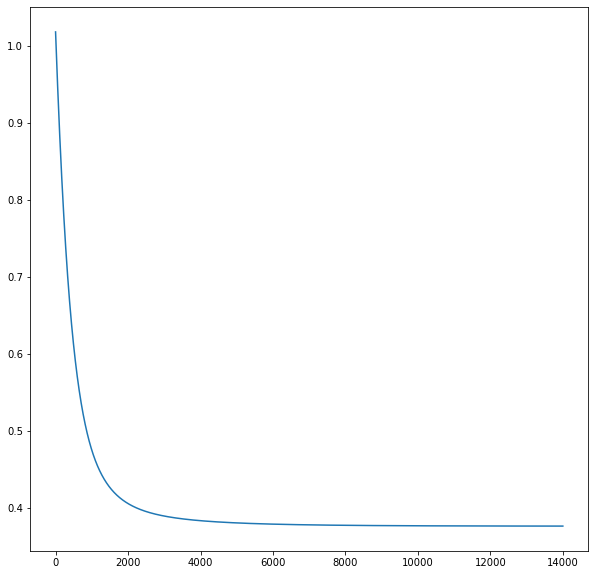

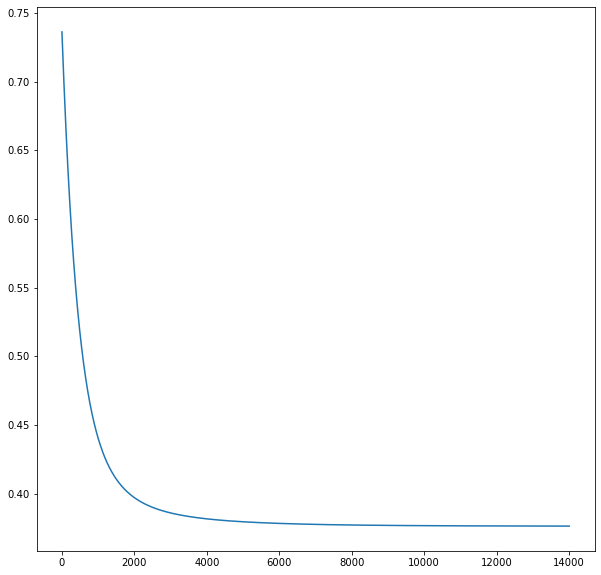

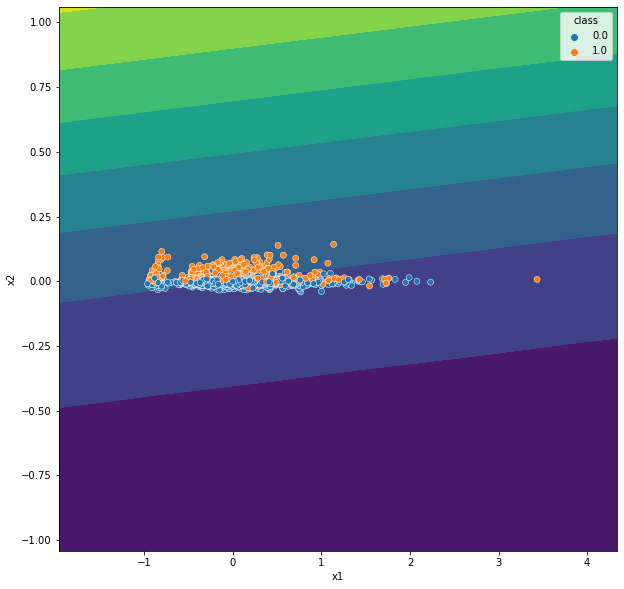

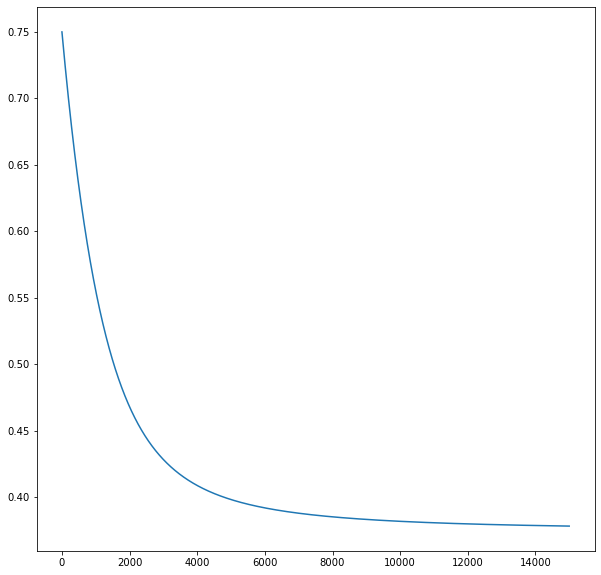

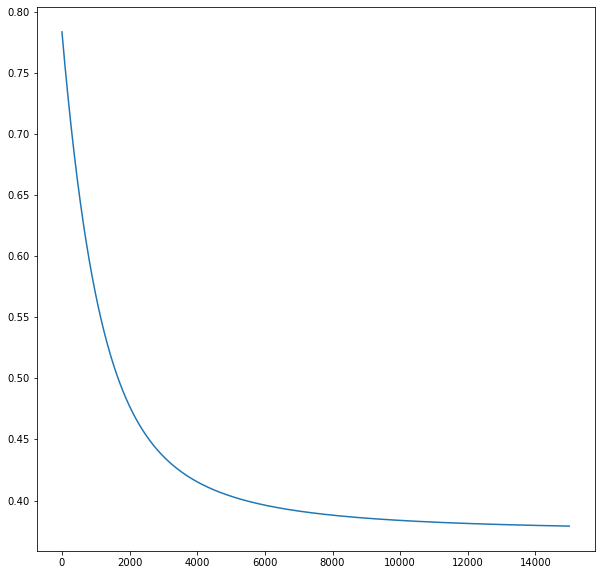

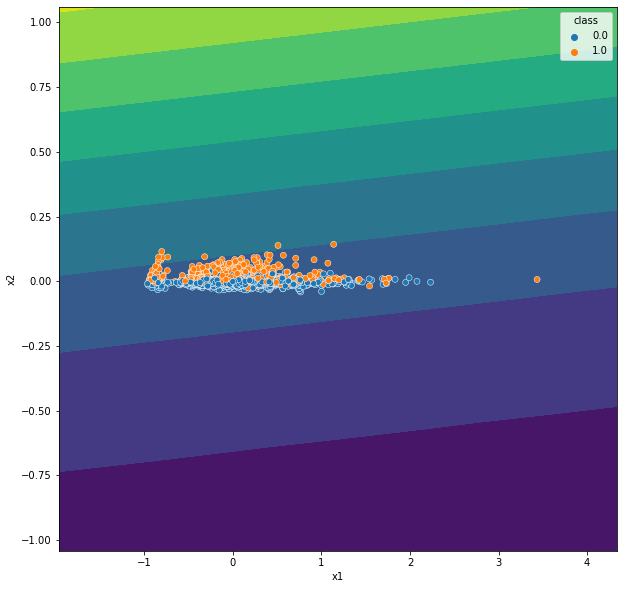

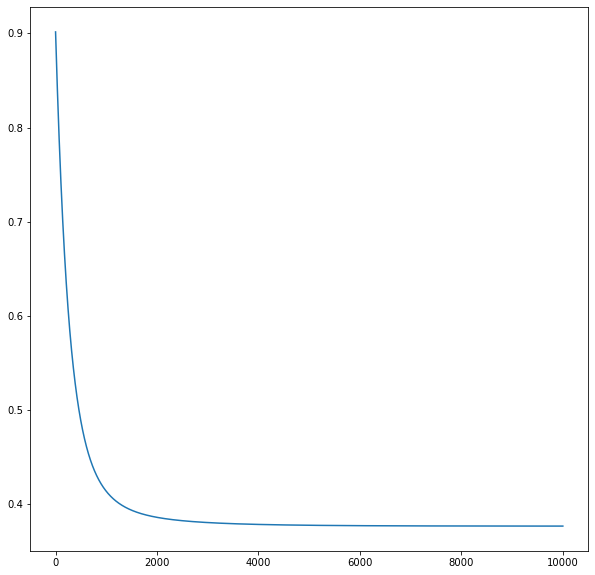

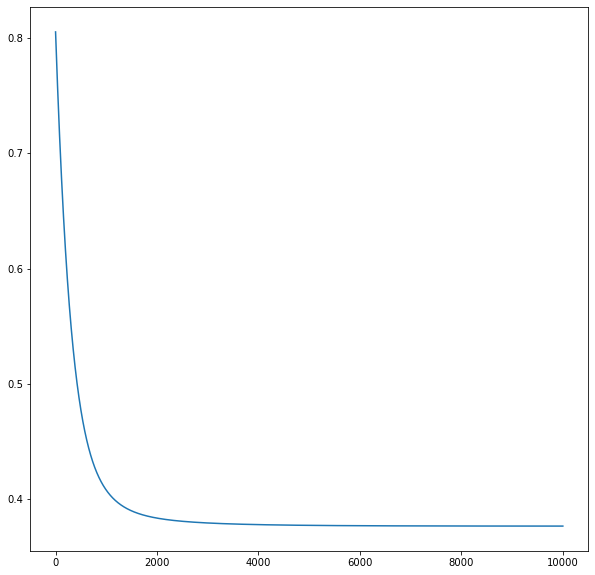

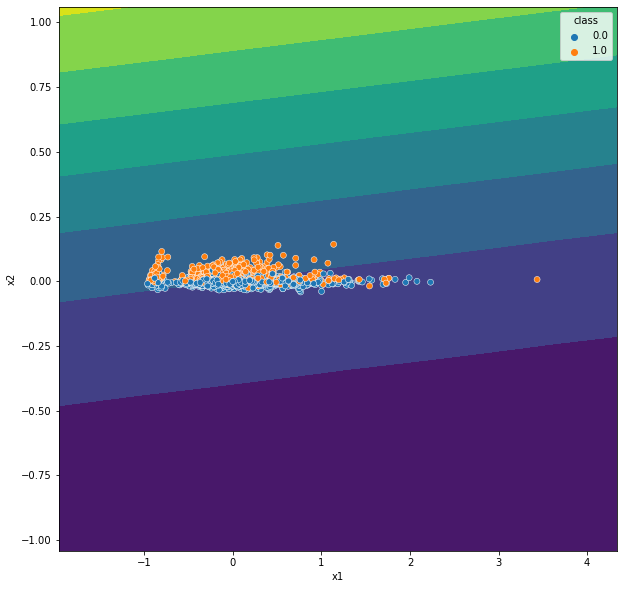

In [16]:
optimizer = Optimizer(processing_df,sw)

study = optuna.create_study(direction='minimize')
study.optimize(optimizer.objective,n_trials=100,show_progress_bar=True)



In [17]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.37630338768001
  Params: 
    alpha: 0.009
    err: 0.05
    min_count: 200
    Tol: 15000
